# Project 1 

(1) a specification of the work to be performed (definition of the game or optimization problem to be
solved)

(2) related work with references to works found in a bibliographic search (articles, web pages,
and/or source code)

(3) formulation of the problem as an optimization problem (solution representation, neighborhood/mutation and crossover functions, hard constraints, evaluation functions)

(4) implementation work already carried out (programming language, development environment, data structures, among others).

In [305]:
import numpy as np
import itertools
import time
import matplotlib as plt
import math, copy
import random
from collections import defaultdict
from collections import Counter

table_arrangement = [[0,2], [1,3]]

test_preference_matrix = [
    [  0,  10,  -5,  20, -10,  15,   0,  -5],  # A
    [ 10,   0,  30,  -5,  20, -10,   5,   0],  # B
    [ -5,  30,   0,  10, -20,   5,  15,  10],  # C
    [ 20,  -5,  10,   0,  25,  -5, -15,  20],  # D
    [-10,  20, -20,  25,   0,  30, -10,   5],  # E
    [ 15, -10,   5,  -5,  30,   0,  20, -10],  # F
    [  0,   5,  15, -15, -10,  20,   0,  30],  # G
    [ -5,   0,  10,  20,   5, -10,  30,   0]   # H
] #ABCDABCD

In order to test with different sized preference matrices we created a function that randomly generates preference matrices given a number of guests

In [306]:
def random_preferences(nguests):
    preference_matrix = [[0] * nguests for x in range(nguests)]
    for guest1 in range(nguests):
        for guest2 in range(nguests):
            if guest1 != guest2:
                score = random.randrange(-100, 100, 1)
                preference_matrix[guest1][guest2] = score
                preference_matrix[guest2][guest1] = score
    return preference_matrix

p = random_preferences(4)

print(p)

[[0, -22, -55, 63], [-22, 0, -2, 50], [-55, -2, 0, 8], [63, 50, 8, 0]]


In [307]:
def evaluate_table(table, matrix):
    score = 0
    for guest in table:
        for neighbor in table:
            if guest != neighbor:
                score += matrix[guest][neighbor]

    return score

def standard_deviation(solution, preference_matrix):
    score_tables = []
    total_score=0
    for table in solution:
        current_score = evaluate_table(table, preference_matrix)
        total_score += current_score
        score_tables.append(current_score)
    average = total_score/len(solution)

    std_sum=0
    for score in score_tables:
        std_sum += (score-average)**2
    
    std = math.sqrt(std_sum/len(solution))
    return std

def evaluate_solution(solution, preference_matrix):
    average = average_tables(solution, preference_matrix)  #not optimal
    std = standard_deviation(solution, preference_matrix) + 1  # shift de 1 para nunca poder haver divisao por 0
    return (average/std)
    

def average_tables(tables, matrix):
    score = 0
    for table in tables:
        score += evaluate_table(table, matrix)
    average = score / len(tables)
    return average


score = evaluate_solution(table_arrangement, test_preference_matrix)
print(score)

-10.0


To be able to perform our algorithms correctly we will need all tables to be filled, so we will create fake guests called "EmptySeat" that have no preferences towards the other guests.

In [308]:
import math
import copy
def fill_matrix(seatsPerTable, matrix):
    nguests = len(matrix)
    total_tables = math.ceil(nguests / seatsPerTable) #rounds the division up to the next integer
    TotalSeats = total_tables * seatsPerTable
    diff = TotalSeats % nguests 

    matrix_copy = copy.deepcopy(matrix)
    if diff == 0:
        return matrix_copy
    else:
        #fill the matrix with the preference that the guests have of the empty seats
        for guest in range(len(matrix_copy)):
            matrix_copy[guest] = matrix_copy[guest] + ([0]*diff)

        #fill the matrix with the preference of the emptyseats
        for i in range(diff):
            matrix_copy.append([0]*(nguests+diff))


m = fill_matrix(3, test_preference_matrix)
print(m)

None


Some of the algorithms we are applying to this problem, there is a need to create an initial random arrangement. That is what this function is for.

In [309]:
def random_arrangement(matrix, seatsPerTable):
    matrix_copy = fill_matrix(seatsPerTable, matrix)

    nguests = len(matrix_copy)
    guest_list = list(range(nguests))
    arrangement = []
    for table in range(nguests//seatsPerTable):
        table = random.sample(guest_list, seatsPerTable)
        for seatedGuest in table:
            guest_list.remove(seatedGuest)

        arrangement.append(table)
    return arrangement

def generate_population(population_size, preference_matrix, seatsPerTable):
    solutions = []
    for i in range(population_size):
        solutions.append(random_arrangement(preference_matrix, seatsPerTable))
    return solutions


r = random_arrangement(test_preference_matrix, 3)
print(r)

population = generate_population(3, test_preference_matrix, 2)
for solution in population:
    print(solution)

TypeError: object of type 'NoneType' has no len()

In [ ]:
toBeChanged = random.choices(range(1, int(8 * 0.05)+2))
print(toBeChanged)

All of our algorithms require some way to get a solution that is very similar to a given solution. In order to get that we built this function that changes a certain number of guests (based on the number of total guests).

In [ ]:
#swaps two guests
def get_neighbour(curr_arrangement):
    neighbor_arrangement = copy.deepcopy(curr_arrangement)
    table1 = np.random.choice(len(neighbor_arrangement))
    table2 = np.random.choice(len(neighbor_arrangement))
    while(table1 == table2):
        table2 = np.random.choice(len(neighbor_arrangement))
    person1 = np.random.choice(len(neighbor_arrangement[table1]))
    person2 = np.random.choice(len(neighbor_arrangement[table2]))
    neighbor_arrangement[table1][person1], neighbor_arrangement[table2][person2] = neighbor_arrangement[table2][person2], neighbor_arrangement[table1][person1]
    return neighbor_arrangement
#improvement not filled table play

def advanced_get_neighbour(curr_arrangement):
    percentage = 0.05   #adjustable
    totalSeats = len(curr_arrangement)
    #randomly chooses from 1 guest to 5% of total guest population to be swaped
    toBeChanged = random.choices(range(1, int(totalSeats*percentage)+2))
    
    neighbour_arrangement = curr_arrangement
    for nguests in range(toBeChanged[0]):
        neighbour_arrangement = get_neighbour(neighbour_arrangement)
    return neighbour_arrangement

advanced_get_neighbour(test_preference_matrix)

This function performs a midpoint crossover between two parents, combining their tables and filling the children's tables with remaining guests randomly.

In [ ]:
import random

def midpoint_crossover(parent1, parent2):
    num_tables = len(parent1)
    cut = num_tables // 2  # Ponto de corte no meio
    
    child1 = parent1[:cut] + parent2[cut:]
    child2 = parent2[:cut] + parent1[cut:]
    
    assigned1, assigned2 = set(sum(child1, [])), set(sum(child2, []))
    all_guests = set(sum(parent1, []) + sum(parent2, []))
    remaining1, remaining2 = list(all_guests - assigned1), list(all_guests - assigned2)
    
    def fill_tables(child, remaining, parent_ref, assigned_set):
        random.shuffle(remaining)
        for i in range(num_tables):
            missing_count = len(parent_ref[i]) - len(child[i])
            for _ in range(missing_count):
                if remaining:
                    guest = remaining.pop()
                    child[i].append(guest)
                    assigned_set.add(guest)
    
    fill_tables(child1, remaining1, parent1, assigned1)
    fill_tables(child2, remaining2, parent2, assigned2)
    
    return child1, child2

This function performs a random crossover between two parents by randomly swapping tables, then filling the children's tables with remaining guests.

In [ ]:
def random_crossover(parent1, parent2):
    num_tables = len(parent1)
    
    mask = [random.choice([0, 1]) for _ in range(num_tables)]
    
    mask[random.randint(0, num_tables - 1)] = 0  
    mask[random.randint(0, num_tables - 1)] = 1 
    
    child1, child2 = [[] for _ in range(num_tables)], [[] for _ in range(num_tables)]
    assigned1, assigned2 = set(), set()

    random.shuffle(parent1)
    random.shuffle(parent2)
    
    for i in range(num_tables):
        if mask[i] == 0:
            child1[i] = [guest for guest in parent1[i] if guest not in assigned1]
            if child1[i] is not None: 
                assigned1.update(child1[i])
            child2[i] = [guest for guest in parent2[i] if guest not in assigned2]
            if child2[i] is not None: 
                assigned2.update(child2[i])
        else:
            child1[i] = [guest for guest in parent2[i] if guest not in assigned1]
            if child1[i] is not None: 
                assigned1.update(child1[i])
            child2[i] = [guest for guest in parent1[i] if guest not in assigned2]
            if child2[i] is not None: 
                assigned2.update(child2[i])
    
    all_guests = set(sum(parent1, []) + sum(parent2, []))  
    remaining1 = list(all_guests - assigned1)
    remaining2 = list(all_guests - assigned2)
    
    def fill_tables(child, remaining, parent_ref, assigned_set):
        random.shuffle(remaining)
        
        for i in range(num_tables):
            missing_count = len(parent_ref[i]) - len(child[i])
            if missing_count > 0:
                for guest in remaining[:missing_count]:
                    if guest not in assigned_set:
                        child[i].append(guest)
                        assigned_set.add(guest)
                remaining = remaining[missing_count:]  

    fill_tables(child1, remaining1, parent1, assigned1)
    fill_tables(child2, remaining2, parent2, assigned2)
    
    return child1, child2

parent1 = [[0, 2], [1, 3], [4, 5], [6, 7], [8]]
parent2 = [[1, 2], [0, 4], [6, 5], [8, 7], [3]]

child1, child2 = random_crossover(parent1, parent2)

print("Filho 1:", child1)
print("Filho 2:", child2)


**SIMMULATED ANNEALING**

In [ ]:
def call_simmulated_annealing(cooling, preferences, seatsPerTable, iterations=10000):
    if isinstance(preferences, int):
        preferences = random_preferences(preferences)
    elif not isinstance(preferences, list):
        raise ValueError("Preferences must be either an integer or a list.")

    # Call the simulated annealing function
    result, score = simmulated_annealing(cooling, preferences, seatsPerTable, iterations)
    return result, score
                 

def simmulated_annealing(cooling, preferences, seatsPerTable,iterations=10000):
    #primeiro arranjamos um estado inicial random e avaliamos
    initial_state = random_arrangement(preferences, seatsPerTable)
    filled_preferences=fill_matrix(seatsPerTable, preferences)
    initial_score = evaluate_solution(initial_state, filled_preferences)

    temperature = standard_deviation(initial_state, filled_preferences)   #basicamente a nossa tolerância no que toca a aceitar soluçoes piores
    cooling = 0.99    #o quao rápido vai descendo essa tolerancia

    while iterations > 0:

        #depois arranjamos uma soluçao vizinha à inicial e avaliamos essa
        neighbour_state = advanced_get_neighbour(initial_state)
        neighbour_score = evaluate_solution(neighbour_state, filled_preferences)
        

        score_diff = initial_score - neighbour_score

        #se a soluçao for melhor, aceitamos
        if score_diff < 0:
            initial_state = neighbour_state
            initial_score = neighbour_score
        #se for pior aceitamos com uma certa probabilidade que depende da temperatura
        else:
            probability = math.exp(-score_diff / temperature)
            if random.random() < probability:
                initial_state = neighbour_state
                initial_score = neighbour_score
        temperature *= cooling
        iterations -= 1
    return initial_state, initial_score


result, score = call_simmulated_annealing(0.99, 100, 10, 100)
print(f"score: {score}\nresult: {result}")


GENETIC ALGORTHIM

The tournament function selects the best solution from a random subset of the population using tournament selection, while the roulette function selects a solution from the population using roulette wheel selection based on fitness values.


In [ ]:
def tournament_select(population, preference_matrix, tournament_size, exclude=None):
    filtered_population = [ind for ind in population if ind != exclude]
    selected = random.sample(filtered_population, tournament_size)
    best_solution = max(selected, key=lambda s: evaluate_solution(s, preference_matrix))
    return best_solution

def roulette_select(population, preference_matrix, exclude=None):
    filtered_population = [ind for ind in population if ind != exclude]
    fitness_values = np.array([evaluate_solution(s, preference_matrix) for s in filtered_population])
    total_fitness = np.sum(fitness_values)
    rand_value = np.random.uniform(0, total_fitness)

    cumulative_sum = 0
    for i, fitness in enumerate(fitness_values):
        cumulative_sum += fitness
        if rand_value <= cumulative_sum:
            return filtered_population[i]
    


population = generate_population(5, test_preference_matrix, 2)
for s in population:
    print(s)
print("")   
t = tournament_select(population, test_preference_matrix, 3)
print(t)
print("")
r = roulette_select(population, test_preference_matrix)
print(r)


This function mutates a solution with a given probability by modifying it to a neighboring solution.

In [ ]:
def mutation(parent, mutation_prob=0.2):
    if random.random() < mutation_prob:  
        return get_neighbour(parent)
    return parent

Runs a genetic algorithm to optimize seating arrangements over a given number of iterations, using selection, crossover, and mutation, while tracking and displaying performance statistics.


In [ ]:
def genetic_algorithm_1(num_iterations, population_size, preference_matrix, seatsPerTable):
    start_time = time.time()
        
    filled_preference_matrix = fill_matrix(seatsPerTable, preference_matrix)
    population = generate_population(population_size, filled_preference_matrix, seatsPerTable)
    best_solution = population[0]
    best_score = evaluate_solution(population[0], filled_preference_matrix)
    
    best_scores = []
    all_scores = []
    avg_scores = []

    for solution in population:
        all_scores.append(evaluate_solution(solution, filled_preference_matrix))


    print(f"Initial solution: {best_solution}, score: {best_score}")

    while(num_iterations > 0):


        parent1 = roulette_select( population, filled_preference_matrix)
        parent2 = roulette_select( population, filled_preference_matrix, exclude=parent1)

        if parent2 is None:
            parent2 = parent1

    
        #estatisticas para grafico
        avg_score = np.mean(all_scores)
        avg_scores.append(avg_score)
        best_solution = max(population, key=lambda x: evaluate_solution(x, filled_preference_matrix))
        best_scores.append(evaluate_solution(best_solution, filled_preference_matrix))


        # Next generation Crossover and Mutation
        child1, child2 = random_crossover(parent1, parent2)
        child1, child2 = mutation(child1), mutation(child2)
        
        population.append(child1)
        population.append(child2)
        all_scores.append(evaluate_solution(child1, filled_preference_matrix))
        all_scores.append(evaluate_solution(child2, filled_preference_matrix))
        population.sort(key=lambda sol: evaluate_solution(sol, filled_preference_matrix), reverse=True)
        population = population[:population_size]

        num_iterations-=1
    
    best_solution= population[0]
    best_score=evaluate_solution(best_solution, filled_preference_matrix)

    num_guests = len(preference_matrix)
    best_solution = [[guest for guest in table if guest < num_guests] for table in best_solution]

    print(f"  Final solution: {best_solution}, score: {best_score}")

    end_time = time.time()
    print(f"Tempo de execução: {end_time - start_time:.6f} segundos")

    show_graph(best_scores, avg_scores)
    return best_solution

TABU SEARCH

In [ ]:
def tabu_search(preferences, seats_per_table, max_iterations=1000000, tabu_tenure=7, max_no_improve=100):
    
    # preenche a matriz de preferências para lidar com lugares vazios na mesa
    padded_preferences = fill_matrix(seats_per_table, preferences)
    
    # cria uma disposição inicial aleatória dos convidados nas mesas
    current_arrangement = random_arrangement(preferences, seats_per_table)
    best_arrangement = copy.deepcopy(current_arrangement)
    
    current_score = evaluate_solution(current_arrangement, padded_preferences)
    best_score = current_score
    
    tabu_list = {}
    
    iterations_no_improve = no_improve_acc = 0
    total_iterations = 0
    
    # lista de frequências para detetar ciclos
    frequency_list = {}
    
    while total_iterations < max_iterations and iterations_no_improve < max_no_improve:
        total_iterations += 1
        
        neighbor_arrangement = get_neighbour(current_arrangement)
        
        # avalia o vizinho
        neighbor_score = evaluate_solution(neighbor_arrangement, padded_preferences)
        
        # verifica se o vizinho é tabu
        is_tabu = tuple(map(tuple, neighbor_arrangement)) in tabu_list and tabu_list[tuple(map(tuple, neighbor_arrangement))] > 0
        
        # se for tabu e não melhorar, verifica a repetição para tentar escapar de ciclo
        # Aspiration criterion: movimentos que melhoram a solução atual são aceites
        if is_tabu and neighbor_score <= best_score:
            if tuple(map(tuple, neighbor_arrangement)) in frequency_list:
                frequency_list[tuple(map(tuple, neighbor_arrangement))] += 1
            else:
                frequency_list[tuple(map(tuple, neighbor_arrangement))] = 1
                
        # se repetiu muitas vezes, força a sair do ciclo escolhendo outro vizinho
            if frequency_list.get(tuple(map(tuple, neighbor_arrangement)), 0) > 5:
                for _ in range(3):  
                    temp_neighbor = get_neighbour(current_arrangement)
                    current_arrangement = temp_neighbor
                current_score = evaluate_solution(current_arrangement, padded_preferences)
                frequency_list.clear()
            
            iterations_no_improve += 1
            continue
        
        # atualiza a solução atual para o vizinho
        current_arrangement = neighbor_arrangement
        current_score = neighbor_score
        
        # reduz a tabu tenure das soluções na lista
        keys_to_remove = []
        for arrangement in tabu_list.keys():
            tabu_list[arrangement] -= 1
            if tabu_list[arrangement] <= 0:
                keys_to_remove.append(arrangement)
        
        for key in keys_to_remove:
            del tabu_list[key]
        
        # adiciona a nova solução à lista tabu
        tabu_list[tuple(map(tuple, current_arrangement))] = tabu_tenure
        
        # se a solução atual for a melhor até agora, atualiza o melhor
        if current_score > best_score:
            best_arrangement = copy.deepcopy(current_arrangement)
            best_score = current_score
            iterations_no_improve = 0
            frequency_list.clear()
        else:
            iterations_no_improve += 1
        
        no_improve_acc += iterations_no_improve
    
    # remove os convidados fictícios que foram usados para preencher as mesas
    original_guests = len(preferences)
    avg_no_improve = no_improve_acc / total_iterations
    final_arrangement = []
    for table in best_arrangement:
        real_guests = [guest for guest in table if guest < original_guests]
        if real_guests:  
            final_arrangement.append(real_guests)
    print(final_arrangement)
    return (final_arrangement, best_score, avg_no_improve)


def tabu_search_adv(preferences, seats_per_table, max_iterations=1000000, tabu_tenure=7, max_no_improve=100):
    # gera uma matriz de preferências aleatórias entre os convidados
    
    # preenche a matriz de preferências para lidar com lugares vazios na mesa
    padded_preferences = fill_matrix(seats_per_table, preferences)
    
    # cria uma disposição inicial aleatória dos convidados nas mesas
    current_arrangement = random_arrangement(preferences, seats_per_table)
    best_arrangement = copy.deepcopy(current_arrangement)
    
    current_score = evaluate_solution(current_arrangement, padded_preferences)
    best_score = current_score
    
    tabu_list = {}
    
    iterations_no_improve = no_improve_acc = 0
    total_iterations = 0
    
    # lista de frequências para detetar ciclos
    frequency_list = {}
    
    while total_iterations < max_iterations and iterations_no_improve < max_no_improve:
        total_iterations += 1
        
        neighbor_arrangement = get_neighbour(current_arrangement)
        
        # avalia o vizinho
        neighbor_score = evaluate_solution(neighbor_arrangement, padded_preferences)
        
        # verifica se o vizinho é tabu
        is_tabu = tuple(map(tuple, neighbor_arrangement)) in tabu_list and tabu_list[tuple(map(tuple, neighbor_arrangement))] > 0
        
        # se for tabu e não melhorar, verifica a repetição para tentar escapar de ciclo
        # Aspiration criterion: movimentos que melhoram a solução atual são aceites
        if is_tabu and neighbor_score <= best_score:
            if tuple(map(tuple, neighbor_arrangement)) in frequency_list:
                frequency_list[tuple(map(tuple, neighbor_arrangement))] += 1
            else:
                frequency_list[tuple(map(tuple, neighbor_arrangement))] = 1
                
        # se repetiu muitas vezes, força a sair do ciclo escolhendo outro vizinho
            if frequency_list.get(tuple(map(tuple, neighbor_arrangement)), 0) > 5:
                for _ in range(3):  
                    temp_neighbor = advanced_get_neighbour(current_arrangement)
                    current_arrangement = temp_neighbor
                current_score = evaluate_solution(current_arrangement, padded_preferences)
                frequency_list.clear()
            
            iterations_no_improve += 1
            continue
        
        # atualiza a solução atual para o vizinho
        current_arrangement = neighbor_arrangement
        current_score = neighbor_score
        
        # reduz a tabu tenure das soluções na lista
        keys_to_remove = []
        for arrangement in tabu_list.keys():
            tabu_list[arrangement] -= 1
            if tabu_list[arrangement] <= 0:
                keys_to_remove.append(arrangement)
        
        for key in keys_to_remove:
            del tabu_list[key]
        
        # adiciona a nova solução à lista tabu
        tabu_list[tuple(map(tuple, current_arrangement))] = tabu_tenure
        
        # se a solução atual for a melhor até agora, atualiza o melhor
        if current_score > best_score:
            best_arrangement = copy.deepcopy(current_arrangement)
            best_score = current_score
            iterations_no_improve = 0
            frequency_list.clear()
        else:
            iterations_no_improve += 1
        
        no_improve_acc += iterations_no_improve
    
    # remove os convidados fictícios que foram usados para preencher as mesas
    original_guests = len(preferences)
    avg_no_improve = no_improve_acc / total_iterations
    final_arrangement = []
    for table in best_arrangement:
        real_guests = [guest for guest in table if guest < original_guests]
        if real_guests:  
            final_arrangement.append(real_guests)
    print(final_arrangement)
    return (final_arrangement, best_score, avg_no_improve)




## TABU SEARCH GRAPHICAL ANALYSIS

In [ ]:
preferences_300 = [[0, 90, 1, 86, -11, 93, 54, 66, 91, -61, 49, -74, -79, 87, -21, -97, 77, -79, 77, 58, -42, 15, -32, -4, 12, 9, 32, -53, -20, 7, -19, 82, -20, 33, 17, 94, -78, 62, -61, -71, 16, -39, 77, -28, 76, 21, -33, 89, -63, -25, 86, -79, -69, -13, 90, 22, 34, 1, -87, 51, 19, 15, 57, -73, 56, 77, 97, -68, -38, 13, -69, 90, -74, -3, 21, -40, -52, 97, 29, 93, -66, 52, -27, 30, 97, 12, -12, -25, -6, 47, -55, 94, -31, -4, -88, -19, -39, -74, 37, 42, 86, -89, -83, 35, 22, -45, -16, 11, -49, 77, -77, 43, -17, 56, -20, 67, -42, 0, -10, -64, -17, 23, -95, -44, -12, 89, 30, -27, 9, 58, 92, 72, 55, -54, 6, 82, -4, 35, -88, 14, -81, 70, 9, 33, -85, 58, 22, -79, 41, -65, -82, 81, 95, -93, -67, 75, 78, 9, -21, 46, -72, -35, 14, -57, -94, 85, -21, 73, 11, 0, -75, -94, 25, -16, -38, -31, 16, -76, -98, -82, 49, -76, 4, 1, -87, 37, 74, -47, -24, 82, 3, -12, 58, 97, 0, 14, -22, 13, 4, 68, 18, -82, -36, -83, 5, -83, 13, 77, 83, -16, -42, 52, 85, -18, 0, 96, 63, -50, -81, 8, 75, -40, -15, 76, 84, 65, 76, -55, -25, -26, -22, -100, -49, 26, -69, -3, -25, -30, -97, 82, 73, -73, -1, 79, -98, 88, -20, -71, -3, 59, 86, 15, 40, -53, 16, 70, -53, 70, 47, -60, 16, 18, 37, 21, 51, 23, 28, 71, -39, 69, 90, -1, 38, 86, 52, -37, -70, -22, -77, -70, 84, -43, 47, 53, 20, 64, -71, -63, 42, 91, 31, 76, -98, -46, -3, -20, -38, -95, 68, 24], [90, 0, 53, -81, -20, -95, -9, 69, -81, 20, -94, -76, -95, -62, -16, 96, -27, -23, 80, 44, 97, -17, 87, -85, 16, -37, -34, -2, 90, -12, 25, 75, 13, 58, -56, 81, -47, 74, 82, 69, -27, 38, -80, 67, -32, -38, -88, -7, 88, -84, -69, -50, 35, 25, -11, 30, 75, -82, 93, 8, -96, -34, -9, -21, -95, -48, -53, -33, 74, -93, -74, -70, -24, -97, -49, -3, 73, -80, -62, 57, 22, -8, -95, -76, -37, -44, -12, -90, 67, 37, -75, 54, -96, 59, 16, 89, -99, -43, -17, -3, -58, 24, -51, -66, 47, -15, 82, 53, 41, 74, -10, 56, -29, 7, 43, 82, 78, 29, -18, 12, 49, -56, -99, -79, 44, -48, -67, 66, 92, -88, -51, 30, 66, 94, -90, -26, 62, 99, -44, 23, -92, -100, -34, 47, 30, -19, 69, -11, -69, 92, 35, 92, 26, -95, -24, 85, 55, 19, 11, -61, -27, -94, 38, 83, 3, -52, 16, 44, -53, 38, 66, 22, 71, 59, 10, 63, -95, -83, 43, -46, 9, -21, -97, 92, -26, -92, 41, 19, 36, 72, 44, 33, -86, 69, -77, 16, -85, 67, -94, -76, 83, 38, 78, -85, -33, 10, -26, 76, -89, -64, 87, 93, 51, -22, -88, 69, 49, 99, -75, 12, -18, 61, 94, 14, -34, -13, -26, 61, 45, -57, 47, -14, -26, 80, -93, 88, -15, -28, -18, -60, -82, -4, -87, 23, -45, 7, -89, -1, -24, -50, -76, 28, -15, -76, -85, 4, 74, -91, -73, 30, -89, 93, 30, 92, -57, 84, 52, -45, 85, -48, 97, 85, 78, -63, 40, -6, 53, -35, -51, -45, -11, -16, -24, -12, 87, 78, 6, -50, 88, 93, 74, -58, -25, -23, -86, 62, -18, 44, -3, -61], [1, 53, 0, 28, 75, 17, -91, 23, 1, -67, 99, -29, 0, -74, -15, -20, 34, 26, -45, -52, 47, -97, -7, 44, 53, -53, -88, -37, 91, -8, 42, -83, -48, 32, -6, 12, 32, -76, 85, -3, 24, -48, -51, 75, 52, 58, -99, -99, 1, -29, 52, -49, 35, 56, 16, -43, -33, 58, 36, 87, 29, -5, -36, -60, 59, 23, 23, 36, -83, 19, 78, 45, -19, 61, 42, -5, 93, -99, 76, -27, -3, 70, 23, 4, -7, -36, 54, -71, -53, 95, 16, -63, -18, 10, -2, -47, -23, -18, -73, -68, 55, -72, 76, -14, 62, -33, -94, 10, -13, -68, 27, -15, 38, -17, 60, -51, 89, -69, -85, -94, 26, 78, -38, 31, 20, -54, 50, -33, -26, 86, 10, 60, 25, 58, -39, 12, 77, 28, -45, 53, 78, -62, -20, -60, 18, 12, 0, 59, 36, 27, 22, 84, -30, -37, 70, 16, -88, 30, 93, 53, -67, -23, 7, 60, 58, 68, -23, 70, -45, -49, 59, -53, -94, -41, -59, 95, -21, 98, 47, 7, -20, 34, -7, -90, 53, -29, -99, 9, 68, -24, 37, -39, -46, 75, 1, 87, 1, -79, -58, 32, 74, -72, 53, 46, 48, -27, -41, 27, 15, -18, 47, 4, 5, -23, 93, 44, -76, 80, -97, 28, 38, 42, -81, 4, 87, 73, 98, -90, -35, -100, 62, -39, -4, 54, 63, 62, 40, 77, -79, -73, 28, -76, -85, 63, -87, 15, -11, 48, -6, 25, -2, -37, 49, 57, -88, 48, 43, -69, -32, -76, -66, 4, 70, -62, -76, -91, -62, -48, -79, 47, 15, -32, 62, 70, -60, -38, -8, 87, -8, 93, -2, 83, -84, -59, 63, 72, 45, -91, 61, -48, 5, -5, 95, 54, 3, -70, -61, -75, -89, 16], [86, -81, 28, 0, -77, -87, 52, -6, 84, -44, -80, 7, -4, -9, 89, -3, -88, 84, -40, 20, -18, -33, 34, -25, -13, -45, -3, -5, -17, -56, 53, 6, 47, -27, -83, 53, 97, -70, 31, 48, -59, 52, -69, 3, -28, -39, 31, -94, 81, 44, 31, 20, -57, 70, 48, -76, -96, -31, -84, -53, -47, 34, 13, -46, -93, -5, -74, 86, 42, -19, 92, 80, 47, -14, -50, 11, 85, -69, 80, -99, 98, 51, -68, -84, -89, 37, -34, 34, 81, 67, 64, -100, 35, 16, 68, 37, -26, -54, 78, -53, -10, 85, -47, 10, 48, -34, 96, 46, 14, 19, -45, -47, -97, -24, -36, -96, 67, 70, -88, 73, -21, -63, 62, -79, 54, 96, -53, -51, 73, -36, -93, 4, -69, 20, 14, 88, -6, -30, -87, -62, 24, -10, 2, 19, 52, -24, 55, 99, -44, 11, 88, 29, -69, -1, -86, -29, -90, -32, -49, -44, 5, 44, -62, 21, 70, -19, 3, 65, 77, -98, 40, 56, 43, 2, -71, 3, 13, -66, 91, 87, 65, 45, 37, -56, 95, 44, -16, 77, 83, 10, 60, 11, -56, -23, 72, -35, 53, -87, 79, -9, -3, 82, -66, 64, -26, 97, -93, 42, 15, 10, 89, 36, -58, -48, 25, 67, -74, 53, 19, -4, 12, -35, -5, -72, 30, 48, 49, -34, 82, -56, 35, 81, 79, 14, 14, 61, -78, -2, 99, -62, 86, 79, -22, -63, -39, -3, 79, -15, -100, -90, 97, -91, -43, -72, -71, 0, -95, 83, -18, -85, 43, 9, 57, -89, 58, 7, -87, -22, 30, -30, 10, 90, -82, -46, 28, 25, -20, 56, 53, 89, -99, -87, -76, -66, 26, -67, -74, -12, 99, -20, 40, -90, -26, 21, -24, -86, -15, -5, 95, 33], [-11, -20, 75, -77, 0, -27, -2, 50, -19, 53, 13, 88, 99, 30, 50, -61, -67, 48, 38, 86, 73, -27, -62, 25, 3, -57, 72, 49, 75, -20, -79, -32, 80, -63, 17, -57, -41, 34, 78, -100, -7, 29, 86, -28, 11, -91, 63, -4, 64, 42, 11, -26, 1, -34, -69, 34, -18, 96, -35, -46, -36, 50, -67, -22, 36, 50, 18, 47, 18, -78, -26, 88, 39, 0, -74, 90, -25, 90, 89, 84, 11, 67, 9, 14, 53, 7, 1, -38, 34, -30, 53, 58, 82, 99, 89, 37, -54, 36, -79, 32, 55, -85, -38, -89, 7, -93, 31, 58, 41, 34, 65, -1, 98, -14, 21, 81, -28, -49, -5, -23, -35, -54, 7, -7, -78, -33, 84, 29, -53, -44, 69, -47, 69, 5, 44, 87, -93, -52, 71, 3, 45, 49, -41, 16, 95, 7, 32, 96, -1, -63, 48, 40, -74, 64, 22, 27, -20, 91, 47, 51, -40, 81, -37, -63, 61, 25, 24, 82, -38, 59, -62, 69, 47, -18, -73, -90, -38, -53, -38, -36, -98, 29, 78, -82, -16, 3, -12, 40, 3, 83, -30, -8, 64, 64, 58, -65, 80, 39, -13, 58, -89, -75, 38, 36, -64, 66, 78, -56, 94, 40, -60, -27, -84, -58, 73, 99, 86, 60, -83, -23, 45, -31, 63, 23, -95, -2, -23, 41, -99, 76, -93, -21, -68, 50, -35, 78, -8, 10, -16, -4, 38, -5, -28, -28, 2, 64, 43, -72, -15, 7, 5, 88, -14, -73, -38, -24, 21, -24, -82, -73, 30, 68, 81, 88, 51, 52, -49, -96, 15, 92, 79, -62, 52, 62, 11, 41, -1, -40, -57, 47, 94, -76, 38, 49, 0, 6, -71, 64, 68, 80, 60, 5, -85, 79, 43, -51, 19, 98, 81, -57], [93, -95, 17, -87, -27, 0, -14, -80, -56, 30, 43, 91, -68, -30, -74, 88, 67, -47, 79, -67, 54, 10, -35, 13, -84, -30, 7, -21, -15, -48, -27, -4, -2, 9, 34, -37, -60, 80, -6, -4, 58, -86, -2, 27, -6, -39, 93, 62, 61, -43, 25, 9, -12, 88, 52, 25, -44, -40, -22, -30, 23, -7, 15, -81, -17, -45, -10, -59, -24, 26, -95, 14, 98, 59, -87, 99, 83, 99, -41, 44, -83, -27, 16, 89, 81, 72, 71, 53, -13, -98, 28, -95, -100, 99, 60, -70, -58, 65, -7, -48, -80, 92, -74, 94, 15, -75, -27, -71, 67, 60, -99, -50, -81, -19, 44, -26, 69, 46, 93, -45, 41, 11, 59, -34, -23, -85, -45, 57, -52, 64, -2, 18, 13, -31, 78, -51, -96, 98, 37, 93, 90, -2, -32, 56, -44, -55, -36, 4, 22, 25, -30, -76, -15, 46, -61, 2, 58, 98, 9, 53, -7, 17, 0, -97, 58, -66, 39, 52, -81, 76, -94, -55, -41, 37, 10, 41, 5, -39, -10, -22, 3, 88, 36, 27, -66, -39, -45, 80, -32, -58, 74, -39, -100, 69, 76, -85, 57, 70, 5, 76, -84, 34, 43, -2, 62, -24, 84, 65, 85, -62, -56, -43, -72, -52, -10, 76, -29, -14, 41, -85, -8, 8, 47, -5, 84, -50, 15, -62, 15, 37, -35, 73, 16, 98, 88, 88, -14, 45, 72, 72, -7, -54, 15, 22, -85, 84, 7, -73, -28, 67, 67, -12, -17, -46, -70, -23, 86, 44, 17, -61, -61, -34, 40, -25, -65, 51, 11, 73, -52, -39, -19, -86, 37, -88, -44, -49, -100, -90, -6, 55, -2, -73, -2, 83, -2, 72, -11, 10, 30, 12, -78, 70, 23, 96, -72, 47, 28, 62, -97, 19], [54, -9, -91, 52, -2, -14, 0, 98, -11, -66, 76, 38, 73, 2, -68, 52, 16, -50, 57, -6, 87, -98, -31, 33, -27, -39, -17, 43, -17, -50, -61, -66, 78, 82, 70, 62, -80, -20, 46, 84, -84, 73, 3, 52, -73, -42, 61, -54, -40, 89, -87, -45, -57, 21, 72, 77, 25, 82, -28, -11, 18, 65, 17, 63, -40, 88, -48, 84, 78, -62, -37, -14, -69, -92, -46, 30, 26, 46, 13, -93, -97, -94, 50, -23, 30, 60, 63, -12, -93, 35, -65, -6, -14, -51, 72, -73, 71, 34, -75, -71, -39, -93, -65, 74, 6, -3, -10, -67, -86, 7, -39, 39, 66, 76, 28, 46, 67, -62, 3, 30, -99, 89, 85, 16, 54, -86, -17, -6, 72, 35, -97, -39, 99, -74, 60, 81, -38, 17, 15, -5, -18, -88, -95, -96, 82, 50, -61, 1, -64, 19, -39, 90, 52, 42, -20, -80, 4, -95, -73, 38, 31, 96, -37, -30, -2, -35, -50, -35, -1, 95, -3, -86, 2, 98, -72, 42, 4, -41, -73, -82, 61, -13, 63, 36, -67, -44, -66, -48, -44, -61, 61, 58, -64, 18, -31, 28, 55, 22, 68, 98, 88, -50, 69, 0, 80, 40, 25, 87, 87, -65, -50, 17, 5, -93, 96, 26, -1, -20, 84, -23, -67, 58, 77, 98, -75, 49, -65, -32, 13, 97, 64, -23, 26, -56, 68, -6, 94, -52, -36, -85, 20, 16, 22, -32, -64, 53, 15, 42, 20, -83, 68, -71, 52, 47, 43, 46, -38, -11, 96, 61, -91, -61, 76, -17, -81, -35, -84, 35, -61, -94, -51, 20, 95, -54, 67, -65, 71, 70, -1, -65, -45, 56, -88, -47, 39, 45, -32, 39, 30, -63, 5, 39, -65, 5, -97, -18, 87, 96, -77, 31], [66, 69, 23, -6, 50, -80, 98, 0, 26, -23, -83, -70, -15, 5, 96, -38, 56, 67, 5, 33, 3, 18, -89, -16, 64, 87, -21, -69, 62, -43, 20, 47, -24, 63, -79, -75, -55, 10, -82, 41, -79, -94, 28, -21, -78, -82, 45, 29, -68, -58, -50, -90, -4, 45, 62, -30, -68, -73, -22, -4, 15, 11, -95, -19, -99, 4, -18, 84, 44, -73, 42, 52, -63, -50, 25, -77, 67, -59, -39, -46, -81, -83, 73, -77, 40, -38, 82, 91, 50, -50, -2, 44, -22, 82, 75, -43, 10, 28, 26, -40, -99, 24, -89, 36, -47, -68, -14, 12, 49, -9, -98, -34, 32, 79, -25, 46, -29, 70, -80, -11, 98, -1, -21, -89, 46, 19, -2, -3, -40, -33, 43, -78, -36, 32, 64, 49, -40, 10, 8, 55, 25, -52, -16, 65, -12, -33, -6, 63, -85, -22, -99, 29, -66, -59, -52, -44, -83, -6, 14, 62, 13, 82, 57, -9, 69, 93, 58, 88, -77, -62, -1, -94, -2, -50, 95, -28, -95, 59, 7, 53, 48, -72, 85, -5, 30, -61, -65, -77, -4, -56, 71, -82, 16, 25, 29, 6, 14, 31, -36, -77, 37, -53, 1, -34, -93, 30, -25, -69, -45, -13, -28, -63, -62, 70, -51, 20, 50, 74, 88, 74, 50, -42, -38, 74, 82, 50, 82, -45, 46, 7, -15, -73, -18, 43, 1, 66, -59, -66, -91, -17, 57, 25, -53, 91, -17, -46, 37, 40, 35, 73, -1, 12, -6, -79, -55, -74, 81, 17, 73, -35, 44, 18, -57, -86, -54, 80, -15, -24, -80, 93, 61, 92, -87, -31, -66, 0, 33, 22, -86, 98, -6, -60, 83, 38, -68, -48, 29, 95, -45, -49, 27, -10, -89, 35, -33, -50, -94, -10, -94, 51], [91, -81, 1, 84, -19, -56, -11, 26, 0, -36, -96, -4, 71, 28, 65, 64, -26, 89, 73, 47, 76, 38, 1, 84, 72, 37, 82, 92, 48, -61, 8, 71, -68, -38, -68, 9, -83, 25, 80, 51, -76, -22, -15, -87, -58, 37, 9, -37, 82, 50, -15, -20, 80, -81, 15, 69, 17, -40, 67, -72, 6, -28, -30, 10, -79, 85, -54, 1, 71, 39, 76, -48, 24, -64, -75, -46, 9, -77, -51, -25, 51, 47, 27, 2, -63, 18, -55, 75, -41, -34, 40, -51, 16, -19, -26, -47, -52, -39, -19, -77, 93, 51, 78, -66, -21, 36, -93, -22, 25, -27, 14, -89, 32, -57, -42, 7, -52, 79, 58, -72, 69, 23, -23, -69, -65, 21, -24, 7, 55, -31, -50, 71, -64, 92, 50, 93, -59, 8, -70, -53, -50, -40, -36, -21, 67, 81, 68, 28, 3, -60, 41, -18, 84, 30, -85, 25, -90, -90, -66, 12, -90, -56, 12, 51, -53, -72, -45, -93, 34, 11, -46, 39, 40, 57, 39, -28, 78, -81, -29, 98, 59, 37, -85, 13, -15, -67, 48, -41, -35, -99, -3, 79, 2, 24, 0, 6, 25, 21, -80, -30, 70, 70, 50, -77, 43, 21, 66, -24, 77, 99, -4, -10, -85, 44, -9, 12, -90, -45, -30, 22, 5, -58, 8, 51, -23, -43, 13, -34, -76, 28, -66, 52, -68, 65, 32, -24, -52, 56, 12, 16, -13, 2, 43, -84, 3, 76, 35, -30, 93, -84, -92, -89, 46, -81, -9, -86, 3, 47, 76, -25, -92, 19, 56, 94, -14, 70, -11, 62, 63, 51, 72, 20, 75, -97, 22, -71, -45, -72, -52, -43, -54, 45, -69, -63, 10, 40, 39, -46, -69, -36, -18, -29, -48, -27, -86, -18, -5, 0, -96, 23], [-61, 20, -67, -44, 53, 30, -66, -23, -36, 0, -18, -60, -84, 5, 89, 22, 52, 78, 86, 44, -70, 47, -19, -85, 15, -38, 11, -93, 96, -25, -100, -50, -85, -97, -15, -51, 50, -19, 68, -5, 87, -53, -22, -24, -30, 57, 67, 88, 77, 82, 75, 71, 92, -87, 55, -52, 29, 65, -6, -82, -78, 89, 61, -83, -79, 70, -35, 16, -67, -93, -26, -63, 33, -50, 16, -67, -26, -5, 44, -85, 46, -58, -2, -88, -59, -57, 96, -94, -40, -68, 28, 59, 66, 88, -73, 46, -9, 25, 55, 76, -87, -65, -15, 88, 11, 72, 54, 22, -65, -54, 45, 9, 74, 15, -74, 58, 81, -6, 76, -1, 91, -74, -12, 21, -72, 2, 2, 86, 92, 78, -79, 80, -94, 77, 27, -24, 70, 5, -80, -18, 29, -33, 32, 71, -57, -57, -40, 63, -46, -73, 50, -41, 67, -32, -55, -47, 3, 44, -41, 15, 4, 88, -3, -51, -82, -55, -94, -86, -60, -26, -22, 33, 23, -33, 45, 70, 57, -66, -59, 22, 46, -94, 97, -11, 29, -58, -36, 26, 22, 84, 5, -74, -57, 62, 63, -71, -31, -86, -41, -42, -8, 64, 55, -15, -50, -97, 91, -73, -57, 33, -29, 99, 39, -28, -87, 10, 31, -40, 83, -91, 82, -6, -50, -19, -71, -25, -33, -53, 12, -57, 16, 7, 65, -44, -55, -87, 18, 33, 98, 19, 15, 80, -26, 26, -44, -2, -53, -56, 2, -88, -5, 20, 3, -10, -27, -65, -43, -13, 23, 88, 90, 57, 98, 68, 58, -20, 38, -82, -82, -73, -89, 19, 36, -95, -59, -86, -16, -18, -45, -11, 39, 98, -42, -57, -85, 61, -51, 26, -73, -30, -16, -46, 38, -70, -68, -76, 16, 54, -86, 2], [49, -94, 99, -80, 13, 43, 76, -83, -96, -18, 0, 21, 46, 73, 33, 54, 72, 25, -29, -81, 77, -15, 3, -83, -96, -36, 25, -30, -10, -2, 76, 99, -91, 43, -25, 96, 67, 32, -86, 7, -79, 94, -28, 90, 3, -35, -83, 38, 32, -50, 20, -67, -85, -53, 14, 94, -43, -84, -71, 86, -100, 69, 62, -93, 59, -69, 55, 18, 7, -22, -50, 46, 33, 47, 42, 81, 54, 68, 51, -95, -57, 26, -34, -30, 27, -86, 98, -40, -56, -23, 17, 80, 45, 97, -27, -86, 26, 42, -52, 56, -32, 69, 75, 51, -65, -29, -87, 15, 3, 31, 8, -93, -90, -40, 11, 28, -82, 70, -21, 9, 75, -41, -4, 96, 26, 52, 9, -22, 8, -6, -13, -17, 13, -60, 3, -95, -84, 24, 46, 76, -79, 75, 83, -10, -50, -23, -56, 28, -74, -84, 73, -7, -1, -72, -40, 74, -61, -83, -27, -65, -13, 64, 40, -42, 36, 43, -22, -11, -4, 72, -62, 16, 54, 91, 10, 21, -96, 24, -17, -79, 45, -61, 81, 50, 63, 89, 27, -73, 37, -78, 4, -53, 6, -32, 90, 26, -65, -63, -68, 28, 45, -83, 16, 45, 69, -24, -58, -68, 36, -86, -61, 3, 82, -26, -88, -38, -77, 25, 40, -24, 65, -11, 67, 79, 38, -95, 71, 20, 62, 96, -89, 64, -100, -61, -65, 5, -62, 76, 59, -86, 65, -31, 37, 14, -44, 0, -64, -36, -91, -32, -39, 42, -54, -2, 76, 41, -14, 17, 89, -62, -18, 61, -16, 11, -95, 1, 77, 63, 74, 47, -13, -79, 38, 25, 79, -59, 75, -36, 7, -51, -82, 40, -58, -74, 83, 98, -36, -77, -89, -11, 2, -17, -43, 65, 13, 39, -9, -41, 48, 73], [-74, -76, -29, 7, 88, 91, 38, -70, -4, -60, 21, 0, 5, 44, -87, 93, -76, -27, -95, -56, -57, 21, -60, -33, -22, 77, 93, -11, -66, 25, -66, -90, 4, 73, -38, 66, 72, 42, -30, 43, 89, 18, -45, -2, -11, 55, -71, 36, -50, 16, 70, -83, -4, -8, -82, -51, 13, -82, 30, -42, 64, 82, 65, -40, -14, -44, -25, 66, 78, -43, 8, -58, -47, -8, 61, -3, 10, -59, -35, 50, 46, 17, 65, -60, -11, 81, -64, 84, 38, 95, 41, -77, 88, -32, -89, -76, 91, -13, 48, 36, 10, -24, 8, -59, 21, 65, 31, -37, 23, -97, 63, -96, -75, -14, -20, -31, 57, 7, 91, -5, -55, 59, -33, 69, 35, -11, 51, 5, -97, -79, -1, -19, 57, 90, 56, -59, 71, 96, 95, -70, 0, -29, -37, -59, -50, 73, 61, 59, 41, -68, -18, -20, -58, 44, -74, 99, -91, -56, -89, 35, 94, -14, -9, 56, -17, 57, -55, 10, -63, 30, 45, 50, 59, 57, 87, 79, 29, -9, -55, 84, -13, 73, -48, -96, -80, 42, -63, -25, -24, -26, 76, 75, -62, 20, 57, -14, 75, -23, 74, -16, -49, 17, -73, 87, 28, 62, 22, 25, 64, 97, -36, -99, 79, -89, -84, 34, 80, 90, 78, 89, 6, 26, -40, 27, 87, -35, -5, 7, 45, 15, -43, 17, -48, -28, -35, -100, 47, 80, -26, 6, -39, -68, -84, 93, 28, 22, 34, 56, 95, -8, -1, 25, 69, 91, -61, 39, -34, -2, 15, 1, -67, -33, 25, -32, 95, -38, -29, -39, 22, 34, 15, -40, -23, -59, -85, 75, -13, -89, -66, 79, 17, -73, -97, 62, -43, -77, 47, -64, -46, 17, 58, 0, 3, -2, 9, 31, 79, -77, 74, 86], [-79, -95, 0, -4, 99, -68, 73, -15, 71, -84, 46, 5, 0, -84, 18, -79, -34, 96, 61, -17, 34, -52, -71, 84, -4, -60, -80, 34, -58, -70, -94, -93, 20, -77, -70, 32, -77, -42, 3, 50, -74, 40, -42, -28, -13, -3, -34, 35, 93, 42, -38, -15, 29, -10, -32, 33, -25, 90, 26, 21, 81, -92, 59, -18, 55, -33, -54, -100, 25, -35, -70, -86, 81, -53, 3, 49, -96, -23, 24, 68, 28, 96, 53, 77, 5, -86, -97, -26, -39, -17, -16, -87, -33, -65, -57, 44, 15, 62, -20, -7, 33, 2, 87, 27, 73, 52, -31, -19, -53, -13, -27, -22, 67, -50, 70, -96, 18, 97, -65, 85, -28, 70, 17, 12, 51, -100, 68, 2, -37, -64, -93, 35, 32, -61, 30, -35, -82, -90, 9, -80, -13, 64, -98, 61, 2, 12, -28, 38, 18, -22, -30, 97, -57, 16, -84, 47, 37, -39, -98, 27, -60, 75, 2, -14, -21, 45, 6, -67, -55, -25, -88, -69, -18, -87, 31, -89, -54, -20, 2, -29, -76, 71, -91, -14, 71, -31, 82, 25, -64, 18, 97, 28, -99, -45, 10, -57, -76, -18, -70, -83, -88, -73, -91, -51, 28, -88, -18, 49, 46, -59, 47, -32, -34, 48, 79, -96, 66, -63, 71, 8, -8, 81, 53, -97, 77, 85, -17, -6, -78, 68, -62, 16, -70, 94, 17, 96, 54, 62, 91, 53, -2, 90, -34, -50, -36, -3, -32, -16, -42, 61, -3, -99, -87, 21, 91, -72, -7, -8, -93, -25, -5, -16, 79, 16, 69, -75, 99, 13, 29, -41, -61, -73, 87, -45, -20, -20, 75, -65, 42, 46, -66, 72, 18, -80, -85, 24, 66, -54, -45, 31, -41, -10, 69, 68, -64, 71, -42, -40, 4, 58], [87, -62, -74, -9, 30, -30, 2, 5, 28, 5, 73, 44, -84, 0, -25, -16, -9, -32, 5, 8, -14, -17, -68, 44, -61, -15, 96, 16, 50, 10, 80, 85, -74, -17, 38, -96, -61, 7, 40, 12, -21, 16, 48, 65, -79, -36, 72, -35, 52, 20, -27, 21, 54, -87, 86, 84, -98, -13, 79, -34, -97, -11, 40, -20, -79, 65, -34, -35, -95, -2, -3, 65, -18, -49, 2, -83, -1, -61, -70, -39, 42, 65, 39, -86, 15, 13, -93, 20, 34, 42, 6, -40, -1, -96, -53, 31, -41, -9, -21, -93, -36, 42, -23, 43, -33, -15, 20, 85, -30, 59, -87, -75, -51, -54, -76, 9, -21, 89, 50, -76, 84, 12, -54, 64, -12, 12, 83, 11, 19, 16, -59, 48, 37, 3, 36, -93, -49, 0, 18, 92, -9, 5, -33, 30, -37, 2, -21, 3, -24, -70, 17, 80, 66, -10, -70, -65, 79, 76, 0, -75, 42, 42, 29, -64, -63, 34, -94, 94, -49, 22, 58, 64, -93, 31, 70, -47, 85, 17, 56, -99, 82, -35, -80, 70, -48, 19, 87, 23, -17, 67, 4, -24, 96, 9, 29, -34, 8, -84, -85, 10, -55, 13, -92, -23, 10, 26, -34, -50, 80, 93, -69, -7, 67, -6, 75, -49, 7, -41, 44, -56, -91, -31, 42, -17, -26, -58, -90, 14, -6, -49, 59, 72, -54, -92, -55, 38, -22, 65, -7, -62, 60, -37, -33, -3, -17, -74, 80, 75, -15, -4, 43, -79, -53, 40, -90, 3, -47, -42, 25, -53, -80, -99, 61, -33, -22, 62, 5, -26, 21, -73, -94, -30, -67, 73, 97, -15, -62, -28, 72, 7, -31, -38, 73, -81, 13, -21, -92, 39, -83, 56, 63, -49, 87, 7, 21, -95, -51, 61, -71, -53], [-21, -16, -15, 89, 50, -74, -68, 96, 65, 89, 33, -87, 18, -25, 0, -60, 27, 90, 50, 22, -95, -38, 29, 64, 61, -74, -2, 14, -22, 29, 88, 85, -33, 50, 46, 57, -47, -82, 87, 44, 3, -32, -40, -98, 12, 88, -73, -23, 27, 88, -59, -36, -52, 92, 48, -58, -90, -99, 20, -81, -61, -63, 46, 84, 91, 50, 16, -22, -93, -18, 88, -81, -16, 37, -34, 95, -4, -92, -12, 1, -15, -76, 23, 25, 52, 37, -42, -98, 61, -69, -54, -86, -67, 83, -80, 68, 18, -27, -38, -32, -18, -36, -79, -33, 48, 64, -22, -22, 8, 69, -97, 3, -74, -74, 74, -52, -81, 90, -79, 62, 82, -39, 52, -34, 98, 27, -47, -54, 47, 99, -9, 49, -89, -87, -18, 90, -94, -74, -78, 13, 23, -76, 62, 55, -47, -98, 36, 23, 4, -97, -67, -58, -72, 43, 93, -69, -62, -98, -94, -94, -98, 2, 7, -89, -83, 22, -19, -99, -44, 36, 0, 54, 36, -65, -85, 54, -65, 9, 32, -18, 20, -42, -95, 19, -41, 67, -6, -7, 34, 5, 35, 94, 69, 79, 96, -63, 99, -37, 79, 67, 12, -69, 80, -29, -89, -22, 24, 78, 20, -1, 91, -81, 74, -83, 73, 70, -69, -84, -82, -99, 2, 39, 49, -45, 34, 54, -71, 90, 9, 42, -92, 97, 96, 59, -100, -87, 49, 13, 60, 0, 59, 78, -39, -100, -75, 64, -56, 37, 8, 30, -43, -74, -73, -80, 48, -11, -46, 33, 6, -17, -54, -3, 67, 10, 46, -17, -25, -1, 52, -89, 30, 35, -79, -64, 42, 15, -52, 12, 79, -79, -35, -42, 88, -63, -69, 44, 18, -17, -95, -64, -16, 43, -89, 12, -98, 6, 23, -55, -45, -4], [-97, 96, -20, -3, -61, 88, 52, -38, 64, 22, 54, 93, -79, -16, -60, 0, 32, -34, 73, 41, 6, -15, -84, 11, -60, 24, -27, -69, -61, 27, 10, 42, 10, 26, 53, -20, 27, -26, 7, 84, -41, -20, -60, 92, 25, 40, -91, 60, 3, -43, -27, 28, 59, -72, -7, 18, 3, -69, -1, 88, 93, 96, -72, -59, 77, -92, 62, -39, 59, 78, -87, 45, -44, 4, -51, 98, -25, 97, -5, 5, -7, 31, 50, 76, 76, 49, 44, -12, 40, 7, 0, 12, 19, 65, -25, -83, 3, -30, 10, 12, 30, -50, -36, 84, -19, -50, -53, 54, 65, -14, -21, 0, -62, 15, -26, -24, 0, 66, -32, 5, 72, -9, -65, 0, -58, 9, 5, 77, 57, -95, -78, 82, -49, -37, -85, -95, -71, -35, -58, -1, 90, 85, 88, 94, -62, 54, -74, 19, -99, 96, 63, -90, -9, -91, -52, 20, -14, -23, -69, -43, -15, -91, 78, 47, 28, -69, 65, -25, 47, 78, 0, -29, -35, 3, 39, 63, -6, -99, 2, 70, -79, -85, -100, 42, 44, 25, -27, -50, -21, 75, 44, 65, -27, -98, 1, -44, 1, 97, 57, 87, -50, 34, 11, 65, 77, -58, 71, 86, 19, 82, -81, -48, 64, -5, -82, 5, 40, 51, -31, 58, 1, -22, -100, 26, 42, -1, -87, -26, -28, -19, 57, 16, 90, -15, 10, 29, -48, 9, 15, -82, 59, 15, 52, 19, -15, -97, -60, 37, 21, -98, -92, -94, -6, -90, 62, 94, 24, 69, -74, 0, 3, 29, -62, 74, 52, -1, -2, -80, 29, 57, 48, 2, 11, -51, 81, 60, -53, 42, 24, -96, -43, 21, 13, -91, -80, -3, 45, -75, -33, -35, -71, 81, -76, 41, 67, -99, 28, 46, 9, 56], [77, -27, 34, -88, -67, 67, 16, 56, -26, 52, 72, -76, -34, -9, 27, 32, 0, -97, -59, -66, 64, 63, -13, -89, 61, 1, -23, -50, 92, 33, -75, -40, 59, -77, 90, 33, 82, -7, 37, -37, 74, 9, -62, -13, 35, -59, 57, -41, -7, 83, -73, -55, 35, -28, -82, -49, 41, 38, 45, 49, 20, -56, 80, -30, 76, 20, -23, -74, 50, -13, -35, 39, 27, 44, 43, 32, 13, -27, -38, -41, 38, -47, 38, -71, 12, -64, 39, 40, -98, 33, -69, 69, 42, -59, -69, -63, 52, -53, 27, 73, 79, -59, 5, -17, -21, 94, -28, 55, 67, 32, -73, 27, 35, 27, -33, -66, 94, 50, 50, 33, -41, 39, 47, -78, -44, 32, 99, 45, 85, -22, 90, -48, -51, -60, -92, 66, 52, -69, -3, -49, -84, 31, -20, 3, -37, -83, -86, -68, 88, 61, 70, -93, -90, 86, 0, -16, -88, -23, 42, -19, -2, -37, 13, 27, 78, -77, 14, -92, -5, -18, 48, -35, -83, 8, 87, -91, 89, -67, 32, 74, -100, 89, 87, 24, 40, 47, -42, -86, 46, -19, 8, 77, 2, -7, 8, -4, 33, -73, 34, 91, 70, -16, -79, 26, 64, -64, 66, 92, 2, -12, 17, 70, -7, -51, 61, 92, 43, -88, 29, -98, -8, -96, 55, 89, 27, 82, -37, -17, 48, 22, -88, 88, 40, -81, 8, -12, -54, -89, 15, -69, 77, 90, -47, -10, 37, -55, 22, -12, -78, 87, 52, -11, 17, 69, -29, 53, -73, 9, 84, -98, 41, 4, -20, 94, -50, -30, 70, -96, -86, 29, -18, 49, 12, -87, -70, 26, 19, 84, 69, -68, 92, 69, -3, 60, 92, -92, 40, -70, -56, 31, 20, -59, 85, 26, 31, 25, 8, -7, -68, 4], [-79, -23, 26, 84, 48, -47, -50, 67, 89, 78, 25, -27, 96, -32, 90, -34, -97, 0, -73, -5, -6, 27, 85, 17, -2, -19, 29, 15, 98, -32, -12, 30, 92, -2, -76, -77, 47, -97, 35, -37, 11, 85, -28, 24, -45, -23, 47, -36, -66, -15, 86, 33, -41, -19, 41, -22, 1, -85, 76, 52, 78, 16, -92, 47, 69, 7, -66, 59, -37, -79, -29, 80, -56, 50, 5, -61, 90, 73, 13, -2, 23, -94, 43, -1, -8, -32, -77, -6, -84, -6, 71, -72, 96, 40, -64, -40, 37, -74, -7, 38, -77, -43, -43, 79, 31, -10, -75, -88, -9, 93, -44, 42, -37, -72, 5, 16, 8, -99, 71, 21, -62, -11, 10, -19, 99, 93, -88, 62, 45, 83, 47, 37, 19, 49, 37, 35, 99, 52, 43, -87, 99, -20, -84, 53, -87, 22, -84, -30, -62, -1, -57, -32, 84, -30, 28, -40, 43, -54, 65, 48, -71, 27, 51, 38, 61, 12, -66, 27, -70, -33, 39, -50, 17, 95, 72, 87, 69, 75, 14, 4, 19, -87, 10, -18, -50, 22, 19, 58, 14, 47, 78, 30, 12, -61, -60, 57, -6, -70, 58, -56, -26, 81, -47, -2, -20, 23, -79, 95, 26, 28, 64, 73, 61, 53, 44, -98, 53, 92, 27, 53, 10, 8, 81, -74, -34, -95, -52, -60, -62, 35, 89, -94, 71, 38, -31, 74, 20, -92, 60, 0, 52, 91, -30, 83, -5, 72, -43, -45, -88, -79, -5, 35, 62, -40, 62, 80, -64, -29, 25, 83, 9, 24, -92, 41, 97, 13, -17, 95, -1, 13, 60, -74, -57, 68, 86, -96, -20, 59, 22, 72, -29, -39, -87, -75, -52, -80, -66, 86, 37, 79, -74, -49, -59, 46, 26, 75, -25, -79, 58, 95], [77, 80, -45, -40, 38, 79, 57, 5, 73, 86, -29, -95, 61, 5, 50, 73, -59, -73, 0, 5, -97, -14, 56, -52, -71, 21, 25, -24, -81, -90, 98, 45, 36, 71, -89, -100, 10, 60, 67, -66, 23, -30, 72, -16, 38, -89, 62, 21, -44, -3, 31, -5, -27, -16, 90, 90, 98, 79, 8, -69, -50, 0, 42, -21, -26, -27, 40, -93, -2, -84, -36, -97, -19, -28, -3, 1, -70, -80, 41, 20, -30, -7, -100, 13, -95, -73, 20, -92, -89, -93, 71, -16, 10, 9, -44, 71, 7, -77, 31, -15, -94, -67, 17, -85, -59, -55, -68, -22, -58, 25, 97, 46, -81, 71, 8, 82, 43, -68, 28, -66, -43, -91, -21, 37, -34, -50, -80, -43, -56, 17, -30, 7, -63, 8, -75, -66, -7, -94, -80, 76, -57, 90, 61, -75, 26, -64, -8, -66, -68, -39, -90, -4, -35, 4, -40, -88, 60, -52, -62, 43, 0, -61, 96, 5, 71, 9, 67, -34, -72, 2, 36, 50, -80, 31, 6, -93, 33, 65, 19, 39, 7, -36, -7, 81, 65, 93, -76, 34, 53, -4, -71, 88, -99, 89, -50, -47, 63, 65, -72, -15, -52, 56, -24, 64, -47, -81, -76, 94, 15, 97, 77, 70, -27, -13, -16, 79, -16, -5, -37, -98, -96, 9, -65, -37, -51, -41, -17, 15, 0, -25, 2, 18, 87, 95, 66, 45, -84, 8, 81, 14, 85, 69, -49, -82, -67, 89, -83, -33, -30, 84, 9, -34, -84, 31, -10, 32, 30, -23, 34, 54, -74, -52, -18, 71, 88, 52, 78, -87, 31, -39, -25, -61, 65, -25, -95, 33, -13, 34, 91, 28, -7, -4, -73, -48, -71, 12, -4, -89, 17, -4, 83, -53, -43, -33, -81, 11, -46, 70, -24, 66], [58, 44, -52, 20, 86, -67, -6, 33, 47, 44, -81, -56, -17, 8, 22, 41, -66, -5, 5, 0, 22, 72, -30, -77, -74, -50, -48, -97, 28, 20, 15, 14, -83, 52, 22, -41, 65, 74, 2, -44, 38, -40, 49, 5, 44, -66, -49, -45, -81, -3, -27, -84, 64, 64, 75, -41, -93, -26, -90, 23, -40, -68, 49, 83, 66, -51, -2, -98, 27, 72, -54, 41, 2, -61, 67, 31, -7, 70, -91, 96, -2, 93, -40, -90, -10, 66, -62, -42, 98, 86, 83, 17, -15, -37, 39, 91, -43, 21, -95, 1, -49, 50, 96, -27, -13, -94, 85, 42, -36, 67, 63, -44, 68, 91, -50, -71, 44, 34, -82, -75, -76, 63, 40, -40, -100, -55, -38, 14, 77, -13, 34, 97, 86, 35, -86, 73, 38, 5, 44, 49, 95, -5, 42, 15, 84, 78, -94, -97, 34, -38, 2, 61, -35, -14, 65, 97, -12, 35, -44, 6, 75, 63, -95, -76, -11, 24, 54, 2, -34, -72, -23, -56, 85, 49, 59, 40, 44, -57, 50, 55, 75, 11, 88, 27, 56, 77, -52, -62, 14, 70, -33, -36, -16, -12, 5, 64, -99, 6, -67, -32, -17, 94, -73, 16, 23, -27, -45, 67, 86, -27, 93, -90, -64, -6, -59, 83, -47, -83, -64, 9, -29, -55, -5, 1, 42, -40, -43, -89, 47, -41, -35, 30, 47, -58, 50, -77, 95, 94, 61, -87, -54, 65, 60, 81, 52, -50, 40, -88, 32, 70, 94, -99, -58, -55, 90, -85, -95, 71, -69, 2, -21, 63, 9, -32, -69, -87, -66, 82, 62, -35, 53, -92, 65, 65, 51, -82, -85, -7, 39, 47, 40, -86, 21, -38, 83, -91, 38, -36, -98, 38, -81, 64, -16, -37, 98, -64, -81, 8, -12, -27], [-42, 97, 47, -18, 73, 54, 87, 3, 76, -70, 77, -57, 34, -14, -95, 6, 64, -6, -97, 22, 0, 98, -18, -50, 59, 1, 55, 27, -70, -7, -24, -50, 55, 98, 55, 97, -77, 70, 79, 32, 80, 14, -71, -55, 32, -44, -33, 89, -50, -66, 24, -85, -57, 74, 18, 40, 99, 47, -18, -3, -46, -61, -60, -39, -7, 82, 2, 1, -26, 30, 35, -7, 68, -88, 68, -56, -27, 24, 78, -100, -11, 61, 62, 22, -65, 55, -94, -55, 49, -77, -15, -23, -56, -87, -73, -72, 28, -80, -62, 61, -92, -2, 46, -3, 70, 0, 93, -63, -6, -77, -86, 12, -81, -30, -65, 55, -28, 7, 73, 55, -50, 4, 68, -13, 51, 2, 8, -88, 52, 0, -19, -4, -73, -30, 31, -28, -65, 41, 64, -22, 6, -71, 59, -9, 99, 66, 89, -94, 73, -1, -65, 95, -65, -35, 9, 18, -1, -78, -90, -14, -37, -80, -86, -11, -64, -82, -61, 10, 94, 3, -87, 87, 57, -96, -88, -80, 50, 87, -75, -79, 45, 11, 66, -36, 17, -2, -24, -44, 33, -51, -87, 39, -16, 7, -90, -43, 10, 29, -53, 12, -54, 24, -48, 57, -58, -32, -66, 35, -22, 20, -4, -24, -92, 15, -38, -3, 34, -97, -6, 91, -33, 34, -98, -33, 17, 32, -94, 92, -74, -34, -6, 48, 84, 88, -90, -17, -18, 78, -75, -70, 31, -80, 9, -47, -37, -32, 94, -8, -99, -57, 36, 14, -80, -45, 41, 63, -77, 90, -70, -27, 31, -99, -67, 48, 13, 9, -34, 73, -81, 59, -92, -15, -59, 86, -65, 96, -72, 70, -46, 90, 42, -73, 44, -51, -75, -83, 94, -32, 40, 32, -89, 38, 90, -76, 1, 58, -86, -38, -22, -71], [15, -17, -97, -33, -27, 10, -98, 18, 38, 47, -15, 21, -52, -17, -38, -15, 63, 27, -14, 72, 98, 0, 61, -12, -44, 51, 99, -84, 50, 24, -92, -56, 98, 46, -64, 45, 93, -85, -92, -76, -8, 34, -66, -60, 42, 82, 82, -98, -68, -45, -55, -11, 55, 44, 12, -6, 93, -22, 8, 30, 45, 93, -34, -8, 68, -37, 8, -32, 14, -28, 66, -44, 21, 39, -46, -25, -59, 4, 33, 92, -43, -50, 43, -41, 49, 21, 98, 61, -78, 25, -82, -3, -24, -22, 43, 50, 36, -81, -60, 38, -80, -42, 52, -35, -27, -66, -2, -75, 57, -100, 76, -44, 82, -3, -98, 98, -82, 74, 5, -36, 30, -52, 52, 97, 53, -32, 29, 75, -40, 65, 96, -77, -59, -82, 73, 67, -60, -32, -13, 64, -42, -36, 52, 94, -21, -8, -26, 60, -11, 12, -67, 92, 91, 15, 4, 89, -9, 17, -29, 38, -41, 68, -36, -65, -48, -62, 7, 45, -52, 65, 2, 83, -99, 88, 40, 71, 18, 8, 38, 50, -41, -16, -44, 23, -45, -25, 84, 72, -60, -16, -70, 6, 8, -89, 99, 32, -40, -52, 41, 55, 75, 27, -50, -10, -88, 52, -77, -14, -31, -94, 68, -95, 40, -68, 3, -94, 81, 27, -53, 81, 11, -60, -79, 10, 84, -83, -70, -23, -92, -40, 77, -16, 27, 99, 36, 9, 50, 31, -63, 24, 89, -15, -32, 66, -58, -80, -44, -65, -6, 29, -13, 61, 55, 93, -27, -98, -2, 80, -87, 20, 7, 53, 13, 92, 94, 18, -53, -90, 32, -57, 64, -19, 15, 77, -10, -25, 24, 21, -26, 71, 58, -11, 77, 80, 31, -8, 66, 58, 17, 65, -46, -75, -42, 76, 63, -41, 9, -30, -39, 12], [-32, 87, -7, 34, -62, -35, -31, -89, 1, -19, 3, -60, -71, -68, 29, -84, -13, 85, 56, -30, -18, 61, 0, -68, -73, -3, 52, 66, 5, 44, 15, 21, 46, -43, -15, 67, 52, 47, 70, -17, 35, -24, -10, 28, -88, 16, -33, 42, -35, 70, -43, -99, 43, -70, 24, 59, 11, -21, -80, 74, -66, 13, 84, 92, -74, 16, -50, 11, 32, -59, -52, 49, -70, 66, -76, 77, 36, -53, -1, -79, -47, -56, -16, 18, 16, -79, -65, 35, -8, 62, 52, -89, -6, -74, -44, -75, 49, 93, -32, 56, 75, -36, -83, 53, -58, -34, 28, -56, -44, 33, -79, -31, 64, 17, -60, 23, 66, -40, 76, 40, -34, -91, 13, 37, 81, -88, -99, -52, -47, -62, -10, -31, 62, 3, 55, 63, -81, -76, -62, -45, 22, 90, 59, -18, 98, 84, -15, -2, 14, 19, -5, 52, 69, 11, -74, -68, 87, 3, 86, 63, 54, -21, -15, -66, -93, -44, 74, 97, 74, -64, 33, 10, 17, -86, -52, -26, 34, -88, 7, 69, -43, 24, 2, 16, 14, -42, -59, -98, -82, -11, 4, -34, 33, -18, -68, -100, -32, -72, -74, -50, -4, -64, 53, 43, -3, 76, -93, 62, -50, -54, 88, -79, -72, 25, 50, -98, -62, -83, 58, 33, 77, -54, 35, 24, -84, 57, -16, 47, 23, 44, -42, -50, -84, -79, -99, 95, 2, 84, -99, 17, 97, -73, 90, -44, 13, 75, 18, 15, -71, 7, -88, 27, 41, 53, -95, 78, -17, -4, -72, -47, 69, 28, 47, 81, -82, -10, -36, 33, 60, 69, 79, -56, 27, 23, 79, 36, -30, -63, -27, -11, 92, -41, -30, 50, 46, 49, 12, 61, -67, -73, -74, -78, 93, 66, 55, -64, 6, 53, -48, -81], [-4, -85, 44, -25, 25, 13, 33, -16, 84, -85, -83, -33, 84, 44, 64, 11, -89, 17, -52, -77, -50, -12, -68, 0, 33, 51, 96, 87, -15, 8, -57, 68, 67, 11, -18, -54, -76, -80, 36, -47, 68, 81, 70, -43, 10, -47, -44, -57, -86, 51, 70, -57, 63, -50, 26, -73, -21, -56, -85, -12, 43, 91, 34, 94, 84, 24, 75, 68, -49, -27, -9, 57, -64, -35, -68, 62, 81, 48, -85, -5, -70, 56, -85, 99, 64, -76, -7, -92, 60, -44, -99, 66, 29, 52, -98, 16, 68, 41, -7, 94, -81, -67, 71, 47, -32, 86, -7, 59, 76, 16, -7, 35, 79, -70, -93, 6, -81, -51, 63, 56, -1, 38, -14, 6, 30, -29, 11, 75, 46, -71, 43, 43, 26, -10, -81, -83, 41, 84, -92, 96, -75, -89, 54, -81, -52, 98, 69, -77, 47, -11, -14, -72, -84, -18, -41, -31, -61, -21, 36, -48, 30, -100, -86, -95, -87, 99, -99, 72, -47, -97, 18, -11, -22, -2, -74, 53, 64, -29, -93, -40, 17, -11, -100, 31, 52, 84, -21, 21, 49, -75, 50, 95, 23, -59, -66, -55, -50, 86, 28, -78, 51, 16, 76, 84, 47, -53, 14, -3, 74, -4, -84, 66, -50, -58, 87, -28, 34, 46, 1, -68, -72, 87, -96, -58, -12, -5, 71, 70, -62, 47, 18, -21, 60, -32, 0, -28, 11, 80, 57, -3, 92, 32, -30, 0, 48, -79, -52, 18, -55, -56, 99, 77, -50, 19, 6, 16, -20, 69, -80, -14, 86, 43, -21, 30, -65, 97, -87, 44, 44, -76, -20, 21, 32, 99, -21, -4, 73, 19, 47, 27, 77, -41, -71, 17, -55, 4, 98, 18, 9, 45, -79, -67, 18, -73, 26, -86, -79, 66, 51, 53], [12, 16, 53, -13, 3, -84, -27, 64, 72, 15, -96, -22, -4, -61, 61, -60, 61, -2, -71, -74, 59, -44, -73, 33, 0, -59, -75, 84, -45, -91, -44, -43, -40, 46, 12, 49, -60, 61, 62, 34, 3, -68, 37, 24, 56, 23, -14, 75, 11, 61, -50, -96, 4, 85, -67, 61, -77, 18, -93, -21, 47, -10, -54, 57, 28, 1, 45, -71, 63, -66, -14, 5, -3, -83, 28, 19, 11, -18, 48, 70, -39, 21, -40, -2, -10, 97, 9, 52, 8, 88, -57, -45, -64, 56, -9, -95, -90, 30, -5, -78, 45, -51, -19, -16, 23, 97, 73, 62, -5, -80, -79, 47, 94, 12, 96, -9, -57, -86, -39, -62, 50, -73, 34, -78, 52, -57, -64, -100, -76, -51, 72, -62, -64, 37, -88, 61, -2, 84, 31, 0, 66, -29, -24, 56, -66, 18, -85, -51, 36, 38, 63, 18, -37, 50, -67, 98, -35, -98, 37, 27, 11, -16, -10, -31, 3, -54, 52, -27, 36, -14, -2, -36, 91, -5, -66, -24, 30, 2, -97, 43, 52, -69, -76, -67, -1, 94, 21, -71, -12, 89, 61, 89, 60, -35, 43, -79, -84, -53, 48, 4, 16, -72, 1, -69, 74, 38, -68, -50, -2, 16, -53, -58, -50, 69, 19, 31, -41, -11, -24, 6, -9, 5, -2, 93, -5, 26, 82, 3, -14, 70, 38, 90, -24, -77, -94, -38, -81, -13, -65, -22, -34, -25, 30, -6, 32, 86, -48, 7, 49, 84, -1, 43, -86, 25, -60, -81, -89, 29, 14, -59, 44, 65, -6, -27, -42, 50, 15, -93, 12, -17, 71, 26, 44, 57, 17, -59, 11, 89, 54, 28, -83, 34, 58, 53, -36, -61, -13, -40, -58, 69, -97, -88, -71, 76, 88, 65, -2, -75, 87, -60], [9, -37, -53, -45, -57, -30, -39, 87, 37, -38, -36, 77, -60, -15, -74, 24, 1, -19, 21, -50, 1, 51, -3, 51, -59, 0, 80, -48, 36, 42, 43, -23, 13, 47, -70, 73, -86, -42, 18, 52, -14, -37, 26, -28, 78, 22, 61, 57, 1, -72, 42, 25, 42, 51, -95, 66, -7, -35, -69, -68, 78, 96, -31, -8, -5, 46, 10, 35, 71, 16, 16, 98, -66, 80, 53, 69, -51, 78, -30, 76, 79, -99, -37, -19, -1, 64, -29, 8, -10, 61, 96, 42, 31, 47, 92, -61, -81, -13, 49, -75, -91, -66, 91, 18, 88, 51, 61, -70, -47, 76, -43, 37, 10, 67, -57, 3, -75, 56, 78, -70, 51, 82, 76, 66, -41, 88, -80, -21, 62, 3, 40, -49, -20, -44, -47, -14, -58, 2, -57, -100, 54, 86, -20, -49, -95, -32, -44, 34, -44, -10, 81, 15, -87, -16, 92, -57, 80, 37, 38, 3, 52, -76, -71, -13, 64, 8, -69, 54, -21, -69, -28, -14, 6, -93, -95, 35, 67, -77, 10, -68, 61, 10, -5, 73, -46, 74, 22, -61, -97, -73, 96, -54, -91, -71, -47, 9, -35, -77, -74, -7, -26, 5, 0, -96, 42, 17, 79, -22, -37, 85, -69, 51, -2, -7, 42, 71, -18, 33, 61, -57, -75, 23, 87, -98, -34, 81, 44, 23, -97, -54, -45, 56, 79, -98, 30, -39, -52, 17, 29, 45, -46, 48, -62, -57, 27, -96, 33, -74, -43, 19, -68, -42, 97, 18, -54, 13, -36, 46, -2, -96, -89, 64, 48, -37, 32, 7, -86, -44, -70, 3, 5, -48, -23, 65, 45, 61, 2, 44, 45, -43, 87, -32, 6, -3, 49, 11, -43, 61, 40, 4, 39, -78, -13, 29, 52, -22, -8, 42, 90, -63], [32, -34, -88, -3, 72, 7, -17, -21, 82, 11, 25, 93, -80, 96, -2, -27, -23, 29, 25, -48, 55, 99, 52, 96, -75, 80, 0, 9, 12, -86, -19, -65, 26, -24, -22, -80, 71, -28, -35, 54, -12, 38, -60, 74, 7, -46, -97, -52, -22, 28, -94, -53, 55, -93, 90, 34, -15, -48, -85, -7, 14, -7, -94, -35, -11, 89, 97, 23, 14, 0, 38, -47, -87, 81, 40, -46, 26, -70, 38, 46, -8, 61, 50, -36, 66, -94, -73, -47, -33, -99, -84, -73, 32, 23, -18, -87, 32, 25, 91, 21, -94, 76, 10, 98, -48, -30, 85, -81, 43, 90, 32, 76, 36, 48, -47, -52, -42, -75, -33, -45, 5, -33, 14, 99, 38, -39, 60, -43, -77, 44, -24, 1, 21, -51, -33, 48, 55, -16, 8, -39, -36, -37, 6, -11, 63, 66, 83, 90, -28, -54, 5, -15, 79, 50, -72, 42, 46, -42, -72, -51, -54, 72, 34, -82, -94, -27, -87, 88, -75, -23, 70, 89, -71, 56, 18, -59, -27, 65, 24, -32, 62, -18, -88, -52, 11, -64, 34, 33, -58, 24, 41, 70, 79, 21, -44, -79, -28, 32, -70, -9, -82, 9, 23, 62, -24, -8, 68, 43, -20, 76, 49, -81, -1, 81, -49, -86, 3, -89, -94, -71, 37, 91, -87, -77, 84, -77, -16, -84, 33, 88, -18, 19, -27, -6, 95, 34, 43, 92, 51, 94, -51, 36, -62, -5, -15, -83, -94, -49, 82, -22, 83, 38, 21, 13, 9, 87, -95, -27, 11, -76, 41, 61, 84, -10, 77, -45, 55, -87, -30, -44, -69, -50, 21, 36, -26, 4, 32, -68, 23, 47, 49, 68, -74, 24, -7, 69, -89, -99, -17, 57, 86, -30, 81, 1, -99, -17, 51, 4, 24, -58], [-53, -2, -37, -5, 49, -21, 43, -69, 92, -93, -30, -11, 34, 16, 14, -69, -50, 15, -24, -97, 27, -84, 66, 87, 84, -48, 9, 0, -2, 93, 75, -34, 42, -41, -28, -30, -99, 49, 44, 33, 47, -64, 80, -90, 53, -83, 98, 13, 30, 97, 97, 60, 29, 64, 33, 59, -57, 68, 66, 21, -54, -3, 7, -49, -80, 50, -2, -2, -86, -96, 2, 43, 45, 25, 45, 29, -49, -97, -3, -14, 21, 43, 27, -11, 48, -35, -20, 85, 12, 80, 50, 92, 64, 74, -29, 76, 9, 62, -92, 50, -97, -36, 85, -94, 99, 77, 68, -90, 91, 31, 99, 40, -92, 24, -52, -23, -92, 44, 64, -39, 66, -78, 2, -97, 3, -7, -15, 65, -88, -99, 54, 76, 34, -33, -65, -67, -27, -66, -80, -72, -51, 80, -72, 28, -47, -21, 23, 62, 4, -69, 58, 98, 35, 89, -82, 57, -91, 0, -72, -35, 18, -40, -50, 44, -1, -96, -15, -85, -59, 25, 33, 2, -56, 25, -86, 6, -5, -86, 23, 81, 82, -51, 39, -58, -73, 4, -64, -90, 65, -31, 8, 85, -74, -19, -39, -1, -53, -56, -25, -5, 13, -73, 79, 11, 98, -63, 47, -12, 84, -36, -14, 90, 10, 48, 49, 33, 7, 27, 59, 50, 6, 58, -88, -69, 86, -55, -12, 11, -41, -78, 31, 98, 12, 6, 20, 78, 4, -84, 81, 79, 61, 20, 10, -65, -23, -79, -91, -45, 79, -23, -97, 82, 66, -32, 88, 33, -27, -32, 43, -70, 64, 44, 44, -1, 71, 11, 27, -57, -8, -36, 83, -7, -77, 63, -28, -3, -11, -80, -10, 58, 9, -94, 87, -39, -39, -25, 90, 94, 56, -7, -93, -14, -41, -15, -29, 2, 5, 10, -21, 24], [-20, 90, 91, -17, 75, -15, -17, 62, 48, 96, -10, -66, -58, 50, -22, -61, 92, 98, -81, 28, -70, 50, 5, -15, -45, 36, 12, -2, 0, -6, -44, 67, -17, -12, 77, -53, 95, -37, -88, -83, -69, 86, 58, -56, -34, -27, -69, 93, 14, -68, 67, 34, -92, 43, -83, 57, -22, -52, -72, -78, -76, 22, 80, -98, 40, 1, 34, 78, -38, -93, -63, 97, -78, -4, -62, -6, -13, -71, 13, -15, 24, -60, 41, 27, 57, 89, -17, -77, -17, 12, 59, -26, -48, -89, -71, 67, -63, 77, -38, 68, -40, -77, -2, 60, 60, -65, 18, 21, 37, -79, 68, -63, 94, 72, 46, 2, -20, 64, 58, -5, -78, -45, -71, 59, -37, 12, -78, 0, -66, -66, 91, 79, -33, -61, -76, 66, -90, 59, 92, -30, 30, -93, -23, -51, 43, 60, 92, -98, -96, 79, -35, 45, -89, -96, 14, -22, -91, -35, -67, -47, -68, -6, 98, -78, -64, 90, -30, -77, 71, 32, -69, -59, -85, 90, 33, -23, -17, -38, 19, -45, 72, 67, 71, 48, 17, -86, 44, 49, -50, 45, 62, 85, -95, -22, -50, 52, -70, 40, 50, -16, -49, 68, -87, -41, 61, 70, 94, -49, -4, 55, 4, -37, 19, -36, 69, 59, -43, 77, 26, 81, -33, 52, 11, 12, -57, -71, 46, 9, -67, 63, 61, 43, -74, -31, -91, 89, -82, -37, 96, 68, -67, 43, -100, 54, -71, -50, -68, -29, -43, -44, -62, 48, 29, -1, 92, -22, -76, -86, -2, 7, -44, -91, 74, 49, 26, 9, -30, 12, -64, 16, 28, -93, 37, -61, 80, 23, 6, -39, 82, -39, -98, -15, -58, -100, 20, -41, 45, 0, 83, 17, 23, 6, 36, -46, 84, -26, -13, -91, -21, -93], [7, -12, -8, -56, -20, -48, -50, -43, -61, -25, -2, 25, -70, 10, 29, 27, 33, -32, -90, 20, -7, 24, 44, 8, -91, 42, -86, 93, -6, 0, -1, -51, 12, 7, -52, 7, 10, -70, -24, 5, 75, 91, -70, 76, 63, -76, -28, -33, 45, -93, 13, -40, 74, 9, 68, 87, 99, -19, -39, 57, 74, 68, 32, 9, 63, -21, -80, -52, 49, 25, 77, 93, -51, -49, 37, -78, 95, 67, -22, -56, 55, -87, -28, -44, -51, 29, -98, -22, -70, 74, 21, -61, -55, 84, 10, -24, 52, 1, 54, 92, -50, -3, -30, 95, -46, 80, -40, 17, -45, -77, -66, 28, -17, 65, 74, -86, 16, -39, 8, 43, 25, 14, -51, 55, -44, -58, -81, 74, 23, -3, -98, 82, -35, 0, 73, 79, -29, -20, 39, -85, -9, -90, -40, 38, -80, 3, 6, -82, 50, -95, -74, 7, 3, 9, -84, -39, -37, -82, -23, -27, -37, 74, 1, -82, -8, 31, -74, 11, 89, -20, -84, 90, -2, 3, -94, -81, -28, -68, -14, -36, 72, -49, 48, -15, -8, -92, 18, 84, -51, 59, -10, 57, -37, -45, 41, 7, -5, 86, -72, -70, 16, -85, -41, 62, 24, -67, 64, -55, 81, 70, -38, 64, 87, -16, 42, 1, -55, -65, 66, 30, 23, -28, -42, -22, 37, 64, -36, 89, -57, 28, -24, 59, 82, -81, 64, -33, 68, -83, 38, 79, -19, 97, 1, 44, 22, -68, -6, 93, 46, -69, 28, -18, -31, 71, 53, -29, 50, 95, -70, -98, -47, 86, -58, 47, -51, -80, 78, -91, -14, 74, 44, 83, -32, -56, 30, -56, 5, -16, -32, -31, 54, 74, -13, -67, 36, -14, 23, 74, -66, -82, 54, -33, 54, 41, 33, -1, -23, -98, -73, 81], [-19, 25, 42, 53, -79, -27, -61, 20, 8, -100, 76, -66, -94, 80, 88, 10, -75, -12, 98, 15, -24, -92, 15, -57, -44, 43, -19, 75, -44, -1, 0, 69, 99, 22, -12, 38, -24, 31, 59, -60, 9, -21, 56, -68, -87, 86, -19, 14, 50, -6, 29, 47, 2, 92, 45, -85, 61, -48, 70, -38, -98, 30, -85, -48, -63, 77, -24, -43, 91, 30, -15, 93, 10, -22, -87, -97, -44, -67, 66, -62, -59, -17, -85, 98, 47, -71, -41, -75, -100, -90, -82, 18, -84, -57, -67, -53, 92, 9, -81, -85, -73, 6, -23, 6, -53, -42, -52, 19, -21, 77, -77, 77, -22, 69, -67, 75, -88, -41, 26, 3, 12, 73, -13, 29, 12, 22, -26, -98, -59, 78, -69, -20, -62, -69, 28, 49, 73, -13, -71, -99, 70, -51, -13, 44, -27, 31, -94, -8, 60, 89, 68, -77, 57, -58, 59, -7, -91, 83, -26, -67, 43, 53, -59, 54, 28, 70, 86, 83, 55, 17, -50, -40, 36, -80, 54, 47, 35, -15, 25, -66, 13, -29, 53, -7, -79, -45, 33, -24, -71, 54, -16, 18, 80, -77, 95, 84, -48, -35, -30, 91, -38, 82, -53, -7, 2, 96, 94, 66, 56, -28, 41, -2, 77, 41, -25, 24, 92, -19, -60, -54, 73, -51, -94, -52, 82, 25, -63, -51, 59, 69, 35, 91, 94, 59, 89, -68, -35, 33, 74, -99, -18, -40, 38, 82, -74, 73, 50, 82, 10, 25, -46, -85, -99, -25, 49, -5, 26, 69, 83, 1, -45, -26, 35, -77, -39, -29, -4, 53, 18, -23, 89, -1, -78, -13, -3, -91, -39, -26, 75, -37, -83, 15, -77, -80, -66, 23, -41, 82, -84, -90, 49, 42, -62, 86, 19, 43, -67, 91, -59, -100], [82, 75, -83, 6, -32, -4, -66, 47, 71, -50, 99, -90, -93, 85, 85, 42, -40, 30, 45, 14, -50, -56, 21, 68, -43, -23, -65, -34, 67, -51, 69, 0, 75, 47, 35, 77, -82, -31, 77, -71, 29, 96, 38, 41, -75, -41, -51, 67, 73, 73, -22, 42, 79, -44, 27, 25, 19, 53, 96, -46, -67, 81, -3, 54, -18, -49, -34, 71, -73, 7, -71, -80, -28, -76, -94, -1, -54, -19, 62, 74, -24, -22, -46, -17, 58, -51, -50, -74, -76, 5, 50, 96, -46, -72, 64, 77, 5, -7, -89, 23, -67, 76, -45, 19, 44, 83, 44, 98, -90, -25, 53, 81, -64, 90, -27, 89, 5, 63, 0, 63, 35, 74, -84, -18, -66, 5, -67, 72, 98, -39, 67, -94, 23, 58, -29, -75, 42, 47, 65, 93, -80, -52, -43, 19, -37, -43, -23, -87, -88, 34, 48, -80, -87, -40, -17, -18, 10, 56, 66, -100, 36, 46, -21, 38, -77, -61, 38, -4, 99, 29, 54, 55, 71, -56, -8, 96, -52, 36, -3, 39, 63, -20, -68, -66, 8, 49, -30, 15, 69, 1, 13, 1, -60, 0, -78, 42, -76, 12, -1, 57, -51, 52, 0, -44, -76, -91, 27, 29, -8, 45, -96, -29, 75, 20, 80, 56, 2, -57, 14, -55, 13, 77, -69, -52, -68, 1, -84, -73, 23, -51, -68, -24, -30, -80, -68, 27, 23, -98, -47, 52, 26, -25, 81, -5, 47, 75, -34, -11, 2, -12, 60, -34, 11, -98, -100, -28, -13, -16, -42, 41, -61, -25, 91, 18, -93, -99, -4, 27, 65, -88, -37, -51, 67, 50, 3, -5, 5, 71, 7, -4, -93, 83, 23, 88, 61, 26, -72, -72, 90, 43, 28, -32, 12, 95, 48, -61, 32, -36, 69, -21], [-20, 13, -48, 47, 80, -2, 78, -24, -68, -85, -91, 4, 20, -74, -33, 10, 59, 92, 36, -83, 55, 98, 46, 67, -40, 13, 26, 42, -17, 12, 99, 75, 0, -74, 74, -6, -37, -12, 52, 56, 16, -6, -46, -5, -21, 24, -39, -71, -32, -69, 60, -29, -79, -65, -24, -5, 71, -85, -92, -28, 36, -52, -24, 75, 32, -85, 60, -37, 92, -68, -66, -6, 97, -34, 57, -49, -93, 41, 54, 16, -22, 98, 70, 47, -13, -20, 70, 37, 97, -98, -27, -6, 59, 12, 76, -81, 84, 29, 69, -85, -35, -76, 57, 14, 57, -36, 34, -82, -32, 6, -39, 14, -27, 71, 53, -54, 17, -15, -1, -43, -40, -49, -76, -72, -24, 8, -70, 92, 6, 82, -99, -91, -96, -39, -36, 77, 3, 88, -96, -96, -37, -50, 35, 53, 53, -12, -2, -88, 37, -20, 37, 94, 24, -80, 50, 87, -39, -48, 55, -32, -25, -62, -29, -49, 75, 22, -82, 17, 29, -7, -72, 36, -26, 92, 42, -71, 78, 56, 86, 80, 24, -53, 78, -92, 94, 98, 93, -48, 21, -31, 31, -24, 41, 34, -43, 11, 43, -94, -56, 28, 65, 6, -97, 16, -50, 23, 51, -36, -39, -38, 76, -86, -43, -33, -9, -78, 70, 72, -72, 55, -84, 21, -46, -76, -35, 35, 16, -96, -36, -75, -19, 5, 81, 95, -86, -43, -85, 84, -32, 79, -76, 10, 99, 82, 82, -42, -80, 77, -17, -78, 94, -75, -37, 14, 56, -55, -4, 32, 68, -98, 65, 69, -50, 4, 24, 48, 85, -14, -66, -64, -48, -33, -95, -88, -7, -75, -64, -54, -75, -83, 85, 80, 7, -61, -63, 50, -69, 80, 59, 8, 75, 90, -99, 93, 43, -46, 35, -2, -62, 51], [33, 58, 32, -27, -63, 9, 82, 63, -38, -97, 43, 73, -77, -17, 50, 26, -77, -2, 71, 52, 98, 46, -43, 11, 46, 47, -24, -41, -12, 7, 22, 47, -74, 0, -78, 99, 73, -96, 51, 94, -93, 21, 70, 1, -34, 24, -31, -47, 5, 99, 15, -37, 93, -51, 53, -51, 52, 46, -46, 0, -24, -13, 94, -78, 22, -49, -89, 37, -15, -15, -10, -78, -85, 12, -21, 89, -45, 67, -91, -87, -37, 66, 19, 91, -25, 42, -83, -78, -13, 89, 22, 41, 0, -22, -96, -65, 76, 48, -55, -75, -66, 69, -26, 62, -89, -63, 1, 88, -50, -15, -30, 17, 74, -50, -67, -71, 0, -52, -79, -54, -41, -24, -68, -21, -70, -64, 42, -92, -39, 16, -80, -24, 21, -44, 26, -81, -5, 42, 7, 78, -98, -91, -23, -73, -37, -62, -70, -35, 26, -80, 34, 64, 26, 25, -94, 57, 78, -2, -24, -55, -10, 29, 20, 98, -7, 13, -33, 21, -77, 34, -99, 23, -62, 63, 18, -36, -17, -84, 57, -60, -96, -62, 76, -25, -32, -25, 64, -93, -1, -29, -39, -44, 10, -54, 70, -83, -68, 86, 8, 33, 55, 24, -44, -91, -61, -87, 25, -30, -85, 1, -1, -66, -35, 14, -33, 49, 37, 96, 44, 85, -37, -15, -2, -39, -61, 38, -84, -38, 48, -70, 94, 25, 36, -84, -58, 11, 45, 44, 97, -75, 52, -11, 6, -91, 41, -74, -20, -74, -19, 89, 41, 8, -42, 13, 64, 97, -72, 56, -47, -89, -4, -94, -89, 66, 0, 29, 77, -75, 66, 63, 51, 21, 80, 23, 55, 46, 66, 26, 41, -76, -81, 52, 97, 27, -37, -40, -74, -10, -41, 57, 23, -82, -15, 12, 92, 39, -67, -29, 8, 86], [17, -56, -6, -83, 17, 34, 70, -79, -68, -15, -25, -38, -70, 38, 46, 53, 90, -76, -89, 22, 55, -64, -15, -18, 12, -70, -22, -28, 77, -52, -12, 35, 74, -78, 0, -59, -42, -62, -79, 72, 49, -5, 77, -62, 68, 77, -6, 25, -17, 88, 84, -19, -9, 42, 44, -25, 50, 31, 77, -75, 25, 87, -6, 42, -98, -90, -86, 44, 86, -42, -12, -39, -85, -3, -36, 13, 59, -35, -65, -58, 11, 9, -74, -93, -98, 7, 15, 34, 27, 26, -61, -19, -15, -63, 9, 34, -94, -73, -90, 3, -42, 62, -60, 80, -36, 86, -61, -37, -40, 47, 66, -28, -17, 42, -38, 87, -88, 88, 59, 75, -32, -39, 54, -77, -49, -70, 27, -93, -47, -46, -79, -82, 94, 50, 84, -97, 24, -68, -75, 67, -91, 31, -58, 71, 83, -3, 34, -67, -24, -19, 5, -14, 81, -63, -83, -100, -7, 67, -31, -97, 4, 7, 77, -16, -57, 20, 47, -75, -71, -30, -8, 43, -10, -90, 33, 54, -52, 11, -40, 89, -3, -68, 55, -63, -32, 6, 39, -6, 91, -8, -83, -81, 9, 49, -23, -92, -88, 47, -45, -100, 91, -53, -99, -66, 64, -39, -2, -54, 25, -61, 72, 67, 19, 38, 89, 73, 63, 13, 43, 35, 72, -76, -18, -10, -96, 33, 60, -90, 54, 27, -36, -8, -69, 24, 99, -79, -67, 12, -90, 48, 15, -71, 82, 77, 84, -80, 47, -45, -46, -88, -91, 40, 66, -94, -5, 57, -78, -97, -33, 46, 72, -89, 86, -97, -20, -88, 65, 13, -58, -57, -75, 76, 4, -90, 8, -88, 93, -28, 74, -89, -66, 28, 40, 51, 2, 68, 22, 59, 86, 15, -32, 17, 42, 69, -24, -82, 17, 15, 68, 27], [94, 81, 12, 53, -57, -37, 62, -75, 9, -51, 96, 66, 32, -96, 57, -20, 33, -77, -100, -41, 97, 45, 67, -54, 49, 73, -80, -30, -53, 7, 38, 77, -6, 99, -59, 0, 26, 18, 16, 41, 24, 54, -75, 94, -81, 48, 12, 99, 61, -70, -95, -35, 87, 11, 69, -6, -24, -85, 56, 21, -92, -18, -12, -15, -38, 26, -53, -2, -52, 20, 5, 78, -12, -29, -54, -63, -46, 81, -57, -44, 16, -4, 54, -52, 52, -80, -53, -74, -22, -12, 24, -83, 17, 79, 59, -82, 48, -97, 18, 88, -75, 42, -90, -20, 90, -75, -54, 69, 4, -20, -33, -21, 55, 87, 17, -12, 71, -31, 14, -40, -64, -9, -94, -63, 87, -35, -78, -92, -41, 50, 73, -18, -24, 20, 18, 22, -91, 97, 6, 49, 76, -10, -83, 85, 11, 86, -95, 70, 91, -11, 36, 40, 76, 66, -88, 10, 65, 40, 35, 6, 17, -34, -28, 23, -39, 12, 59, 43, -49, -86, 5, -74, -12, -72, 82, 14, 65, -38, 14, 51, 59, -13, 29, 75, 75, -71, 19, 20, -45, 58, 63, 73, -65, 72, -80, 37, 40, 52, -12, 57, -76, -61, 28, -58, 9, 70, 38, -19, -2, -4, -57, 0, -66, -7, 82, -15, 48, -43, 11, -99, -30, 67, -66, -70, 26, -26, -96, 81, 89, -21, 29, -98, -48, -27, -21, 61, 28, -14, -9, 56, -74, -91, -86, 9, -64, -28, 65, -24, -8, -68, -34, 94, -78, 0, 18, 61, -43, -48, -23, 56, 77, 42, -52, 72, -18, -1, 53, -41, 85, 72, 25, -56, 95, -70, 67, 5, -44, 36, -54, 67, 93, -16, -35, 82, -15, 31, 59, -93, -57, 30, 64, 83, 60, -27, 49, -48, -26, -91, -57, 60], [-78, -47, 32, 97, -41, -60, -80, -55, -83, 50, 67, 72, -77, -61, -47, 27, 82, 47, 10, 65, -77, 93, 52, -76, -60, -86, 71, -99, 95, 10, -24, -82, -37, 73, -42, 26, 0, 32, 36, 43, -41, 34, -3, 87, 78, -85, 53, 25, 98, 15, 52, -37, 22, 62, 49, 95, 9, -86, 16, 67, -14, -73, -21, -45, 34, -62, -65, -55, -41, 90, 84, 5, -79, -34, 90, 42, -29, 44, -37, 16, 3, 75, -63, 55, 38, -71, 47, 88, 78, 59, 70, 12, 57, 75, -42, 83, 33, -92, 88, -18, 91, 94, -52, -37, -46, 23, -43, -12, 63, 95, -19, -85, -68, -61, 4, 4, -100, 74, -23, -17, 66, 4, -6, -58, 19, 24, 96, -98, 36, -34, 54, -77, -87, 81, 84, -60, 75, -25, 38, -100, -82, -67, 29, 21, 95, -19, 2, -24, 2, 30, -50, 14, 38, -88, 89, 24, -7, -2, -10, -82, 8, 18, 46, 87, 67, 77, 51, -10, 34, 94, 94, -6, -88, 78, 11, -98, 11, -49, -15, -59, 98, -43, 32, -14, 21, -52, 82, 22, -70, -36, 59, 91, 0, -67, 31, -22, -61, -25, 21, -43, -99, -87, -16, -10, 88, 55, -85, 52, 46, -13, -10, -35, -84, 69, -52, -51, -8, -43, 60, 76, -2, 31, -28, 78, -49, -54, -19, -94, 47, -65, -2, 45, -86, 82, 2, 92, 33, -85, -65, 47, -14, 44, 69, 20, 87, 99, -53, -39, -62, 99, 88, -99, 46, -64, -69, 51, 7, -60, -61, -28, 38, -89, -50, 31, -59, 18, 70, -90, -33, 71, 42, -96, -29, -50, 24, -58, 49, 3, -7, -14, 8, -9, -40, 90, -6, 54, 21, -27, -22, 89, -56, 7, 83, -86, -27, -29, -25, 86, -10, -44], [62, 74, -76, -70, 34, 80, -20, 10, 25, -19, 32, 42, -42, 7, -82, -26, -7, -97, 60, 74, 70, -85, 47, -80, 61, -42, -28, 49, -37, -70, 31, -31, -12, -96, -62, 18, 32, 0, -96, 98, 32, 68, -97, -75, 74, -84, -42, 11, -86, 79, 71, 59, -73, -72, -67, -5, 48, 35, -51, -39, -94, -36, 50, -49, -84, 96, -46, 83, 82, -56, -24, 7, -91, -97, 30, 16, 18, -9, -17, 9, -68, -16, 4, 25, 47, -95, 82, -41, 5, -12, 80, -100, -36, 87, 97, -78, 95, -71, -72, -61, 70, 11, -75, -1, 11, 93, -21, -95, -92, 80, -61, -44, -26, 52, -60, 22, 91, -32, -18, 42, -57, -53, -40, -62, 87, -86, 49, 65, -97, 46, 40, 62, 60, -13, -96, -61, -75, 86, -69, 57, 20, -17, -98, -84, -73, 26, -2, -58, -24, 98, 54, -2, -56, 56, 17, 69, 8, 94, 10, 0, 81, 27, 64, 17, -18, 73, -84, -76, 35, 66, 35, 90, 40, 16, 42, -80, 8, -68, 91, -91, -73, -32, 72, -39, 25, -28, -73, -37, -74, -92, 3, 6, 97, -22, 95, -3, 32, 74, -82, 79, 26, -69, -37, -57, 20, 11, -32, -67, 19, 91, 50, 45, -80, 64, -61, 35, 71, -93, -45, 30, -48, -98, -55, 46, 96, -7, -15, 71, 87, 88, 78, 50, 78, -33, -32, -58, -27, -30, 32, -50, -22, 21, -9, 51, 8, -72, 80, -47, 78, 94, -13, -29, 98, 36, 60, 86, 57, -75, -60, -22, 37, -6, -94, 52, -91, 60, -15, -72, -4, -94, 25, -93, -70, -46, -35, 69, -54, -43, 66, 47, -88, -18, 1, -27, 88, 0, -76, -70, -72, -68, 33, 98, -48, 91, -77, -36, -40, -21, -17, 43], [-61, 82, 85, 31, 78, -6, 46, -82, 80, 68, -86, -30, 3, 40, 87, 7, 37, 35, 67, 2, 79, -92, 70, 36, 62, 18, -35, 44, -88, -24, 59, 77, 52, 51, -79, 16, 36, -96, 0, 3, -61, 7, -93, -66, -88, 64, -93, -68, -28, -99, 83, 89, 99, 17, -68, -49, -87, -34, -39, -14, -83, 37, -59, -16, -12, -47, 55, 45, -11, 55, -40, -45, 89, 36, 52, 11, -51, -4, -57, -70, 49, 20, -1, 22, 88, -25, 90, -94, 23, -41, -76, 57, 10, -2, 28, 61, 52, 54, -79, 24, -33, 98, -44, 17, 68, 78, 26, -18, 84, 62, -50, -55, 66, -89, -44, -10, 84, 95, 65, 10, -83, 24, 45, -64, -72, 43, -27, -89, -88, -99, -56, -45, -2, -72, -97, 79, -92, 60, -7, -19, 6, 88, -7, 22, -9, 77, -29, -66, -28, -58, -87, 98, -2, 62, 58, -27, -64, 60, -82, -69, -23, 54, 2, 85, 64, -88, 75, -4, 11, -73, 96, -57, 51, 12, -65, -80, -33, 26, -17, 33, -55, 69, 42, -17, -63, 43, 22, 42, 96, 99, 71, -45, -48, -20, 88, -26, -5, 84, 56, 65, 31, -10, 91, -91, -36, -77, -94, -47, -94, -29, -18, 37, -81, -42, -63, 16, 39, 28, 58, 8, -51, 40, -87, -88, -98, 38, 5, 97, -79, 74, -64, 70, -89, -56, -76, 69, 10, -57, -12, 1, 32, -51, 93, -83, -20, -39, -60, 97, -48, -32, -68, -33, -19, -87, 1, -53, 66, 83, 3, 46, 57, -60, 37, 43, -88, 36, -49, -38, 75, 14, 76, -52, -34, 80, 71, -54, 60, -30, 53, 42, 47, 42, 44, -97, 55, -21, 60, -27, 1, -25, -46, 99, -33, -72, -32, -79, 34, -18, -37, -51], [-71, 69, -3, 48, -100, -4, 84, 41, 51, -5, 7, 43, 50, 12, 44, 84, -37, -37, -66, -44, 32, -76, -17, -47, 34, 52, 54, 33, -83, 5, -60, -71, 56, 94, 72, 41, 43, 98, 3, 0, 93, -76, 40, -42, 6, -25, 76, -71, 9, 30, 28, 62, -24, 94, -97, -75, -93, 19, -87, -82, -66, 99, 73, 83, -91, 28, 37, -96, 25, -58, -2, 64, 22, 37, -62, 69, 82, 74, -40, 9, 62, -94, 39, -43, -9, -71, 28, 7, 50, 41, 86, -45, -35, -10, -14, 49, -62, 90, -68, 95, -87, -27, -67, -51, 74, 19, 31, 58, 60, -6, -19, 32, -95, -42, 59, -13, -60, 59, -50, -14, 30, -56, -45, 28, 16, -20, -36, 29, -29, -70, 99, 24, -24, -94, -48, -91, -97, 16, 76, 61, -89, -38, 67, -57, -2, -6, -30, -14, -90, 69, 83, 40, 18, -73, 33, 41, -17, 42, 26, 85, -39, 32, 23, -19, 27, -62, -72, -90, 71, 6, 38, -16, 45, 5, -87, -24, -94, -83, -59, 24, -62, 40, -89, 38, -99, 44, -38, -47, -40, -63, -91, 26, -53, -95, 10, 68, 59, 35, 60, -2, -7, 94, 89, -26, -96, 72, 56, 37, 76, -34, -20, -81, 52, 88, 57, 64, 24, -39, 42, -28, -84, 44, -66, -95, 70, -13, -73, 58, -56, -51, 20, -19, -85, -44, 6, -19, 86, 4, 0, 48, 4, 83, 45, 5, -15, 15, -82, -48, -30, 36, -63, 13, -69, -1, -14, -69, -29, 74, 99, -67, 66, 30, -56, 79, 95, 33, -81, 12, 52, 85, 79, -96, -55, -76, 62, 62, -36, -12, 31, -61, -36, 44, 49, 25, -85, 48, -83, -18, -37, -77, 79, -73, -52, -6, -61, -73, 5, 89, 73, -24], [16, -27, 24, -59, -7, 58, -84, -79, -76, 87, -79, 89, -74, -21, 3, -41, 74, 11, 23, 38, 80, -8, 35, 68, 3, -14, -12, 47, -69, 75, 9, 29, 16, -93, 49, 24, -41, 32, -61, 93, 0, 74, 75, -68, 21, -95, 5, 69, 53, -55, 65, -63, -53, 47, -9, 91, -78, -80, -71, 38, -72, 68, -62, 86, 75, -13, -59, -27, 16, 67, 31, 86, 61, 59, -69, 13, -24, -55, 30, -100, -16, 16, 71, -33, 81, -11, -20, -98, 41, 1, -18, -45, 99, -1, -8, -89, 65, 5, -62, 34, -27, -99, 85, 14, -35, 42, -79, -68, 29, -99, 55, 99, -93, -69, -1, 73, -73, -29, 82, -99, -87, -29, 14, 95, -92, 79, -48, -80, 19, -24, -29, 61, -90, -94, 32, 99, -71, -10, -6, 18, -46, -61, 41, -56, 91, 51, 59, 74, -85, -46, -78, 94, 61, -18, -19, 98, 71, 82, 3, -73, -92, 75, -90, 1, 57, 85, 34, 83, -78, 38, 5, 10, 0, -8, 73, 8, -69, -38, -14, 60, 89, -6, 95, 6, -81, -43, -34, -36, -97, -18, -49, -77, -14, 67, 12, -16, 64, -24, -44, -32, 10, -63, 34, -76, -49, -80, 80, -50, 38, -24, 22, -36, 42, -75, 40, -57, 83, -27, 54, 23, -98, 61, -39, -91, -51, 42, 97, 69, 60, -37, -27, -90, 72, 1, 53, 74, 24, -67, 55, -56, 73, -77, -33, 42, -41, 98, 78, -35, -51, 69, -17, 3, 29, -48, -1, -59, -68, -70, 97, -1, 97, -59, -50, 93, -1, -20, 55, 4, -58, -61, -7, -98, -90, -50, 11, 24, 14, -8, 68, -23, -57, 61, -16, -50, -19, -7, 43, 96, 77, -57, -26, 80, 13, 93, 2, 70, 80, -15, -77, 48], [-39, 38, -48, 52, 29, -86, 73, -94, -22, -53, 94, 18, 40, 16, -32, -20, 9, 85, -30, -40, 14, 34, -24, 81, -68, -37, 38, -64, 86, 91, -21, 96, -6, 21, -5, 54, 34, 68, 7, -76, 74, 0, -40, -63, -16, 43, -70, 31, 57, 34, -33, 30, -4, -26, 54, 92, -74, -81, 64, -4, -23, -41, 86, 15, 53, -2, 2, 20, 87, 78, -7, -27, 90, -11, 88, 36, 11, -20, 13, -21, -63, -60, 30, 92, 15, -70, -36, -1, 99, 55, -14, 7, -9, 8, 70, 95, -42, 26, -53, 67, -27, 20, -33, -69, 2, -87, 8, -15, 61, 63, -15, -46, 79, 0, 48, -21, 72, -88, -49, 60, -47, 10, -61, 58, -75, -9, 97, -65, 29, 99, 25, -94, 23, -91, -100, 22, -85, 23, 14, -19, -17, 82, -97, 51, -14, -76, -36, 59, -48, -61, -19, 98, 44, 24, -9, 62, 33, -92, -63, 96, 7, -53, -59, -21, 30, -100, -69, -41, -71, 38, -37, -11, 50, -45, -71, 79, 23, 55, 72, -20, 69, 81, -45, 70, 74, -71, -94, -29, -4, -95, -20, 67, -22, -23, 54, -88, -61, 98, 86, -77, -70, -66, -2, 58, 13, 22, -66, -6, -94, -16, 43, -98, -49, 80, 73, 24, -42, -35, -88, -46, 28, -36, -37, 25, -95, -98, -37, 50, -45, -90, 99, 97, 47, 16, 22, 48, 53, 90, 16, 41, -24, 81, -94, -30, 34, 97, -12, 16, -37, -6, -91, -10, 35, 30, 94, 24, -18, 31, -56, -84, -74, 73, 9, 23, 77, 4, 16, 34, -23, -1, -80, -78, -93, 72, 10, -19, -22, 27, 89, 5, -56, 60, 87, -73, 32, -16, -75, 26, -21, 4, 98, 32, 10, -94, 33, 75, -92, 57, 65, -71], [77, -80, -51, -69, 86, -2, 3, 28, -15, -22, -28, -45, -42, 48, -40, -60, -62, -28, 72, 49, -71, -66, -10, 70, 37, 26, -60, 80, 58, -70, 56, 38, -46, 70, 77, -75, -3, -97, -93, 40, 75, -40, 0, -48, 60, -82, -24, -19, 93, 22, -51, 82, 89, -92, 45, 90, -100, 10, -95, -7, -43, 68, -10, -31, 34, 8, 20, -62, 68, -39, -35, -18, 80, 40, 61, 56, 64, 99, 19, -64, 28, 74, -17, -21, 30, 3, 61, 55, -44, -80, 65, -89, -40, 37, -91, -31, -96, -31, 35, 14, -80, -6, -17, -14, -40, 33, 74, 5, 34, 0, -38, 57, 9, -100, 90, 95, -10, -74, -22, 6, 62, -45, 23, -49, -12, 84, -4, 84, -54, 64, 1, 71, 66, 30, -51, -93, 20, -81, -52, -28, 51, -63, 91, 86, -36, -83, -78, 50, -92, 39, 73, 85, 22, 93, -95, -77, 3, 43, 8, 34, 17, 87, -21, -94, 72, 88, -10, 44, 95, 17, 52, -71, -98, 8, 70, -7, -47, 20, -56, 35, 0, -21, 83, 60, -82, -75, 92, 98, 85, -67, 94, 67, 99, -42, 5, 41, -15, 42, 36, 22, -81, 58, 9, -27, 83, 44, -78, -100, -43, 44, -42, 98, 17, -14, -74, -95, -86, -89, -28, 91, -21, -30, 3, 50, 12, -74, 67, -53, 0, 8, 53, 43, 75, 88, 66, -1, 37, -4, 9, 44, -67, 85, -62, -61, 21, 2, 91, 46, -94, -55, -26, 27, -91, 55, 49, 27, 18, 81, -19, -43, 64, -26, -65, -43, -54, -27, 46, -85, 13, -95, 76, -87, 87, -3, 17, 46, 45, 12, 99, -11, -40, 1, -43, 15, 60, 3, -14, -72, 1, 5, 60, -76, 57, 94, 66, 64, 89, 3, 68, 50], [-28, 67, 75, 3, -28, 27, 52, -21, -87, -24, 90, -2, -28, 65, -98, 92, -13, 24, -16, 5, -55, -60, 28, -43, 24, -28, 74, -90, -56, 76, -68, 41, -5, 1, -62, 94, 87, -75, -66, -42, -68, -63, -48, 0, 84, -38, -45, -35, 64, -68, 85, 42, 43, -82, 29, -26, -77, -2, -20, -71, 7, -20, -61, 79, -100, 78, -59, 98, 3, -8, 18, -75, -2, -75, -21, -78, -31, 80, -75, -58, 52, -70, -71, -1, 64, 62, 26, 96, -15, -75, -86, 30, -55, 35, 4, -24, -99, 79, 47, 24, 86, 59, 1, 79, -25, 85, 91, -45, 85, 49, 45, 96, 5, -39, 96, 26, -69, -37, -100, -79, 23, 88, -77, 91, -31, 25, -89, 2, -16, 19, -32, -93, -15, 41, 40, -51, 2, -15, -50, -86, 68, -4, 62, 79, 13, -63, -89, -24, 69, -82, -72, 73, 80, 14, 16, -14, 53, -71, 52, -78, 83, -21, -92, 69, 77, 81, -7, 57, 81, -57, -49, -70, -90, -20, 35, -14, -60, -22, -72, -31, -28, 10, 81, 34, 29, -68, 4, -17, 57, 2, -72, -81, 96, -45, 67, 30, 41, -73, 81, 42, 53, -92, -50, -50, 94, -99, -79, 83, -99, 12, -75, -40, 88, 71, -63, -85, -49, -81, -41, -43, -75, 65, -99, 87, 67, 11, -84, 65, 51, -96, 18, -85, -78, 32, -91, -46, -96, -92, -39, 46, 64, 3, -95, 69, -70, 90, -34, -91, -81, -38, 42, -84, -54, -5, -69, 45, -45, 89, 9, 32, 26, 43, 29, 50, -42, -37, -8, 42, 76, 10, -4, -12, -18, -58, -7, -72, -95, 59, 56, 76, -4, 27, 80, -36, -38, 80, -86, 81, 39, -31, -7, 43, 15, -88, -1, 51, 41, -1, 82, 63], [76, -32, 52, -28, 11, -6, -73, -78, -58, -30, 3, -11, -13, -79, 12, 25, 35, -45, 38, 44, 32, 42, -88, 10, 56, 78, 7, 53, -34, 63, -87, -75, -21, -34, 68, -81, 78, 74, -88, 6, 21, -16, 60, 84, 0, -56, 85, -80, 61, 39, 40, -60, 67, 10, -22, 43, -33, -78, -9, 99, -53, -44, 92, 35, -33, 91, 92, -27, -66, 40, -47, -10, -1, 93, -93, 57, 95, 92, -70, 52, 4, 65, -76, 87, -33, 39, 58, 45, -59, -85, -63, -23, -62, -72, -8, 91, -45, -75, 90, -89, -33, 55, -58, -7, 10, -13, 61, -2, -1, 56, 0, -93, 45, -91, -67, -54, 24, 61, -54, -48, 76, 13, 32, 93, 27, -7, -57, -82, -54, -26, -19, 72, -95, 72, -32, 99, 48, 98, -61, 83, 25, 87, -24, -93, -74, 38, 92, -24, -76, -72, 47, 47, -70, 7, 73, 68, 75, -47, -99, -34, -84, 98, 83, -34, 60, -73, 65, 14, -76, -45, 26, 1, 73, -39, 58, 51, 74, -32, 92, 62, -69, -84, -52, -46, -85, -76, 3, -12, -30, 76, -75, 74, 77, 60, 92, 8, -26, 93, 43, 56, -93, 79, -99, 31, -87, 32, 98, 61, -40, 51, -46, -75, 70, 73, 38, 71, -74, 85, -56, -34, 7, 50, 50, 63, 24, -84, -10, 27, 40, 85, -37, 83, -22, -14, -10, -43, -40, 24, -23, -53, 47, -25, 4, 60, 32, 93, 94, -79, 16, -99, 47, -69, -32, -70, 97, 4, 95, -70, 81, -43, 93, 92, 7, 97, -80, 87, 32, 19, -35, 32, 80, -57, 34, 10, -34, -70, 48, 20, 76, 89, -4, -69, -62, 63, 90, 6, -27, 53, -3, 9, 98, -42, 99, -100, -16, -90, 95, 85, 33, 85], [21, -38, 58, -39, -91, -39, -42, -82, 37, 57, -35, 55, -3, -36, 88, 40, -59, -23, -89, -66, -44, 82, 16, -47, 23, 22, -46, -83, -27, -76, 86, -41, 24, 24, 77, 48, -85, -84, 64, -25, -95, 43, -82, -38, -56, 0, -86, -24, -61, 89, -58, 65, 53, 17, 17, -80, 36, -9, 92, -33, 44, 81, 44, -63, -38, 30, -40, 46, 98, 55, -24, 18, -9, 55, -33, -6, 7, 77, 36, 62, 10, 40, -92, -16, -63, -59, 73, -86, -41, -50, -79, -90, 48, -9, 11, -57, -98, -66, -43, -5, 35, -32, -94, 17, 1, -75, -54, 77, -39, -81, 61, 5, -96, -43, -71, -10, 77, -16, 89, -70, -12, 12, 70, 13, 29, 55, -65, -88, -41, -68, -28, 58, 39, 78, -33, -5, -13, 29, 75, -25, -14, -5, -20, 82, 97, -11, 15, -100, 22, 39, -99, -42, 38, 28, 16, 35, 0, 13, -21, 77, -64, 53, -28, 92, 58, 15, 38, 89, -5, 31, 75, -56, -29, -12, -16, 54, -51, 57, 16, 43, -15, -18, -30, -37, -21, 69, -5, -83, 71, -4, 22, 16, 1, 20, -60, -70, 93, -23, 34, 78, 58, 68, 72, -2, 24, 24, -46, 36, -31, 66, 41, -40, 18, -67, -31, 52, -11, -94, 29, -11, 8, -79, -81, 45, 58, -24, -60, -5, -49, -3, 28, 47, -96, 77, 57, 75, -40, 79, -34, -42, 45, 78, 47, -91, 83, 29, 25, 76, -34, 82, -82, -40, 51, -88, -86, 71, 4, 35, 78, -7, -33, 72, -2, -100, 8, -85, 74, 70, -84, -45, 61, -53, 49, -98, 57, 26, 63, -42, 75, 91, -58, 98, -57, 2, -100, -75, 96, 69, -58, -16, -57, -82, 57, -31, -48, -85, 28, 69, -82, 22], [-33, -88, -99, 31, 63, 93, 61, 45, 9, 67, -83, -71, -34, 72, -73, -91, 57, 47, 62, -49, -33, 82, -33, -44, -14, 61, -97, 98, -69, -28, -19, -51, -39, -31, -6, 12, 53, -42, -93, 76, 5, -70, -24, -45, 85, -86, 0, 36, -2, 79, -10, 48, 1, -91, 8, -76, 52, 71, -41, -9, 1, -38, 62, 99, 17, 88, 40, -10, -69, -59, 95, -51, 17, -9, -78, -4, -34, 13, 22, 38, 50, 83, -59, 34, 92, -65, 6, -38, -70, -16, -31, -15, 39, 53, 64, -81, 23, 99, -13, -83, 70, -72, 43, -2, -64, -71, 27, -51, -62, 45, 44, 92, 3, -21, -17, -11, 54, -46, -15, 75, -2, -58, 44, -99, -72, -84, -51, 30, 65, -80, -89, 43, -18, -13, 85, 36, 37, 77, 55, -98, -59, 89, 88, 35, 94, -46, 61, -61, -69, -55, -37, -89, 30, 40, -74, 53, -40, -50, -18, 17, -100, 23, -77, 47, -26, -85, 81, 46, -24, 45, 14, 60, 47, 81, 91, 31, 33, 77, 55, 87, 38, -99, -19, 79, -31, 43, -69, -47, 30, -8, -5, 11, -48, -99, 84, -63, -49, -3, 73, -97, -38, 75, -37, 43, 52, -69, -13, -19, -67, -41, 13, -19, -28, -60, 9, -85, -96, 9, -62, 15, -61, 14, 83, 68, -21, -46, 95, -58, -29, -36, 91, 67, 91, 51, -94, 46, -87, -53, -22, 66, -62, -79, -86, -74, -79, -97, 70, 41, -98, 28, -28, -50, 17, -54, -71, -86, -69, 87, 35, 42, -50, -92, -88, 25, 17, 79, -24, -23, -13, -4, 21, 58, 60, 21, -43, 89, -57, 10, 6, -87, -91, -42, 15, 80, 53, 26, 83, 98, 69, 75, 37, 81, 79, 65, -44, 79, -31, -70, -58, -35], [89, -7, -99, -94, -4, 62, -54, 29, -37, 88, 38, 36, 35, -35, -23, 60, -41, -36, 21, -45, 89, -98, 42, -57, 75, 57, -52, 13, 93, -33, 14, 67, -71, -47, 25, 99, 25, 11, -68, -71, 69, 31, -19, -35, -80, -24, 36, 0, -78, -42, 65, -55, 22, -23, 43, -17, 9, -1, 36, -37, -2, -51, -13, 14, -94, -25, 86, 42, 56, -88, 49, 31, 32, -70, -52, 78, 35, -57, 71, -3, 82, -91, -43, 83, 10, 81, -97, 78, -49, 61, 16, -67, 55, 82, 60, -86, -73, -50, -53, -27, -18, 58, 6, 21, -84, -7, -35, 36, -4, 17, 94, -5, -93, 94, -52, 32, -62, 28, -63, 73, 23, 29, -47, -52, 78, 12, -43, -39, -97, 8, -12, 31, -80, -62, -83, 40, 21, -8, 78, -94, 45, -47, -33, 15, -79, 0, -56, 74, -73, 17, 73, -83, 13, -95, 58, 70, -100, -11, 84, 0, -11, -91, -19, -26, 65, 62, -66, -100, 47, 4, 39, -96, 99, 91, -47, 67, 49, -65, 64, 98, 74, -84, -89, 17, 81, -91, -87, 41, -71, 45, 2, 96, 43, -95, 37, -7, 26, 56, 63, 39, -50, -77, -53, -1, 25, 43, -50, 19, -46, -85, -75, 63, 27, -37, -98, 57, 96, -51, -51, -87, 80, 2, 63, 19, 69, -64, 47, -52, 91, 91, 67, -54, 73, 14, -53, 78, 73, 51, -1, -80, 17, 14, 16, -50, -68, 55, 33, 88, -78, 12, 20, 71, -13, -16, -76, -45, 4, 29, 73, -67, 9, 84, 60, 40, -44, 62, 67, -61, 96, -3, 65, 26, -78, -18, -62, 47, 99, -67, 11, 57, -9, -22, 81, -94, -9, -57, 54, -62, 70, -92, -52, -53, 38, 29, -17, -61, -32, -28, 93, 79], [-63, 88, 1, 81, 64, 61, -40, -68, 82, 77, 32, -50, 93, 52, 27, 3, -7, -66, -44, -81, -50, -68, -35, -86, 11, 1, -22, 30, 14, 45, 50, 73, -32, 5, -17, 61, 98, -86, -28, 9, 53, 57, 93, 64, 61, -61, -2, -78, 0, 5, -5, -52, -3, -9, 11, 4, 4, 62, -41, -13, -89, -64, 58, 56, -31, -34, 71, -66, -57, -75, -58, -99, -11, 33, 40, 42, -93, -83, -24, 71, 83, -4, 24, -78, 39, 93, -78, -5, 69, 86, -39, -77, 25, 77, -33, -68, -68, -18, -13, -54, -55, -58, -57, 7, 81, -72, -25, -31, -57, 40, -65, 25, -93, 78, 63, -95, 41, -37, 2, -81, 36, -32, 88, 66, 77, 58, -67, -23, -91, 92, 66, -47, -14, -18, 87, -81, 87, 76, 31, 40, 67, -96, -61, 90, 8, 54, -3, -51, -93, 61, 96, 38, -16, -54, 82, -68, -4, 4, 79, -35, 14, 3, -82, -60, 11, -4, -80, 94, -90, 35, 43, -32, 45, -33, 70, 15, 10, -3, -2, 10, -60, 28, 68, -2, -12, 36, 22, 69, -31, 48, -44, 77, -67, 29, 81, 23, -75, -49, -49, -56, -51, 46, 38, -34, 1, 0, 40, 1, -8, -6, 39, -74, 25, 94, 99, 81, -59, 50, -91, -16, 37, 87, 1, 86, -57, -24, -76, 49, 92, 76, 90, 4, -53, 10, 77, -86, 99, 19, 95, 60, -41, 95, -64, 26, -61, 85, 89, -65, -77, 64, -1, -85, -99, -78, 20, 97, -61, -30, 90, 8, 17, 60, -71, 60, -78, 93, -44, 54, 71, 85, -9, 98, 12, 67, 39, -8, 47, 51, -16, -66, 96, 5, -55, 99, -49, 86, 60, 59, 58, -25, -21, 34, 63, -49, 49, 92, 4, -94, -25, -95], [-25, -84, -29, 44, 42, -43, 89, -58, 50, 82, -50, 16, 42, 20, 88, -43, 83, -15, -3, -3, -66, -45, 70, 51, 61, -72, 28, 97, -68, -93, -6, 73, -69, 99, 88, -70, 15, 79, -99, 30, -55, 34, 22, -68, 39, 89, 79, -42, 5, 0, 5, 96, 4, 68, 84, -89, 87, 26, -48, -30, -74, -98, 11, 65, -61, 84, -30, -69, 99, -76, 99, -28, -16, 82, -6, -22, 57, 6, 8, 8, 64, 61, -19, 22, 51, -21, 8, 38, -13, -4, -75, -43, -11, -29, -21, 39, 60, 73, -64, 21, 9, -25, 55, -12, -76, -59, -17, 9, 92, 95, 17, 63, -30, -12, 81, 19, -85, 87, 45, -23, 40, 96, 64, 89, 94, 49, -26, 41, 57, 99, 55, 51, 26, 72, -17, 54, -87, -65, 65, -68, -98, -81, -36, 90, -97, 72, -96, 59, 45, -50, -64, -92, 8, 5, -8, 36, -53, -19, 94, 87, -60, 76, -38, -86, -35, -91, -23, 13, -9, -11, -51, -87, 5, -18, 93, 51, 43, 7, -62, -99, 39, -50, 61, 24, 11, 26, -8, 15, -92, 71, -59, -97, -92, 36, 45, 85, -58, -86, 90, 24, -49, -22, 95, -34, -70, -13, -70, 69, -43, -64, -70, -26, 27, -73, -7, 38, 75, -60, 67, 34, -93, 34, -59, 21, 36, -95, -21, -48, -68, 25, -48, -19, 79, -83, 33, 26, 40, -38, 74, -59, -10, 44, -52, -29, -91, 97, 40, 92, -5, -26, 96, -64, 50, -95, 69, 61, -25, 46, -81, 63, -50, -75, 37, -61, -22, -58, 99, -25, 71, -50, -25, -91, 74, -12, 31, 77, 47, 4, -12, -7, 31, 8, -90, 7, -60, 78, -93, -90, -53, 81, 43, -11, 47, -28, -72, 20, 86, 43, -77, -2], [86, -69, 52, 31, 11, 25, -87, -50, -15, 75, 20, 70, -38, -27, -59, -27, -73, 86, 31, -27, 24, -55, -43, 70, -50, 42, -94, 97, 67, 13, 29, -22, 60, 15, 84, -95, 52, 71, 83, 28, 65, -33, -51, 85, 40, -58, -10, 65, -5, 5, 0, 60, 46, 74, 13, 80, 13, -21, 66, 21, 75, -94, 70, 26, 31, 28, 67, 4, -12, 83, 0, 16, 83, -42, -87, -69, 0, 44, -23, 72, -44, -75, -19, -9, 8, 15, -49, 75, -93, 73, 38, -75, 50, 34, 70, -31, 47, 92, -4, -37, 15, 94, 17, 24, -40, -54, 91, -40, 81, -50, 41, 57, 88, 33, 5, -4, -9, -90, -69, -70, 18, -80, -39, -2, -52, -67, -5, 18, 86, 23, -75, -94, -80, -96, 60, 2, -96, -11, 50, 10, 62, -11, -65, 71, 98, 37, 63, -74, -75, -58, 47, -56, 77, -42, -80, 8, 86, 43, -19, -37, 32, 70, -17, -77, -51, -18, -69, -70, -82, 79, -63, 57, 83, -29, -95, -25, 56, 4, 10, -57, 98, 15, 16, 43, -7, -48, -55, -99, -92, 37, 1, -81, -3, 61, 47, -73, -48, -74, -31, -45, -21, -36, -20, -61, 80, -73, -100, 92, -76, 21, 9, -48, -77, -15, 31, 58, 11, 25, -78, 97, 26, 26, 32, -54, 67, 54, 74, 98, -56, 83, -63, -69, -77, 72, -15, 52, -100, 44, -100, 80, 94, -79, -47, -87, 33, 63, 36, -79, -7, 86, -88, 20, 74, -10, 53, -93, 86, 96, 23, -79, -50, -91, 65, 17, 81, -98, 95, -34, -43, 11, -87, -16, -97, -87, -34, -72, 43, 47, 69, 49, 63, -38, 20, -11, 52, 97, 30, 7, 33, -36, -36, -83, 89, -88, 3, 6, 80, 56, 28, -59], [-79, -50, -49, 20, -26, 9, -45, -90, -20, 71, -67, -83, -15, 21, -36, 28, -55, 33, -5, -84, -85, -11, -99, -57, -96, 25, -53, 60, 34, -40, 47, 42, -29, -37, -19, -35, -37, 59, 89, 62, -63, 30, 82, 42, -60, 65, 48, -55, -52, 96, 60, 0, 58, -17, 1, 21, 79, 90, -94, 87, -33, -57, 39, 10, 74, -46, -61, -79, -37, 5, 64, -74, -74, -18, -18, -60, 51, -47, 31, -100, -79, -12, 35, 79, -36, -15, -35, -23, -46, -63, -95, 23, 53, 75, 15, 74, 31, 39, 85, -92, 47, -29, -31, 0, -40, 97, 55, -24, -99, -76, -13, -49, -65, -54, -86, 36, 64, -12, -94, 28, 81, -74, -70, -32, 98, -96, -55, 17, -64, 40, 81, -32, 36, -73, -30, 75, 22, -50, -23, -47, 10, 82, -54, -72, 47, -2, -90, 66, 6, 55, 18, -83, 81, -29, 7, -65, 45, -75, 63, -13, 5, -59, -17, -2, 47, -30, -8, 80, 37, 40, 59, 92, -59, -40, 90, 82, -24, 78, -55, 11, 41, 92, 62, -65, 64, -51, -22, -43, 88, 77, 67, -50, 68, 86, 1, -43, -1, -5, 94, -91, -92, -12, 86, 4, -20, 78, -97, -33, 59, -71, -79, -15, -84, 95, 83, 49, 77, -89, -24, 22, -40, 99, -37, 65, -68, -23, 53, 66, 5, -79, -30, -66, -13, 55, -50, -38, -95, -79, -15, -61, 71, 15, -57, 5, -30, -85, 22, -68, 91, 45, 76, 21, -70, 82, 84, -81, 14, -55, 78, 43, 19, -31, -55, -92, 8, 13, -23, 62, 47, -99, -62, 42, 33, -51, 48, -99, -56, -12, 21, 64, 28, 11, 87, 60, 51, 46, -7, 21, 80, 47, 74, 72, -19, 44, 40, 0, -12, -20, -4, -55], [-69, 35, 35, -57, 1, -12, -57, -4, 80, 92, -85, -4, 29, 54, -52, 59, 35, -41, -27, 64, -57, 55, 43, 63, 4, 42, 55, 29, -92, 74, 2, 79, -79, 93, -9, 87, 22, -73, 99, -24, -53, -4, 89, 43, 67, 53, 1, 22, -3, 4, 46, 58, 0, 79, -34, 25, 83, 70, -32, -75, 51, -4, 58, -62, -54, 64, -28, 18, 72, -48, 67, -35, 32, -77, -63, 44, -89, -7, 40, -12, 94, -82, 26, -82, -18, 68, 89, 84, -38, -55, 78, -18, -37, 46, -94, 2, 57, 60, -43, -37, -88, -32, -18, 87, -74, -65, -39, -97, 98, -78, -54, -85, -78, -54, -61, -92, 43, 21, -43, -44, -30, -85, 76, -15, 82, 68, -24, 16, 20, 44, -60, -66, -35, -33, -97, 65, -85, -69, -50, -7, 41, 38, -65, 20, 88, -2, 47, 39, -30, 21, -52, 60, 14, -85, -60, -5, 2, 78, -30, 11, -57, 2, 94, -27, -34, -28, -99, 30, -17, -29, 8, 34, 69, -65, -21, 14, 70, -54, -11, 91, 83, -49, -23, -72, 75, 29, -53, 96, 8, -50, -86, -73, 48, 48, 12, 10, -100, -13, 90, 70, -65, 66, 67, -86, 81, 13, 70, -21, 93, 48, -56, 5, -53, -47, 87, -59, 45, 33, -1, -33, -53, 65, -12, -41, -100, -68, -41, 32, 27, 49, 87, -26, -87, -40, -93, 84, -61, -17, -19, -51, -24, 43, 46, 46, -27, 20, 43, 87, 65, 43, -48, -78, 3, 38, 67, -13, -18, -87, 15, -99, -31, -1, -70, -67, 12, -66, -54, 70, 34, -48, 55, -34, -14, 24, -44, 79, 2, -2, -76, 23, 3, 86, 79, 29, -6, 83, -89, -47, 80, 56, -6, -8, -35, -54, -28, -28, -39, -92, -27, 99], [-13, 25, 56, 70, -34, 88, 21, 45, -81, -87, -53, -8, -10, -87, 92, -72, -28, -19, -16, 64, 74, 44, -70, -50, 85, 51, -93, 64, 43, 9, 92, -44, -65, -51, 42, 11, 62, -72, 17, 94, 47, -26, -92, -82, 10, 17, -91, -23, -9, 68, 74, -17, 79, 0, 25, 46, -84, -26, -73, 13, -72, -76, 21, 7, -92, -68, 60, -66, -66, 4, -53, 63, 47, -74, 95, 16, -58, -32, -17, -63, 92, -33, 87, 98, -43, -74, 62, 90, 27, -37, 8, -76, -24, 16, -88, -2, 30, 61, 81, -72, -33, 28, 88, 4, -56, -30, -11, 1, -96, -54, 30, 32, 39, -38, -31, -81, -43, -5, -42, -91, -2, -73, -21, 53, -27, 6, -53, 14, -38, 62, 33, 53, 47, 97, 37, -1, 18, -26, -86, 98, -82, 25, -8, -6, 69, 47, 82, 57, -62, 62, -100, -63, 83, 80, 85, 35, 32, -80, -56, 2, 5, -41, -2, -96, -86, -72, -58, -78, -9, -10, 10, -78, -19, 10, 17, 64, -58, -96, 98, 57, -10, -37, -14, 25, 7, 55, 8, 38, 57, 67, 27, 1, 40, -63, 29, -6, 81, -53, 65, -77, -17, 44, -42, -72, 17, -62, -19, -79, 29, -43, -64, -75, -55, -33, 21, 54, 79, 58, 21, 74, 8, 30, -23, -39, -69, -76, 93, 61, 50, 13, -39, -11, 57, -20, -48, 19, 10, 26, -47, 81, -48, -3, 24, -27, -51, 37, 79, -35, 0, -65, 29, -31, 29, 31, 50, -20, 17, 71, -6, 3, 84, 30, 27, 0, -31, -13, -89, -47, -49, -25, 25, 45, -32, 93, 54, -76, 55, -52, 36, -13, 11, 88, -93, -32, -32, 72, -98, 25, 8, -97, 15, -80, -29, -47, -92, 60, 44, -30, -80, -15], [90, -11, 16, 48, -69, 52, 72, 62, 15, 55, 14, -82, -32, 86, 48, -7, -82, 41, 90, 75, 18, 12, 24, 26, -67, -95, 90, 33, -83, 68, 45, 27, -24, 53, 44, 69, 49, -67, -68, -97, -9, 54, 45, 29, -22, 17, 8, 43, 11, 84, 13, 1, -34, 25, 0, 6, 70, 33, -52, 25, -63, 66, -9, 65, 85, -49, -28, 89, -56, -34, 89, -38, 80, -82, -79, -37, 51, 95, 81, 33, -96, 50, -33, -2, 42, 15, 86, -96, 20, 89, 95, 11, 97, 68, 29, -6, -26, -56, 88, -97, 49, -54, 13, -30, 5, 86, -82, -18, -79, 66, 74, -60, 39, -81, 96, 78, -63, -12, -95, 9, -73, -53, -33, -21, 40, 5, -67, 32, 72, -67, -21, -72, 3, 86, -5, 71, 41, 19, -59, 85, -25, 62, -4, 86, -35, 61, 93, -18, 46, -93, 37, -27, -35, 96, -78, 14, -51, -94, -16, 36, 46, -37, -78, 66, -37, 75, -15, 28, 13, 27, -41, 89, 62, 80, -97, -11, 97, 18, -5, 68, 13, 23, 62, -52, -56, 21, -32, -91, -8, 24, -24, -28, -59, 26, -30, 92, 17, 56, 21, -48, 0, -9, 13, -82, 25, -70, -94, 27, 48, -91, 12, -3, 38, -82, 56, 54, 77, -78, 79, -4, -39, -60, -24, 58, 42, 48, -40, 80, 36, 49, -67, 64, 90, 6, 53, -50, 31, -14, 27, -51, -18, 71, 50, -50, -85, 39, -7, -18, 48, 96, 21, -78, -6, -44, 26, 3, -48, 82, 75, 40, -17, -23, -71, 48, -2, 23, 41, 68, -95, 35, -32, -39, 74, 30, 19, -3, -12, -91, 69, 8, -45, -65, 4, 3, -27, 1, 18, 28, 91, 90, 86, 22, 71, -47, -81, 22, 16, 62, 55, -7], [22, 30, -43, -76, 34, 25, 77, -30, 69, -52, 94, -51, 33, 84, -58, 18, -49, -22, 90, -41, 40, -6, 59, -73, 61, 66, 34, 59, 57, 87, -85, 25, -5, -51, -25, -6, 95, -5, -49, -75, 91, 92, 90, -26, 43, -80, -76, -17, 4, -89, 80, 21, 25, 46, 6, 0, -68, -83, -51, 30, -78, 37, -85, -33, -62, -7, 82, 49, -53, -27, -89, 57, 49, -11, -4, 54, -62, -23, 50, -48, -51, -22, 66, -19, -68, -88, -11, -93, -57, 46, -24, -53, -42, -36, -45, -7, -50, -99, 9, 30, 37, 74, 88, 69, 53, -47, -20, -37, -47, -6, -25, 72, 71, -6, -68, -32, -14, 96, -71, 92, -66, -65, 66, -9, -4, -98, 44, -73, 13, 46, -30, -61, -70, -17, -54, -28, -92, -41, -41, 50, -33, 21, 3, 39, -78, 76, 83, 40, -1, 46, -77, 64, -6, -3, 9, -43, -1, 95, 93, -63, -80, 57, -13, -52, -42, 83, -46, -81, 46, -60, -69, -58, -56, -55, -26, -67, -84, -46, 6, 23, -16, -91, -71, 59, -73, 82, 14, 13, -92, -16, 26, -62, -41, -69, -45, -87, 65, 13, -31, -42, -53, 18, -56, 85, 36, -68, 98, -86, 81, 65, -77, 78, 32, 52, 55, -62, -77, -70, 1, 80, -58, 65, 6, 31, -10, -16, 10, -84, -15, -96, -14, 74, 29, 92, 15, -74, 13, -75, -11, -47, 0, 2, 11, -60, -13, -80, 46, 79, 83, -87, -79, 42, -71, 35, -99, 99, 8, 54, 63, 51, -16, -25, -76, -93, -18, 78, 27, -68, -39, -70, 22, 28, -9, -56, 70, 53, -90, -80, -54, 14, -48, 82, -65, -36, 59, -58, 72, 23, 24, 79, -6, -95, 71, -46, -11, -58, 87, 16, 56, 45], [34, 75, -33, -96, -18, -44, 25, -68, 17, 29, -43, 13, -25, -98, -90, 3, 41, 1, 98, -93, 99, 93, 11, -21, -77, -7, -15, -57, -22, 99, 61, 19, 71, 52, 50, -24, 9, 48, -87, -93, -78, -74, -100, -77, -33, 36, 52, 9, 4, 87, 13, 79, 83, -84, 70, -68, 0, -44, -1, -23, 11, -77, 53, -58, 5, 49, 97, 1, 26, -85, -30, 78, -40, -24, 98, -70, -3, -79, -48, -98, 89, 26, 86, -81, 16, -35, -21, -16, -66, -11, -2, 56, 69, -33, 58, 87, 0, -83, 70, -32, -42, -29, -12, -34, 79, -48, 50, 91, 60, 11, -26, -92, -94, 78, -93, -26, -10, 62, 7, 35, 25, -22, 33, -2, -44, -68, -24, 54, -99, -7, -75, -14, 6, -79, -34, 58, -22, 75, -61, 86, 39, 82, -47, -3, -70, 25, 23, -19, -4, 60, -78, -9, 5, -54, -71, -31, -25, -86, -50, 52, -5, 9, 12, -27, -38, -75, -64, 36, -27, -35, 3, -61, 47, 5, -47, 51, -15, -34, -15, -91, -31, -9, -84, -28, -55, 45, 8, 24, 75, 5, 5, 63, 2, -30, -89, -32, 15, -95, 86, 13, 5, 16, 50, -24, -11, 16, 43, -74, 84, -96, -61, 55, 75, 38, -99, 59, 26, -78, 18, 39, 25, 95, -88, 13, -64, -86, -17, -27, 51, 37, -11, -42, -31, 81, -93, -16, 47, -57, -27, 41, -90, -96, 75, 13, 81, -85, 17, 30, -34, 72, -68, -94, -15, -43, 54, 69, 87, -25, 33, -11, 80, -44, 37, 44, -14, -88, -9, -41, -97, 87, 52, -44, -3, -49, 28, -67, 6, 79, -22, -50, 77, 51, 58, -92, 15, -7, -26, 91, 30, 94, 45, 24, -83, 35, -55, -24, 80, 16, -95, -68], [1, -82, 58, -31, 96, -40, 82, -73, -40, 65, -84, -82, 90, -13, -99, -69, 38, -85, 79, -26, 47, -22, -21, -56, 18, -35, -48, 68, -52, -19, -48, 53, -85, 46, 31, -85, -86, 35, -34, 19, -80, -81, 10, -2, -78, -9, 71, -1, 62, 26, -21, 90, 70, -26, 33, -83, -44, 0, 64, 35, -52, 47, 85, -42, 5, -10, -23, -63, 61, -17, 92, -36, 71, 62, -74, 15, -78, 0, 27, 30, -11, 85, 29, 88, -15, 0, 92, -31, 45, 73, 46, -4, 36, -43, -61, 3, -94, 53, -12, -51, 77, 2, 6, -29, -21, -6, 35, 87, 6, 73, 30, -37, 98, -29, -36, 76, 30, 58, -66, 2, 77, -75, 80, -8, -77, 94, -49, 95, 39, -99, 9, 12, -2, -9, -52, 89, 91, -58, 56, -53, -24, 56, 9, 0, -23, 73, 83, -2, 31, 74, 8, 93, 77, -99, -28, 46, 85, 90, 22, 23, 4, -82, -13, -27, -20, -69, 76, 87, -74, 32, -11, 56, -45, 70, 46, -41, -33, 4, 24, -21, 24, 77, -1, 30, 54, -45, 1, -69, -58, -74, -49, -76, -48, 6, -7, -75, -95, -45, 5, 20, 94, -72, -46, -35, 63, 54, -92, -71, 28, -62, 54, -16, -79, 51, 78, 64, 29, -94, -33, 90, -1, 27, 41, -83, -96, -63, -79, -85, -7, 34, 79, -24, -12, -74, -39, 88, 34, -7, 3, -39, -37, 5, -4, -35, -76, 29, 3, -94, 61, -47, 94, 99, -70, 33, -68, -87, 21, 99, 37, 7, -92, 62, 77, -83, 29, -34, -59, 70, -80, -72, 84, 13, -100, 44, -64, -52, -45, 92, 67, -5, 13, -95, -51, -13, 0, 35, 17, -85, -29, -53, 85, 63, -12, 97, 63, -14, 95, 4, 50, 19], [-87, 93, 36, -84, -35, -22, -28, -22, 67, -6, -71, 30, 26, 79, 20, -1, 45, 76, 8, -90, -18, 8, -80, -85, -93, -69, -85, 66, -72, -39, 70, 96, -92, -46, 77, 56, 16, -51, -39, -87, -71, 64, -95, -20, -9, 92, -41, 36, -41, -48, 66, -94, -32, -73, -52, -51, -1, 64, 0, 9, 61, 47, 56, -85, -12, -1, -31, 24, 26, -72, 39, 21, 75, -81, 41, -3, 82, 16, -28, -16, 1, 90, -60, 21, -95, 58, 32, 78, 23, 72, 93, -12, 41, 96, -45, -46, -82, 92, 80, -28, 86, -85, -81, -100, 91, -93, 71, -10, -49, -82, 26, 6, -2, 80, -71, 81, -19, 54, 2, -48, -15, -96, -57, 91, -65, 87, 68, 77, 0, 42, -76, 31, -89, -94, 46, -25, -46, -78, 29, -70, -28, 8, -30, -85, -85, 30, -23, -66, 73, 1, 19, 89, 15, -66, 57, -93, 16, 9, 44, -15, -29, 86, -74, 25, -18, 52, -89, 48, -57, -38, -90, -3, -90, -32, -39, 18, -85, -69, -23, -72, 60, -34, -31, -13, -5, 56, 63, -9, -74, -59, -44, -45, 86, -46, 83, 88, -38, 99, 55, 54, -64, -92, 16, 18, 28, 8, -26, 45, -10, -82, 33, -20, 26, -44, -33, 28, 17, -38, -78, -57, -70, 54, -17, 77, -99, -77, 72, -15, -11, -35, 87, 36, 25, -98, 25, 57, 76, 62, 44, 41, -88, 83, 90, -32, 66, -13, -27, 84, -53, 50, -99, -8, 26, 79, 96, 71, -57, -79, 72, 88, -68, -20, 47, -94, -69, 79, 34, -28, -53, -97, 29, 54, -98, 55, -84, 22, 67, -63, -38, -81, -14, 27, 28, 56, 68, 79, 60, -71, -10, -79, 94, -31, -21, 81, 91, 98, 88, -9, -97, -4], [51, 8, 87, -53, -46, -30, -11, -4, -72, -82, 86, -42, 21, -34, -81, 88, 49, 52, -69, 23, -3, 30, 74, -12, -21, -68, -7, 21, -78, 57, -38, -46, -28, 0, -75, 21, 67, -39, -14, -82, 38, -4, -7, -71, 99, -33, -9, -37, -13, -30, 21, 87, -75, 13, 25, 30, -23, 35, 9, 0, -10, -32, 18, 79, 31, 12, -27, -83, 67, -38, 69, 4, 44, 45, -66, 38, -6, -53, 78, 10, -69, 75, -20, 98, 29, 71, -31, -19, -44, -60, -69, -12, -86, 1, 9, -38, -76, -74, 25, 84, 67, 28, -20, 90, 57, -9, -11, -8, 50, -47, 62, 45, 79, 72, 19, 46, 28, -29, -36, 41, 0, 45, -46, -88, -48, 73, -80, 16, -73, -81, 34, -27, -74, -98, 9, -3, -12, 29, 38, -16, 6, 10, 25, 46, 72, -55, 36, -82, -39, -32, 56, 35, -55, 3, -64, 23, 64, 34, 0, -55, -43, -57, -85, -15, 31, -66, 9, 77, 9, 61, 59, 89, 3, -81, -11, -63, 23, 49, -80, 69, 45, -60, -10, 61, 24, 57, -62, 96, 98, -79, 78, -42, 32, 66, -77, 31, 85, 67, -29, 58, -67, -63, -96, 66, 12, -48, -41, 56, -25, -22, -26, -13, -88, -90, 5, -57, -19, -52, -20, -4, 36, 92, 19, 30, -12, -43, -35, 46, -11, -40, -78, 34, 54, -99, -53, 33, -10, 91, -64, 0, 6, 88, -2, 74, -62, 99, -51, 24, 15, -48, 5, -25, 81, -59, 29, 85, -86, -91, 1, -93, 62, 33, 57, -3, 25, 97, 5, -4, 7, 86, 42, -38, -11, 12, -66, 66, -64, 9, -92, 66, -66, 25, 73, 97, 67, -21, -85, 36, 36, 83, 33, -49, 89, -31, 36, -91, -1, -17, 32, -63], [19, -96, 29, -47, -36, 23, 18, 15, 6, -78, -100, 64, 81, -97, -61, 93, 20, 78, -50, -40, -46, 45, -66, 43, 47, 78, 14, -54, -76, 74, -98, -67, 36, -24, 25, -92, -14, -94, -83, -66, -72, -23, -43, 7, -53, 44, 1, -2, -89, -74, 75, -33, 51, -72, -63, -78, 11, -52, 61, -10, 0, 79, 96, -67, -31, 79, -57, 36, 40, -9, 67, -32, 20, 7, -49, 76, -67, 3, 80, 6, -38, 42, -46, -79, -74, -24, -7, -46, 38, 69, 77, 92, 79, 73, 7, -50, -60, -77, -53, -64, -16, 95, 58, -55, -77, -24, -9, -88, -4, -77, 73, -93, 38, -52, 59, -55, 34, 22, 81, 19, -67, -80, -27, 94, -15, 75, 49, -65, 43, 30, -65, 85, 73, 81, 75, -82, 40, 71, 90, -75, 0, 76, -95, -78, -74, 96, -66, 30, -52, -97, 80, 61, 22, -69, 80, 94, -71, 37, -11, -28, 39, 46, 20, 43, -83, 81, 75, -25, 71, -60, -32, -96, 85, 63, -68, 58, -18, -26, -25, 77, -69, 30, -26, 11, -57, -93, 71, 75, -19, -100, -72, -56, 18, -61, 27, -51, 22, 97, 98, -94, -19, 10, -7, -26, -46, 98, -76, -32, 72, -9, -89, 71, -78, -29, -1, 29, 30, -78, 65, 78, -100, 86, 59, 95, -74, 43, -97, -49, 33, 37, 23, 31, -49, -80, -71, -81, -98, -32, 75, -93, 29, 1, -87, 15, -70, 85, 87, 84, 67, 58, 54, -38, 42, -58, 39, 17, 19, -67, -63, 24, 40, 64, -69, -40, 78, -7, 84, 3, -52, 94, 13, 69, -67, 22, -45, 60, 48, -85, -27, -75, -42, -72, 49, -100, 44, 65, 74, 79, 72, -40, -10, -4, 34, 75, 86, 19, -55, -53, 70, -13], [15, -34, -5, 34, 50, -7, 65, 11, -28, 89, 69, 82, -92, -11, -63, 96, -56, 16, 0, -68, -61, 93, 13, 91, -10, 96, -7, -3, 22, 68, 30, 81, -52, -13, 87, -18, -73, -36, 37, 99, 68, -41, 68, -20, -44, 81, -38, -51, -64, -98, -94, -57, -4, -76, 66, 37, -77, 47, 47, -32, 79, 0, -100, 6, -77, 51, 95, -83, -99, 20, -13, -82, -92, 82, 23, 26, -5, 91, 18, 94, -25, -90, -93, -81, -32, 94, 95, -67, -31, 14, 59, -31, 23, 31, -8, 36, -54, 44, -58, 29, -57, 64, 79, -41, 10, 60, -40, 25, -15, 33, 47, -3, -97, -6, 54, -25, 93, 49, -24, 31, 5, 11, 75, -30, 32, 52, -14, 70, -100, -82, -67, -36, 94, -85, -27, 73, -89, 79, 83, 50, 33, -38, -62, -18, -74, 5, 37, -39, -37, 34, -4, -70, -7, 20, 23, 80, 11, -38, -46, 59, 97, 61, 41, -50, 5, -15, -29, 64, 88, 36, -23, 6, -99, 42, -1, 11, 11, -18, 17, 21, -34, 52, 14, -37, 90, 57, 17, -38, -53, 66, 4, -36, 13, -30, 8, -35, -86, 45, -75, 79, -70, -70, -89, -3, 68, -94, -18, -18, -38, 78, -2, -82, 87, 65, 39, -76, 72, -65, 18, 3, -85, -4, 68, -31, -33, -98, -94, 57, 33, -56, 57, -22, 20, -68, -32, 12, 46, 67, -68, -64, 73, -65, 25, 38, 41, -79, -24, 17, -73, 59, 66, -17, -65, -12, 92, 67, 33, 48, 43, 42, 18, 27, -32, -30, 24, 75, 80, -31, -13, -55, 41, -25, 22, 25, 28, 14, -5, 80, -54, -24, -13, -64, -30, 38, -48, -10, 44, -83, 76, 20, 71, 86, -78, 43, -82, 30, 92, -14, 19, 48], [57, -9, -36, 13, -67, 15, 17, -95, -30, 61, 62, 65, 59, 40, 46, -72, 80, -92, 42, 49, -60, -34, 84, 34, -54, -31, -94, 7, 80, 32, -85, -3, -24, 94, -6, -12, -21, 50, -59, 73, -62, 86, -10, -61, 92, 44, 62, -13, 58, 11, 70, 39, 58, 21, -9, -85, 53, 85, 56, 18, 96, -100, 0, 95, -73, 29, -7, -42, -12, -35, 74, 16, 9, -3, -48, -17, 15, -1, 23, 27, -74, 75, -9, -53, -28, -95, -100, -24, 85, 84, -83, 21, -18, 41, 74, -34, 67, -28, -23, 81, 16, -72, 88, 44, -93, 45, -9, 71, -15, 35, -96, 4, 55, 81, 5, -22, -70, -12, 40, -8, -2, -21, 50, 29, -61, 41, 29, 63, 8, 59, -23, 10, 89, 97, 68, 90, -38, -28, 76, -13, -14, 1, 32, -10, 12, 21, 31, -88, -29, -62, 35, -4, 37, -44, -48, -78, -40, 35, -35, 43, -24, 71, 49, -19, -84, -19, -99, 57, -9, -50, 24, -22, -68, 14, -39, 21, -44, -96, -100, -74, -86, -55, -95, -65, -38, -98, 36, -91, -25, 80, -45, -27, -40, 25, 4, 6, 5, -69, 39, 41, 35, -33, -40, 87, 48, 3, -77, -91, -43, -46, -30, -79, -6, 80, 65, 16, -44, -23, -16, 32, -68, 12, -80, -94, -23, -16, 9, -75, -98, -3, 90, 92, -19, -93, 4, -95, 2, -5, 14, -40, -55, 63, -47, -10, 45, -33, 84, -2, -3, -73, 44, 42, 7, -23, 13, -2, -6, 40, 65, -83, 13, -70, -85, 24, -54, 73, -66, 21, -29, -18, -51, 34, 45, -67, 23, 78, 79, -10, 16, -43, 46, 85, 83, -16, 77, 26, -76, -41, 41, 96, 75, 56, 2, -94, -72, 64, -83, -5, -65, -38], [-73, -21, -60, -46, -22, -81, 63, -19, 10, -83, -93, -40, -18, -20, 84, -59, -30, 47, -21, 83, -39, -8, 92, 94, 57, -8, -35, -49, -98, 9, -48, 54, 75, -78, 42, -15, -45, -49, -16, 83, 86, 15, -31, 79, 35, -63, 99, 14, 56, 65, 26, 10, -62, 7, 65, -33, -58, -42, -85, 79, -67, 6, 95, 0, 86, -31, -62, -52, 44, -67, 86, -2, -17, -11, 67, 58, -1, -62, -59, -84, 39, -89, -92, -8, 16, -17, -15, -24, 94, 40, 81, 93, -39, -26, 70, 43, 18, -20, -88, 24, 78, -31, -42, -23, 47, 91, -43, -54, 51, -3, 43, 96, -29, -85, 14, 10, 17, -83, -7, -42, -74, 90, 62, 40, 80, 98, -44, 60, 65, -10, 1, 57, 57, -80, 18, 19, 1, 22, 63, 16, -42, -33, 59, 32, 33, 83, -14, -3, -98, 38, 40, 19, -49, -56, -34, -88, -23, 36, -54, 3, 65, -3, 27, -32, -94, 74, -50, 85, -25, 80, 0, -71, -88, -96, -19, 14, -90, 72, -85, -15, 48, -13, -49, 37, 45, 67, 83, -72, 50, 61, -60, -79, -97, -99, 29, -39, -9, 66, 1, -72, 49, -49, 8, 0, -92, -73, 14, 15, -11, -68, -38, 93, 99, 74, 74, -49, 10, -38, -83, 0, 39, 5, -29, -45, 20, 49, 73, 76, -71, 15, 1, -24, 66, -93, 65, -91, 50, -7, 45, 19, -38, 77, 33, 91, 3, 95, 10, -14, 70, 1, -46, 47, -37, -7, 12, 92, 28, -35, 87, 58, -79, -33, -37, 65, 73, 34, -32, -58, 87, -20, 35, -14, -43, 22, -96, 7, 79, 14, 95, -22, 87, -27, 73, -10, -4, -5, 18, 62, -97, -19, 11, 81, -8, -10, -39, -43, -48, 82, -96, -19], [56, -95, 59, -93, 36, -17, -40, -99, -79, -79, 59, -14, 55, -79, 91, 77, 76, 69, -26, 66, -7, 68, -74, 84, 28, -5, -11, -80, 40, 63, -63, -18, 32, 22, -98, -38, 34, -84, -12, -91, 75, 53, 34, -100, -33, -38, 17, -94, -31, -61, 31, 74, -54, -92, 85, -62, 5, 5, -12, 31, -31, -77, -73, 86, 0, -1, 29, -52, 14, 55, 18, -7, 63, 96, -60, -49, -30, -95, 17, 91, 39, -96, -98, -66, 89, -28, -25, 38, -54, 1, 28, -11, 78, 14, -83, 69, 8, -20, -12, 35, -25, -92, -26, 24, 67, 66, 63, 8, -41, -99, -28, 41, -82, -54, -94, -28, -15, -59, 9, 63, 57, 1, 19, 1, 7, -11, 18, 10, 69, 60, 13, 2, -4, 83, 23, 1, 10, 50, 51, 87, 19, -93, 22, -48, 96, 97, 58, -61, 18, -11, 7, -5, -57, -19, 98, -85, -95, -76, 50, -46, -40, -30, 65, -8, -79, 35, -74, 21, -12, 1, 50, -80, 19, -54, 50, -49, -7, 50, 45, -82, 88, 73, -97, -9, 60, 5, 84, -58, 75, -4, -35, -22, -29, -39, -56, -77, 31, 71, -57, -41, -95, -7, 26, 50, 20, 20, -45, 2, -23, 66, -25, 69, 41, 65, -16, -58, -5, 60, -99, 33, -22, 7, -70, 21, 16, -53, -30, -96, -76, -54, 90, -90, -30, -85, -35, -14, 66, -22, 94, -56, -56, 0, 85, -24, -41, -44, -47, 61, -56, 4, 19, -94, 55, 14, -55, -37, -83, -10, 88, 48, -67, -68, 36, 92, -98, 51, 62, -79, -71, 40, 56, 93, -53, 2, 62, 31, 28, 87, -47, -41, 19, 8, 80, -90, 63, -72, -53, -97, -87, 39, 21, 14, 73, -1, -78, -78, 94, 16, 28, -96], [77, -48, 23, -5, 50, -45, 88, 4, 85, 70, -69, -44, -33, 65, 50, -92, 20, 7, -27, -51, 82, -37, 16, 24, 1, 46, 89, 50, 1, -21, 77, -49, -85, -49, -90, 26, -62, 96, -47, 28, -13, -2, 8, 78, 91, 30, 88, -25, -34, 84, 28, -46, 64, -68, -49, -7, 49, -10, -1, 12, 79, 51, 29, -31, -1, 0, 95, -80, -66, -53, 11, 54, 75, 77, 55, -65, 23, -57, 24, 76, -36, 7, -65, 80, 13, -57, -63, 48, -6, 24, -74, -36, 22, -91, -95, -86, -70, -61, -75, -34, -2, -9, 77, 64, 83, -33, -10, -98, -40, 78, 83, -6, -47, 43, -16, -86, -79, 48, -28, 30, 34, 16, -32, -10, -23, 18, -59, 8, -35, 11, 45, 78, -80, 53, 73, -52, 20, 62, -67, -37, -39, -72, -96, -99, 94, 85, -11, 59, -28, 80, -63, -39, 39, 39, -9, -64, -2, 38, -12, -82, 55, 99, -73, 3, -40, 82, 99, 14, 13, 48, 16, -50, 27, -6, 65, 85, -48, -64, -57, 18, 47, 13, 92, -40, -25, 79, 19, 85, 80, -72, -12, 10, -40, -36, -12, 32, 25, 61, 64, 1, 23, 54, -24, -67, 94, 88, 56, 4, -76, 9, 19, -41, -8, 19, 7, -15, 28, 93, 95, 92, 77, -34, -50, 7, 48, 22, 89, 59, -57, 81, 57, 77, 13, 48, -94, -3, -78, 5, 89, -13, 93, 81, 51, 53, 53, -94, 40, 93, 39, 9, -80, 73, -15, 86, 26, 59, 78, 81, 24, -41, -60, -47, 7, -22, -33, -69, 22, 15, -77, -38, -85, 35, -95, 29, 64, -26, 60, 71, -23, -96, -29, -94, -40, 94, 9, -16, 79, -19, 59, -54, -15, -38, 10, 10, 25, 22, -18, 39, -87, 2], [97, -53, 23, -74, 18, -10, -48, -18, -54, -35, 55, -25, -54, -34, 16, 62, -23, -66, 40, -2, 2, 8, -50, 75, 45, 10, 97, -2, 34, -80, -24, -34, 60, -89, -86, -53, -65, -46, 55, 37, -59, 2, 20, -59, 92, -40, 40, 86, 71, -30, 67, -61, -28, 60, -28, 82, 97, -23, -31, -27, -57, 95, -7, -62, 29, 95, 0, 9, 27, -36, -96, -59, 46, 79, -92, 52, 46, -97, 41, -81, 46, 20, -89, -42, 43, -90, -94, -100, -17, -100, 16, 80, -53, -94, -25, 95, -35, 33, 61, -25, -67, -28, 3, -88, 94, 68, -12, 19, -45, -90, 36, 13, -51, 17, 9, -89, -14, -62, 63, -33, 32, -78, -3, -54, 46, -39, 67, 67, 43, 3, 40, -69, 11, 11, -12, 42, -59, -24, 79, -98, -44, 15, -66, 71, 36, -49, 40, 64, -79, -23, 54, -37, 31, -66, -26, -34, 38, 87, -84, -25, 49, 58, 65, 96, 92, 38, 51, -24, -74, 54, -52, 46, -62, -45, -37, 18, -64, 1, -46, 37, 65, 9, 0, 72, -37, 84, 56, 87, -16, 62, 13, -7, -80, -92, 77, 20, -1, 67, -18, 79, 0, -76, -33, 24, -73, -36, 79, 67, 9, 49, 73, 58, -5, -53, 91, 72, -21, 99, -14, 2, -34, 95, 92, 76, 93, -65, 29, -7, -67, -3, 64, 96, 90, -89, -57, -14, 60, -61, 84, 52, -57, -100, -68, 29, 23, 48, -98, 98, 54, 41, -16, 0, 26, -78, 60, -30, 28, -59, 73, -38, 3, 72, -94, 6, 0, -55, 64, 37, -2, -9, 92, -77, 18, -42, 98, -43, -17, 29, -59, -6, 77, -81, 7, -42, 57, 37, 73, -16, 84, 4, 59, 39, 4, 88, -67, 2, 88, 52, 15, 71], [-68, -33, 36, 86, 47, -59, 84, 84, 1, 16, 18, 66, -100, -35, -22, -39, -74, 59, -93, -98, 1, -32, 11, 68, -71, 35, 23, -2, 78, -52, -43, 71, -37, 37, 44, -2, -55, 83, 45, -96, -27, 20, -62, 98, -27, 46, -10, 42, -66, -69, 4, -79, 18, -66, 89, 49, 1, -63, 24, -83, 36, -83, -42, -52, -52, -80, 9, 0, 6, -73, -19, 99, 74, 49, -49, 25, 1, 73, 30, -94, 80, 6, 10, -14, 58, 65, -98, -92, -18, -100, -30, 26, 59, -61, 43, 84, 44, 98, 49, -49, 22, -94, 76, 67, -8, 46, 15, -73, 91, 21, -79, 53, -50, 49, 88, -64, 23, -48, -62, -66, -18, -63, -11, 38, -27, 67, 6, -62, -35, -58, 63, 26, -1, 6, 36, -100, 58, 28, 14, -65, -69, -28, 22, -9, -35, 41, 23, -37, -89, -94, -61, -89, 6, 7, 91, 74, -24, 6, 65, 72, -96, -51, -94, -95, -76, -79, -56, 57, -64, -75, 22, -54, -85, -21, -69, 17, 14, -93, -83, 0, -34, 56, 82, -5, -12, -22, -59, -97, -69, -34, 68, 84, 24, 29, -92, -58, 48, 0, -16, -68, 41, -66, -8, 98, -34, -13, 7, 79, -93, 30, -27, 36, 12, 38, 27, -98, 80, 85, 92, 82, 90, -33, 38, 79, 60, 22, 13, 10, -5, -60, -76, 82, 84, 33, -77, -43, 3, 4, -81, -11, -40, -59, 55, -54, -4, 4, 91, 4, 17, 80, -34, -88, -17, 60, 39, 15, -81, 78, 44, -18, 58, 44, 0, -97, -100, -67, 73, -29, 4, -15, 91, -100, 63, -42, -18, 46, 12, 72, -49, -60, -75, 31, 78, 48, -93, 86, 27, 76, -22, 40, -100, 18, -47, -52, 49, -14, 43, 85, -53, -73], [-38, 74, -83, 42, 18, -24, 78, 44, 71, -67, 7, 78, 25, -95, -93, 59, 50, -37, -2, 27, -26, 14, 32, -49, 63, 71, 14, -86, -38, 49, 91, -73, 92, -15, 86, -52, -41, 82, -11, 25, 16, 87, 68, 3, -66, 98, -69, 56, -57, 99, -12, -37, 72, -66, -56, -53, 26, 61, 26, 67, 40, -99, -12, 44, 14, -66, 27, 6, 0, -73, 2, 68, -45, 95, -63, 25, -44, -39, 56, 28, -6, 72, 33, -48, 54, 95, 60, -96, 9, -67, 24, -87, -77, -11, 92, 19, -59, -16, 40, -11, -25, 16, -69, 54, 57, -85, -37, -7, 83, 58, -92, -55, 19, -81, 39, 65, -45, -10, 60, 56, -2, -38, 14, -20, -89, 50, -42, -56, -25, 96, -58, -21, 91, 76, 92, -2, 31, -98, -72, -41, 36, -68, 99, 27, -25, -35, 43, 49, 50, -57, -77, 88, -74, -77, 91, -53, -20, 63, 27, -63, 19, -79, -96, -59, 23, -50, 86, 83, 25, 55, -47, 27, -21, 1, 15, 98, 37, 2, -51, 47, -20, -23, -2, -76, 90, 76, -91, -86, -35, 96, -58, -13, 19, 28, 90, 97, 35, 34, -2, 46, -76, 47, 46, -19, 2, 31, -40, -18, 91, 15, -71, -6, -56, -95, 87, 80, 41, -7, 26, -33, 52, 32, -43, -52, -90, 60, 25, 92, 48, 50, -78, 53, -63, -14, 62, -83, 56, 22, 7, -12, -64, 74, -56, 40, -92, 47, 22, 95, 43, 34, 40, -9, -54, 49, -69, -24, 10, -51, -62, -92, -45, 87, -28, 94, 89, -2, 12, -60, 73, 77, -48, -54, -85, 62, -41, 60, -12, -5, -95, -6, -84, 32, 82, 51, -14, -66, -93, 97, -21, -83, 89, -66, -81, 18, -85, -88, -34, 66, -22, 23], [13, -93, 19, -19, -78, 26, -62, -73, 39, -93, -22, -43, -35, -2, -18, 78, -13, -79, -84, 72, 30, -28, -59, -27, -66, 16, 0, -96, -93, 25, 30, 7, -68, -15, -42, 20, 90, -56, 55, -58, 67, 78, -39, -8, 40, 55, -59, -88, -75, -76, 83, 5, -48, 4, -34, -27, -85, -17, -72, -38, -9, 20, -35, -67, 55, -53, -36, -73, -73, 0, -34, 95, 99, -59, 17, -52, -26, 68, -30, 72, 29, 77, 56, -16, -59, 67, -10, -30, 41, -30, -99, -1, 17, 4, 70, 79, -90, 88, 84, -82, -99, -9, 11, -72, 5, 6, -2, -67, 21, -25, 45, -46, -2, -90, 96, -40, 27, -84, -72, 42, -25, -31, -86, -10, 72, 12, -23, 12, -20, -99, -79, -4, -66, -76, 22, -76, -81, -39, -14, 84, 49, -6, -81, 79, -84, 35, -25, 1, -80, -2, -83, 24, 35, -48, 65, -54, 63, -48, 67, -26, 97, 27, -75, 7, 91, 14, -58, 91, 55, -65, -33, 82, -51, -6, 61, -83, 5, 23, 56, -78, -47, -48, -92, -69, 3, 37, 94, -100, 53, -59, 5, 46, 37, -50, -46, 49, 22, -21, 99, -52, 37, -79, -97, 0, -92, 43, -10, -25, 42, -7, 0, 15, -62, -49, 49, -55, 66, 72, 55, -68, -42, -33, 68, -83, -50, 62, 8, 95, 32, 14, 1, 98, 79, -98, 65, -2, -68, -68, -16, -23, 61, -71, -18, 42, 2, -47, -79, -18, 92, -25, 89, 50, 71, 43, 56, 4, 1, 98, 38, 44, 25, 88, 18, -46, -94, -16, -6, -69, -100, 83, -45, -96, 40, -10, -14, 26, -72, 17, -42, 77, -56, -100, -52, -7, 72, -61, -28, -41, 6, -32, 98, -52, 92, -11, 0, 50, 33, 16, 93, 75], [-69, -74, 78, 92, -26, -95, -37, 42, 76, -26, -50, 8, -70, -3, 88, -87, -35, -29, -36, -54, 35, 66, -52, -9, -14, 16, 38, 2, -63, 77, -15, -71, -66, -10, -12, 5, 84, -24, -40, -2, 31, -7, -35, 18, -47, -24, 95, 49, -58, 99, 0, 64, 67, -53, 89, -89, -30, 92, 39, 69, 67, -13, 74, 86, 18, 11, -96, -19, 2, -34, 0, 21, -91, 97, 13, -56, 53, 41, -6, -22, -29, -34, -22, -29, -23, -34, -60, -50, 38, -23, -58, -74, -93, -88, 17, 18, -8, 87, -13, 19, 36, -52, 39, 64, -42, 22, 26, 80, -23, 56, 86, -37, 19, 45, 67, 79, -17, 62, 41, 97, 68, 10, -63, -92, 10, -78, 98, 45, 14, 94, -82, -9, 11, 21, 6, -82, 33, 25, -50, -70, 56, -7, -89, -24, -24, 61, 23, 17, -88, -22, -82, 7, -10, -55, -22, 66, -6, 21, 33, 69, 14, 24, -69, 41, -16, -89, 45, 94, -24, 32, -21, -96, 15, -73, 52, -4, -20, 25, -100, -88, 82, -81, 88, 77, 51, 63, 25, 19, -62, 68, -48, -59, 40, 5, 67, -72, 66, -8, -40, -55, 46, 21, 25, -6, -22, -38, -83, -9, 65, -74, 5, -71, -63, 2, 45, 71, 91, 13, -62, 66, -36, 79, -57, 93, -6, -57, 65, 8, 52, -62, -30, 51, 40, 34, 66, 73, 70, 22, -94, -39, -22, -31, 57, 35, -82, -36, -77, 30, 4, -100, 60, -13, -85, -99, 7, 6, 98, 91, 38, -63, -91, -100, 40, 16, 28, 36, -65, -49, 29, 13, 91, -82, -90, -43, 6, -87, -35, 89, 41, -81, 64, -33, -85, 46, -8, 43, -11, -50, -62, -40, 3, 62, 29, 34, 86, -64, -29, 2, 40, 15], [90, -70, 45, 80, 88, 14, -14, 52, -48, -63, 46, -58, -86, 65, -81, 45, 39, 80, -97, 41, -7, -44, 49, 57, 5, 98, -47, 43, 97, 93, 93, -80, -6, -78, -39, 78, 5, 7, -45, 64, 86, -27, -18, -75, -10, 18, -51, 31, -99, -28, 16, -74, -35, 63, -38, 57, 78, -36, 21, 4, -32, -82, 16, -2, -7, 54, -59, 99, 68, 95, 21, 0, 44, 52, -90, -77, 88, 88, 60, 17, 66, -61, 78, 18, 44, -26, 81, -69, -34, 59, -54, -71, 27, -94, 9, 63, 35, 88, -75, 54, 98, -86, -71, -68, -64, -98, 77, 78, 56, -26, 68, -17, 91, 37, -95, 68, 38, -5, -85, -41, 16, 42, -86, -82, 13, -85, 5, 37, -81, 37, -65, -98, -38, 42, -34, 34, -8, 65, -33, -10, 60, -9, -4, 89, -31, 85, -8, 65, -36, 36, 81, 68, 92, 32, 97, 23, 16, -60, -30, -59, 59, -81, 58, 11, -59, 50, -20, 37, 12, 29, 70, -15, 19, -35, -26, 70, -36, 14, -36, -83, 47, 31, 45, 57, 91, -85, -1, 87, -80, -84, 62, -93, 58, 15, 56, -7, -24, -29, -4, -45, 96, 35, 66, 55, -91, -21, 12, 2, 72, -41, 69, -38, -59, -56, -73, 67, -85, 0, 36, 12, -86, 12, -53, 2, -15, 8, 89, -13, -40, -93, -17, 87, 43, -35, 60, 64, -29, 52, 89, -55, -29, 35, -72, -61, 95, -45, -52, -6, -100, 31, 19, -65, -25, -46, -46, 23, 6, 47, 5, -82, -59, -58, 61, 20, 75, -5, -68, 25, -13, -53, -4, -77, 67, -48, -63, 44, 96, -5, -84, 89, -64, 34, 51, -65, -7, 63, 80, 43, 49, 3, 86, -54, -27, 4, -40, 53, -25, -55, 44, 46], [-74, -24, -19, 47, 39, 98, -69, -63, 24, 33, 33, -47, 81, -18, -16, -44, 27, -56, -19, 2, 68, 21, -70, -64, -3, -66, -87, 45, -78, -51, 10, -28, 97, -85, -85, -12, -79, -91, 89, 22, 61, 90, 80, -2, -1, -9, 17, 32, -11, -16, 83, -74, 32, 47, 80, 49, -40, 71, 75, 44, 20, -92, 9, -17, 63, 75, 46, 74, -45, 99, -91, 44, 0, 23, 82, -57, -88, -12, -73, -64, 82, 20, -58, 54, 50, -79, 57, -32, -24, -85, -50, -18, -53, 32, 1, 93, 30, -63, 80, -41, 17, -37, -34, 5, -58, -39, -6, 69, -69, 44, -72, 36, -33, 52, -62, -78, 61, 17, -93, 12, -53, -35, -3, -6, -22, -11, -20, -20, 79, -55, -12, -77, 92, 27, 11, -59, 51, 22, 45, -73, -80, 49, 65, 44, -78, 28, -51, 57, -89, -48, 51, -20, -40, 48, 73, 70, -18, 57, -36, -30, -95, 60, 20, 57, -79, -65, -77, 55, -70, -100, -19, -20, -95, 28, 11, -61, 34, -31, 29, 17, -88, -91, 10, 54, -27, 91, -64, 36, 84, 5, 56, -10, -6, 72, -47, 32, 89, -69, -76, -8, -97, 41, -6, -45, -28, 80, 15, -39, 88, 88, -70, -63, 97, -14, -68, 18, 0, -61, 61, 15, -6, -68, 21, -83, -40, -6, 89, -66, -96, 81, -65, 36, 0, -4, 5, 47, -65, -14, 37, 95, 25, 70, 92, -63, 94, 19, -82, 28, 40, 55, 97, -39, 71, -31, -31, -18, 67, -52, -41, -47, 34, -33, 40, 26, 52, -83, -9, 21, 14, -4, -2, -42, -57, -91, -89, 26, -54, -87, 14, -44, -23, 21, -52, -13, 51, 22, 20, 74, -87, 33, 17, -2, -92, 76, 89, -90, -8, 80, 8, -61], [-3, -97, 61, -14, 0, 59, -92, -50, -64, -50, 47, -8, -53, -49, 37, 4, 44, 50, -28, -61, -88, 39, 66, -35, -83, 80, 81, 25, -4, -49, -22, -76, -34, 12, -3, -29, -34, -97, 36, 37, 59, -11, 40, -75, 93, 55, -9, -70, 33, 82, -42, -18, -77, -74, -82, -11, -24, 62, -81, 45, 7, 82, -3, -11, 96, 77, 79, 49, 95, -59, 97, 52, 23, 0, 88, -55, -37, -23, 41, -40, -63, 45, -41, -86, -66, -89, -55, -74, 97, -43, -59, -83, -49, 61, -39, -56, 82, -46, 11, -47, 5, -59, -10, -62, 51, 73, -19, 60, 69, 99, -56, -39, 57, 94, 34, 73, 83, -37, 35, 72, 19, 14, -89, -92, -25, 96, 99, -3, 62, -79, -13, 4, 51, 13, -14, 51, 88, -34, 98, -94, 36, 42, -8, 68, -6, -60, 29, 82, 48, -28, 82, 40, -46, 30, -32, 6, -15, -64, -100, -84, 97, 71, 78, -27, -60, -41, 52, 41, -19, 84, -60, 50, -37, 40, -16, -52, -61, -22, 20, 15, 69, 58, 5, -59, 0, -3, 60, -26, -78, 92, -25, -38, -48, -51, -65, -63, -100, 51, -59, -84, 62, -69, 44, -40, 53, -17, 10, 72, -60, 32, -83, 57, -62, 2, 12, 72, -93, -89, -9, 26, -77, 22, -43, 18, -47, -75, -49, -42, 82, 6, 59, -9, -79, -6, -77, -36, 8, -14, -5, 41, -15, -4, 79, 55, -56, -26, 42, -52, -29, 70, 14, -82, -13, -74, -26, -34, 16, 3, 27, 93, -8, 38, 25, -1, 7, -28, 2, 16, 35, 17, -43, 93, -31, -2, 60, -17, -40, 34, 66, 26, 22, 38, 37, 35, -44, 16, -19, -87, 55, 31, 45, 25, 56, -86, 61, 92, 85, 85, 3, 80], [21, -49, 42, -50, -74, -87, -46, 25, -75, 16, 42, 61, 3, 2, -34, -51, 43, 5, -3, 67, 68, -46, -76, -68, 28, 53, 40, 45, -62, 37, -87, -94, 57, -21, -36, -54, 90, 30, 52, -62, -69, 88, 61, -21, -93, -33, -78, -52, 40, -6, -87, -18, -63, 95, -79, -4, 98, -74, 41, -66, -49, 23, -48, 67, -60, 55, -92, -49, -63, 17, 13, -90, 82, 88, 0, -80, -9, -88, 17, -49, 43, 55, 92, -58, -93, -34, -34, 55, -86, 83, 93, -93, -93, 51, 57, -40, 9, 64, 26, -4, 56, -81, 37, 30, -31, -99, 89, 19, 9, -22, -57, -2, 28, -90, -61, 66, -89, -87, -32, 29, 52, 56, 39, 50, 48, -20, 41, -2, 61, -17, 97, 17, 76, -92, -58, -83, -72, -66, -62, 85, -6, 63, 47, -12, 97, 19, -44, 31, -4, 56, 81, -61, 28, 26, 6, -70, 71, -13, -62, 36, -86, -91, -93, 56, -10, 57, -92, -99, -5, 60, 46, 73, 28, 87, 69, 30, 12, 64, -43, 72, 77, 0, 15, -50, 48, -65, 56, -59, 11, 83, 25, 86, -17, 15, -98, 54, 34, 39, -72, -15, -66, 77, 30, 86, 31, 2, -21, 40, -69, -29, 97, -52, 37, 61, 60, 10, 14, 32, -79, 16, -43, -8, 91, -31, 34, -88, -34, 86, 76, -3, -95, 68, -42, 96, -19, 76, 25, -21, -46, -36, 18, -30, 2, 48, 25, -85, 20, -85, 39, -53, 7, 60, 95, 98, 58, -72, -57, -60, 99, 83, 88, 95, -67, -78, -81, -31, 63, 80, -67, -78, -3, 35, 80, 55, -48, 18, -76, 11, -43, -56, -41, -65, -59, -28, 52, 89, -69, 88, 39, 43, -68, 1, -68, -62, 3, -17, 90, -49, 36, -84], [-40, -3, -5, 11, 90, 99, 30, -77, -46, -67, 81, -3, 49, -83, 95, 98, 32, -61, 1, 31, -56, -25, 77, 62, 19, 69, -46, 29, -6, -78, -97, -1, -49, 89, 13, -63, 42, 16, 11, 69, 13, 36, 56, -78, 57, -6, -4, 78, 42, -22, -69, -60, 44, 16, -37, 54, -70, 15, -3, 38, 76, 26, -17, 58, -49, -65, 52, 25, 25, -52, -56, -77, -57, -55, -80, 0, -39, 42, -68, 98, -77, -56, -6, 21, -14, -11, 5, -28, 78, 22, -98, -87, -72, 47, -59, -73, -96, 26, -37, -50, -89, -39, 1, 21, 86, -81, -35, -70, 69, -100, 82, -18, -36, 33, -31, -56, 78, -60, 74, 0, 11, 42, -24, 71, 45, 26, -21, 58, -45, 66, 21, 12, 12, -1, -14, -91, 13, 32, 92, 62, -80, 12, 47, 78, -53, -63, -20, 21, 83, 21, -64, -91, -36, 25, -78, 19, -26, 46, 69, 79, -76, -74, 3, -63, -68, 82, 19, -94, 63, 94, -85, -46, 26, 51, -34, 36, -32, -59, 91, -89, -60, -81, -4, 24, -52, 82, -44, -46, -50, -58, 50, 68, 66, -26, -82, 50, -58, -64, -77, 3, 80, -94, -53, 45, 30, 94, -18, -67, 31, -47, -44, -18, -81, -77, -61, 6, 86, 95, 41, -39, -48, 87, 54, 67, 57, 81, -72, -63, -56, -83, 84, -23, -23, -39, 68, 6, -20, 78, -74, 66, -71, 51, -5, 17, 17, 89, -74, 39, 82, 91, 50, 89, 79, -93, 49, -45, 38, -26, -37, -62, 49, -2, -61, 0, -22, -22, 23, -69, 66, -46, -45, -62, -91, 23, 8, 49, 26, 24, 69, 89, -42, 30, 62, 61, 95, -47, -86, -67, 84, 66, 18, 66, 3, 86, -40, -92, 43, 22, -43, 50], [-52, 73, 93, 85, -25, 83, 26, 67, 9, -26, 54, 10, -96, -1, -4, -25, 13, 90, -70, -7, -27, -59, 36, 81, 11, -51, 26, -49, -13, 95, -44, -54, -93, -45, 59, -46, -29, 18, -51, 82, -24, 11, 64, -31, 95, 7, -34, 35, -93, 57, 0, 51, -89, -58, 51, -62, -3, -78, 82, -6, -67, -5, 15, -1, -30, 23, 46, 1, -44, -26, 53, 88, -88, -37, -9, -39, 0, -81, -43, 30, 97, 55, 44, -46, 6, 95, 8, 14, -88, 9, -34, 94, -68, -88, -7, 95, -18, -4, -14, 20, -78, 27, 52, 23, -12, 52, 24, 20, -90, -82, -78, -58, -56, -22, -21, 85, -7, -30, 67, 69, 2, -14, 31, 26, 81, -67, 12, 58, 38, -34, -45, 53, 68, -6, 25, -50, -37, -64, 61, 8, 44, 99, 57, -27, 4, -73, 12, 69, -8, 56, -82, 56, 62, -37, -8, -37, -43, 41, -10, 29, -20, -87, -9, 47, 55, -26, 64, -14, 66, -2, -24, 48, -26, -97, 59, 85, -54, -4, 56, 68, -74, 29, 35, 61, 29, 19, 88, 16, -36, -92, 96, 38, 80, -47, 55, -80, 77, 9, 92, -97, 99, -86, -87, -30, -42, 5, 93, -24, 9, -74, -16, -23, -86, -83, 26, -76, -68, 92, 56, 21, -37, -69, -39, 41, -14, 71, 21, 80, -33, 60, -95, -51, -2, 16, 97, 29, -21, 78, 49, 97, 73, -67, -50, -24, -64, -44, 52, -29, -69, -39, 85, -60, 84, -97, 42, -32, 27, 17, 68, 71, 0, 47, -59, -46, 56, -36, -90, 31, 90, 55, 12, 70, -27, -37, 51, 31, -27, 70, 53, -94, 7, 20, 38, -68, 84, -39, -89, 7, 61, -5, 13, -88, -67, -77, 37, -24, 62, 36, 12, -21], [97, -80, -99, -69, 90, 99, 46, -59, -77, -5, 68, -59, -23, -61, -92, 97, -27, 73, -80, 70, 24, 4, -53, 48, -18, 78, -70, -97, -71, 67, -67, -19, 41, 67, -35, 81, 44, -9, -4, 74, -55, -20, 99, 80, 92, 77, 13, -57, -83, 6, 44, -47, -7, -32, 95, -23, -79, 0, 16, -53, 3, 91, -1, -62, -95, -57, -97, 73, -39, 68, 41, 88, -12, -23, -88, 42, -81, 0, 27, -23, 91, 76, 13, -75, 11, -89, -34, -15, -11, -44, -47, 62, 93, -14, -4, -50, 58, -73, -16, 39, -29, -5, 79, 24, -10, 89, 6, -95, 86, -23, 88, -39, -2, 18, 6, -16, 34, -19, 58, 10, -62, -68, -70, -38, 13, -67, -99, -59, 91, -41, 14, 69, 43, -47, 90, 38, -26, -61, 12, -48, 8, -26, 21, -35, 17, -39, -44, -87, 34, 22, 19, 60, 57, 58, -96, 94, -77, -99, -5, -14, 35, -64, -78, 86, 3, -51, -66, -90, -57, 14, 85, 3, -73, -25, -73, -20, -56, -44, -26, 97, 61, 40, 29, 97, 14, 36, -81, 94, -78, 56, -90, 57, 18, -38, -56, -50, -38, 15, 40, -4, -81, 12, -88, -86, -28, 97, 53, 68, -11, -34, -34, 60, -42, 8, 62, 89, -44, -66, 57, 23, -99, -49, -100, 97, 54, -55, -46, 72, 2, 98, -35, -48, 32, 7, -81, -2, 5, -30, -41, 81, -28, -4, 7, -47, -88, -99, 57, 75, -60, 72, 9, 42, -98, 15, -57, 69, 84, 29, -48, 87, 35, -43, 43, 67, 3, -100, 29, -82, -64, -5, 34, -51, 95, 19, -31, 16, -54, 83, -99, -58, 19, 89, 32, 54, 77, 72, -10, 4, -100, 12, -76, 59, 15, 33, 31, -76, -96, -58, 37, 40], [29, -62, 76, 80, 89, -41, 13, -39, -51, 44, 51, -35, 24, -70, -12, -5, -38, 13, 41, -91, 78, 33, -1, -85, 48, -30, 38, -3, 13, -22, 66, 62, 54, -91, -65, -57, -37, -17, -57, -40, 30, 13, 19, -75, -70, 36, 22, 71, -24, 8, -23, 31, 40, -17, 81, 50, -48, 27, -28, 78, 80, 18, 23, -59, 17, 24, 41, 30, 56, -30, -6, 60, -73, 41, 17, -68, -43, 27, 0, 95, 0, 69, -8, 13, 58, -32, 95, -33, -56, 20, -94, 53, 49, -38, 42, 91, -53, 71, 41, -98, 38, 85, 59, -83, -40, -77, -18, 39, 95, 75, 80, 98, 65, -49, -89, -34, 19, -70, -69, -46, -17, -25, -52, -48, 27, -85, 14, -41, -95, 38, 9, 9, -21, -87, 77, 48, -20, -21, 58, 83, 52, -81, 8, -93, -84, 66, -17, -33, 8, 46, 95, -81, -36, 39, -91, 76, 10, -35, -92, 55, 50, 21, -73, -8, 20, -38, -8, 6, -84, 69, 5, -12, -66, -49, -10, 33, 63, 0, -90, 12, 83, -100, -36, 12, -27, -80, -26, 2, 83, -48, 56, 89, -37, -74, -30, 11, -15, 56, 93, 89, -74, -17, 91, 96, -72, 43, -96, 34, -95, 66, -70, 33, -9, 58, -9, 63, -60, 1, 0, 64, 98, 72, 29, -12, -30, 29, 68, -94, 93, -98, -10, 25, 39, 51, -86, 58, -42, -35, -24, -39, -100, 33, -80, -38, 61, 53, -56, -40, 89, -29, -85, 18, -48, 15, -56, 12, 67, -14, 29, -46, 20, 47, -69, -82, 11, -69, 62, 27, -71, -76, 90, -88, -15, 95, -6, -77, 21, 84, 60, 25, -100, -38, -63, 94, 88, -81, -21, -10, 73, -5, -41, 74, 46, -24, -44, 98, -28, -41, -86, -50], [93, 57, -27, -99, 84, 44, -93, -46, -25, -85, -95, 50, 68, -39, 1, 5, -41, -2, 20, 96, -100, 92, -79, -5, 70, 76, 46, -14, -15, -56, -62, 74, 16, -87, -58, -44, 16, 9, -70, 9, -100, -21, -64, -58, 52, 62, 38, -3, 71, 8, 72, -100, -12, -63, 33, -48, -98, 30, -16, 10, 6, 94, 27, -84, 91, 76, -81, -94, 28, 72, -22, 17, -64, -40, -49, 98, 30, -23, 95, 0, 65, -86, 77, 54, 79, 22, 27, 27, -75, 37, -1, -95, 21, -46, -17, 22, 35, 51, 58, 73, -47, -66, -86, 40, -67, 45, 59, 21, -11, -75, -44, 82, 74, -97, 35, -27, 4, -13, 75, 9, 10, -65, -63, 20, 85, -41, 21, -40, 37, -5, 41, 83, -96, 80, 5, 76, -65, -68, -31, -24, -23, 22, 78, 63, -45, 61, 60, 25, -45, -14, 12, -51, -49, -99, 55, -98, -26, -32, -86, 0, 70, 28, -5, 32, -19, -67, 75, -88, 72, -68, 11, 51, -2, 36, 41, 52, 91, 66, -57, 71, -42, 75, -45, 38, -95, 63, -69, 61, 83, -95, -53, 38, -94, -16, -32, -45, -92, -88, 50, -89, -68, 11, 47, -66, -95, 5, -73, 24, -32, 6, 51, 29, -25, 53, 91, 62, -17, 1, 33, -46, -81, -48, 20, -45, -59, 69, 74, 48, 16, -44, -69, 1, -95, -30, -58, 93, -22, -23, -25, -42, -65, 16, 11, -38, -28, -79, 91, -40, 56, -45, -28, -49, -83, -32, 48, -39, -33, 20, 21, -10, -93, -82, 30, -3, 35, -87, 4, -60, 15, 88, -13, -52, -34, 82, -29, -1, 67, -51, -93, -47, -81, 87, -54, 65, 2, -73, -31, -32, -27, 99, 26, 5, 24, 89, 40, 58, 24, 51, 56, 83], [-66, 22, -3, 98, 11, -83, -97, -81, 51, 46, -57, 46, 28, 42, -15, -7, 38, 23, -30, -2, -11, -43, -47, -70, -39, 79, -8, 21, 24, 55, -59, -24, -22, -37, 11, 16, 3, -68, 49, 62, -16, -63, 28, 52, 4, 10, 50, 82, 83, 64, -44, -79, 94, 92, -96, -51, 89, -11, 1, -69, -38, -25, -74, 39, 39, -36, 46, 80, -6, 29, -29, 66, 82, -63, 43, -77, 97, 91, 0, 65, 0, -56, 78, -86, 24, -19, 46, -72, 87, 19, -57, 84, 95, 81, -72, 89, -85, 25, 12, 1, 9, -51, -75, 60, -72, 35, 69, 5, -50, 40, -34, -15, 47, -5, -93, -77, 8, 88, 52, 18, 24, -21, 49, 3, -91, 10, -35, -8, 16, -5, 25, -77, -10, 46, 61, 83, 98, -5, 30, -8, -29, 60, 77, -33, 66, -57, 5, 85, 9, -6, 43, 37, -74, -97, 26, 63, 30, 46, -93, -58, 21, -100, 54, -3, -79, 53, -73, 39, -3, 34, 1, -36, 31, 44, -16, -70, 61, -25, -40, 55, -97, 40, 9, -96, -44, -4, 7, 49, -9, 43, -95, -33, 80, -24, 56, -9, -85, -79, 47, 1, -15, 63, -100, 3, 40, -60, 32, 59, 59, -74, 40, 43, -54, -29, 11, -100, -7, 13, -64, 47, 14, 37, 51, 6, -51, 34, -41, 17, -51, 96, -98, -49, -59, 45, 95, -21, 89, -20, 82, 80, -54, -76, 33, 68, -86, 71, 72, 64, 89, -73, 41, -58, 29, 49, -99, -42, 70, 53, 10, -43, -4, 10, -12, -60, -59, 54, -58, -89, 33, -44, -99, -84, 71, 60, 16, 44, -20, -48, -68, 52, 32, 55, 12, -80, 3, 7, -61, 67, 50, -54, -39, 90, 87, -82, -37, -53, -55, 75, 4, 6], [52, -8, 70, 51, 67, -27, -94, -83, 47, -58, 26, 17, 96, 65, -76, 31, -47, -94, -7, 93, 61, -50, -56, 56, 21, -99, 61, 43, -60, -87, -17, -22, 98, 66, 9, -4, 75, -16, 20, -94, 16, -60, 74, -70, 65, 40, 83, -91, -4, 61, -75, -12, -82, -33, 50, -22, 26, 85, 90, 75, 42, -90, 75, -89, -96, 7, 20, 6, 72, 77, -34, -61, 20, 45, 55, -56, 55, 76, 69, -86, -56, 0, -73, -15, 71, 40, 98, -9, -36, -80, 20, -33, 59, 48, 30, 27, -75, -4, -16, -49, -73, -31, 9, -66, 43, -56, -34, -17, 63, 3, -53, 59, 56, 60, -57, -41, 8, 46, 11, 9, -36, -82, -21, 92, -32, -99, -68, -45, 71, -93, -65, 78, 37, -37, 53, -82, -19, -53, 16, -64, -91, 48, -57, -79, -73, -52, -11, 10, -97, -3, -68, 92, -81, -8, 31, -77, -9, -93, -97, -15, -33, -29, 60, 83, -79, -56, 87, 99, 71, -32, -16, 85, 33, 10, 36, 29, -2, -82, 57, 83, -97, -91, -77, 52, -42, 40, 2, 32, -43, 48, -63, 61, -10, 71, 29, -58, -49, -5, 67, 0, 13, 70, 93, 30, 87, 96, 14, 22, -21, -64, -69, -4, 48, -40, -99, -29, 4, -73, -43, 6, 12, -48, -90, -48, -62, -80, 86, -97, 16, 70, -60, -86, -43, -1, -96, 71, -35, -7, -17, -96, 74, 50, 10, 72, -28, 21, 51, 84, 36, -6, -11, -57, -71, 55, -20, 30, -28, 79, 63, -59, -60, 73, -66, -39, 17, 39, 75, -75, 10, 51, -72, -79, -95, -84, -95, 41, -63, -67, 67, -79, -2, 84, -27, 38, -39, -91, 9, 47, 52, -18, -86, -76, 1, -52, -45, 72, 50, 81, -11, 18], [-27, -95, 23, -68, 9, 16, 50, 73, 27, -2, -34, 65, 53, 39, 23, 50, 38, 43, -100, -40, 62, 43, -16, -85, -40, -37, 50, 27, 41, -28, -85, -46, 70, 19, -74, 54, -63, 4, -1, 39, 71, 30, -17, -71, -76, -92, -59, -43, 24, -19, -19, 35, 26, 87, -33, 66, 86, 29, -60, -20, -46, -93, -9, -92, -98, -65, -89, 10, 33, 56, -22, 78, -58, -41, 92, -6, 44, 13, -8, 77, 78, -73, 0, 8, 87, 1, 83, -64, -51, 88, 25, 81, 42, -13, 10, 44, 64, 82, 57, -12, 55, 65, 35, -36, -22, 92, 79, 28, 45, -59, -52, -80, -61, 68, -40, 52, -81, -12, 77, 95, -98, -94, -92, -55, 54, 26, 73, 44, -66, -64, 15, -12, 35, 62, 69, 26, -10, -51, -81, 39, 49, -22, 48, 49, 15, -50, -89, -2, 6, 76, 30, 78, 96, -68, 53, 79, 54, -31, -46, -42, -53, -17, 40, -39, 22, -50, -62, 26, -65, -6, -84, -49, 76, 40, 33, -84, 97, 65, 64, 19, 25, 92, -79, -54, -23, -23, -89, 17, -42, 75, 52, 88, 11, 87, 53, -90, -89, 44, 76, 39, 93, -14, -56, 78, 54, -27, -5, -62, 33, -12, 5, 83, -77, -78, -44, 53, -4, -16, 79, -1, -68, -74, -36, -54, -51, -80, 96, -1, 79, -23, 63, 92, -96, -25, -38, -97, 96, 79, 84, -18, -18, -4, 25, -24, -53, 31, -65, -38, 50, 4, -76, 91, -81, -19, -72, -30, 58, 85, 34, 52, 82, 66, -57, 16, 97, -45, 82, 87, 76, 47, 38, -27, 56, -33, 75, -31, 10, -88, 10, -26, 75, 32, -1, 56, 22, -84, 34, -14, -39, 75, 94, -68, -33, -2, -52, 55, 60, -100, -33, 19], [30, -76, 4, -84, 14, 89, -23, -77, 2, -88, -30, -60, 77, -86, 25, 76, -71, -1, 13, -90, 22, -41, 18, 99, -2, -19, -36, -11, 27, -44, 98, -17, 47, 91, -93, -52, 55, 25, 22, -43, -33, 92, -21, -1, 87, -16, 34, 83, -78, 22, -9, 79, -82, 98, -2, -19, -81, 88, 21, 98, -79, -81, -53, -8, -66, 80, -42, -14, -48, -16, -29, 18, 54, -86, -58, 21, -46, -75, 13, 54, -86, -15, 8, 0, 72, 37, 3, 86, 22, 37, 57, -88, 52, 99, 85, 29, -84, -70, 93, -57, 28, -78, -33, 16, -83, -78, -97, 3, -79, 73, -68, -41, -10, 91, -37, -49, -74, 14, -100, 83, 62, 30, -53, -41, -79, 40, -87, 92, -91, -33, 54, -91, -32, -96, 36, 65, 69, -39, 56, 80, 94, 16, 75, -33, -5, 44, -22, -76, 62, -37, -16, 28, -59, 53, -15, -97, -52, -23, 99, -68, -29, 58, -11, 89, 14, 83, 19, 36, 81, 18, 67, -69, 32, -18, -51, 54, 6, 50, 2, -80, 47, 45, 57, 0, -10, -41, 40, 72, 32, -9, 73, -100, 38, -56, 13, -76, 36, 2, 87, 74, 39, -35, 87, 27, -54, -21, 88, 90, -70, -30, -45, -24, -32, 43, -91, 42, 5, 97, 74, -99, 13, -56, 46, -8, -99, -12, -78, 26, 8, 75, -4, 97, -35, -76, -40, 40, -17, 66, 64, -48, 26, 83, 78, 59, -87, 46, 95, 37, 92, -99, -62, 82, 52, -22, 93, -47, -68, 71, 7, -12, 31, -18, 7, 57, -17, -98, 17, 42, -88, -70, 9, 56, 59, 40, -57, 83, 56, -41, -81, -90, 19, 56, 92, -11, -23, -28, -40, -3, 77, 80, -97, 88, -28, -3, -83, -18, -55, 79, -1, 89], [97, -37, -7, -89, 53, 81, 30, 40, -63, -59, 27, -11, 5, 15, 52, 76, 12, -8, -95, -10, -65, 49, 16, 64, -10, -1, 66, 48, 57, -51, 47, 58, -13, -25, -98, 52, 38, 47, 88, -9, 81, 15, 30, 64, -33, -63, 92, 10, 39, 51, 8, -36, -18, -43, 42, -68, 16, -15, -95, 29, -74, -32, -28, 16, 89, 13, 43, 58, 54, -59, -23, 44, 50, -66, -93, -14, 6, 11, 58, 79, 24, 71, 87, 72, 0, -25, 32, -92, -60, -51, 21, 58, -23, 81, 69, -5, 49, -4, -56, 16, 45, 0, -82, 82, -7, 95, -49, -67, 46, 29, 42, -90, 83, 12, -68, -90, -73, -8, 51, -48, -81, -57, -14, -75, -27, 16, 33, 79, 84, 59, 42, -69, -35, 27, 81, 89, 65, -29, 58, 88, -78, -23, 28, 0, -59, -81, -86, -94, 30, -52, 73, 79, 77, 3, -35, 48, -16, 46, 64, 78, -49, 81, -47, -61, 69, 48, -70, -67, 7, -5, -41, -68, -28, 50, -8, -70, -80, 26, -4, 76, -31, -98, 9, -81, -82, -5, 20, -60, -30, 28, -39, -47, -72, 76, -91, -63, 63, 45, 47, -79, 12, 29, -11, 24, -70, -48, 17, 28, 34, 85, -40, -73, 42, -81, -84, -69, 65, 38, -72, 42, -31, 96, -93, -64, -40, 41, 36, 36, 24, -13, -66, -91, 19, 40, -63, 60, 97, 81, -17, 24, -59, -28, 35, 79, -19, 6, -50, -28, -72, -95, 40, 40, 53, -53, 10, 88, 92, -46, -53, 34, -82, 10, -60, -73, -95, -92, -2, -37, 32, 70, -26, 50, -32, -70, -85, 91, -25, -38, -82, -92, 44, 56, 24, 7, -37, -33, 9, -31, 64, 67, 46, 54, -42, -34, 93, -21, 41, -82, -87, 67], [12, -44, -36, 37, 7, 72, 60, -38, 18, -57, -86, 81, -86, 13, 37, 49, -64, -32, -73, 66, 55, 21, -79, -76, 97, 64, -94, -35, 89, 29, -71, -51, -20, 42, 7, -80, -71, -95, -25, -71, -11, -70, 3, 62, 39, -59, -65, 81, 93, -21, 15, -15, 68, -74, 15, -88, -35, 0, 58, 71, -24, 94, -95, -17, -28, -57, -90, 65, 95, 67, -34, -26, -79, -89, -34, -11, 95, -89, -32, 22, -19, 40, 1, 37, -25, 0, -89, 77, -17, 93, -84, -21, -37, 18, -73, 98, -46, 55, 62, 61, -11, -32, -93, -6, 2, 46, 74, 4, -38, 64, -43, -21, -93, -17, 16, -63, 27, 92, -85, 2, 73, -93, 28, -25, 47, -55, -41, 57, -22, -52, 10, 33, 6, 78, 11, -64, -51, 25, 48, 67, -46, 14, 56, -85, -6, 2, 52, 88, -26, -62, -55, -68, -25, 61, 4, 56, -32, -12, 22, 73, 49, -73, 57, 7, -86, -47, -12, -22, 75, 38, 52, 40, 99, -83, -61, 26, -74, -71, 91, 82, -79, -66, -15, -7, 47, 36, 72, 32, 28, 35, 75, -76, 69, 80, -15, -100, 65, 16, 81, -9, 98, -54, 33, -12, -13, -4, -58, -79, 54, -94, 52, -65, -14, -57, 1, -99, -4, -43, -40, -7, 32, 68, -76, -61, -40, -46, -17, -37, 8, -25, -85, -93, -39, -14, -7, 42, -13, -38, -45, -48, 73, -8, 16, -75, -71, 19, -94, -50, -4, 81, 79, 7, 54, 80, 49, -45, 80, 66, 56, 20, -20, -72, 74, -27, 68, 17, -97, -100, -28, -95, -41, -45, -90, -4, 74, -38, 67, -59, -91, 85, 87, -6, 35, -87, -70, 65, 42, 66, 42, -76, -46, -82, -41, -18, 7, -28, -17, -75, -10, -100], [-12, -12, 54, -34, 1, 71, 63, 82, -55, 96, 98, -64, -97, -93, -42, 44, 39, -77, 20, -62, -94, 98, -65, -7, 9, -29, -73, -20, -17, -98, -41, -50, 70, -83, 15, -53, 47, 82, 90, 28, -20, -36, 61, 26, 58, 73, 6, -97, -78, 8, -49, -35, 89, 62, 86, -11, -21, 92, 32, -31, -7, 95, -100, -15, -25, -63, -94, -98, 60, -10, -60, 81, 57, -55, -34, 5, 8, -34, 95, 27, 46, 98, 83, 3, 32, -89, 0, 69, -33, 70, -73, -46, 57, -30, -40, -93, 23, -67, 10, -4, 54, -68, -64, -34, -20, 57, -7, -33, -1, -96, -17, 10, 83, -2, -60, 81, 1, 89, 73, 77, -80, 67, -38, -52, 70, -57, -41, 22, -62, -65, -24, -84, 74, -33, -15, -63, 41, 34, 28, -17, -84, 60, -1, -68, 97, 87, 98, 97, 44, -9, -23, -22, 55, 76, 2, -100, 14, 90, -81, 61, 36, -44, -96, 86, 34, 59, -16, -12, 24, 76, -31, 74, -10, -4, 28, 99, -76, 11, -97, -3, 74, -28, -70, 4, -94, 34, -74, -88, 89, -86, -49, -62, -45, -80, 20, 73, -47, -22, 13, 59, 89, 24, -14, -15, -86, -32, -17, 25, 55, 35, -92, -12, 9, 34, -25, 80, 45, 25, 37, 63, -40, 44, -80, 23, 95, -48, -65, -25, 79, -3, -57, -51, 91, 72, 73, -77, -32, -91, 47, -97, -67, -24, 54, 73, -86, -82, 42, 64, -47, -97, -43, 15, -76, -76, 8, 66, -35, -76, -98, -34, -21, 68, -66, -93, 63, -4, 40, -33, 84, -54, -8, 73, 4, 81, 86, -52, -90, -78, 81, 28, -26, -51, -60, -94, 7, 99, -64, 87, 49, -60, 33, 85, 11, 17, 72, 53, -77, -72, 29, -17], [-25, -90, -71, 34, -38, 53, -12, 91, 75, -94, -40, 84, -26, 20, -98, -12, 40, -6, -92, -42, -55, 61, 35, -92, 52, 8, -47, 85, -77, -22, -75, -74, 37, -78, 34, -74, 88, -41, -94, 7, -98, -1, 55, 96, 45, -86, -38, 78, -5, 38, 75, -23, 84, 90, -96, -93, -16, -31, 78, -19, -46, -67, -24, -24, 38, 48, -100, -92, -96, -30, -50, -69, -32, -74, 55, -28, 14, -15, -33, 27, -72, -9, -64, 86, -92, 77, 69, 0, 32, -30, 97, -6, 44, -39, 4, -79, -76, -89, 9, -71, 44, 40, -62, 86, 26, 96, -39, 15, -31, -34, -92, -87, 50, -32, -33, -47, 14, -76, 88, 40, -24, -62, -93, -68, -90, -95, 93, 49, -46, 72, -9, -14, -98, 92, -75, 62, -60, 22, -68, 31, 85, 61, -24, 57, 6, 39, 94, -80, 80, -10, 38, 74, 77, 35, 56, -38, -99, -36, 41, -26, -56, -100, -59, -41, 81, -49, 3, 25, -28, -73, 17, -46, -67, 2, -55, -56, 14, -49, -87, 26, -15, -78, -2, -4, 94, 35, -81, -16, 57, -2, -77, 51, 5, 38, -95, -49, 80, -96, 5, -6, -46, 99, -81, 72, -64, 44, 48, -1, 56, -1, -19, -4, -73, 48, -25, 13, -66, 33, -49, -32, 70, 66, -29, 34, -8, -60, -26, 61, -43, -87, 79, 68, -88, 75, 68, 61, 70, -17, 58, 3, -33, -61, 14, -19, -30, -10, 33, -9, 57, 70, 36, -84, 3, -71, 37, 28, 61, -26, -68, 75, -11, -61, 79, -28, 16, -4, -32, -55, -55, 68, 65, 17, -58, 38, 30, 67, -78, -16, -93, 5, -20, -33, 94, 85, -58, -58, 41, -35, 71, -21, -27, 54, -44, -61, -42, -15, 60, -9, -84, -51], [-6, 67, -53, 81, 34, -13, -93, 50, -41, -40, -56, 38, -39, 34, 61, 40, -98, -84, -89, 98, 49, -78, -8, 60, 8, -10, -33, 12, -17, -70, -100, -76, 97, -13, 27, -22, 78, 5, 23, 50, 41, 99, -44, -15, -59, -41, -70, -49, 69, -13, -93, -46, -38, 27, 20, -57, -66, 45, 23, -44, 38, -31, 85, 94, -54, -6, -17, -18, 9, 41, 38, -34, -24, 97, -86, 78, -88, -11, -56, -75, 87, -36, -51, 22, -60, -17, -33, 32, 0, 79, -75, 76, -57, -24, -28, 70, -45, 65, -87, 51, 9, 8, -92, 48, -7, -11, -79, -31, 39, 37, 58, 41, 25, -56, 14, -34, -96, -18, -99, -7, 55, -72, -17, -30, 77, 34, 29, 5, -79, 35, -19, 96, -53, -37, -98, -78, 25, -61, 59, -54, -76, -12, -90, -40, -86, 22, 98, 19, 81, -17, 91, -82, -83, -23, -1, -17, 17, 15, 38, 59, -39, -82, 56, 3, -38, 32, -61, 44, 3, -24, -11, 61, -37, -100, -38, -38, 30, -69, 75, -19, -44, 97, 55, -60, -18, 79, -7, -49, 10, 20, 6, -55, -51, 40, -77, 8, 78, -28, -86, -92, -30, -95, 64, -69, -23, 82, 13, 41, -79, 62, -40, -58, -70, 76, -16, -31, -41, 80, -13, -86, -88, -61, 26, -34, -35, -33, 80, -22, -45, -6, -56, 68, 39, -5, -21, -98, 75, 87, 61, -38, 84, 90, 54, -42, 48, -11, -46, 6, 30, -91, 79, -48, 34, 66, 8, 14, 40, -28, -30, -13, -74, -53, 63, -49, 86, -60, 22, 36, 10, 83, 85, -84, 4, 49, -7, 80, -29, 61, 39, -95, 25, 26, -3, -3, 89, -72, 17, 57, 33, 7, 21, -51, 72, 86, -97, -66, 20, -30, -20, 78], [47, 37, 95, 67, -30, -98, 35, -50, -34, -68, -23, 95, -17, 42, -69, 7, 33, -6, -93, 86, -77, 25, 62, -44, 88, 61, -99, 80, 12, 74, -90, 5, -98, 89, 26, -12, 59, -12, -41, 41, 1, 55, -80, -75, -85, -50, -16, 61, 86, -4, 73, -63, -55, -37, 89, 46, -11, 73, 72, -60, 69, 14, 84, 40, 1, 24, -100, -100, -67, -30, -23, 59, -85, -43, 83, 22, 9, -44, 20, 37, 19, -80, 88, 37, -51, 93, 70, -30, 79, 0, 28, -90, -58, -38, 30, 95, 42, -14, -2, -11, -56, -99, 45, 97, 9, 41, -2, -82, 72, 77, 96, 59, 96, -52, 43, -32, -8, -34, 46, 52, -10, -73, 35, 85, 67, -21, -65, -78, -95, -84, -13, 83, 63, -38, -48, -8, 8, -94, 56, 85, -4, 84, -28, 72, 77, 15, 6, -97, 83, -61, 37, -38, 45, 5, -67, 58, -60, 42, -15, 60, -10, -38, 55, 44, 87, 4, -56, -9, -53, 57, 25, -62, 87, -7, -55, -73, 1, 38, 49, 96, 19, 32, 99, 56, -72, 28, 3, -4, -80, -46, -14, -56, -78, 64, -21, -77, -76, 42, 96, -70, 23, -12, -26, -95, 84, 92, -33, -95, -85, 34, -90, 67, -44, -90, -94, 25, 27, -78, -81, 84, -5, -96, 27, 47, 61, -64, -91, 45, 60, -89, -32, -49, 57, -99, 4, 9, 21, 65, -74, -51, -86, 61, 51, -85, 78, -92, 18, -65, -92, 11, -90, -75, 24, 39, 36, -75, 71, 94, -55, -30, 85, -70, 1, 88, -98, 9, 15, 77, -58, -29, 17, 59, -100, -90, -69, -90, -46, 47, 4, 84, 12, 66, -53, -53, -37, -20, -12, -13, 77, -4, 89, -85, 21, -24, 64, 10, -46, 94, 72, 75], [-55, -75, 16, 64, 53, 28, -65, -2, 40, 28, 17, 41, -16, 6, -54, 0, -69, 71, 71, 83, -15, -82, 52, -99, -57, 96, -84, 50, 59, 21, -82, 50, -27, 22, -61, 24, 70, 80, -76, 86, -18, -14, 65, -86, -63, -79, -31, 16, -39, -75, 38, -95, 78, 8, 95, -24, -2, 46, 93, -69, 77, 59, -83, 81, 28, -74, 16, -30, 24, -99, -58, -54, -50, -59, 93, -98, -34, -47, -94, -1, -57, 20, 25, 57, 21, -84, -73, 97, -75, 28, 0, -7, 12, 79, 27, 33, -92, -6, 51, -72, -87, 99, 38, 81, 67, 62, -1, -99, -41, 60, 63, 33, -94, -66, -52, 4, 7, -5, 72, 48, 3, -63, 38, 87, -81, 0, -48, 32, 18, 47, -38, -78, -93, -61, 26, -7, 21, -16, 87, 27, -70, 75, 29, 65, -58, -22, 28, 46, 33, -75, -70, -18, -28, 33, -3, 95, -42, 24, -34, -15, -96, 48, 87, -73, 10, -34, 57, 45, 26, -65, -1, 31, -6, -60, 35, 58, 6, -70, 18, 80, -73, 27, 8, -46, 19, -96, 88, 0, 76, -47, 91, -71, -20, 69, -38, -22, -89, 53, 9, 44, 97, 58, 0, 29, -28, -17, -93, 66, 82, -99, 47, -55, 22, -80, -47, -98, 19, -61, -72, -84, 19, 9, -44, -21, -67, 6, -45, 62, 53, -28, -29, -65, 84, -47, 96, -44, -40, -85, -41, -97, 33, -92, -17, -58, 65, -36, -100, -25, -91, 20, -88, -93, -82, 97, -23, -25, -81, 11, 83, -76, -7, -29, -16, 99, 96, 41, -8, -90, 97, 29, -56, 93, -97, 82, -2, 79, -22, -79, 74, 91, -60, -47, -8, -99, -41, 92, -10, -59, 69, -55, -65, 13, 54, 67, -91, -28, 92, -100, -37, -41], [94, 54, -63, -100, 58, -95, -6, 44, -51, 59, 80, -77, -87, -40, -86, 12, 69, -72, -16, 17, -23, -3, -89, 66, -45, 42, -73, 92, -26, -61, 18, 96, -6, 41, -19, -83, 12, -100, 57, -45, -45, 7, -89, 30, -23, -90, -15, -67, -77, -43, -75, 23, -18, -76, 11, -53, 56, -4, -12, -12, 92, -31, 21, 93, -11, -36, 80, 26, -87, -1, -74, -71, -18, -83, -93, -87, 94, 62, 53, -95, 84, -33, 81, -88, 58, -21, -46, -6, 76, -90, -7, 0, -70, 45, 42, -58, 45, 80, -6, -86, -10, 78, -28, -78, -10, 69, -40, 59, -45, -25, -26, 8, 72, -66, 67, 20, -66, -71, 95, -76, 20, -75, 14, -55, -49, -84, 99, -80, -62, 21, -50, -89, -96, -17, 51, -14, 96, 87, -45, 52, 50, -89, 8, 71, 69, 34, -66, 39, -10, 81, 52, 64, 90, 46, 95, 60, -79, 48, -73, 93, 67, -6, 76, -12, -86, -68, -91, 47, 86, 94, -37, -15, -97, -79, -28, 64, 35, 40, -77, -48, -51, 46, 65, -31, -85, -21, 84, 83, 60, 45, -5, -98, 31, -82, -78, 17, -28, -30, -1, -32, -47, -4, -67, -60, -84, -82, 65, 77, 50, 93, -75, 10, -70, 82, -48, -53, 41, -9, 19, -21, 86, -86, -85, 90, -1, -57, -55, -55, -99, -25, -66, 8, -65, -34, -15, -33, -53, -51, -14, 89, 73, -41, 62, -98, -56, 9, -81, 66, -81, -34, 28, -82, 84, -63, -80, 86, -30, 51, 20, 22, 95, -5, 44, 92, -84, 78, 32, 98, -90, -6, 67, -74, -61, 32, 78, -67, -84, 35, -15, 17, 71, 73, 23, -14, -10, 84, 35, -47, 5, 33, 21, -22, 90, 67, -39, 63, -30, 17, -37, -41], [-31, -96, -18, 35, 82, -100, -14, -22, 16, 66, 45, 88, -33, -1, -67, 19, 42, 96, 10, -15, -56, -24, -6, 29, -64, 31, 32, 64, -48, -55, -84, -46, 59, 0, -15, 17, 57, -36, 10, -35, 99, -9, -40, -55, -62, 48, 39, 55, 25, -11, 50, 53, -37, -24, 97, -42, 69, 36, 41, -86, 79, 23, -18, -39, 78, 22, -53, 59, -77, 17, -93, 27, -53, -49, -93, -72, -68, 93, 49, 21, 95, 59, 42, 52, -23, -37, 57, 44, -57, -58, 12, -70, 0, -14, -77, 42, -97, -38, 57, 94, -26, 47, -35, 63, -20, 77, -10, 21, -7, 79, -71, 9, 69, -4, 62, -58, -70, 15, 58, 76, 95, -93, 55, -20, -45, -79, -56, 8, -10, 34, -56, -100, 24, 7, -17, -40, -60, -42, -71, -33, -93, -99, 75, 88, -32, 58, 93, -83, 11, -55, 63, 36, -55, -16, 4, 40, -88, -1, 68, 30, -55, 12, 45, -97, -70, -62, -100, -82, -49, -7, -100, -72, -1, -55, -54, -43, 10, 34, -37, -36, 28, 66, -53, 98, 32, 79, 58, 79, 19, -60, -28, -86, -96, 21, 68, 46, 23, -81, -43, -86, -95, 14, -49, 76, -4, -68, -65, -13, 38, -99, 29, -77, -76, 52, -22, -43, -46, 43, -38, 43, -10, 80, -14, -37, 13, -48, 6, 1, 12, -81, 74, 88, -86, 86, 46, 84, 23, -77, 72, -43, 54, -65, -9, -91, 15, 76, 89, -45, -74, -10, 6, 48, 92, -57, -39, 84, 11, -29, 69, 64, 47, -54, 73, 34, -71, -36, -53, -71, -70, -43, -75, -56, 74, 63, 89, -91, -26, 5, 22, -99, -38, 80, -79, 90, -32, -10, -19, 0, -60, -76, 73, -98, -8, 84, -51, -20, 28, 74, -82, 67], [-4, 59, 10, 16, 99, 99, -51, 82, -19, 88, 97, -32, -65, -96, 83, 65, -59, 40, 9, -37, -87, -22, -74, 52, 56, 47, 23, 74, -89, 84, -57, -72, 12, -22, -63, 79, 75, 87, -2, -10, -1, 8, 37, 35, -72, -9, 53, 82, 77, -29, 34, 75, 46, 16, 68, -36, -33, -43, 96, 1, 73, 31, 41, -26, 14, -91, -94, -61, -11, 4, -88, -94, 32, 61, 51, 47, -88, -14, -38, -46, 81, 48, -13, 99, 81, 18, -30, -39, -24, -38, 79, 45, -14, 0, 86, 4, 67, -9, -11, -80, 48, 29, -7, -96, 48, -34, -57, -32, -51, 96, 21, 73, -41, 54, 68, -1, -100, -56, 45, 15, 3, 7, -32, -90, -69, -79, -29, 69, 86, -79, 46, -69, 58, 33, 79, 70, -17, 64, 43, -29, -12, 61, 6, 27, 44, -12, 16, 17, 65, -60, -61, -4, 92, -14, 46, 13, -8, 54, 67, 92, 67, -35, 57, 75, -16, 60, -3, 62, 90, -62, -87, -20, 22, -68, 61, 3, 11, 5, -13, 66, -92, 57, -54, -48, -91, -73, -85, -28, 53, -71, 26, -1, -37, 33, -30, 21, 95, 1, -65, -44, 49, 19, 65, -24, 29, 68, 53, 74, 26, -93, 48, 75, 42, -79, 43, 89, -59, 48, 72, -77, 83, 90, 57, -83, -69, -58, 35, 79, -12, -71, 89, -58, 8, -31, -28, 11, 33, 10, 17, -73, 14, 92, 3, 62, 96, 86, -61, 28, 32, 14, 0, 20, -4, 10, -37, -69, -98, -58, 78, -18, 5, 41, 55, 15, -1, -38, -60, 61, -98, -63, 6, 15, -78, -47, -92, 67, -15, -30, 57, -58, -61, -40, -70, -41, 16, -47, -35, 16, -77, 27, -88, -99, 86, -47, -16, 97, -84, 25, -77, 98], [-88, 16, -2, 68, 89, 60, 72, 75, -26, -73, -27, -89, -57, -53, -80, -25, -69, -64, -44, 39, -73, 43, -44, -98, -9, 92, -18, -29, -71, 10, -67, 64, 76, -96, 9, 59, -42, 97, 28, -14, -8, 70, -91, 4, -8, 11, 64, 60, -33, -21, 70, 15, -94, -88, 29, -45, 58, -61, -45, 9, 7, -8, 74, 70, -83, -95, -25, 43, 92, 70, 17, 9, 1, -39, 57, -59, -7, -4, 42, -17, -72, 30, 10, 85, 69, -73, -40, 4, -28, 30, 27, 42, -77, 86, 0, -19, 21, 64, -6, -33, 20, -13, 38, 46, -62, 24, 37, 9, -11, -8, -28, 20, -29, 62, 62, 59, -48, -69, 97, -99, 28, 13, 32, -26, 97, 7, 10, 32, 64, 6, -11, -89, -69, 87, -41, -54, 62, 33, -56, 66, 88, 76, 86, -74, -60, -63, -72, -31, 21, 10, 26, 39, 37, -66, 88, 14, 23, 63, 68, 52, 94, 75, -43, -25, -82, -33, -62, 46, 51, 87, 34, -66, 19, 27, -71, 46, -96, 89, 40, 89, -58, -28, -72, 60, -7, -85, 19, -20, 94, 50, -50, -53, -34, 7, -75, 9, -60, -29, 56, 55, -49, -84, 93, -39, -88, -72, 31, 47, -12, -24, -87, 35, 36, -64, 33, -24, 58, -63, -79, -42, -51, -48, -40, -19, 73, -49, 50, -90, -88, -56, -72, 4, -51, 92, -11, 17, 96, 41, -13, -55, -39, 90, 73, -77, -58, -55, -11, 13, 15, -88, -78, 77, 50, -63, -89, 61, 4, -67, -58, -68, -13, 98, 5, 68, -74, -69, -27, -3, -72, 63, -13, 63, 1, -26, 84, 2, 41, -41, -1, -48, -6, 92, 73, 44, -56, -36, -23, 43, -52, 75, -26, -51, -96, 32, 98, 68, 82, 43, 67, 48], [-19, 89, -47, 37, 37, -70, -73, -43, -47, 46, -86, -76, 44, 31, 68, -83, -63, -40, 71, 91, -72, 50, -75, 16, -95, -61, -87, 76, 67, -24, -53, 77, -81, -65, 34, -82, 83, -78, 61, 49, -89, 95, -31, -24, 91, -57, -81, -86, -68, 39, -31, 74, 2, -2, -6, -7, 87, 3, -46, -38, -50, 36, -34, 43, 69, -86, 95, 84, 19, 79, 18, 63, 93, -56, -40, -73, 95, -50, 91, 22, 89, 27, 44, 29, -5, 98, -93, -79, 70, 95, 33, -58, 42, 4, -19, 0, 57, 10, 21, 4, -15, 2, -79, -62, -70, 5, 17, 57, 35, -85, 35, 93, 39, 28, -6, 84, 21, 50, 70, 7, -15, -17, 13, 39, -7, -11, 44, -25, 35, -42, -32, -22, 72, 63, -85, 91, 13, -14, -21, 34, -65, -18, 79, 15, 69, -89, -81, 69, -98, -87, 52, 98, 78, -39, -81, 46, 67, -33, 87, 24, -95, -29, 13, 42, 76, -64, -63, -51, -45, 90, 32, -31, 1, 26, 74, 55, 23, 91, 7, 49, 93, -61, -20, -80, 9, -22, -45, 37, -35, 41, 8, 7, -81, -7, 6, -62, -16, -85, 1, 69, -52, 18, -51, -43, -31, 34, -51, 56, 16, -20, 26, 16, -89, 91, 56, 91, -7, 59, -44, -1, -7, 60, 72, 35, -93, 13, -67, 1, -68, -36, -90, 1, -36, -80, -70, 85, 64, -11, 95, 52, -23, 11, 46, -46, -38, 9, -19, 6, 64, -19, -89, 80, -75, -17, 37, -56, 61, -32, -20, -69, 94, 53, -9, -76, -9, -2, -45, 54, -34, 16, 25, 35, 25, -72, 61, -95, -77, 86, -70, -22, -10, 51, 58, -87, -30, -9, -16, -76, 52, -58, 94, 49, -18, -88, 69, 80, -24, 25, 55, -6], [-39, -99, -23, -26, -54, -58, 71, 10, -52, -9, 26, 91, 15, -41, 18, 3, 52, 37, 7, -43, 28, 36, 49, 68, -90, -81, 32, 9, -63, 52, 92, 5, 84, 76, -94, 48, 33, 95, 52, -62, 65, -42, -96, -99, -45, -98, 23, -73, -68, 60, 47, 31, 57, 30, -26, -50, 0, -94, -82, -76, -60, -54, 67, 18, 8, -70, -35, 44, -59, -90, -8, 35, 30, 82, 9, -96, -18, 58, -53, 35, -85, -75, 64, -84, 49, -46, 23, -76, -45, 42, -92, 45, -97, 67, 21, 57, 0, -17, 46, -6, 16, -84, 54, -7, 63, 76, -59, -26, -4, -90, -78, -74, -63, 68, 25, 78, 49, 79, 5, 22, -91, 85, -37, -89, -52, -86, 46, 8, 44, 30, 10, -69, 24, -37, 51, 57, -27, -95, 68, 84, -1, -85, 81, 87, -49, -61, 66, -4, 85, 49, -85, -3, 84, 14, 39, -54, -53, -12, -14, 11, -94, -69, 81, -77, 45, 88, -71, -79, 14, 87, 97, 61, -36, 17, -85, -84, 58, -92, -46, 59, -96, -81, -21, -68, 22, -10, -23, -54, -38, 63, -16, 2, -42, 26, -7, -83, 56, -79, 70, 89, 24, -1, -1, -22, -50, -93, 74, 91, -6, -63, 69, 71, 97, 54, 59, -31, -39, -91, -73, 96, -13, 37, -10, -25, -18, 22, 95, -59, -42, -7, -22, -55, -70, 81, 11, -60, -67, -51, 0, 8, 88, -3, -73, -84, 7, -46, 93, -95, 67, 56, 37, -91, 73, 2, -38, -50, -58, 14, 73, -78, -64, 55, 82, -77, 42, -74, -62, -4, -94, -74, -4, 98, -56, 1, -38, 80, -55, 62, -43, -59, 94, -77, -17, -42, -58, 50, -33, -56, 43, 52, 13, -1, -10, 8, 34, -37, 60, 56, -29, 0], [-74, -43, -18, -54, 36, 65, 34, 28, -39, 25, 42, -13, 62, -9, -27, -30, -53, -74, -77, 21, -80, -81, 93, 41, 30, -13, 25, 62, 77, 1, 9, -7, 29, 48, -73, -97, -92, -71, 54, 90, 5, 26, -31, 79, -75, -66, 99, -50, -18, 73, 92, 39, 60, 61, -56, -99, -83, 53, 92, -74, -77, 44, -28, -20, -20, -61, 33, 98, -16, 88, 87, 88, -63, -46, 64, 26, -4, -73, 71, 51, 25, -4, 82, -70, -4, 55, -67, -89, 65, -14, -6, 80, -38, -9, 64, 10, -17, 0, -45, 64, -67, -54, 69, -18, -9, 68, -2, 31, 14, -72, -77, -95, -19, -8, -38, 31, 46, -52, 37, -16, 2, 51, -62, -85, 34, 99, 51, -54, -64, 38, -75, -44, -79, 27, 46, 22, 0, -21, -38, -24, 76, 56, 2, 46, -42, 1, -9, 19, -25, 46, 41, 30, -100, -21, -14, 59, 58, 37, 30, -65, -84, -11, 83, 97, -57, 45, -35, 16, 18, -52, 12, 80, -7, 8, 67, -22, -80, 94, -43, 60, -72, -100, 4, -83, 96, -13, 14, -81, -72, -41, 86, 94, -73, 94, -32, -84, -64, -40, -17, -79, -36, 96, 11, -69, 91, 83, -19, 67, 31, -67, 73, 98, 41, 59, -92, -3, -97, 61, -7, -29, -51, 83, 52, 74, 34, 93, 13, -2, -41, 65, 2, 34, 4, 31, -43, -83, 73, 36, -61, 14, -44, 67, -5, -99, -88, 50, -88, -8, -54, -8, -58, -87, -5, -73, -62, -5, 98, -55, 25, -5, 99, -9, 56, -65, -59, -7, 79, -96, 79, 58, 53, -17, -37, 65, 69, 43, -75, -90, -11, 47, 53, 16, -86, -67, -51, 48, 82, -61, -52, 72, -46, 82, -46, 91, -61, -8, -42, -12, -47, -55], [37, -17, -73, 78, -79, -7, -75, 26, -19, 55, -52, 48, -20, -21, -38, 10, 27, -7, 31, -95, -62, -60, -32, -7, -5, 49, 91, -92, -38, 54, -81, -89, 69, -55, -90, 18, 88, -72, -79, -68, -62, -53, 35, 47, 90, -43, -13, -53, -13, -64, -4, 85, -43, 81, 88, 9, 70, -12, 80, 25, -53, -58, -23, -88, -12, -75, 61, 49, 40, 84, -13, -75, 80, 11, 26, -37, -14, -16, 41, 58, 12, -16, 57, 93, -56, 62, 10, 9, -87, -2, 51, -6, 57, -11, -6, 21, 46, -45, 0, -49, -95, 49, -81, -97, -77, 2, 90, 8, 53, 94, 6, -76, -41, 77, 14, -90, 96, -48, -45, 28, -41, 38, -19, 22, -42, -91, 80, 85, 38, -66, -88, 43, -68, -12, -28, 6, 79, -50, -12, -14, -45, -30, -100, 88, -70, -87, -48, 97, 91, 4, -84, -86, 69, -74, 1, 75, -99, 41, 34, 74, 70, -21, 22, 97, -82, -82, 93, -45, 33, -88, -77, 10, -24, 76, 2, -40, -43, -79, 67, -26, 97, 77, 8, -80, -15, -91, 94, -40, 31, 70, 51, 7, -13, 0, 46, 86, -93, -98, -52, -22, 42, -87, -61, -66, -36, -18, 99, -81, -58, -50, 63, -70, 92, -5, -83, -87, 61, 70, -66, -13, 55, 1, -6, 53, 57, -25, -22, 56, -12, 3, 46, -54, 25, -23, -30, -51, 49, -50, -14, 59, 54, 41, 37, -29, -24, -55, -56, -87, 75, 27, -49, 1, -3, 68, 22, -55, -72, -51, 71, -13, 78, 79, -78, -22, 86, 69, -100, 0, 88, 80, -99, -69, 2, 10, 71, -94, -41, -29, 26, -17, 28, 53, -20, -93, -88, -19, -64, 47, 15, -23, 14, -45, 96, 8, 61, -35, -16, -97, 81, -31], [42, -3, -68, -53, 32, -48, -71, -40, -77, 76, 56, 36, -7, -93, -32, 12, 73, 38, -15, 1, 61, 38, 56, 94, -78, -75, 21, 50, 68, 92, -85, 23, -85, -75, 3, 88, -18, -61, 24, 95, 34, 67, 14, 24, -89, -5, -83, -27, -54, 21, -37, -92, -37, -72, -97, 30, -32, -51, -28, 84, -64, 29, 81, 24, 35, -34, -25, -49, -11, -82, 19, 54, -41, -47, -4, -50, 20, 39, -98, 73, 1, -49, -12, -57, 16, 61, -4, -71, 51, -11, -72, -86, 94, -80, -33, 4, -6, 64, -49, 0, 76, 63, 64, -92, 44, 93, 82, 27, -62, -74, 77, -8, 15, -96, -6, 23, 45, 76, -52, -87, -48, -36, 4, 76, 41, 61, 98, 63, 6, 23, -70, -56, 66, -62, -61, 49, -45, -66, 40, 82, -28, -8, 48, -20, -76, 46, 92, 99, -15, -31, -52, 46, -83, 37, -61, -86, 10, 72, -48, -69, -16, 84, -100, 24, -54, 92, -66, -98, -60, 89, -5, 81, -77, -7, 14, 60, -23, -73, 44, 99, 83, -85, -97, 23, 15, 23, -68, 41, 85, -48, 6, -63, -65, 83, 70, -47, -78, 73, -45, 97, -87, 44, 3, 18, 10, -24, -71, 17, 37, 63, -90, 12, -31, 53, -16, 76, -52, 87, 21, -48, -31, 33, -76, 24, 80, 20, -70, 93, 21, 56, -16, -19, 43, -57, -23, -73, -100, 98, 2, -87, -100, 10, -58, -41, 62, 79, -87, 29, 73, 93, 79, 54, -79, 87, -26, -30, 83, -28, 18, 45, -67, -4, 80, 72, -93, -83, -42, -1, -85, -84, -30, 88, 34, -16, -1, -77, -57, 19, -69, 88, 12, 84, 54, 51, 11, 79, 85, 94, 50, 41, -8, 62, 22, -100, -33, -87, 26, 44, -27, 70], [86, -58, 55, -10, 55, -80, -39, -99, 93, -87, -32, 10, 33, -36, -18, 30, 79, -77, -94, -49, -92, -80, 75, -81, 45, -91, -94, -97, -40, -50, -73, -67, -35, -66, -42, -75, 91, 70, -33, -87, -27, -27, -80, 86, -33, 35, 70, -18, -55, 9, 15, 47, -88, -33, 49, 37, -42, 77, 86, 67, -16, -57, 16, 78, -25, -2, -67, 22, -25, -99, 36, 98, 17, 5, 56, -89, -78, -29, 38, -47, 9, -73, 55, 28, 45, -11, 54, 44, 9, -56, -87, -10, -26, 48, 20, -15, 16, -67, -95, 76, 0, -47, 86, -100, -65, 72, -66, 84, -73, 7, 45, -92, -10, -46, 25, -64, 13, 68, 77, -27, 57, 40, 96, -69, 19, -73, 46, 68, 82, 0, -27, 75, 10, -48, -24, -39, 93, 77, -17, 31, -11, 22, 18, -28, -89, 26, -71, 68, 24, 94, 84, -40, 43, 51, -85, 69, -36, 33, 41, -94, 53, -4, -87, -72, 82, -75, 83, -43, -42, 46, 55, 30, 11, -6, -1, -25, 62, -28, 49, 63, 17, -29, -18, -28, 58, 54, -27, -7, 51, -88, 43, -71, 63, 59, 33, -51, -38, -67, -28, 97, -83, -53, -59, 25, 88, 12, -88, 57, 67, -43, 19, -25, 47, 37, 4, 40, 13, -59, 19, 4, 64, 17, 98, 16, 47, -52, 56, 88, -60, 86, 55, 81, -81, -59, 76, -86, -46, -8, -1, 98, -78, -72, 9, -20, 5, -40, -42, -24, 55, 48, 60, -85, 89, -49, 90, -44, 18, 40, -84, -81, -5, -59, 67, 56, 66, 36, -77, -38, 81, -1, 24, 26, 24, -65, -24, -8, 98, 56, 49, -87, 65, -35, -69, 1, -89, -19, 68, 1, 78, -26, -47, 84, 85, -60, 2, 48, -82, 22, 40, -66], [-89, 24, -72, 85, -85, 92, -93, 24, 51, -65, 69, -24, 2, 42, -36, -50, -59, -43, -67, 50, -2, -42, -36, -67, -51, -66, 76, -36, -77, -3, 6, 76, -76, 69, 62, 42, 94, 11, 98, -27, -99, 20, -6, 59, 55, -32, -72, 58, -58, -25, 94, -29, -32, 28, -54, 74, -29, 2, -85, 28, 95, 64, -72, -31, -92, -9, -28, -94, 16, -9, -52, -86, -37, -59, -81, -39, 27, -5, 85, -66, -51, -31, 65, -78, 0, -32, -68, 40, 8, -99, 99, 78, 47, 29, -13, 2, -84, -54, 49, 63, -47, 0, 60, -1, 84, 0, 10, -79, -69, 14, -70, 69, -36, 7, 46, 58, 40, -90, -47, 30, 57, 65, -91, 69, 5, 6, 35, -2, -56, 8, 83, -86, -36, 32, -32, 40, 62, 69, -94, 11, -19, 69, -28, -77, 27, 44, -54, 83, -25, -86, 49, -49, -84, 4, -47, 98, -82, -38, 73, 28, 49, 46, 93, -26, 20, 16, 40, 91, -2, 14, -79, 73, -36, 75, -83, -87, -12, 74, -44, -25, -67, 51, -3, 84, 6, -13, 20, -10, 47, -18, -30, -9, 53, 76, -22, -93, 95, -53, -36, 18, -57, -71, -97, 71, -6, 63, 8, -83, -86, 29, -46, 81, 41, -7, 5, -100, -10, -13, -64, -29, -91, -76, 44, -25, 26, 1, 21, 96, -50, -40, -48, 48, 6, 5, 56, -80, 17, 10, 50, -48, 44, -48, -53, 58, 58, -81, 9, 49, -26, -69, 65, 17, -95, 82, -11, 96, -5, -3, 32, 99, 53, -50, -46, 20, -46, 43, 55, 34, -22, 99, -38, -46, -58, -52, -93, 64, -62, -17, -17, 99, -73, -58, -88, 54, -63, -38, -57, -60, 40, -97, -46, -74, 87, 33, -65, 36, -76, 59, -67, -4], [-83, -51, 76, -47, -38, -74, -65, -89, 78, -15, 75, 8, 87, -23, -79, -36, 5, -43, 17, 96, 46, 52, -83, 71, -19, 91, 10, 85, -2, -30, -23, -45, 57, -26, -60, -90, -52, -75, -44, -67, 85, -33, -17, 1, -58, -94, 43, 6, -57, 55, 17, -31, -18, 88, 13, 88, -12, 6, -81, -20, 58, 79, 88, -42, -26, 77, 3, 76, -69, 11, 39, -71, -34, -10, 37, 1, 52, 79, 59, -86, -75, 9, 35, -33, -82, -93, -64, -62, -92, 45, 38, -28, -35, -7, 38, -79, 54, 69, -81, 64, 86, 60, 0, 70, 2, -93, 11, 11, -90, -45, 97, -75, 41, -32, -97, -53, 33, 11, 36, -86, -38, 33, 94, -91, 3, -74, 53, 52, 28, -93, -62, -8, 76, 84, 62, 27, 46, 62, -27, -11, 59, 96, 25, -8, -60, 97, 30, 82, 92, -71, 95, -12, 3, 57, 80, -32, -14, -48, 93, 60, 66, 67, -49, -91, -31, -56, 44, 93, -50, 39, 18, 54, -52, -83, -70, -19, 61, -26, 85, -38, -59, -68, 4, 80, 76, -45, -7, 39, -41, -38, -88, 95, 23, -47, 32, -66, 82, -74, -2, -65, -100, 72, -37, -46, -95, -80, -50, 33, 22, -48, 19, 68, -27, 28, 2, -46, 32, -62, 32, -69, 2, -39, -63, 20, -56, 59, -91, 8, -32, 78, -76, 78, 9, -17, 90, -77, -44, 1, -15, -29, 14, -95, -50, -76, 66, 9, -92, 14, 84, -25, -39, 54, -26, 18, 51, 62, 54, -80, 34, 45, 83, -6, -2, -63, 32, 79, 98, -66, -98, -71, -86, 93, -87, 80, -43, 59, 18, 89, 42, -88, -25, 90, -55, -24, 56, 78, 29, -54, -61, 6, -16, -30, 81, -65, 44, -10, 41, 37, 53, 77], [35, -66, -14, 10, -89, 94, 74, 36, -66, 88, 51, -59, 27, 43, -33, 84, -17, 79, -85, -27, -3, -35, 53, 47, -16, 18, 98, -94, 60, 95, 6, 19, 14, 62, 80, -20, -37, -1, 17, -51, 14, -69, -14, 79, -7, 17, -2, 21, 7, -12, 24, 0, 87, 4, -30, 69, -34, -29, -100, 90, -55, -41, 44, -23, 24, 64, -88, 67, 54, -72, 64, -68, 5, -62, 30, 21, 23, 24, -83, 40, 60, -66, -36, 16, 82, -6, -34, 86, 48, 97, 81, -78, 63, -96, 46, -62, -7, -18, -97, -92, -100, -1, 70, 0, 81, 48, -85, 58, 6, -55, -76, 71, -8, 48, 90, -78, 35, 20, -10, 56, 17, 15, 55, 48, -72, 5, 15, -53, -55, -66, -90, 86, -27, -55, -52, -32, -64, -45, 95, 64, 23, 62, -78, 3, 62, -90, -76, 75, 2, -21, -66, -41, -49, 58, 93, 38, 34, 88, -25, -5, 21, -16, -80, -18, 24, -83, -28, -83, -62, 27, -92, 51, 99, -16, 80, 3, 42, 84, 66, 99, -90, -10, -79, 76, -77, 81, 45, 65, 59, 23, -10, 35, 82, 90, 60, -74, 77, -95, -66, -56, 53, -91, -45, -54, 38, -56, 9, 8, -11, 89, -1, -90, 23, 18, -77, -99, 38, -51, 34, -99, -66, -82, -96, 39, -66, -68, 21, -50, -25, 41, 21, -79, 92, 56, 57, -33, -46, 99, -93, -45, 50, 71, 31, 93, -53, -68, -85, 51, -43, -56, 94, -45, 25, -56, -13, 52, 40, 31, -42, 20, 4, -64, -71, 79, -58, -72, -36, 4, 35, -97, 72, -34, -96, 43, 4, -92, 89, -56, -86, 35, -24, 61, -75, 20, 73, 48, 65, -70, 31, -59, -71, 6, 85, -96, 72, -60, -57, 89, 81, -88], [22, 47, 62, 48, 7, 15, 6, -47, -21, 11, -65, 21, 73, -33, 48, -19, -21, 31, -59, -13, 70, -27, -58, -32, 23, 88, -48, 99, 60, -46, -53, 44, 57, -89, -36, 90, -46, 11, 68, 74, -35, 2, -40, -25, 10, 1, -64, -84, 81, -76, -40, -40, -74, -56, 5, 53, 79, -21, 91, 57, -77, 10, -93, 47, 67, 83, 94, -8, 57, 5, -42, -64, -58, 51, -31, 86, -12, -10, -40, -67, -72, 43, -22, -83, -7, 2, -20, 26, -7, 9, 67, -10, -20, 48, -62, -70, 63, -9, -77, 44, -65, 84, 2, 81, 0, -48, -36, 26, -72, 50, -22, -83, 55, -91, 16, 61, -72, 97, 82, 76, 89, -84, -79, 26, -87, -65, 17, -62, -27, -77, 82, -1, -85, 28, 28, 78, 75, -15, -76, 57, 96, 53, 5, 78, -31, -85, -9, -13, 8, -39, 35, -81, -45, 61, -69, 69, -91, 79, 94, 12, 8, -46, -7, 54, 81, 28, -66, 71, 71, 21, 27, -67, -12, 84, 88, -35, 2, -18, 4, -21, -48, -19, -36, -56, 42, -78, 39, 13, -69, 12, 0, -80, -98, 42, 37, -21, 34, -47, 23, 58, -18, 83, -4, 51, -39, 15, -1, 59, -16, 73, -15, 86, -64, -70, 53, 27, -97, 91, 56, -62, -47, -47, -50, -38, 65, -36, 0, 56, 14, 79, -57, 49, 42, 89, -70, 77, -94, -80, 15, -14, -3, 10, -12, -9, -10, -71, 36, 27, -55, 76, 74, -66, -75, -91, 41, 82, 66, -58, 30, 39, 87, 20, 68, 60, -77, -13, 8, -92, 36, 22, 80, 70, -81, -24, -92, 12, -55, -69, -28, 55, 49, 74, 63, 19, -4, 4, -42, -49, 87, 15, 15, -32, -29, -57, -20, -16, -89, -82, 4, -44], [-45, -15, -33, -34, -93, -75, -3, -68, 36, 72, -29, 65, 52, -15, 64, -50, 94, -10, -55, -94, 0, -66, -34, 86, 97, 51, -30, 77, -65, 80, -42, 83, -36, -63, 86, -75, 23, 93, 78, 19, 42, -87, 33, 85, -13, -75, -71, -7, -72, -59, -54, 97, -65, -30, 86, -47, -48, -6, -93, -9, -24, 60, 45, 91, 66, -33, 68, 46, -85, 6, 22, -98, -39, 73, -99, -81, 52, 89, -77, 45, 35, -56, 92, -78, 95, 46, 57, 96, -11, 41, 62, 69, 77, -34, 24, 5, 76, 68, 2, 93, 72, 0, -93, 48, -48, 0, -93, 79, 98, -26, 49, -26, -21, -12, -11, -50, -71, -9, 80, -76, 7, -99, -94, -82, 93, 20, -42, -18, 88, -65, 4, 76, -95, -72, 63, 48, 63, 76, 31, 23, -32, 91, -29, 19, 60, -9, 65, 83, -29, -10, 44, -63, -74, 92, -68, -82, -84, 94, -29, 81, 29, -91, 51, -73, -74, -81, 26, 10, 40, -8, -95, -69, 32, 25, 53, 35, -47, -84, 82, -92, 52, -93, 89, 95, -49, -16, -81, 77, -15, 73, 20, 84, 75, 79, -100, -4, -69, -1, -57, -74, 45, 79, -55, -94, -31, 29, -33, 37, 65, -78, 44, 54, -64, 4, 9, 65, -79, -69, 98, 19, 60, -21, -5, -64, 9, 98, 10, -55, -76, 36, -65, 14, 27, 41, -28, -9, 95, 72, -74, 51, -30, -11, -10, -91, -11, 30, -14, -23, -68, 53, -35, -51, 41, -95, 95, 28, -29, 84, -2, 12, 98, 71, -80, -41, -17, -55, 53, -14, -17, -12, -9, -45, 37, -76, -40, 66, -71, 10, 48, 68, -65, 94, -62, -5, 43, -3, -18, -68, 18, 71, 88, 69, 73, -34, 85, -62, 51, -1, 91, 99], [-16, 82, -94, 96, 31, -27, -10, -14, -93, 54, -87, 31, -31, 20, -22, -53, -28, -75, -68, 85, 93, -2, 28, -7, 73, 61, 85, 68, 18, -40, -52, 44, 34, 1, -61, -54, -43, -21, 26, 31, -79, 8, 74, 91, 61, -54, 27, -35, -25, -17, 91, 55, -39, -11, -82, -20, 50, 35, 71, -11, -9, -40, -9, -43, 63, -10, -12, 15, -37, -2, 26, 77, -6, -19, 89, -35, 24, 6, -18, 59, 69, -34, 79, -97, -49, 74, -7, -39, -79, -2, -1, -40, -10, -57, 37, 17, -59, -2, 90, 82, -66, 10, 11, -85, -36, -93, 0, 51, 55, 33, -61, -22, 47, -64, -72, -90, 77, -43, -72, -70, 2, 85, 19, 74, -32, 54, -63, 30, 69, -57, -90, 49, 32, -16, -55, 40, 6, -34, 69, 46, -19, 40, -15, 47, 73, -77, 59, 74, 78, -73, -6, 6, -83, 9, 47, -3, -40, -21, -31, -68, -92, 99, -20, -71, -100, 59, -38, 28, -36, -35, -87, -66, 17, 57, 96, -85, 81, -82, 93, 42, 64, -21, 56, -20, 42, 35, -67, -47, 26, 76, 88, 6, 96, 49, -41, -92, -62, 22, 85, 95, -64, 98, 20, -30, -67, -23, 64, -85, -24, 73, 9, 50, 51, -69, 98, -100, 99, 32, 16, -85, 64, 9, -40, -73, -58, -19, -71, 22, -63, 25, 25, 15, 11, -27, -88, -33, 90, 85, 44, 86, -71, -6, -46, -45, -72, 73, 86, -79, 99, 40, 51, -74, -13, 43, 36, 94, 19, -78, -90, 83, 31, -90, 3, 33, 77, -58, -13, -19, 71, 48, 21, 18, 76, 60, -57, -46, 91, -60, 49, 71, 49, 50, -36, 65, 91, 43, -71, 53, -56, -21, -6, 88, 17, 10, -36, 46, -23, -16, 45, 17], [11, 53, 10, 46, 58, -71, -67, 12, -22, 22, 15, -37, -19, 85, -22, 54, 55, -88, -22, 42, -63, -75, -56, 59, 62, -70, -81, -90, 21, 17, 19, 98, -82, 88, -37, 69, -12, -95, -18, 58, -68, -15, 5, -45, -2, 77, -51, 36, -31, 9, -40, -24, -97, 1, -18, -37, 91, 87, -10, -8, -88, 25, 71, -54, 8, -98, 19, -73, -7, -67, 80, 78, 69, 60, 19, -70, 20, -95, 39, 21, 5, -17, 28, 3, -67, 4, -33, 15, -31, -82, -99, 59, 21, -32, 9, 57, -26, 31, 8, 27, 84, -79, 11, 58, 26, 79, 51, 0, -79, 45, 7, 19, -78, 74, -82, -14, -34, -26, -87, 18, 83, -79, 35, -55, 49, -78, 20, 15, -77, -12, 61, -14, -39, 66, -45, 93, 61, 33, -47, -19, -21, -55, -41, 87, 74, -50, 98, -71, -47, -65, -72, 43, -49, 42, -4, -87, 37, 23, 10, -23, -76, -37, -17, 16, -40, 50, -50, -75, 40, -82, 54, -28, -75, -15, 85, -45, -33, -79, 57, -11, -50, -51, -21, 45, 41, 92, 98, -3, -96, -9, -67, -4, -17, -84, -100, 17, -79, 40, 3, -18, -48, -57, 56, -60, -60, 16, -21, 22, 55, -14, -43, 39, -59, 22, 29, 37, -32, 12, -30, 94, -98, -53, 7, 86, -39, -97, -2, 96, 67, 89, -73, 8, 66, -31, -94, -14, 17, 52, -29, -63, -77, 19, 48, 42, 48, -5, -98, -50, -4, 27, 21, -41, 28, 50, -30, -12, 7, -12, 4, 58, 2, 46, 54, -77, 72, -56, 73, -17, 7, -21, 1, 33, 26, 75, 37, -46, -54, 85, -52, -71, 37, 84, -79, -19, -87, 41, 97, -15, 34, 85, -79, -79, -19, -26, 83, -51, -92, 28, -41, -57], [-49, 41, -13, 14, 41, 67, -86, 49, 25, -65, 3, 23, -53, -30, 8, 65, 67, -9, -58, -36, -6, 57, -44, 76, -5, -47, 43, 91, 37, -45, -21, -90, -32, -50, -40, 4, 63, -92, 84, 60, 29, 61, 34, 85, -1, -39, -62, -4, -57, 92, 81, -99, 98, -96, -79, -47, 60, 6, -49, 50, -4, -15, -15, 51, -41, -40, -45, 91, 83, 21, -23, 56, -69, 69, 9, 69, -90, 86, 95, -11, -50, 63, 45, -79, 46, -38, -1, -31, 39, 72, -41, -45, -7, -51, -11, 35, -4, 14, 53, -62, -73, -69, -90, 6, -72, 98, 55, -79, 0, -40, 20, 88, 82, 36, -61, 24, -73, -28, -77, -78, -34, -90, 3, -33, -16, -12, 39, 90, -18, -25, 19, -11, -28, 47, -36, 12, 64, 55, -66, -42, 7, 47, -98, -11, -83, -91, -57, 63, -55, -89, -26, -24, 1, 55, -40, -4, 42, 10, 73, -81, -1, -14, 44, 22, 50, 61, 92, -79, 69, 18, 64, 16, -20, 19, 37, 8, -100, -92, 38, 63, 12, -28, 77, 1, 14, -98, 94, 27, 66, 70, -11, 0, -21, 84, 83, 61, -84, 11, -48, -97, -49, 24, 36, -32, 20, -49, -16, -49, -33, 81, 73, 3, 13, -17, -4, 88, 62, 34, -100, -38, -11, 22, -1, 22, 40, 73, 82, -100, -13, 69, 34, 67, -44, -46, -26, -66, -52, 56, 92, 85, 93, 7, -4, -7, -22, 68, -41, -87, -33, 18, 86, 91, -97, -56, -12, -98, 79, -86, 20, 7, -12, -95, -94, 19, -23, -49, -63, -95, -21, -55, 70, 99, 54, 83, -48, -25, 97, 8, -79, 52, 84, 99, -20, -37, 62, -14, -77, 76, 71, 60, -27, 64, 81, 47, 55, 67, -20, 9, -9, -87], [77, 74, -68, 19, 34, 60, 7, -9, -27, -54, 31, -97, -13, 59, 69, -14, 32, 93, 25, 67, -77, -100, 33, 16, -80, 76, 90, 31, -79, -77, 77, -25, 6, -15, 47, -20, 95, 80, 62, -6, -99, 63, 0, 49, 56, -81, 45, 17, 40, 95, -50, -76, -78, -54, 66, -6, 11, 73, -82, -47, -77, 33, 35, -3, -99, 78, -90, 21, 58, -25, 56, -26, 44, 99, -22, -100, -82, -23, 75, -75, 40, 3, -59, 73, 29, 64, -96, -34, 37, 77, 60, -25, 79, 96, -8, -85, -90, -72, 94, -74, 7, 14, -45, -55, 50, -26, 33, 45, -40, 0, 92, -21, -91, 0, -82, -84, -17, -89, 82, -53, -19, -74, -99, 34, 14, 56, 22, 59, 19, -93, -72, 79, -31, -61, 24, 72, -73, 44, 19, 29, -3, 53, -33, -58, 43, 90, 82, 55, 92, -81, -77, 28, 7, -52, 16, 60, 56, -67, 96, 73, -28, 53, 95, -16, -91, 22, -92, 60, 45, 66, 8, 24, -74, 89, 43, 32, 21, -94, 26, -64, -98, -85, -24, -85, -65, -53, -100, -28, -54, 66, -59, -58, 71, -52, 97, 89, 71, -97, -100, 18, -63, 45, 3, -26, 25, -8, 22, 22, 7, 45, -20, 32, -23, -37, 42, -49, -54, -3, 7, -42, 74, -95, -39, -13, -96, 21, 74, -29, -33, 97, -4, 11, 38, 42, 69, -99, -69, -20, -19, 71, -48, 96, 84, -80, 10, 42, -61, -16, 76, -39, 61, 84, -99, -84, -78, -6, 76, -18, 39, -11, 55, -1, 38, -15, 76, -55, -61, 59, -19, -98, 18, 16, 78, -29, -15, 4, -75, 67, -64, 22, -12, 22, 77, -100, -65, -75, -15, -48, 7, 88, -67, 34, 77, -18, 67, 31, -15, -2, 44, -38], [-77, -10, 27, -45, 65, -99, -39, -98, 14, 45, 8, 63, -27, -87, -97, -21, -73, -44, 97, 63, -86, 76, -79, -7, -79, -43, 32, 99, 68, -66, -77, 53, -39, -30, 66, -33, -19, -61, -50, -19, 55, -15, -38, 45, 0, 61, 44, 94, -65, 17, 41, -13, -54, 30, 74, -25, -26, 30, 26, 62, 73, 47, -96, 43, -28, 83, 36, -79, -92, 45, 86, 68, -72, -56, -57, 82, -78, 88, 80, -44, -34, -53, -52, -68, 42, -43, -17, -92, 58, 96, 63, -26, -71, 21, -28, 35, -78, -77, 6, 77, 45, -70, 97, -76, -22, 49, -61, 7, 20, 92, 0, 84, -46, 40, 44, -21, 15, -60, 25, -18, -86, 10, -43, 63, 62, -13, -55, -3, 51, -31, 89, -24, -74, -94, -15, -77, -100, 0, -82, -43, 74, -61, -74, -45, -92, 7, -22, 39, 23, -44, 74, 39, -49, -18, 64, 82, 67, -54, -27, 75, 16, 94, -86, -89, 28, 95, 6, -36, 34, 98, 79, 4, 52, 3, 57, -32, 27, -46, -75, -18, -15, -9, -52, 96, -87, -19, -100, 14, 2, -33, -54, -93, -6, -71, -1, 54, -85, -50, -14, 14, 90, -4, -30, -15, -32, -46, -86, 79, 0, -2, 32, -11, 81, 22, -94, -29, -6, 65, 96, 21, 45, -63, 0, -61, 46, -11, 83, 99, -40, 74, -17, 49, -17, -26, -89, -33, -19, -81, -8, -18, -73, -2, 95, 31, 90, 42, -26, -80, -45, 99, -77, -65, -41, -77, -40, 20, -19, -18, -70, -72, -71, 76, 53, 95, -79, -25, -67, 54, -46, 94, -65, 4, -60, 24, -95, 43, -54, -38, -5, -39, -33, 85, -51, 31, -1, 6, 99, 8, 86, -6, 47, -15, -7, 44, -55, -100, 91, 85, 35, 67], [43, 56, -15, -47, -1, -50, 39, -34, -89, 9, -93, -96, -22, -75, 3, 0, 27, 42, 46, -44, 12, -44, -31, 35, 47, 37, 76, 40, -63, 28, 77, 81, 14, 17, -28, -21, -85, -44, -55, 32, 99, -46, 57, 96, -93, 5, 92, -5, 25, 63, 57, -49, -85, 32, -60, 72, -92, -37, 6, 45, -93, -3, 4, 96, 41, -6, 13, 53, -55, -46, -37, -17, 36, -39, -2, -18, -58, -39, 98, 82, -15, 59, -80, -41, -90, -21, 10, -87, 41, 59, 33, 8, 9, 73, 20, 93, -74, -95, -76, -8, -92, 69, -75, 71, -83, -26, -22, 19, 88, -21, 84, 0, -65, -78, -60, -1, 67, -33, -36, -64, -100, -74, -69, -20, -53, 63, 84, -69, 16, 3, -90, 18, -26, -90, -39, -2, 28, -31, -14, 37, 2, -90, 86, -91, 80, 28, 62, 70, 90, -26, -34, -60, -12, 4, 36, 22, -46, 46, -47, 49, 23, -5, 44, 43, -88, -84, 21, -86, -71, 92, 30, -55, 45, -36, -34, 22, 9, -36, 17, 87, -20, -18, 33, 16, 89, 39, -32, 47, 15, 61, -65, -57, 76, -35, 95, 56, 80, 54, 4, -50, -25, 90, 10, 95, 1, 86, 17, 60, -27, -78, 72, 38, -93, 94, 95, -88, -29, -64, -44, -5, 18, 72, 70, -49, -2, -71, 32, 73, -27, 5, 75, -94, 26, 1, -40, 85, -97, -67, -27, -75, -69, 46, 25, 58, 80, 13, 17, -69, 24, 35, 24, -7, -72, 70, -66, 29, -53, 97, 95, 53, -46, -40, 28, 51, -78, -35, 23, -38, -44, 91, -73, 6, -44, 17, 71, -27, 35, 54, -74, -65, -48, 44, -89, 43, -77, -58, 84, 10, 51, 76, -78, 88, -7, -78, 29, 85, 38, -74, -18, -63], [-17, -29, 38, -97, 98, -81, 66, 32, 32, 74, -90, -75, 67, -51, -74, -62, 35, -37, -81, 68, -81, 82, 64, 79, 94, 10, 36, -92, 94, -17, -22, -64, -27, 74, -17, 55, -68, -26, 66, -95, -93, 79, 9, 5, 45, -96, 3, -93, -93, -30, 88, -65, -78, 39, 39, 71, -94, 98, -2, 79, 38, -97, 55, -29, -82, -47, -51, -50, 19, -2, 19, 91, -33, 57, 28, -36, -56, -2, 65, 74, 47, 56, -61, -10, 83, -93, 83, 50, 25, 96, -94, 72, 69, -41, -29, 39, -63, -19, -41, 15, -10, -36, 41, -8, 55, -21, 47, -78, 82, -91, -46, -65, 0, 46, -41, -7, 99, 5, -89, -72, -31, -54, -7, 43, -72, 73, -46, 59, 69, -44, 64, -40, -90, -56, -87, -27, -73, -9, -75, 96, 68, 32, -69, 62, 92, 70, 33, -77, -67, -30, 39, 29, 69, 38, 48, -63, 47, 75, 35, 34, 95, 78, -62, -85, 44, 95, -48, -22, -93, 55, -85, 96, -60, 39, -27, 46, 34, -70, -17, -21, 62, 99, -8, 80, 91, -39, -77, 83, -39, 46, 90, 8, -31, -51, -55, 59, -80, 90, 60, 78, 28, 9, 42, -52, -95, 37, -29, 54, 49, 1, -11, 20, 51, 45, 80, -52, 98, -65, 90, 30, -35, -63, -7, 99, 99, -67, -65, 65, 82, -73, 89, 74, -85, 91, 58, -79, 83, -18, -20, -73, -29, -64, 0, -85, 77, -41, -93, 44, 56, -56, 80, 77, -35, -93, -20, -52, 27, -43, -40, -56, -8, -70, 75, -48, 18, -37, -31, 96, 67, 24, 67, 89, 49, -70, 53, -95, 98, -36, 42, 4, 60, 17, 87, -20, 5, -26, 20, 68, 25, -87, -73, 5, 30, 4, 92, 57, 15, 55, -37, 5], [56, 7, -17, -24, -14, -19, 76, 79, -57, 15, -40, -14, -50, -54, -74, 15, 27, -72, 71, 91, -30, -3, 17, -70, 12, 67, 48, 24, 72, 65, 69, 90, 71, -50, 42, 87, -61, 52, -89, -42, -69, 0, -100, -39, -91, -43, -21, 94, 78, -12, 33, -54, -54, -38, -81, -6, 78, -29, 80, 72, -52, -6, 81, -85, -54, 43, 17, 49, -81, -90, 45, 37, 52, 94, -90, 33, -22, 18, -49, -97, -5, 60, 68, 91, 12, -17, -2, -32, -56, -52, -66, -66, -4, 54, 62, 28, 68, -8, 77, -96, -46, 7, -32, 48, -91, -12, -64, 74, 36, 0, 40, -78, 46, 0, 45, 19, 46, 94, 21, 22, 98, -58, 8, -34, -47, -42, 28, 28, 89, -30, -58, -92, 97, 94, 79, -50, -96, -68, -91, 66, 9, -71, -28, 85, -78, -46, 15, 32, 72, 9, 74, 72, 71, -43, -83, -50, 35, 32, -81, -92, 58, 25, -76, 53, -94, 10, -31, 70, 37, -21, -38, 35, -22, -100, -59, 48, 9, -35, -97, 91, -77, -48, 18, 84, -68, -3, 2, 41, -53, 72, 87, 72, -14, 80, 83, 27, -1, -23, 40, 10, 42, -99, -72, 68, 69, 78, -5, 67, -24, 91, -62, 20, 55, 96, 31, -87, 50, -36, -65, -95, -3, 0, 65, -48, -74, -48, 27, 49, 66, 14, 62, -7, -58, 76, 66, -22, 9, 75, 21, 49, 22, -34, -53, -75, 36, -90, -22, -48, -29, 73, -77, -87, -60, 49, 86, -86, -87, 70, 23, -28, 63, -35, -31, 72, -95, -15, -23, 96, -78, 39, 80, 3, -13, -95, -23, 22, 2, 53, 73, -56, 24, 45, -96, 12, 61, -27, 12, -1, -14, 96, -37, -39, 0, -49, -47, -9, 5, 91, -80, -25], [-20, 43, 60, -36, 21, 44, 28, -25, -42, -74, 11, -20, 70, -76, 74, -26, -33, 5, 8, -50, -65, -98, -60, -93, 96, -57, -47, -52, 46, 74, -67, -27, 53, -67, -38, 17, 4, -60, -44, 59, -1, 48, 90, 96, -67, -71, -17, -52, 63, 81, 5, -86, -61, -31, 96, -68, -93, -36, -71, 19, 59, 54, 5, 14, -94, -16, 9, 88, 39, 96, 67, -95, -62, 34, -61, -31, -21, 6, -89, 35, -93, -57, -40, -37, -68, 16, -60, -33, 14, 43, -52, 67, 62, 68, 62, -6, 25, -38, 14, -6, 25, 46, -97, 90, 16, -11, -72, -82, -61, -82, 44, -60, -41, 45, 0, -42, -4, 61, -55, -28, -55, -53, 79, -15, 38, 21, 30, -31, -35, -30, 2, 69, -56, -70, 90, -64, -63, -25, 73, 92, 55, -60, 28, -83, 80, -1, 59, -82, 22, 49, -30, -46, 98, 1, 3, 53, -44, -9, -9, 76, -68, 93, 67, 82, 5, 57, -87, 57, 47, -40, 28, 97, -50, 95, -57, -86, -42, 58, 71, 86, -64, 84, -52, -19, 15, -9, -81, 1, 19, 71, -95, -20, -76, 92, 42, 48, -42, -17, 86, -18, -92, 16, 43, 30, -52, 83, -58, -58, 5, -30, -61, 26, -41, 68, -10, 69, 58, -86, 19, 38, -77, 53, 9, 29, -27, -74, 19, -86, 13, 38, -57, 53, 17, -32, 55, -36, -97, 31, -57, -4, -94, 82, 80, -42, 22, 55, 5, 12, -51, -55, -39, -86, -96, 30, -73, 98, 60, 10, -93, 3, 7, 70, 43, -31, -60, -68, 87, -54, -90, -2, 55, 55, 59, -45, 49, -10, 49, -88, -55, 33, -12, 90, -100, 73, 26, 31, -3, -92, 81, -77, 93, -77, 77, -93, -28, -20, -39, 11, -36, 81], [67, 82, -51, -96, 81, -26, 46, 46, 7, 58, 28, -31, -96, 9, -52, -24, -66, 16, 82, -71, 55, 98, 23, 6, -9, 3, -52, -23, 2, -86, 75, 89, -54, -71, 87, -12, 4, 22, -10, -13, 73, -21, 95, 26, -54, -10, -11, 32, -95, 19, -4, 36, -92, -81, 78, -32, -26, 76, 81, 46, -55, -25, -22, 10, -28, -86, -89, -64, 65, -40, 79, 68, -78, 73, 66, -56, 85, -16, -34, -27, -77, -41, 52, -49, -90, -63, 81, -47, -34, -32, 4, 20, -58, -1, 59, 84, 78, 31, -90, 23, -64, 58, -53, -78, 61, -50, -90, -14, 24, -84, -21, -1, -7, 19, -42, 0, 13, -79, 32, 77, -18, 72, -91, -89, -94, 27, 32, 72, 98, -87, -31, -73, 95, 65, 56, -79, 64, 39, 77, 34, -72, 6, 47, -5, -73, 56, 33, 13, 7, -30, 65, 62, 20, 85, -95, 9, -16, -28, -100, 41, -17, 40, -36, 45, 57, -100, -49, 97, 65, -19, 69, 52, -55, 82, 88, -62, -47, 49, -53, -27, -88, -3, 82, -49, 46, -17, -25, 42, 8, 75, 70, 7, 71, 6, 66, 29, 12, 11, 39, 99, 3, -99, -14, 61, -11, -44, -3, 95, 47, -43, -95, 43, -25, -33, 17, -46, 64, -75, 89, 25, -59, 24, -20, -30, -82, -55, -33, -48, 14, 92, 61, 95, -45, 36, -28, 47, -98, 77, -49, 35, -85, 4, 9, 70, -50, 0, 14, -62, 13, -1, -78, 98, -3, -50, 35, -10, 70, -48, -68, -99, 24, 92, -22, -43, -60, 91, 58, 45, -76, -53, -58, -36, 2, 86, -58, -45, 69, 32, -73, 60, -96, -99, 32, 5, -19, -76, -57, -22, -12, 39, -24, 77, 15, -36, 26, 71, -79, -42, -98, -91], [-42, 78, 89, 67, -28, 69, 67, -29, -52, 81, -82, 57, 18, -21, -81, 0, 94, 8, 43, 44, -28, -82, 66, -81, -57, -75, -42, -92, -20, 16, -88, 5, 17, 0, -88, 71, -100, 91, 84, -60, -73, 72, -10, -69, 24, 77, 54, -62, 41, -85, -9, 64, 43, -43, -63, -14, -10, 30, -19, 28, 34, 93, -70, 17, -15, -79, -14, 23, -45, 27, -17, 38, 61, 83, -89, 78, -7, 34, 19, 4, 8, 8, -81, -74, -73, 27, 1, 14, -96, -8, 7, -66, -70, -100, -48, 21, 49, 46, 96, 45, 13, 40, 33, 35, -72, -71, 77, -34, -73, -17, 15, 67, 99, 46, -4, 13, 0, -80, -40, 16, 65, -51, -69, -92, 43, -92, 6, 73, 28, 21, -87, 37, 80, -8, 19, 62, -76, 36, 80, 15, -29, -3, -31, 80, 31, 82, -38, -45, 62, -59, -24, 88, -13, 73, 90, 57, -71, -31, 88, 65, 9, -42, 15, -13, -60, 83, 7, -56, -32, 64, -41, -88, -92, 79, 55, -72, -91, -100, 98, 19, 61, -12, -52, 95, -68, 13, -28, 59, 84, 21, -58, -13, 14, -40, -30, 91, 87, 58, 87, 35, -86, 37, -4, -51, 97, 24, -100, 85, -96, -17, -21, 96, 29, 64, -10, -50, 44, -40, 97, -1, 45, -94, 37, 91, -11, -38, -42, -65, -33, -8, 24, -59, 72, 1, 11, -44, -51, 21, 62, 54, -63, -99, -99, -15, 43, 17, 4, -80, 66, 1, 74, 43, -51, 58, -79, -66, 0, -84, -39, -11, -33, -24, 9, 80, -31, -54, -50, 90, -80, 20, -81, -98, -37, 22, -19, -20, 87, 72, -45, -90, 31, -12, 19, 96, 28, -57, 34, 39, 81, -14, -57, 63, -55, 95, -27, -97, -36, -82, -57, 94], [0, 29, -69, 70, -49, 46, -62, 70, 79, -6, 70, 7, 97, 89, 90, 66, 50, -99, -68, 34, 7, 74, -40, -51, -86, 56, -75, 44, 64, -39, -41, 63, -15, -52, 88, -31, 74, -32, 95, 59, -29, -88, -74, -37, 61, -16, -46, 28, -37, 87, -90, -12, 21, -5, -12, 96, 62, 58, 54, -29, 22, 49, -12, -83, -59, 48, -62, -48, -10, -84, 62, -5, 17, -37, -87, -60, -30, -19, -70, -13, 88, 46, -12, 14, -8, 92, 89, -76, -18, -34, -5, -71, 15, -56, -69, 50, 79, -52, -48, 76, 68, -90, 11, 20, 97, -9, -43, -26, -28, -89, -60, -33, 5, 94, 61, -79, -80, 0, 74, -94, 22, 46, -13, -35, -84, -63, 85, 85, 70, -96, -90, -92, -90, 13, -28, -50, 38, 24, 60, -87, 40, 35, -51, 35, 91, -11, 93, 51, -27, -85, -82, -78, -26, 68, 77, -55, -68, 23, -54, 62, 94, -29, -97, 38, -54, 68, 46, 89, 6, -92, -35, 60, -38, -31, 58, 5, 59, -89, -82, -38, 90, 87, -17, -1, -84, 21, -53, -8, -23, -55, 85, 47, -43, -58, 3, 34, 62, 16, 84, -55, 17, 62, -19, 4, -10, 81, 4, 40, 77, -69, 20, -44, 63, -2, 88, -59, 36, -74, 4, 0, 94, -77, 94, -21, -14, -84, -83, 50, -55, 83, 88, 13, 42, -85, 64, 20, -18, 63, -39, -73, 31, -43, -82, -29, 90, 23, 97, 41, 37, 32, 60, 84, -31, -64, 36, 99, 61, 67, 68, 0, -61, -90, -11, -26, 64, 57, 48, -45, 61, 61, 97, 58, -91, -77, -77, 37, -5, 41, 8, 97, -57, 62, 51, -34, -50, -47, 56, 64, 45, -52, -15, -72, 57, -77, 17, 91, -99, 40, 75, 13], [-10, -18, -85, -88, -5, 93, 3, -80, 58, 76, -21, 91, -65, 50, -79, -32, 50, 71, 28, -82, 73, 5, 76, 63, -39, 78, -33, 64, 58, 8, 26, 0, -1, -79, 59, 14, -23, -18, 65, -50, 82, -49, -22, -100, -54, 89, -15, -63, 2, 45, -69, -94, -43, -42, -95, -71, 7, -66, 2, -36, 81, -24, 40, -7, 9, -28, 63, -62, 60, -72, 41, -85, -93, 35, -32, 74, 67, 58, -69, 75, 52, 11, 77, -100, 51, -85, 73, 88, -99, 46, 72, 95, 58, 45, 97, 70, 5, 37, -45, -52, 77, -47, 36, -10, 82, 80, -72, -87, -77, 82, 25, -36, -89, 21, -55, 32, -40, 74, 0, -92, 71, 54, -96, -25, -99, -77, 51, 30, -64, -2, -54, 38, -21, -46, 43, -59, -48, 34, -82, 89, 94, 74, 31, 75, 32, 85, -72, -6, -80, 60, 1, 3, 91, 58, 66, 74, 40, -87, -40, -34, 89, 91, 55, 39, 45, -61, -65, 93, 33, -34, -1, -47, -5, -38, -34, 91, 35, -62, 82, -99, 24, -64, 81, 58, -17, -47, -37, 18, 21, -50, -40, 94, -46, -2, -94, 90, -50, 75, -38, -66, -55, 16, -99, -63, 36, -99, -76, -8, -90, -22, 38, 20, -38, 27, 33, -20, -49, 16, -65, 58, 21, -11, -21, -99, 39, 85, -89, 71, 31, 35, -62, 1, 90, 2, -55, 1, -89, -51, -86, 13, 38, -13, -83, -60, 17, 20, 72, -36, 90, -9, 97, -45, -41, 52, -81, -17, 25, 36, 88, -37, -4, -57, 59, -11, -43, -64, -77, -56, -25, 84, 33, 27, 83, -22, 14, 57, -100, 56, 86, 58, 71, 55, -60, 1, -85, 27, -97, 10, 90, -7, 35, -24, 33, 48, 90, 0, -22, -94, 33, -87], [-64, 12, -94, 73, -23, -45, 30, -11, -72, -1, 9, -5, 85, -76, 62, 5, 33, 21, -66, -75, 55, -36, 40, 56, -62, -70, -45, -39, -5, 43, 3, 63, -43, -54, 75, -40, -17, 42, 10, -14, -99, 60, 6, -79, -48, -70, 75, 73, -81, -23, -70, 28, -44, -91, 9, 92, 35, 2, -48, 41, 19, 31, -8, -42, 63, 30, -33, -66, 56, 42, 97, -41, 12, 72, 29, 0, 69, 10, -46, 9, 18, 9, 95, 83, -48, 2, 77, 40, -7, 52, 48, -76, 76, 15, -99, 7, 22, -16, 28, -87, -27, 30, -86, 56, 76, -76, -70, 18, -78, -53, -18, -64, -72, 22, -28, 77, 16, -94, -92, 0, 62, 94, 25, -53, -66, -85, 1, -68, -48, 20, -48, -1, -67, 47, 90, 81, 5, 62, 77, 33, 82, 85, -48, 93, -5, -86, -13, 12, 11, -77, 90, -38, -30, -100, 90, -13, 89, 77, -66, 91, -48, 56, 66, 80, 74, 90, -67, 15, -88, 53, -97, -21, -11, 45, -70, -75, 26, -67, -47, 65, 48, -86, 65, 25, 89, -8, -59, -42, 63, -51, 81, 20, 18, 41, -54, 65, -83, -30, 57, 33, -58, -61, -82, -95, -76, 27, 20, -28, 66, -66, -41, 5, -37, -99, -30, -50, 3, 76, -100, -17, -62, 33, 99, -8, -79, 40, 64, -94, -53, -59, 77, 2, -9, 51, -42, -15, 33, 78, -85, -24, 3, -41, -13, -49, 17, -35, -84, 69, -33, -51, 20, 67, 91, -38, 31, 4, 42, 38, 86, -96, -49, 49, -64, -66, 96, -74, -18, 98, -43, -82, 4, -57, -33, 2, 74, 55, 34, -81, 66, 52, 32, -61, -3, -77, 19, 30, 3, -91, -82, -23, -37, 44, -23, 24, -30, 94, -1, 60, 56, 4], [-17, 49, 26, -21, -35, 41, -99, 98, 69, 91, 75, -55, -28, 84, 82, 72, -41, -62, -43, -76, -50, 30, -34, -1, 50, 51, 5, 66, -78, 25, 12, 35, -40, -41, -32, -64, 66, -57, -83, 30, -87, -47, 62, 23, 76, -12, -2, 23, 36, 40, 18, 81, -30, -2, -73, -66, 25, 77, -15, 0, -67, 5, -2, -74, 57, 34, 32, -18, -2, -25, 68, 16, -53, 19, 52, 11, 2, -62, -17, 10, 24, -36, -98, 62, -81, 73, -80, -24, 55, -10, 3, 20, 95, 3, 28, -15, -91, 2, -41, -48, 57, 57, -38, 17, 89, 7, 2, 83, -34, -19, -86, -100, -31, 98, -55, -18, 65, 22, 71, 62, 0, 16, -7, -26, -77, -70, -57, 17, 98, 80, 56, -20, -9, 52, -21, -49, 73, -35, -73, 73, 24, 34, -72, 26, 21, 66, -87, 21, 2, 73, -71, 86, -70, 33, 18, -52, -62, 15, 3, 25, 57, -40, 52, -18, 63, -27, 67, -68, -79, -70, -56, 25, -14, -12, -6, 56, 27, 21, -86, -67, -94, 59, -22, -96, 86, -21, 25, -50, -91, 32, -11, 67, 66, 17, 47, -65, 38, 67, -25, -88, -65, 78, 15, 23, -9, 96, -40, -49, -25, 95, -54, 31, 66, 30, 67, -22, -7, 70, 31, -95, -61, -66, 59, 49, -24, -81, 9, 37, -27, 97, -23, 3, -85, -62, -62, -22, 5, -4, 91, -34, -78, 91, -54, 90, 50, 72, 31, 84, 15, -16, 83, -60, -53, 60, 75, 7, 35, -9, 41, 42, -4, 94, 18, -10, 55, 89, -38, -17, -28, 0, -54, 99, -64, -6, -52, 14, -66, -93, -5, -54, 66, 17, 5, -51, 56, -23, -18, -95, -19, -18, -18, 96, 84, 71, -51, 79, -40, -91, 77, 18], [23, -56, 78, -63, -54, 11, 89, -1, 23, -74, -41, 59, 70, 12, -39, -9, 39, -11, -91, 63, 4, -52, -91, 38, -73, 82, -33, -78, -45, 14, 73, 74, -49, -24, -39, -9, 4, -53, 24, -56, -29, 10, -45, 88, 13, 12, -58, 29, -32, 96, -80, -74, -85, -73, -53, -65, -22, -75, -96, 45, -80, 11, -21, 90, 1, 16, -78, -63, -38, -31, 10, 42, -35, 14, 56, 42, -14, -68, -25, -65, -21, -82, -94, 30, -57, -93, 67, -62, -72, -73, -63, -75, -93, 7, 13, -17, 85, 51, 38, -36, 40, 65, 33, 15, -84, -99, 85, -79, -90, -74, 10, -74, -54, -58, -53, 72, -51, 46, 54, 94, 16, 0, -77, -91, -94, -53, -37, 0, -71, -24, -54, 90, 82, -100, 78, 50, -99, -90, 99, 97, 88, 31, -97, 51, -89, 41, -57, -99, -75, -8, 39, -7, 52, 6, -7, 34, 32, 96, 73, 44, -61, -15, -92, -3, -5, -94, 76, -99, -77, 78, -22, -24, 84, -41, 62, -45, -52, -53, 90, 95, -87, 70, 78, 27, -2, 40, -10, -80, 29, 42, 58, -3, 39, 48, -90, -96, 47, 40, -16, -33, -95, 45, 87, -29, 51, 25, -84, -96, -36, 80, -33, -39, 13, -75, 50, 13, 55, -55, -14, 65, 91, -35, 40, -40, 59, 28, 60, -73, -40, -1, -15, -58, 38, 70, 98, 24, 21, 26, -28, -68, 76, 74, 70, 20, 38, -92, 76, 65, -23, -74, 10, -98, -92, -62, 64, -22, 17, -33, 60, -69, -75, -26, 29, 97, -74, -56, 82, -5, 57, -68, 27, -81, 81, -24, 64, -17, 63, -76, 31, -26, -100, 79, -99, 4, 42, 47, -56, -81, 58, -64, -21, 3, -33, 59, 77, 70, -79, 20, 9, 63], [-95, -99, -38, 62, 7, 59, 85, -21, -23, -12, -4, -33, 17, -54, 52, -65, 47, 10, -21, 40, 68, 52, 13, -14, 34, 76, 14, 2, -71, -51, -13, -84, -76, -68, 54, -94, -6, -40, 45, -45, 14, -61, 23, -77, 32, 70, 44, -47, 88, 64, -39, -70, 76, -21, -33, 66, 33, 80, -57, -46, -27, 75, 50, 62, 19, -32, -3, -11, 14, -86, -63, -86, -3, -89, 39, -24, 31, -70, -52, -63, 49, -21, -92, -53, -14, 28, -38, -93, -17, 35, 38, 14, 55, -32, 32, 13, -37, -62, -19, 4, 96, -91, 94, 55, -79, -94, 19, 35, 3, -99, -43, -69, -7, 8, 79, -91, -69, -13, -96, 25, -7, -77, 0, 6, 12, -45, 89, -9, 35, 7, -95, -21, -14, -97, -2, 88, 84, 8, -25, 32, -10, -90, 37, 43, -68, -53, 71, 56, 73, 36, 44, -16, -51, 73, 21, 71, 27, 60, -30, 53, -54, -81, -49, -46, -76, -29, -40, 68, -75, 76, -1, 29, 96, 92, -74, 7, -65, -21, 42, -31, 10, 68, -29, 68, 17, 54, -31, 83, -68, 59, -59, 26, 44, 14, 90, 86, 22, -98, 41, -95, -93, -23, -76, 96, -86, 69, 33, 90, 48, 47, -73, 17, 20, 42, -69, 13, 34, -82, -78, 6, -74, -49, -96, -84, -77, 1, -31, 40, -37, -10, 42, -42, -25, 33, 80, -32, 4, 68, -64, 36, 97, -75, -49, -81, -46, 57, 57, 24, -4, -30, -27, -63, 84, -85, -36, 47, -85, -90, 64, 86, -63, -16, 57, -89, 62, 64, 64, -99, -67, -38, 51, -94, 16, -57, 32, 18, 57, 39, 34, -81, -79, -20, -73, 46, -57, -69, -92, 6, -82, -51, 7, 17, -44, 60, -2, -76, -48, -2, -88, -10], [-44, -79, 31, -79, -7, -34, 16, -89, -69, 21, 96, 69, 12, 64, -34, 0, -78, -19, 37, -40, -13, 97, 37, 6, -78, 66, 99, -97, 59, 55, 29, -18, -72, -21, -77, -63, -58, -62, -64, 28, 95, 58, -49, 91, 93, 13, -99, -52, 66, 89, -2, -32, -15, 53, -21, -9, -2, -8, 91, -88, 94, -30, 29, 40, 1, -10, -54, 38, -20, -10, -92, -82, -6, -92, 50, 71, 26, -38, -48, 20, 3, 92, -55, -41, -75, -25, -52, -68, -30, 85, 87, -55, -20, -90, -26, 39, -89, -85, 22, 76, -69, 69, -91, 48, 26, -82, 74, -55, -33, 34, 63, -20, 43, -34, -15, -89, -92, -35, -25, -53, -26, -91, 6, 0, -96, 83, -25, -39, 41, -41, -79, 92, -37, 58, -11, 87, 29, -61, 65, -14, -37, 53, -36, 12, 23, 75, -59, -11, -24, 93, -72, 14, 61, 52, 45, 82, -2, -2, 84, 91, 45, -28, -8, 53, 55, 18, -75, 34, 9, 35, 90, 32, 43, -72, 66, 0, 4, 53, -62, 58, 66, 34, 68, 7, -22, 73, -54, 61, -38, 12, 14, 98, 74, -43, 39, -17, -35, -100, -54, -78, -98, -62, -3, -7, -23, -4, -27, 66, 72, -72, 14, -27, 97, -77, -94, 93, -86, 37, 82, 21, -63, 16, -23, 9, 36, 98, -22, 97, 76, 91, -18, -54, 84, 54, -83, -75, 66, 73, 51, -66, -5, -1, -21, -49, -54, 41, 30, -71, -34, 97, -72, -10, -15, 32, -73, -89, -89, -39, 81, -29, -61, -100, -30, 70, -89, 11, 32, -61, 29, 23, 75, -11, -48, 70, -39, 23, -16, -57, 70, 22, 92, -47, -51, 66, 8, 99, -49, -91, 85, 60, 43, 12, 34, 91, 24, -65, 4, 26, 98, 0], [-12, 44, 20, 54, -78, -23, 54, 46, -65, -72, 26, 35, 51, -12, 98, -58, -44, 99, -34, -100, 51, 53, 81, 30, 52, -41, 38, 3, -37, -44, 12, -66, -24, -70, -49, 87, 19, 87, -72, 16, -92, -75, -12, -31, 27, 29, -72, 78, 77, 94, -52, 98, 82, -27, 40, -4, -44, -77, -65, -48, -15, 32, -61, 80, 7, -23, 46, -27, -89, 72, 10, 13, -22, -25, 48, 45, 81, 13, 27, 85, -91, -32, 54, -79, -27, 47, 70, -90, 77, 67, -81, -49, -45, -69, 97, -7, -52, 34, -42, 41, 19, 5, 3, -72, -87, 93, -32, 49, -16, 14, 62, -53, -72, -47, 38, -94, 43, -84, -99, -66, -77, -94, 12, -96, 0, -82, -93, -59, -21, 17, -9, -100, -67, 24, -81, 38, -54, -59, 6, -36, -86, -49, -5, -57, -16, -65, -18, 48, 64, 92, -3, -30, -39, -66, 60, 80, 50, 16, -88, -82, -72, -9, -57, -98, 20, 27, 13, 6, -14, 74, 15, -32, 81, 6, -62, 91, -22, -44, 33, -10, 82, 19, 33, 58, 3, 62, 85, -69, -62, -100, 90, 34, 56, 53, -7, 62, -56, 73, -69, 1, 22, 65, 88, 25, -14, -11, 4, -59, -88, 0, 16, 77, 87, -2, 29, -77, -60, 54, 85, -70, 83, 90, -77, 79, 81, 61, 27, 35, -35, -81, 51, 92, 97, 67, -24, 3, 62, 61, -85, 1, 79, -41, 64, 27, -94, 19, 82, -53, 51, 46, -51, 23, 3, 96, 45, -9, -7, -31, 44, -8, -14, 10, -73, -63, 40, 51, -13, 75, -22, -32, 52, -88, 86, 57, 23, 94, 31, 35, -90, 9, 24, 40, 90, -62, -49, -14, 18, 48, -78, 7, -41, -75, -37, 66, -64, 29, -69, 34, -53, 26], [89, -48, -54, 96, -33, -85, -86, 19, 21, 2, 52, -11, -100, 12, 27, 9, 32, 93, -50, -55, 2, -32, -88, -29, -57, 88, -39, -7, 12, -58, 22, 5, 8, -64, -70, -35, 24, -86, 43, -20, 79, -9, 84, 25, -7, 55, -84, 12, 58, 49, -67, -96, 68, 6, 5, -98, -68, 94, 87, 73, 75, 52, 41, 98, -11, 18, -39, 67, 50, 12, -78, -85, -11, 96, -20, 26, -67, -67, -85, -41, 10, -99, 26, 40, 16, -55, -57, -95, 34, -21, 0, -84, -79, -79, 7, -11, -86, 99, -91, 61, -73, 6, -74, 5, -65, 20, 54, -78, -12, 56, -13, 63, 73, -42, 21, 27, -92, -63, -77, -85, -70, -53, -45, 83, -82, 0, 63, -43, -23, 96, 23, -84, 7, 14, 12, -10, -3, 77, -91, 79, -42, -56, -39, 50, 72, 88, -79, -87, -91, 6, 88, 6, -81, -10, 96, -61, -66, -75, 0, 5, -80, -47, -46, -77, -57, -2, 20, 44, 16, 37, 64, 36, -23, 41, -42, 82, 45, -67, 25, 96, -86, 83, -31, 21, -54, -1, 87, -26, -38, 67, 3, -4, 33, -70, -36, -83, 27, -48, -37, 12, 54, -53, -74, -71, 40, -53, -97, 69, -26, 34, 50, -63, 33, 70, -6, 56, -74, -20, -93, -16, 79, -43, -4, 25, -76, -64, 64, -5, 84, -72, -19, 88, 73, -90, -65, 50, -41, 88, 97, 13, -96, 88, -17, -91, 42, -18, 8, 58, -16, 77, -100, -54, -54, -2, 37, -14, -57, 89, 82, -39, 86, -38, -87, 98, -85, -89, 83, 72, 84, 57, 47, -53, 59, -50, 66, -34, 11, 89, -43, -30, -76, 9, -14, 75, -10, 27, -48, 10, 17, 85, -70, -15, -76, -67, 8, -10, 34, 52, -89, -94], [30, -67, 50, -53, 84, -45, -17, -2, -24, 2, 9, 51, 68, 83, -47, 5, 99, -88, -80, -38, 8, 29, -99, 11, -64, -80, 60, -15, -78, -81, -26, -67, -70, 42, 27, -78, 96, 49, -27, -36, -48, 97, -4, -89, -57, -65, -51, -43, -67, -26, -5, -55, -24, -53, -67, 44, -24, -49, 68, -80, 49, -14, 29, -44, 18, -59, 67, 6, -42, -23, 98, 5, -20, 99, 41, -21, 12, -99, 14, 21, -35, -68, 73, -87, 33, -41, -41, 93, 29, -65, -48, 99, -56, -29, 10, 44, 46, 51, 80, 98, 46, 35, 53, 15, 17, -42, -63, 20, 39, 22, -55, 84, -46, 28, 30, 32, 6, 85, 51, 1, -57, -37, 89, -25, -93, 63, 0, 77, 61, 4, 16, -11, 92, -2, -58, 44, -57, 20, 41, 70, -71, 40, 38, -6, 25, -52, -11, -9, -51, 85, 68, 15, -18, -62, -62, -11, -14, 3, 57, -6, 46, 42, 26, -2, -68, 96, -67, -28, -67, 45, -60, -22, 44, 73, -38, 44, -85, -15, -96, 57, -32, 73, -95, -23, -63, 99, 20, -99, -78, 58, -35, 18, 12, 6, -85, -83, -86, -89, -18, 71, 10, -73, -45, -36, 2, 20, 97, 38, -14, 83, 37, 98, 77, 20, 16, -66, 69, 61, -57, -35, 30, 55, 36, -76, 1, 62, 48, -98, -25, -28, -44, -70, 85, 68, 79, -59, 12, 47, 74, 24, 26, 6, -23, -40, 87, 99, 15, 10, -7, -27, -21, -89, 70, 22, -56, 59, 99, 5, -43, -62, 4, -20, 44, 25, -61, 81, 31, -96, -2, -98, -63, 26, -65, 71, 79, 60, -37, -65, 67, 77, 77, 19, 56, 99, 93, -21, 94, 14, -54, -77, -2, -45, 14, -25, -10, 69, -21, 49, 71, -97], [-27, 66, -33, -51, 29, 57, -6, -3, 7, 86, -22, 5, 2, 11, -54, 77, 45, 62, -43, 14, -88, 75, -52, 75, -100, -21, -43, 65, 0, 74, -98, 72, 92, -92, -93, -92, -98, 65, -89, 29, -80, -65, 84, 2, -82, -88, 30, -39, -23, 41, 18, 17, 16, 14, 32, -73, 54, 95, 77, 16, -65, 70, 63, 60, 10, 8, 67, -62, -56, 12, 45, 37, -20, -3, -2, 58, 58, -59, -41, -40, -8, -45, 44, 92, 79, 57, 22, 49, 5, -78, 32, -80, 8, 69, 32, -25, 8, -54, 85, 63, 68, -2, 52, -53, -62, -18, 30, 15, 90, 59, -3, -69, 59, 28, -31, 72, 73, 85, 30, -68, 17, 0, -9, -39, -59, -43, 77, 0, -80, -87, -90, 51, -86, 82, 2, 12, 26, 93, -45, 38, -53, -64, -55, -83, -37, 8, -8, 46, -11, -34, 67, -83, 53, 22, 28, 94, 64, -47, 44, -93, 18, 65, -14, -83, -49, -77, 42, 70, -71, -59, 75, 27, -4, -99, -94, -28, 15, 64, -28, -76, 96, 19, -25, 80, 29, 29, 65, 32, -24, 42, 60, 7, 62, 24, 44, -81, 67, 82, 49, -96, -17, -34, 78, -23, 86, -87, 18, 0, -74, -14, -80, -92, 47, 87, -75, 89, 21, -92, 58, -7, -39, -13, -33, -82, 36, 90, -79, 61, -86, -34, 22, 40, 3, 4, -33, 45, 11, -85, 80, 48, 11, -18, 39, -84, 18, -96, 97, 94, 38, 2, -60, 73, 13, -44, 0, 84, -16, 63, 73, -15, 81, 72, 58, 65, -82, -32, 33, -94, -58, -69, 66, 48, 56, -55, 80, -36, 84, 72, -69, -80, -2, -20, 51, -69, -24, -31, -56, 14, 6, -73, -10, 5, -59, -52, 56, -85, 46, -53, 29, -20], [9, 92, -26, 73, -53, -52, 72, -40, 55, 92, 8, -97, -37, 19, 47, 57, 85, 45, -56, 77, 52, -40, -47, 46, -76, 62, -77, -88, -66, 23, -59, 98, 6, -39, -47, -41, 36, -97, -88, -29, 19, 29, -54, -16, -54, -41, 65, -97, -91, 57, 86, -64, 20, -38, 72, 13, -99, 39, 0, -73, 43, -100, 8, 65, 69, -35, 43, -35, -25, -20, 14, -81, 79, 62, 61, -45, 38, 91, -95, 37, 16, 71, -66, -91, 84, -22, -62, -46, -79, -95, 18, -62, -10, 86, 64, 35, 44, -64, 38, 6, 82, -56, 28, -55, -27, 88, 69, -77, -18, 19, 51, 16, 69, 89, -35, 98, 28, 70, -64, -48, 98, -71, 35, 41, -21, -23, 61, -80, 0, 9, 11, -52, -71, 48, -47, -12, 55, 25, 69, -43, -74, -84, 82, -2, -27, -32, 57, 32, 93, 62, 66, 16, -69, 45, -2, -51, 17, -44, -83, -42, 4, -78, 7, -21, -29, -97, 31, 61, -62, 54, 61, -63, -4, -88, 71, 31, 8, -5, 96, -1, -89, -79, 9, -88, -20, 52, -80, 10, -49, -38, -21, -70, 10, -73, -35, -74, -1, 9, 65, -63, -64, 80, -55, 11, 5, 77, -9, 60, 47, 91, 39, 35, 82, 19, 74, -71, -14, -30, -65, -68, 93, -31, -71, -8, 17, -98, -74, 55, 21, 29, -27, 2, -9, -73, -91, -14, -87, -56, -19, -18, -54, 1, -91, 13, 14, -65, 54, 26, -69, 6, -71, -90, 13, 56, -12, -5, 17, -97, -72, 90, 89, -37, 92, 6, -72, -94, -66, 3, 29, -7, -73, -9, -83, 89, 69, -24, -88, -11, 7, -53, 65, 99, 78, -61, 7, 57, -59, 20, 31, -36, -76, 75, 84, 70, 55, 8, -15, -77, -91, 57], [58, -88, 86, -36, -44, 64, 35, -33, -31, 78, -6, -79, -64, 16, 99, -95, -22, 83, 17, -13, 0, 65, -62, -71, -51, 3, 44, -99, -66, -3, 78, -39, 82, 16, -46, 50, -34, 46, -99, -70, -24, 99, 64, 19, -26, -68, -80, 8, 92, 99, 23, 40, 44, 62, -67, 46, -7, -99, 42, -81, 30, -82, 59, -10, 60, 11, 3, -58, 96, -99, 94, 37, -55, -79, -17, 66, -34, -41, 38, -5, -5, -93, -64, -33, 59, -52, -65, 72, 35, -84, 47, 21, 34, -79, 6, -42, 30, 38, -66, 23, 0, 8, -93, -66, -77, -65, -57, -12, -25, -93, -31, 3, -44, -30, -30, -87, 21, -96, -2, 20, 80, -24, 7, -41, 17, 96, 4, -87, 9, 0, -63, -10, -45, -61, 67, 63, 49, 49, -36, -96, -47, -38, -68, 45, 26, 65, -83, 5, -63, 44, -51, -6, -50, -45, -81, 8, 56, 96, 81, -16, -77, 71, -45, -53, 98, -60, 72, 47, 14, 21, -19, 65, -52, -76, 69, 3, 84, 95, -26, -17, 90, 31, 83, -37, 44, 25, -14, -52, -14, -82, 84, -69, 3, -49, 27, 34, -78, 48, -97, 57, -81, 75, -96, -64, 37, -79, -12, -24, -76, -7, -4, 85, -67, 20, 85, 77, -72, 33, 65, 71, -67, -69, 88, -15, 6, 51, -35, 1, 16, -43, 52, -14, 32, -63, -18, -4, -65, 53, -64, 27, 40, 72, 13, -13, -42, -28, 9, 85, -26, -44, -80, 62, 72, -19, 2, -29, -12, -43, 46, -16, 68, 26, -27, -24, -69, 2, -23, -36, 54, -83, -89, -65, -84, -65, -40, -80, 14, 25, 9, -90, 2, 55, -16, 25, -96, -36, 51, 77, 39, -31, 84, -42, 55, -78, 22, -64, 20, 88, 79, 43], [92, -51, 10, -93, 69, -2, -97, 43, -50, -79, -13, -1, -93, -59, -9, -78, 90, 47, -30, 34, -19, 96, -10, 43, 72, 40, -24, 54, 91, -98, -69, 67, -99, -80, -79, 73, 54, 40, -56, 99, -29, 25, 1, -32, -19, -28, -89, -12, 66, 55, -75, 81, -60, 33, -21, -30, -75, 9, -76, 34, -65, -67, -23, 1, 13, 45, 40, 63, -58, -79, -82, -65, -12, -13, 97, 21, -45, 14, 9, 41, 25, -65, 15, 54, 42, 10, -24, -9, -19, -13, -38, -50, -56, 46, -11, -32, 10, -75, -88, -70, -27, 83, -62, -90, 82, 4, -90, 61, 19, -72, 89, -90, 64, -58, 2, -31, -87, -90, -54, -48, 56, -54, -95, -79, -9, 23, 16, -90, 11, -63, 0, 16, -6, -15, -4, 98, -47, -46, 28, 64, -30, 87, -77, 7, 64, 95, 69, -17, -97, -63, 27, 76, 48, -96, -98, 83, 12, 11, 3, -17, -78, 82, 8, 80, 15, -83, 6, -27, 33, 75, 90, 33, 88, -88, -95, -34, -43, -11, -37, -32, 26, 35, 26, -27, -70, -93, -3, -88, 58, 52, 45, -8, 13, -80, -75, 29, 19, -82, -71, -17, -35, 1, 12, 60, 1, -74, -36, -1, -95, 4, -75, -33, -72, 8, 93, 35, 24, -27, 95, -34, -89, 63, -96, 76, -50, -15, -45, -79, -49, 87, 75, 15, -100, -80, 32, -4, 38, 27, 68, 88, 88, -84, -57, -60, -62, 0, -59, -48, 70, 83, 52, 2, -5, -91, 88, -25, 98, -23, -43, 89, -39, 27, -84, -19, 32, 96, 83, 82, 45, 61, 47, 94, 57, -43, 52, 19, 97, -45, -50, 62, 97, -46, -11, -15, -61, -40, 82, -19, 2, 97, -34, 29, 51, 92, -93, 77, 82, 2, 21, -57], [72, 30, 60, 4, -47, 18, -39, -78, 71, 80, -17, -19, 35, 48, 49, 82, -48, 37, 7, 97, -4, -77, -31, 43, -62, -49, 1, 76, 79, 82, -20, -94, -91, -24, -82, -18, -77, 62, -45, 24, 61, -94, 71, -93, 72, 58, 43, 31, -47, 51, -94, -32, -66, 53, -72, -61, -14, 12, 31, -27, 85, -36, 10, 57, 2, 78, -69, 26, -21, -4, -9, -98, -77, 4, 17, 12, 53, 69, 9, 83, -77, 78, -12, -91, -69, 33, -84, -14, 96, 83, -78, -89, -100, -69, -89, -22, -69, -44, 43, -56, 75, -86, -8, 86, -1, 76, 49, -14, -11, 79, -24, 18, -40, -92, 69, -73, 37, -92, 38, -1, -20, 90, -21, 92, -100, -84, -11, 51, -52, -10, 16, 0, -79, 75, 80, 77, 4, 24, -13, -57, 12, 98, 7, -1, 31, -95, 93, -15, -73, -80, -94, -51, -7, 38, 26, 48, 98, -83, -85, 66, -42, 99, 67, -56, 34, -93, 94, -27, -55, -24, 53, -66, 93, 53, -32, -35, -31, -29, 45, -97, -41, -59, -53, 34, -93, -40, -9, 18, 19, -63, 23, 8, 12, -100, 91, -41, 53, 30, -93, -25, 84, 67, -73, -39, -82, -50, -8, -68, 87, -86, 93, 84, 68, 19, 11, 28, 39, 9, 29, 23, 70, -98, 23, 47, -7, 86, 87, 25, -74, -39, -66, -63, -4, -48, 68, 47, -24, 9, -15, -29, 3, 12, -94, 55, -36, -94, -7, 5, 12, 13, -65, 26, -40, 83, 4, 2, 36, 64, -18, 73, -71, -77, -76, -23, 69, -16, -72, -52, -6, 35, -38, 74, 17, 57, -57, 87, 51, -24, 56, 44, -23, 49, -46, 32, 70, 31, -68, -36, 50, 57, 59, -12, 97, -48, -83, 34, -73, -31, 73, 89], [55, 66, 25, -69, 69, 13, 99, -36, -64, -94, 13, 57, 32, 37, -89, -49, -51, 19, -63, 86, -73, -59, 62, 26, -64, -20, 21, 34, -33, -35, -62, 23, -96, 21, 94, -24, -87, 60, -2, -24, -90, 23, 66, -15, -95, 39, -18, -80, -14, 26, -80, 36, -35, 47, 3, -70, 6, -2, -89, -74, 73, 94, 89, 57, -4, -80, 11, -1, 91, -66, 11, -38, 92, 51, 76, 12, 68, 43, -21, -96, -10, 37, 35, -32, -35, 6, 74, -98, -53, 63, -93, -96, 24, 58, -69, 72, 24, -79, -68, 66, 10, -36, 76, -27, -85, -95, 32, -39, -28, -31, -74, -26, -90, 97, -56, 95, 80, -90, -21, -67, -9, 82, -14, -37, -67, 7, 92, -86, -71, -45, -6, -79, 0, 75, -17, 77, 59, 9, 81, 25, 66, 68, 90, -70, 53, 11, 16, -51, -86, -56, 36, 38, 76, -47, 41, -17, -24, 40, -31, 55, -26, -78, -33, 80, -44, -60, -59, -96, 72, 53, 56, -95, 37, -69, -97, -57, -25, -47, -35, -94, 63, 23, -63, -27, 51, -15, -23, -78, 9, -63, 69, 64, -96, 6, 25, 96, -95, -29, 88, -31, 77, 28, -66, 49, -83, 1, -43, 13, -70, -63, 45, -12, -17, -95, -12, 88, 61, 12, 50, -39, 86, 64, -66, 59, -98, 28, -21, 13, -80, -14, 56, -57, 48, 64, -36, 10, 31, 4, 0, -67, -100, 40, -81, -29, -81, -74, -52, -64, -68, -73, 41, 41, -21, -53, 30, 12, -9, -97, -14, -34, 41, -13, 24, 33, -84, 94, 68, -59, -52, -91, -74, -8, -18, 50, -1, -79, -54, 4, -29, 91, 74, 3, 53, 2, -47, -11, -54, -41, -20, 67, -90, 55, -73, -44, -40, -79, 59, -45, -56, 54], [-54, 94, 58, 20, 5, -31, -74, 32, 92, 77, -60, 90, -61, 3, -87, -37, -60, 49, 8, 35, -30, -82, 3, -10, 37, -44, -51, -33, -61, 0, -69, 58, -39, -44, 50, 20, 81, -13, -72, -94, -94, -91, 30, 41, 72, 78, -13, -62, -18, 72, -96, -73, -33, 97, 86, -17, -79, -9, -94, -98, 81, -85, 97, -80, 83, 53, 11, 6, 76, -76, 21, 42, 27, 13, -92, -1, -6, -47, -87, 80, 46, -37, 62, -96, 27, 78, -33, 92, -37, -38, -61, -17, 7, 33, 87, 63, -37, 27, -12, -62, -48, 32, 84, -55, 28, -72, -16, 66, 47, -61, -94, -90, -56, 94, -70, 65, -8, 13, -46, 47, 52, -100, -97, 58, 24, 14, -2, 82, 48, -61, -15, 75, 75, 0, -80, -74, -12, -41, -69, -99, -56, -16, -5, -75, 29, -35, -24, 80, -45, 61, -76, -58, -22, 74, 79, -35, 9, -85, 9, 31, 96, 81, -10, -5, -36, -67, -96, -61, -70, 92, -58, 41, -41, 40, -35, 88, 45, 51, 84, 79, 76, -71, -49, 89, -63, 45, -15, 60, -8, -8, -93, -23, -31, 47, -15, 62, 64, -89, 58, -89, 79, 25, -9, -55, 59, 7, 87, 0, 31, -5, 23, 37, 14, -32, -87, -45, -92, 36, -24, -19, 10, -91, -70, 75, -22, 1, -1, -59, 90, 93, 63, 68, -69, -20, -7, -59, 95, 92, -96, -45, -27, -30, 12, -49, -78, 59, 65, 27, 77, 11, -58, -14, -68, -53, 12, -96, 59, -30, -14, 24, 2, -68, 64, 89, 91, -52, -21, -70, -16, 58, -78, 65, -23, -24, 86, -16, 80, -58, -94, -62, 96, 65, -68, -76, -14, -53, -39, 35, 91, -67, 77, -34, -92, 80, 44, -14, -66, -6, 17, -22], [6, -90, -39, 14, 44, 78, 60, 64, 50, 27, 3, 56, 30, 36, -18, -85, -92, 37, -75, -86, 31, 73, 55, -81, -88, -47, -33, -65, -76, 73, 28, -29, -36, 26, 84, 18, 84, -96, -97, -48, 32, -100, -51, 40, -32, -33, 85, -83, 87, -17, 60, -30, -97, 37, -5, -54, -34, -52, 46, 9, 75, -27, 68, 18, 23, 73, -12, 36, 92, 22, 6, -34, 11, -14, -58, -14, 25, 90, 77, 5, 61, 53, 69, 36, 81, 11, -15, -75, -98, -48, 26, 51, -17, 79, -41, -85, 51, 46, -28, -61, -24, -32, 62, -52, 28, 63, -55, -45, -36, 24, -15, -39, -87, 79, 90, 56, 19, -28, 43, 90, -21, 78, -2, -11, -81, 12, -58, 2, -47, 67, -4, 80, -17, -80, 0, -66, 35, -71, -99, 21, -52, 92, -23, 90, 43, -89, 52, -45, 32, 21, 97, -56, -84, 18, 27, -2, 8, 55, 27, 85, 96, -19, -94, -66, 50, 63, -54, -38, 85, 43, 78, -17, -82, 96, -66, 65, -43, -96, 20, 16, -38, 7, 27, -37, 47, 34, -29, 60, 57, 43, -75, 6, -71, -95, -92, -60, 26, 54, 89, 62, 58, -92, 15, -85, -91, 1, 80, -31, 75, 77, -77, 44, -15, 24, -74, 75, 27, 56, -76, -86, 31, -30, 45, -47, 86, -37, 75, 4, -78, 45, 95, -42, -15, -37, 23, -16, -62, -87, -15, 66, 8, -58, 83, -98, -79, -29, -51, -72, 47, 62, -55, 35, 59, 67, 37, -88, 29, 67, 50, 45, 70, 61, 0, -77, -59, 34, -100, -50, 50, -81, -14, -7, 91, -96, 64, -78, -40, 22, 88, 75, 74, 66, 31, 0, 5, -15, 84, -53, -20, -68, -61, -34, -6, -52, 22, -7, -38, -28, 77, -5], [82, -26, 12, 88, 87, -51, 81, 49, 93, -24, -95, -59, -35, -93, 90, -95, 66, 35, -66, 73, -28, 67, 63, -83, 61, -14, 48, -67, 66, 79, 49, -75, 77, -81, -97, 22, -60, -61, 79, -91, 99, 22, -93, -51, 99, -5, 36, 40, -81, 54, 2, 75, 65, -1, 71, -28, 58, 89, -25, -3, -82, 73, 90, 19, 1, -52, 42, -100, -2, -76, -82, 34, -59, 51, -83, -91, -50, 38, 48, 76, 83, -82, 26, 65, 89, -64, -63, 62, -78, -8, -7, -14, -40, 70, -54, 91, 57, 22, 6, 49, -39, 40, 27, -32, 78, 48, 40, 93, 12, 72, -77, -2, -27, -50, -64, -79, 62, -50, -59, 81, -49, 50, 88, 87, 38, -10, 44, 12, -12, 63, 98, 77, 77, -74, -66, 0, 21, -20, -86, -55, 72, 78, -36, -75, 74, 90, -38, -1, -62, 71, -79, 13, 64, -88, 45, -74, -78, 64, 41, -66, -97, -54, 10, 18, -30, -95, -51, 11, -1, 78, 7, -22, -34, 76, -65, -11, -82, 43, -75, 51, 52, -22, -83, 85, 37, 58, -64, -34, 25, 47, -4, -5, 71, -53, -48, -17, -4, 22, 72, 97, -74, -68, 58, -94, -96, 85, 92, 24, -17, 51, -77, -25, -81, 53, -93, 77, 22, 76, 51, -9, 67, 88, 50, -27, -30, -18, -82, 18, -91, -74, 85, 58, -89, 79, 42, 43, -2, 36, 31, -4, 95, -28, -99, -58, -51, -73, -75, 26, -3, 6, 0, -54, -76, -78, -46, -51, -82, -23, 59, 92, -99, 11, 60, -84, -73, 66, 89, -71, -82, -5, 85, 61, 73, -6, -88, 20, 40, -11, 23, -9, -68, 48, 27, 28, -69, 20, 60, -92, -27, 4, -65, -90, 54, -19, 85, 10, 18, 65, -20, 99], [-4, 62, 77, -6, -93, -96, -38, -40, -59, 70, -84, 71, -82, -49, -94, -71, 52, 99, -7, 38, -65, -60, -81, 41, -2, -58, 55, -27, -90, -29, 73, 42, 3, -5, 24, -91, 75, -75, -92, -97, -71, -85, 20, 2, 48, -13, 37, 21, 87, -87, -96, 22, -85, 18, 41, -92, -22, 91, -46, -12, 40, -89, -38, 1, 10, 20, -59, 58, 31, -81, 33, -8, 51, 88, -72, 13, -37, -26, -20, -65, 98, -19, -10, 69, 65, -51, 41, -60, 25, 8, 21, 96, -60, -17, 62, 13, -27, 0, 79, -45, 93, 62, 46, -64, 75, 63, 6, 61, 64, -73, -100, 28, -73, -96, -63, 64, -76, 38, -48, 5, 73, -99, 84, 29, -54, -3, -57, 26, 55, 49, -47, 4, 59, -12, 35, 21, 0, 91, 63, 42, 28, 76, -73, 23, 70, 93, 3, -9, 7, 60, 74, 69, -7, -93, 78, -22, 39, 41, -77, 83, -72, -85, 82, -57, -64, 2, -24, 22, -84, 64, 44, -51, -19, -42, 71, -9, 26, 61, -42, 84, 34, 22, -47, -23, 77, -20, -9, 60, -21, 12, -55, 47, 80, 89, -79, -63, -76, 99, -36, -31, 23, -28, -64, -97, 84, 85, -41, -90, 61, -6, -20, -42, 25, 93, -36, -31, 92, -42, -49, 60, 40, -97, 9, -26, 25, -76, -71, 48, 36, 34, 15, -60, 63, -60, 25, -82, -18, 9, -49, -54, -22, 58, 53, 9, -76, -95, -85, 50, 12, 66, -15, 50, -62, 49, -27, 81, 61, 41, 7, 94, 67, 34, -44, -12, 22, -27, -14, -37, 77, -63, -83, -33, 53, 39, 73, 78, -27, 41, -17, -37, -22, 63, 11, -7, -43, 72, 63, 28, -22, -67, 92, 88, -61, -77, 85, -52, -10, -5, 98, -97], [35, 99, 28, -30, -52, 98, 17, 10, 8, 5, 24, 96, -90, 0, -74, -35, -69, 52, -94, 5, 41, -32, -76, 84, 84, 2, -16, -66, 59, -20, -13, 47, 88, 42, -68, 97, -25, 86, 60, 16, -10, 23, -81, -15, 98, 29, 77, -8, 76, -65, -11, -50, -69, -26, 19, -41, 75, -58, -78, 29, 71, 79, -28, 22, 50, 62, -24, 28, -98, -39, 25, 65, 22, -34, -66, 32, -64, -61, -21, -68, -5, -53, -51, -39, -29, 25, 34, 22, -61, -94, -16, 87, -42, 64, 33, -14, -95, -21, -50, -66, 77, 69, 62, -45, -15, 76, -34, 33, 55, 44, 0, -31, -9, -68, -25, 39, 36, 24, 34, 62, -35, -90, 8, -61, -59, 77, 20, 93, 25, 49, -46, 24, 9, -41, -71, -20, 91, 0, 13, -14, 79, -41, -69, 75, 7, 49, 32, 80, 16, -73, 68, 69, -55, -4, 11, -24, 92, -46, -94, 20, 32, -9, -68, -70, -1, 34, 23, -66, 94, 4, -28, 20, 79, -8, -59, 58, -19, -13, 55, -92, -82, 9, -51, 81, 92, 57, 25, 43, 97, 14, 38, 30, 35, 36, 15, 92, 2, 70, 7, -6, 57, -64, 2, 61, -17, 66, 93, -41, -94, -63, 58, -69, -100, -51, -21, -97, 75, 93, 72, 61, 60, 43, -68, 28, -9, -28, 67, -23, 10, 12, -19, 62, -30, -39, -22, 60, -93, 26, -2, 74, -63, 4, 37, -14, 44, 55, -25, 43, -75, -79, -75, 31, 78, 10, 24, -17, -28, 41, 82, 7, -90, 27, 78, -25, -69, -70, -23, -17, 20, 21, -76, 42, 5, -28, -99, 71, -33, 18, -70, 58, -93, 32, 19, -66, 94, 24, -14, 88, 19, -81, -67, 55, -69, -62, 59, -58, 39, -78, -49, 55], [-88, -44, -45, -87, 71, 37, 15, 8, -70, -80, 46, 95, 9, 18, -78, -58, -3, 43, -80, 44, 64, -13, -62, -92, 31, -57, 8, -80, 92, 39, -71, 65, -96, 7, -75, 6, 38, -69, -7, 76, -6, 14, -52, -50, -61, 75, 55, 78, 31, 65, 50, -23, -50, -86, -59, -41, -61, 56, 29, 38, 90, 83, 76, 63, 51, -67, 79, 14, -72, -14, -50, -33, 45, 98, -62, 92, 61, 12, 58, -31, 30, 16, -81, 56, 58, 48, 28, -68, 59, 56, 87, -45, -71, 43, -56, -21, 68, -38, -12, 40, -17, -94, -27, 95, -76, 31, 69, -47, -66, 19, -82, -14, -75, -91, 73, 77, 80, 60, -82, 77, -73, 99, -25, 65, 6, -91, 41, -45, 69, -36, 28, -13, 81, -69, -99, -86, 63, 13, 0, -60, -100, -1, 97, -5, -31, 88, 35, 31, 91, -8, 3, -53, 5, -60, 58, -11, -83, 19, 83, -1, 58, -98, 68, 53, 0, 91, 78, 3, -6, -3, -92, -7, 67, 86, 65, 49, -63, -66, 54, -66, -2, 18, 39, -77, 94, 16, -87, 85, 58, 85, -24, -72, -21, 39, 76, -33, 91, -53, 18, -33, -19, -95, -53, 65, 39, 28, -22, -87, -82, -39, 5, -79, 32, -45, -7, -64, -68, -63, -100, -15, 94, 40, -8, -71, 20, 48, -98, 92, 27, 0, 35, -15, -55, 15, -62, 45, 65, 12, -9, 26, -87, -9, -72, -61, 45, 58, 45, 75, -16, 68, -10, -14, 58, 47, -80, 50, -76, 51, 24, -82, 93, -31, 77, -68, 85, 85, -52, -27, -42, 2, 8, -74, -70, -100, 78, -41, -13, 81, 40, -37, -37, -91, -23, -34, 30, -43, -13, 66, 55, -1, 26, -29, 79, 79, 10, 57, -46, -13, -82, 85], [14, 23, 53, -62, 3, 93, -5, 55, -53, -18, 76, -70, -80, 92, 13, -1, -49, -87, 76, 49, -22, 64, -45, 96, 0, -100, -39, -72, -30, -85, -99, 93, -96, 78, 67, 49, -100, 57, -19, 61, 18, -19, -28, -86, 83, -25, -98, -94, 40, -68, 10, -47, -7, 98, 85, 50, 86, -53, -70, -16, -75, 50, -13, 16, 87, -37, -98, -65, -41, 84, -70, -10, -73, -94, 85, 62, 8, -48, 83, -24, -8, -64, 39, 80, 88, 67, -17, 31, -54, 85, 27, 52, -33, -29, 66, 34, 84, -24, -14, 82, 31, 11, -11, 64, 57, 23, 46, -19, -42, 29, -43, 37, 96, 66, 92, 34, 15, -87, 89, 33, 73, 97, 32, -14, -36, 79, 70, 38, -43, -96, 64, -57, 25, -99, 21, -55, 42, -14, -60, 0, 53, -58, -7, 79, -73, 43, 25, -82, 69, -24, 61, -49, 78, -18, -83, 17, -86, -33, -46, 68, 7, 80, -79, 96, 18, -81, -38, 61, -32, -9, 22, 68, 11, 4, -60, 81, 67, -79, 93, 42, 46, -84, -85, -43, 94, 23, 38, -99, 8, -60, -21, 95, 48, 43, -85, 61, 21, 80, 66, 43, 50, 88, -37, 37, 63, -36, 25, 32, -28, -5, 23, -19, -60, 51, 10, -19, 90, -90, 93, -51, 84, 35, -64, -34, 5, -30, 85, -87, -79, 83, 35, -100, -15, 94, 76, 4, -74, -63, -68, 14, 66, -52, -1, 38, 12, -49, -87, -21, -47, -95, -62, 71, 58, -14, 67, -36, 64, -87, -90, 2, 22, 18, -79, 83, -1, 2, 62, 17, -72, -85, 3, -58, -86, 88, -73, -79, 78, -18, -25, -75, -84, -35, 90, 65, 76, -33, -57, -81, 18, -7, -66, -49, 63, -31, -95, -44, -47, 5, -76, -16], [-81, -92, 78, 24, 45, 90, -18, 25, -50, 29, -79, 0, -13, -9, 23, 90, -84, 99, -57, 95, 6, -42, 22, -75, 66, 54, -36, -51, 30, -9, 70, -80, -37, -98, -91, 76, -82, 20, 6, -89, -46, -17, 51, 68, 25, -14, -59, 45, 67, -98, 62, 10, 41, -82, -25, -33, 39, -24, -28, 6, 0, 33, -14, -42, 19, -39, -44, -69, 36, 49, 56, 60, -80, 36, -6, -80, 44, 8, 52, -23, -29, -91, 49, 94, -78, -46, -84, 85, -76, -4, -70, 50, -93, -12, 88, -65, -1, 76, -45, -28, -11, -19, 59, 23, 96, -32, -19, -21, 7, -3, 74, 2, 68, 9, 55, -72, -29, 40, 94, 82, 24, 88, -10, -37, -86, -42, -71, -53, -74, -47, -30, 12, 66, -56, -52, 72, 28, 79, -100, 53, 0, 10, -75, -84, -29, -90, 63, -75, 2, 46, -57, -59, 65, 26, -68, -5, 75, 12, 0, 89, 30, 24, -77, 18, -32, -41, -95, -92, -25, 2, 22, 12, 23, 29, 1, -66, -56, -42, -78, 74, 22, -83, 0, 28, -69, 75, 15, 35, -10, -96, 53, -41, -35, -5, -44, 96, 44, 3, 35, -14, 54, -59, -17, -43, -21, -30, 38, -80, 83, 23, -69, -39, 57, -63, 77, 82, 71, -74, -82, -50, -22, -96, -55, -11, 62, -32, -42, -20, 22, -10, 5, -29, -39, -99, 84, -92, -17, -22, -29, 78, 26, -5, 48, 81, -39, -23, -30, -79, -59, 60, 83, 11, 21, 58, -76, -83, 29, -2, -79, -49, -60, 61, -6, 43, 81, -84, -76, -20, 74, -35, -42, -58, 24, -60, -3, -39, 48, -82, -55, 52, 20, -10, -100, 78, 12, 58, 82, -98, 61, 53, -89, -2, -2, 29, -55, 57, -36, -79, -54, 48], [70, -100, -62, -10, 49, -2, -88, -52, -40, -33, 75, -29, 64, 5, -76, 85, 31, -20, 90, -5, -71, -36, 90, -89, -29, 86, -37, 80, -93, -90, -51, -52, -50, -91, 31, -10, -67, -17, 88, -38, -61, 82, -63, -4, 87, -5, 89, -47, -96, -81, -11, 82, 38, 25, 62, 21, 82, 56, 8, 10, 76, -38, 1, -33, -93, -72, 15, -28, -68, -6, -7, -9, 49, 42, 63, 12, 99, -26, -81, 22, 60, 48, -22, 16, -23, 14, 60, 61, -12, 84, 75, -89, -99, 61, 76, -18, -85, 56, -30, -8, 22, 69, 96, 62, 53, 91, 40, -55, 47, 53, -61, -90, 32, -71, -60, 6, -3, 35, 74, 85, 34, 31, -90, 53, -49, -56, 40, -64, -84, -38, 87, 98, 68, -16, 92, 78, 76, -41, -1, -58, 10, 0, -76, -71, 85, -32, 38, 64, 96, -3, 98, 19, 91, 76, 39, -21, 8, 36, 7, 14, 27, 43, 52, -79, -56, -73, -66, -45, -31, -43, 61, 32, 32, -27, 46, 27, 12, 17, 92, 71, -65, 76, -32, 87, 54, -31, 34, 6, 75, -11, 3, 71, -33, 82, -98, 44, 2, 81, -28, 72, -5, 14, -1, -64, 17, -35, 54, 46, -76, 20, 2, -13, 53, 34, 5, 14, 79, -19, -95, 59, 40, 34, 61, -94, -64, 19, 39, 15, -53, 18, 98, -100, -29, 67, 74, 63, -33, 65, -2, 21, 30, 66, 9, -53, -30, 47, -42, -65, -40, 85, 87, 44, -46, -89, 37, -28, 25, -91, 21, 5, 6, 40, -43, 91, 58, -96, -49, 42, 68, 60, 90, 49, -88, 23, 82, -59, 53, 57, -76, -95, 7, 28, 0, 77, 98, -98, -11, -77, -6, 58, -89, 3, -24, 38, -88, 51, 90, -30, 83, 3], [9, -34, -20, 2, -41, -32, -95, -16, -36, 32, 83, -37, -98, -33, 62, 88, -20, -84, 61, 42, 59, 52, 59, 54, -24, -20, 6, -72, -23, -40, -13, -43, 35, -23, -58, -83, 29, -98, -7, 67, 41, -97, 91, 62, -24, -20, 88, -33, -61, -36, -65, -54, -65, -8, -4, 3, -47, 9, -30, 25, -95, -62, 32, 59, 22, -96, -66, 22, 99, -81, -89, -4, 65, -8, 47, 47, 57, 21, 8, 78, 77, -57, 48, 75, 28, 56, -1, -24, -90, -28, 29, 8, 75, 6, 86, 79, 81, 2, -100, 48, 18, -28, 25, -78, 5, -29, -15, -41, -98, -33, -74, 86, -69, -28, 28, 47, -31, -51, 31, -48, -72, -97, 37, -36, -5, -39, 38, -55, 82, -68, -77, 7, 90, -5, -23, -36, -73, -69, 97, -7, -75, -76, 0, -88, -96, 96, -8, 0, -3, 80, 14, 39, 69, 43, 30, 43, 12, -24, 58, -50, 75, -22, 31, -54, 35, 49, 99, 37, -39, -72, -61, -5, -85, 74, -84, -68, -88, -41, 26, -3, -82, -24, 45, -55, 27, -85, 20, -69, 99, -34, -80, -79, 88, -67, 51, 57, 49, -97, -29, -31, -6, 91, 0, 43, 53, -29, -4, -6, 78, 88, -10, -14, 86, 74, 89, 32, -77, 88, 93, -76, -53, 15, -73, -43, -6, 93, -22, 20, 36, 58, 77, 58, 88, 40, -29, 32, 61, -83, 49, 53, -80, -30, -55, -53, -73, -22, -64, 36, -94, -15, 0, -7, -43, 22, -99, -27, 57, -99, -43, 39, -66, -27, 87, -45, -6, -22, 31, 75, -2, 12, 20, 5, -26, -35, -34, 54, -24, 32, 33, -12, -25, -81, 22, 73, 72, 52, -68, -11, 78, -53, -3, 99, 50, -70, -7, 78, -98, -91, -82, 52], [33, 47, -60, 19, 16, 56, -96, 65, -21, 71, -10, -59, 61, 30, 55, 94, 3, 53, -75, 15, -9, 94, -18, -81, 56, -49, -11, 28, -51, 38, 44, 19, 53, -73, 71, 85, 21, -84, 22, -57, -56, 51, 86, 79, -93, 82, 35, 15, 90, 90, 71, -72, 20, -6, 86, 39, -3, 0, -85, 46, -78, -18, -10, 32, -48, -99, 71, -9, 27, 79, -24, 89, 44, 68, -12, 78, -27, -35, -93, 63, -33, -79, 49, -33, 0, -85, -68, 57, -40, 72, 65, 71, 88, 27, -74, 15, 87, 46, 88, -20, -28, -77, -8, 3, 78, 19, 47, 87, -11, -58, -45, -91, 62, 85, -83, -5, 80, 35, 75, 93, 26, 51, 43, 12, -57, 50, -6, -83, -2, 45, 7, -1, -70, -75, 90, -75, 23, 75, -5, 79, -84, -71, -88, 0, 43, -81, -92, 50, -10, 56, 16, -10, 8, 55, -97, -68, 2, -59, -71, 61, 80, -37, -40, 94, 77, -46, -17, -41, -2, 14, 93, 28, 90, -82, -2, -6, -24, 95, 32, 34, 27, -98, 85, 85, 67, -44, 63, -40, -52, 66, -96, -90, 11, -42, 45, 3, -72, -55, -19, 42, 59, -80, -13, 1, -4, 74, -78, -41, -92, -70, -93, 13, 74, 30, -2, 60, 63, 10, 47, 26, -41, -65, 82, 38, 59, 60, 43, -70, 23, 5, -33, 92, -28, 10, -64, -85, -15, 0, 76, 92, 98, -91, -81, -76, 92, 65, 62, 69, -68, -66, 42, 20, -40, -31, 99, 94, 57, -62, 50, -22, 74, 97, 62, 95, -25, 14, -6, 95, -22, -13, -27, -5, -11, 60, -92, -70, -5, 21, 48, -49, -64, 50, 92, 98, 18, -35, 65, -44, -11, 33, -30, -24, -76, 36, 62, -35, -75, -35, -73, -92], [-85, 30, 18, 52, 95, -44, 82, -12, 67, -57, -50, -50, 2, -37, -47, -62, -37, -87, 26, 84, 99, -21, 98, -52, -66, -95, 63, -47, 43, -80, -27, -37, 53, -37, 83, 11, 95, -73, -9, -2, 91, -14, -36, 13, -74, 97, 94, -79, 8, -97, 98, 47, 88, 69, -35, -78, -70, -23, -85, 72, -74, -74, 12, 33, 96, 94, 36, -35, -25, -84, -24, -31, -78, -6, 97, -53, 4, 17, -84, -45, 66, -73, 15, -5, -59, -6, 97, 6, -86, 77, -58, 69, -32, 44, -60, 69, -49, -42, -70, -76, -89, 27, -60, 62, -31, 60, 73, 74, -83, 43, -92, 80, 92, -78, 80, -73, 31, 91, 32, -5, 21, -89, -68, 23, -16, 72, 25, -37, -27, 26, 64, 31, 53, 29, 43, 74, 70, 7, -31, -73, -29, 85, -96, 43, 0, 90, 35, 78, 20, -87, 66, 80, -72, 10, -16, -92, 12, 53, -86, -94, -84, -66, -15, 38, -2, 52, 60, -64, -65, 95, 31, 39, 64, 70, -5, -40, 31, -58, -79, 59, 39, -42, 43, 63, -21, 51, -73, -65, 28, -60, 86, 81, -65, 47, -5, 3, 76, 98, -40, 14, -12, 70, -100, 2, 80, -29, 77, -38, 23, 98, 86, -9, -43, -36, -49, 23, 92, 52, -38, -39, -36, 98, -85, 17, 95, -7, -91, 65, 96, -24, -84, 38, 87, 23, 53, -34, 39, -50, 8, -2, -24, -51, 79, 17, -78, -29, -57, -30, -60, -43, -83, -89, -94, -2, -53, 99, 14, 15, 1, -72, 51, 48, 90, -88, -23, 94, -95, 53, -53, -61, -94, 69, 37, 97, 21, 48, -52, 33, 13, -53, -99, -18, -83, -24, 96, -43, 42, 23, 45, 19, 23, -27, -12, 23, 43, 9, 22, -93, -12, -73], [58, -19, 12, -24, 7, -55, 50, -33, 81, -57, -23, 73, 12, 2, -98, 54, -83, 22, -64, 78, 66, -8, 84, 98, 18, -32, 66, -21, 60, 3, 31, -43, -12, -62, -3, 86, -19, 26, 77, -6, 51, -76, -83, -63, 38, -11, -46, 0, 54, 72, 37, -2, -2, 47, 61, 76, 25, 73, 30, -55, 96, 5, 21, 83, 97, 85, -49, 41, -35, 35, 61, 85, 28, -60, 19, -63, -73, -39, 66, 61, -57, -52, -50, 44, -81, 2, 87, 39, 22, 15, -22, 34, 58, -12, -63, -89, -61, 1, -87, 46, 26, 44, 97, -90, -85, -9, -77, -50, -91, 90, 7, 28, 70, -46, -1, 56, 82, -11, 85, -86, 66, 41, -53, 75, -65, 88, -52, 8, -32, 65, 95, -95, 11, -35, -89, 90, 93, 49, 88, 43, -90, -32, 96, -81, 90, 0, -85, 24, 35, -80, -30, -26, 57, -85, 77, 24, -90, -18, -27, 46, -28, -43, -26, -89, 73, 88, -50, -41, -40, -37, 79, 20, -95, -36, -1, -99, -88, -100, 66, 5, -43, 51, 17, -17, -64, 63, 77, -44, 86, 79, 92, 85, -23, -47, -37, 70, 61, 64, -52, 81, 74, 42, 34, -43, 27, 1, 61, -69, -77, -6, -87, -6, 46, 46, -84, -81, 79, 76, 65, 7, -83, -72, 85, 48, 61, 54, -4, -99, -8, 51, -15, 15, -97, 84, 88, -62, -97, 81, 63, -97, -32, -39, -79, 93, 49, 39, -95, 95, -75, -11, -64, 92, -36, 88, -5, -62, 51, 94, 23, -20, -24, 27, 4, -84, 8, 17, -79, 19, 54, -17, -9, -86, 93, -84, 57, 53, -17, 26, 51, -46, -11, -11, 41, 39, -27, 27, -51, 9, 32, 17, -66, 26, -19, -64, -3, -9, 48, 76, 2, -49], [22, 69, 0, 55, 32, -36, -61, -6, 68, -40, -56, 61, -28, -21, 36, -74, -86, -84, -8, -94, 89, -26, -15, 69, -85, -44, 83, 23, 92, 6, -94, -23, -2, -70, 34, -95, 2, -2, -29, -30, 59, -36, -78, -89, 92, 15, 61, -56, -3, -96, 63, -90, 47, 82, 93, 83, 23, 83, -23, 36, -66, 37, 31, -14, 58, -11, 40, 23, 43, -25, 23, -8, -51, 29, -44, -20, 12, -44, -17, 60, 5, -11, -89, -22, -86, 52, 98, 94, 98, 6, 28, -66, 93, 16, -72, -81, 66, -9, -48, 92, -71, -54, 30, -76, -9, 65, 59, 98, -57, 82, -22, 62, 33, 15, 59, 33, -38, 93, -72, -13, -87, -57, 71, -59, -18, -79, -11, -8, 57, -83, 69, 93, 16, -24, 52, -38, 3, 32, 35, 25, 63, 38, -8, -92, 35, -85, 0, 34, -85, -47, 30, 8, -3, -99, -83, -43, 80, 29, 27, 79, 38, -29, -66, -38, 62, -45, 13, 55, -43, -86, -72, -94, 92, 56, 26, 74, -75, 50, 22, 71, -32, -23, 33, 96, -92, -30, 60, -70, -92, 1, 3, 98, 0, -22, 52, -16, -51, -43, 26, 18, 6, -55, -51, -29, 18, 60, -60, 78, -98, -21, 50, -80, 88, -7, 76, 33, 44, 70, 11, -31, 96, -39, 16, -22, -94, 88, 99, -44, 99, 65, -5, -48, 65, 67, -21, -94, -4, -9, 40, 91, 73, 47, -58, 88, -49, -85, -55, 53, 25, 0, -65, 4, -10, 48, 69, -41, 88, 35, -7, -20, 50, -56, 81, -6, 84, -58, 37, -18, -60, 91, -67, -23, -29, 91, 91, -34, 5, -34, -10, -45, -55, -22, 12, 80, -89, 96, 7, -49, 89, 98, -1, 69, -50, -61, -62, 53, 15, 49, -6, 26], [-79, -11, 59, 99, 96, 4, 1, 63, 28, 63, 28, 59, 38, 3, 23, 19, -68, -30, -66, -97, -94, 60, -2, -77, -51, 34, 90, 62, -98, -82, -8, -87, -88, -35, -67, 70, -24, -58, -66, -14, 74, 59, 50, -24, -24, -100, -61, 74, -51, 59, -74, 66, 39, 57, -18, 40, -19, -2, -66, -82, 30, -39, -88, -3, -61, 59, 64, -37, 49, 1, 17, 65, 57, 82, 31, 21, 69, -87, -33, 25, 85, 10, -2, -76, -94, 88, 97, -80, 19, -97, 46, 39, -83, 17, -31, 69, -4, 19, 97, 99, 68, 83, 82, 75, -13, 83, 74, -71, 63, 55, 39, 70, -77, 32, -82, 13, -45, 51, -6, 12, 21, -99, 56, -11, 48, -87, -9, 46, 32, 5, -17, -15, -51, 80, -45, -1, -9, 80, 31, -82, -75, 64, 0, 50, 78, 24, 34, 0, -40, -10, 15, -17, 50, 63, 88, 94, -53, -97, 4, -18, 6, 64, 59, -31, -54, 21, -10, -62, -82, 86, -93, -94, -24, 11, -72, -63, 59, 53, -4, -48, -62, 85, -38, -60, -96, 87, -30, 95, -93, -30, 36, -56, -94, 17, 8, 83, 79, 89, 55, 10, 71, 8, 52, 79, -17, -92, -13, 61, -40, -63, 5, -53, -90, 93, -88, 36, 29, 84, 72, -68, 31, -67, -26, -81, -49, 99, -1, 39, -7, 78, -85, 1, -18, 69, -36, 43, 56, -62, -1, -72, 5, -86, -49, -92, 66, -59, -26, -51, 91, -62, -65, 3, 93, 98, 33, -33, -64, 70, 12, 91, 30, 76, 9, -48, -18, -16, 2, -54, -51, 99, -72, -37, -52, -66, -26, 95, -4, 41, -55, -76, 64, -95, 92, 73, 7, -23, 14, -27, 40, 14, -71, -8, 90, 84, -68, 11, -74, 92, -78, -6], [41, -69, 36, -44, -1, 22, -64, -85, 3, -46, -74, 41, 18, -24, 4, -99, 88, -62, -68, 34, 73, -11, 14, 47, 36, -44, -28, 4, -96, 50, 60, -88, 37, 26, -24, 91, 2, -24, -28, -90, -85, -48, -92, 69, -76, 22, -69, -73, -93, 45, -75, 6, -30, -62, 46, -1, -4, 31, 73, -39, -52, -37, -29, -98, 18, -28, -79, -89, 50, -80, -88, -36, -89, 48, -4, 83, -8, 34, 8, -45, 9, -97, 6, 62, 30, -26, 44, 80, 81, 83, 33, -10, 11, 65, 21, -98, 85, -25, 91, -15, 24, -25, 92, 2, 8, -29, 78, -47, -55, 92, 23, 90, -67, 72, 22, 7, 62, -27, -80, 11, 2, -75, 73, -24, 64, -91, -51, -11, 93, -63, -97, -73, -86, -45, 32, -62, 7, 16, 91, 69, 2, 96, -3, -10, 20, 35, -85, -40, 0, 44, 71, -7, -71, -66, 0, 46, 44, 2, -76, 2, 45, -53, 6, -50, -70, -47, 50, -91, -1, -94, 72, 47, -75, -66, -85, -82, -37, 95, -82, -97, -55, 37, 49, 20, 38, 60, 5, 54, 41, -66, -74, 99, 58, -56, 70, 67, -86, -29, -36, -17, -31, -66, -54, 79, 27, -67, 71, 33, 91, 0, 11, 39, -50, 39, -3, -67, -74, -63, 90, -8, -79, 46, -71, 73, -80, -36, -85, 78, 35, -86, 54, -12, -28, 50, 1, -41, -5, 41, 85, 88, -93, -54, -98, 71, 85, -18, 70, 56, -65, -34, -73, -53, 46, -28, 62, -7, -92, -31, -13, 21, -67, 9, 84, -22, 25, -39, -42, 80, 31, 88, 18, -22, 50, 20, -79, 80, 54, 46, 85, 59, 60, 29, -72, -69, 35, 75, -28, 79, -58, -5, -54, -44, -32, -75, 51, -81, -26, 50, 18, -79], [-65, 92, 27, 11, -63, 25, 19, -22, -60, -73, -84, -68, -22, -70, -97, 96, 61, -1, -39, -38, -1, 12, 19, -11, 38, -10, -54, -69, 79, -95, 89, 34, -20, -80, -19, -11, 30, 98, -58, 69, -46, -61, 39, -82, -72, 39, -55, 17, 61, -50, -58, 55, 21, 62, -93, 46, 60, 74, 1, -32, -97, 34, -62, 38, -11, 80, -23, -94, -57, -2, -22, 36, -48, -28, 56, 21, 56, 22, 46, -14, -6, -3, 76, -37, -52, -62, -9, -10, -17, -61, -75, 81, -55, -60, 10, -87, 49, 46, 4, -31, 94, -86, -71, -21, -39, -10, -73, -65, -89, -81, -44, -26, -30, 9, 49, -30, -59, -85, 60, -77, 73, -8, 36, 93, 92, 6, 85, -34, 62, 44, -63, -80, -56, 61, 21, 71, 60, -73, -8, -24, 46, -3, 80, 56, -87, -80, -47, -10, 44, 0, 69, 37, -54, -65, 82, 16, 23, -18, -37, 38, -65, -95, -51, -42, -41, -20, 27, -70, -76, 13, -47, -33, 53, 87, -70, 2, -45, 48, -86, 43, 15, 7, 36, -12, -8, 90, 90, 25, 71, 14, -4, -12, 44, 48, -41, 73, 18, -81, 53, 28, -35, -29, 68, 57, -33, -34, 54, -59, 14, -29, 62, 86, 33, -96, 41, 37, -40, -19, -66, 76, 94, 20, 63, -21, 56, 19, -75, -33, -90, 30, -78, -31, 69, 26, -28, 51, -30, 28, -33, 36, -76, -84, -33, 81, -47, -75, 53, -41, 7, 73, 1, -43, 4, 0, -5, 86, 68, 16, -92, -95, -89, -45, 9, -94, 73, 48, 54, 48, 73, 96, 16, 69, -47, -9, -9, -93, -56, -98, 88, -5, -28, -5, -18, 44, -58, 10, 91, 93, 63, -90, 8, 90, -28, 2, 36, -38, -61, -51, -14, 71], [-82, 35, 22, 88, 48, -30, -39, -99, 41, 50, 73, -18, -30, 17, -67, 63, 70, -57, -90, 2, -65, -67, -5, -14, 63, 81, 5, 58, -35, -74, 68, 48, 37, 34, 5, 36, -50, 54, -87, 83, -78, -19, 73, -72, 47, -99, -37, 73, 96, -64, 47, 18, -52, -100, 37, -77, -78, 8, 19, 56, 80, -4, 35, 40, 7, -63, 54, -61, -77, -83, -82, 81, 51, 82, 81, -64, -82, 19, 95, 12, 43, -68, 30, -16, 73, -55, -23, 38, 91, 37, -70, 52, 63, -61, 26, 52, -85, 41, -84, -52, 84, 49, 95, -66, 35, 44, -6, -72, -26, -77, 74, -34, 39, 74, -30, 65, -24, -82, 1, 90, -71, 39, 44, -72, -3, 88, 68, 67, 66, -51, 27, -94, 36, -76, 97, -79, 74, 68, 3, 61, -57, 98, 14, 16, 66, -30, 30, 15, 71, 69, 0, 85, 18, 89, -67, -35, -30, -58, 14, -76, 9, 14, 20, 90, 18, -88, -83, -67, 3, 98, 38, 63, 90, 85, 67, 46, -95, 92, 86, 33, -2, -9, 41, -48, -34, -79, -75, -45, -38, 53, 10, -88, 83, 98, -12, 38, 83, -28, 65, 86, -94, 65, -89, 25, 55, -32, -71, 56, 8, -24, 54, -42, -94, -28, -64, 85, 10, -32, 80, -79, 15, -16, 89, -48, -7, 28, 2, 2, 93, 70, -33, -22, 87, -59, -54, 26, -46, -69, -51, -96, 71, 31, -41, -99, -100, 90, -34, 83, -8, -84, 78, -19, -44, 33, 95, -30, 35, 84, 68, 63, -85, -19, -78, -76, -37, 18, 61, -87, 74, 49, 80, 84, -25, 73, -59, 19, -81, 16, 15, -25, 87, 53, -30, 45, 92, 61, 84, -63, 68, 80, -89, -26, -43, -1, -97, 64, -37, 51, -93, -57], [81, 92, 84, 29, 40, -76, 90, 29, -18, -41, -7, -20, 97, 80, -58, -90, -93, -32, -4, 61, 95, 92, 52, -72, 18, 15, -15, 98, 45, 7, -77, -80, 94, 64, -14, 40, 14, -2, 98, 40, 94, 98, 85, 73, 47, -42, -89, -83, 38, -92, -56, -83, 60, -63, -27, 64, -9, 93, 89, 35, 61, -70, -4, 19, -5, -39, -37, -89, 88, 24, 7, 68, -20, 40, -61, -91, 56, 60, -81, -51, 37, 92, 78, 28, 79, -68, -22, 74, -82, -38, -18, 64, 36, -4, 39, 98, -3, 30, -86, 46, -40, -49, -12, -41, -81, -63, 6, 43, -24, 28, 39, -60, 29, 72, -46, 62, 88, -78, 3, -38, 86, -7, -16, 14, -30, 6, 15, -83, 16, -6, 76, -51, 38, -58, -56, 13, 69, 69, -53, -49, -59, 19, 39, -10, 80, -26, 8, -17, -7, 37, 85, 0, -31, -68, -15, -82, 47, 24, -51, -27, -98, 65, 38, 40, 96, 79, -81, -41, 31, -45, 21, 54, -81, -27, 31, 12, 4, 18, -39, 52, 32, -2, 63, -14, 29, 90, 1, 56, -50, 76, 83, -72, 9, 42, 85, -11, 47, 26, 34, 81, -47, -82, 51, -36, -9, -18, 52, -37, 79, 27, 41, 52, 92, 64, -88, 91, 43, 44, -18, 47, -88, -70, 81, 27, 14, 50, -17, -94, -6, 94, -34, 22, -2, 66, 21, -61, 62, 18, -52, 16, -36, -86, 77, 95, 76, -17, -14, 20, 38, 99, 15, 30, 67, 39, 2, -95, 67, 80, -9, -27, 82, 51, 70, 68, -61, 7, -54, 20, 12, -10, 95, 2, 56, -95, 31, 65, -11, 69, -85, -29, -40, -34, -82, 87, 87, 56, 56, -50, -33, -62, 29, -24, 90, -1, -63, 83, -46, 62, 81, 17], [95, 26, -30, -69, -74, -15, 52, -66, 84, 67, -1, -58, -57, 66, -72, -9, -90, 84, -35, -35, -65, 91, 69, -84, -37, -87, 79, 35, -89, 3, 57, -87, 24, 26, 81, 76, 38, -56, -2, 18, 61, 44, 22, 80, -70, 38, 30, 13, -16, 8, 77, 81, 14, 83, -35, -6, 5, 77, 15, -55, 22, -7, 37, -49, -57, 39, 31, 6, -74, 35, -10, 92, -40, -46, 28, -36, 62, 57, -36, -49, -74, -81, 96, -59, 77, -25, 55, 77, -83, 45, -28, 90, -55, 92, 37, 78, 84, -100, 69, -83, 43, -84, 3, -49, -45, -74, -83, -49, 1, 7, -49, -12, 69, 71, 98, 20, -13, -26, 91, -30, -70, 52, -51, 61, -39, -81, -18, 53, -69, -50, 48, -7, 76, -22, -84, 64, -7, -55, 5, 78, 65, 91, 69, 8, -72, 57, -3, 50, -71, -54, 18, -31, 0, 63, 4, 4, -79, 93, -67, -49, -95, -46, 30, 14, 20, -7, 10, -22, -65, -35, 74, 4, -72, 76, 60, 50, -35, 30, -16, -51, -30, 52, -29, -20, 63, 1, 10, -9, 43, 94, 18, 7, -75, 95, 43, 49, -77, 24, -29, 57, 16, 58, 68, 90, 51, 50, -73, -34, 92, -69, -4, -66, -75, -28, 5, 62, -60, -89, 14, -3, -60, 2, -37, 98, 71, 57, -93, -90, -82, 16, 5, 78, -1, 89, 86, 66, -52, -59, 17, -87, 3, -65, -99, 75, -61, -22, -63, 4, 6, 57, -27, 58, 34, -47, -81, -95, 18, 98, 19, 73, 67, 84, -16, 82, 50, 75, 61, 49, -4, -79, -38, -23, 66, 69, -10, -33, -63, 53, 92, -100, -84, -33, 5, -64, -25, -30, -51, -57, 95, 82, -35, -59, 85, 3, 20, 89, -85, 9, -71, 53], [-93, -95, -37, -1, 64, 46, 42, -59, 30, -32, -72, 44, 16, -10, 43, -91, 86, -30, 4, -14, -35, 15, 11, -18, 50, -16, 50, 89, -96, 9, -58, -40, -80, 25, -63, 66, -88, 56, 62, -73, -18, 24, 93, 14, 7, 28, 40, -95, -54, 5, -42, -29, -85, 80, 96, -3, -54, -99, -66, 3, -69, 20, -44, -56, -19, 39, -66, 7, -77, -48, -55, 32, 48, 30, 26, 25, -37, 58, 39, -99, -97, -8, -68, 53, 3, 61, 76, 35, -23, 5, 33, 46, -16, -14, -66, -39, 14, -21, -74, 37, 51, 4, 57, 58, 61, 92, 9, 42, 55, -52, -18, 4, 38, -43, 1, 85, 73, 68, 58, -100, 33, 6, 73, 52, -66, -10, -62, 22, 45, -45, -96, 38, -47, 74, 18, -88, -93, -4, -60, -18, 26, 76, 43, 55, 10, -85, -99, 63, -66, -65, 89, -68, 63, 0, 9, 7, 27, -84, 69, -69, -45, -94, -79, 59, -31, -65, -91, 45, 45, 50, 18, 73, 11, 49, 6, 2, 85, -72, -55, -87, -58, 69, 53, 44, -37, 87, 48, -16, -43, 60, 39, -50, 78, -56, 33, -65, 17, 53, -1, -47, -80, 34, -78, 51, 26, -87, -55, -63, -45, -92, 44, -15, 36, 12, 55, -39, -87, -62, 20, -12, -80, -47, 93, -12, 5, 79, 92, -32, 84, 50, -8, -27, 86, -46, 91, 38, -22, -14, 90, 74, 44, 98, 34, 69, 6, -60, 71, -91, -28, -58, 5, -82, 44, 4, -18, 74, 48, 79, -38, 15, 72, -63, 29, 74, -97, -90, 89, -76, 39, -79, -85, 53, 86, -65, 30, 5, 89, -94, 48, -76, 30, -31, -72, -5, -3, -32, -96, -12, 95, 85, -98, -76, -53, -81, -86, 26, -25, 41, 72, -12], [-67, -24, 70, -86, 22, -61, -20, -52, -85, -55, -40, -74, -84, -70, 93, -52, 0, 28, -40, 65, 9, 4, -74, -41, -67, 92, -72, -82, 14, -84, 59, -17, 50, -94, -83, -88, 89, 17, 58, 33, -19, -9, -95, 16, 73, 16, -74, 58, 82, -8, -80, 7, -60, 85, -78, 9, -71, -28, 57, -64, 80, 23, -48, -34, 98, -9, -26, 91, 91, 65, -22, 97, 73, -32, 6, -78, -8, -96, -91, 55, 26, 31, 53, -15, -35, 4, 2, 56, -1, -67, -3, 95, 4, 46, 88, -81, 39, -14, 1, -61, -85, -47, 80, 93, -69, -68, 47, -4, -40, 16, 64, 36, 48, -83, 3, -95, 90, 77, 66, 90, 18, -7, 21, 45, 60, 96, -62, 28, -2, -81, -98, 26, 41, 79, 27, 45, 78, 11, 58, -83, -68, 39, 30, -97, -16, 77, -83, 88, 0, 82, -67, -15, 4, 9, 0, 39, -68, 68, -80, -63, -57, 41, 2, 48, 34, -15, -22, -25, 12, 0, 2, 23, -12, 28, 97, 72, -35, -49, -100, -46, 26, 33, 35, 56, 35, -22, -14, 14, -84, 64, -53, 78, 93, 16, 79, 45, 92, -31, -26, -27, -3, -21, -80, 92, 38, 59, -39, -51, 91, 57, 94, 54, -15, 13, 4, 50, -86, -51, 6, 93, 46, 94, 44, 30, -99, -64, -33, -63, -33, -7, -6, -95, 55, -57, -16, 80, -52, -54, -67, 72, 26, 52, -3, 22, -20, 70, -27, 12, -67, 18, -38, 53, -41, 99, -12, 76, 61, -75, 77, 35, -93, 66, -61, 26, -66, -69, 52, 78, -9, -15, -2, 51, -67, 68, 48, -45, 29, -90, 94, 45, -73, 0, -54, 96, 26, -52, 39, 20, -40, -85, -20, 76, 0, -62, -73, -27, -29, -33, 0, 10], [75, 85, 16, -29, 27, 2, -80, -44, 25, -47, 74, 99, 47, -65, -69, 20, -16, -40, -88, 97, 18, 89, -68, -31, 98, -57, 42, 57, -22, -39, -7, -18, 87, 57, -100, 10, 24, 69, -27, 41, 98, 62, -77, -14, 68, 35, 53, 70, -68, 36, 8, -65, -5, 35, 14, -43, -31, 46, -93, 23, 94, 80, -78, -88, -85, -64, -34, 74, -53, -54, 66, 23, 70, 6, -70, 19, -37, 94, 76, -98, 63, -77, 79, -97, 48, 56, -100, -38, -17, 58, 95, 60, 40, 13, 14, 46, -54, 59, 75, -86, 69, 98, -32, 38, 69, -82, -3, -87, -4, 60, 82, 22, -63, -50, 53, 9, 57, -55, 74, -13, -52, 34, 71, 82, 80, -61, -11, 94, -51, 8, 83, 48, -17, -35, -2, -74, -22, -24, -11, 17, -5, -21, 43, -68, -92, 24, -43, 94, 46, 16, -35, -82, 4, 7, 39, 0, -60, -70, -71, 54, 12, 91, -4, 30, 32, -21, 6, 2, -99, 4, 5, -8, 98, 56, 99, -90, -15, -81, 81, 10, 94, -57, -18, 60, -49, 77, -41, 50, -17, 52, 59, -14, -31, 79, -12, -94, -2, 44, -63, -46, 46, 82, 0, -19, 51, -60, 54, 11, 52, 63, 38, -55, -25, -15, 5, 38, -1, -43, 43, -86, 98, 93, -73, 66, -48, 91, -34, -86, -36, 7, -79, 95, 82, 64, 64, -25, 98, 81, 58, -21, -24, -16, 36, 82, -50, -63, 25, 81, 33, 46, 88, -39, -4, -62, 53, 93, -44, -84, 26, -48, 11, 84, 40, 4, -24, 51, -33, -38, 44, 55, 49, -41, -18, 12, -69, -16, 71, 2, -100, 55, -49, -36, -95, 16, -78, 59, -81, -83, 32, 13, -86, -96, -75, 0, -62, 51, -12, 49, 76, 93], [78, 55, -88, -90, -20, 58, 4, -83, -90, 3, -61, -91, 37, 79, -62, -14, -88, 43, 60, -12, -1, -9, 87, -61, -35, 80, 46, -91, -91, -37, -91, 10, -39, 78, -7, 65, -7, 8, -64, -17, 71, 33, 3, 53, 75, 0, -40, -100, -4, -53, 86, 45, 2, 32, -51, -1, -25, 85, 16, 64, -71, 11, -40, -23, -95, -2, 38, -24, -20, 63, -6, 16, -18, -15, 71, -26, -43, -77, 10, -26, 30, -9, 54, -52, -16, -32, 14, -99, 17, -60, -42, -79, -88, -8, 23, 67, -53, 58, -99, 10, -36, -82, -14, 34, -91, -84, -40, 37, 42, 56, 67, -46, 47, 35, -44, -16, -71, -68, 40, 89, -62, 32, 27, -2, 50, -66, -14, 64, 17, 56, 12, 98, -24, 9, 8, -78, 39, 92, -83, -86, 75, 8, 12, 2, 12, -90, 80, -53, 44, 23, -30, 47, -79, 27, -68, -60, 0, -99, 73, 78, -60, -71, 54, -67, -99, 93, 3, 8, -11, -84, -88, -22, -95, 87, -57, 45, 45, 2, 17, 43, -20, -95, 29, 0, 28, 21, -84, -92, -87, 98, 70, -87, 6, -64, 84, 79, -80, -7, -58, -1, -52, -19, -3, 46, 32, 95, -65, 24, -100, 76, 51, -55, -86, -74, -80, 98, -67, -90, -82, -95, 36, -83, 19, 44, 74, 69, -84, -87, -41, 60, -11, -59, -11, -69, 41, -68, -22, 12, 50, -59, 92, -34, 36, -17, -41, -12, 64, -56, -51, -63, 20, -10, 57, -25, -64, -30, -47, -43, 86, -79, -57, 6, 9, 71, 52, 38, -60, -29, -75, -31, 88, -80, -30, 96, -91, -80, -34, -14, 73, -94, -85, 74, 74, -46, 41, -54, -16, 83, 57, 92, -11, -55, -50, -84, 90, 60, 17, 73, -44, 72], [9, 19, 30, -32, 91, 98, -95, -6, -90, 44, -83, -56, -39, 76, -98, -23, -23, -54, -52, 35, -78, 17, 3, -21, -98, 37, -42, 0, -35, -82, 83, 56, -48, -2, 67, 40, -2, 94, 60, 42, 82, -92, 43, -71, -47, 13, -50, -11, 4, -19, 43, -75, 78, -80, -94, 95, -86, 90, 9, 34, 37, -38, 35, 36, -76, 38, 87, 6, 63, -48, 21, -60, 57, -64, -13, 46, 41, -99, -35, -32, 46, -93, -31, -23, 46, -12, 90, -36, 15, 42, 24, 48, -1, 54, 63, -33, -12, 37, 41, 72, 33, -38, -48, 88, 79, 94, -21, 23, 10, -67, -54, 46, 75, 32, -9, -28, -31, 23, -87, 77, 15, 96, 60, -2, 16, -75, 3, -47, -44, 96, 11, -83, 40, -85, 55, 64, 41, -46, 19, -33, 12, 36, -24, -59, 53, -18, 29, -97, 2, -18, -58, 24, 93, -84, 68, -70, -99, 0, -96, -75, 4, -63, -43, 26, 43, -34, -20, -96, 49, -60, -61, -39, 31, -26, -82, 37, -11, 24, -33, 83, 52, -92, 36, 36, 34, -97, -5, -30, 66, 49, 88, -29, 28, 3, -25, -78, -84, 54, 38, -39, -29, 39, 68, -79, -26, -57, -78, -62, 10, -23, 70, 80, -87, -99, -89, -6, 97, 53, -6, 16, -65, -73, 65, -15, 60, -42, -59, -45, 90, -89, -47, 39, 2, 58, 4, 56, 24, -38, 78, 92, 38, 25, 43, 89, 70, -35, -76, -61, 50, 22, -76, -2, 21, 19, 31, -20, -96, 8, -29, 24, 36, -25, 5, 40, 13, 78, -6, -35, -75, 91, 58, 28, 35, 94, -70, 86, -90, 41, 57, 51, 81, 48, -32, 53, 66, -86, 89, -92, -34, -11, 99, 34, 16, -1, -38, 3, 64, -21, 64, 46], [-21, 11, 93, -49, 47, 9, -73, 14, -66, -41, -27, -89, -98, 0, -94, -69, 42, 65, -62, -44, -90, -29, 86, 36, 37, 38, -72, -72, -67, -23, -26, 66, 55, -24, -31, 35, -10, 10, -82, 26, 3, -63, 8, 52, -99, -21, -18, 84, 79, 94, -19, 63, -30, -56, -16, 93, -50, 22, 44, 0, -11, -46, -35, -54, 50, -12, -84, 65, 27, 67, 33, -30, -36, -100, -62, 69, -10, -5, -92, -86, -93, -97, -46, 99, 64, 22, -81, 41, 38, -15, -34, -73, 68, 67, 68, 87, -14, 30, 34, -48, 41, 73, 93, -25, 94, -29, -31, 10, 73, 96, -27, -47, 35, -81, -9, -100, 88, -54, -40, -66, 3, 73, -30, 84, -88, 0, 57, 44, -83, 81, 3, -85, -31, 9, 27, 41, -77, -94, 83, -46, 0, 7, 58, -71, -86, -27, 27, 4, -76, -37, 14, -51, -67, 69, -80, -71, 73, -96, 0, -18, -79, -95, -37, -77, 39, 43, -96, 57, -9, 86, 61, 89, 34, 59, -6, 30, 88, 97, -39, -38, -10, -22, 44, 98, 11, -79, 37, -10, -39, 39, -64, 51, -55, -50, 29, -3, 50, 96, -32, 1, -51, -17, 51, -38, 55, -25, -89, 65, -2, 80, 17, -52, 39, -79, 6, 86, 10, 98, 28, -51, 88, 5, -8, 32, -66, -47, -28, 60, -75, -57, 38, 89, 6, 73, 18, -15, 15, -50, -41, 57, -6, -85, -82, -89, 37, 43, -3, 57, 3, -17, 72, 52, -16, -16, -85, -52, 57, -30, 10, -53, -96, -73, -59, 79, 21, 38, -67, -46, -29, -17, -45, -76, -81, 64, 41, 70, -15, 89, 71, -48, 57, -35, 85, -73, 71, -59, -8, -84, -5, 54, 3, -92, 97, -45, 40, -45, -95, -54, -97, 2], [46, -61, 53, -44, 51, 53, 38, 62, 12, 15, -65, 35, 27, -75, -94, -43, -19, 48, 43, 6, -14, 38, 63, -48, 27, 3, -51, -35, -47, -27, -67, -100, -32, -55, -97, 6, -82, 0, -69, 85, -73, 96, 34, -78, -34, 77, 17, 0, -35, 87, -37, -13, 11, 2, 36, -63, 52, 23, -15, -55, -28, 59, 43, 3, -46, -82, -25, 72, -63, -26, 69, -59, -30, -84, 36, 79, 29, -14, 55, 0, -58, -15, -42, -68, 78, 73, 61, -26, 59, 60, -15, 93, 30, 92, 52, 24, 11, -65, 74, -69, -94, 28, 60, -5, 12, 81, -68, -23, -81, 73, 75, 49, 34, -92, 76, 41, 65, 62, -34, 91, 25, 44, 53, 91, -82, 5, -6, -93, -42, -16, -17, 66, 55, 31, 85, -66, 83, 20, -1, 68, 89, 14, -50, 61, -94, 46, 79, -18, 2, 38, -76, -27, -49, -69, -63, 54, 78, -75, -18, 0, 6, -13, 25, -33, 67, 5, 64, -10, 55, -4, 4, 96, -5, -96, 6, -35, 6, -99, 90, 72, -94, -66, -43, -13, 17, -83, -50, -96, -68, 47, 13, 23, 84, 34, 33, -20, 44, -90, 82, 77, -32, -5, 96, 52, -37, 84, 25, -36, 77, -11, -83, -71, -75, -65, 40, 97, -78, -62, -68, -4, 69, 84, -53, -95, 24, 18, 18, -26, 13, -88, -22, 79, -44, -25, -100, 90, 68, 57, -35, -45, 97, -45, 34, -1, -23, 70, 91, 16, -77, -78, -51, 58, -79, -57, 61, -93, -65, -25, 20, -5, 10, -5, 39, -69, -34, -68, 67, -64, -22, -73, 82, 7, 29, -56, 9, 66, 78, -72, 6, -73, 40, -23, 41, 95, 42, 84, -92, 5, -32, -60, 39, -82, 56, 71, -13, -37, 58, -79, -100, -67], [-72, -27, -67, 5, -40, -7, 31, 13, -90, 4, -13, 94, -60, 42, -98, -15, -2, -71, 0, 75, -37, -41, 54, 30, 11, 52, -54, 18, -68, -37, 43, 36, -25, -10, 4, 17, 8, 81, -23, -39, -92, 7, 17, 83, -84, -64, -100, -11, 14, -60, 32, 5, -57, 5, 46, -80, -5, 4, -29, -43, 39, 97, -24, 65, -40, 55, 49, -96, 19, 97, 14, 59, -95, 97, -86, -76, -20, 35, 50, 70, 21, -33, -53, -29, -49, 49, 36, -56, -39, -10, -96, 67, -55, 67, 94, -95, -94, -84, 70, -16, 53, 49, 66, 21, 8, 29, -92, -76, -1, -28, 16, 23, 95, 58, -68, -17, 9, 94, 89, -48, 57, -61, -54, 45, -72, -80, 46, 18, 4, -77, -78, -42, -26, 96, 96, -97, -72, 32, 58, 7, 30, 27, 75, 80, -84, -28, 38, 6, 45, -65, 9, -98, -95, -45, -57, 12, -60, 4, -79, 6, 0, -71, -61, -69, 10, 39, -8, 76, 0, 53, -3, 74, 98, -9, 1, -75, 17, 55, -61, 63, 9, 79, -75, -71, 53, 17, -1, 15, 50, 40, 33, 56, 92, -38, 62, -75, 53, 55, -10, 12, -3, -95, 77, -12, -23, -22, 23, -100, 42, 26, -51, -5, 61, 73, -66, 69, 44, 13, 51, -60, -64, -25, 92, -10, 25, 27, 74, -65, 55, 27, 5, 55, 53, 39, -66, 33, -7, -31, -63, 21, 11, 78, 34, 32, 89, -55, -92, 92, -72, -33, 72, -82, 61, 14, -84, -55, 17, 6, 69, -74, -82, 65, 31, -18, -1, -50, -51, 41, 11, 6, 48, -99, -68, 93, -97, 93, 74, 36, 33, 43, 63, -64, 74, -25, -85, -82, 40, 5, -16, 14, -76, 61, 74, 48, -84, -54, -67, 43, 9, -65], [-35, -94, -23, 44, 81, 17, 96, 82, -56, 88, 64, -14, 75, 42, 2, -91, -37, 27, -61, 63, -80, 68, -21, -100, -16, -76, 72, -40, -6, 74, 53, 46, -62, 29, 7, -34, 18, 27, 54, 32, 75, -53, 87, -21, 98, 53, 23, -91, 3, 76, 70, -59, 2, -41, -37, 57, 9, -82, 86, -57, 46, 61, 71, -3, -30, 99, 58, -51, -79, 27, 24, -81, 60, 71, -91, -74, -87, -64, 21, 28, -100, -29, -17, 58, 81, -73, -44, -100, -82, -38, 48, -6, 12, -35, 75, -29, -69, -11, -21, 84, -4, 46, 67, -16, -46, -91, 99, -37, -14, 53, 94, -5, 78, 25, 93, 40, -42, -29, 91, 56, -40, -15, -81, -28, -9, -47, 42, 65, -78, 71, 82, 99, -78, 81, -19, -54, -85, -9, -98, 80, 24, 43, -22, -37, -66, -43, -29, 64, -53, -95, 14, 65, -46, -94, 41, 91, -71, -63, -95, -13, -71, 0, -15, -39, -28, -9, 90, -1, 51, 53, -41, -65, -14, 87, 32, -84, 42, 70, 23, 88, -58, -40, 29, 73, -69, -54, 70, 34, 30, -15, 39, 59, 99, 74, 15, -8, -80, -32, -76, 16, -37, 5, -52, 81, -46, -27, 33, -15, 71, 73, -68, 10, 65, 95, 9, -54, -17, 70, -38, 74, -35, -4, -51, -43, 76, 88, -59, -16, 67, 32, -32, -97, 46, 13, 19, 74, -53, -41, -59, -7, 74, 88, -12, -5, 97, -55, -8, 38, 66, 20, 66, -41, -29, -73, 54, -80, 67, -96, -49, -2, 31, 98, -31, 35, 69, 71, -77, -66, -42, 90, 64, -9, 63, 73, -34, 37, -60, -85, -79, -34, 40, -61, 95, -80, 29, 9, -94, -85, -42, -49, -35, -3, 69, -69, -30, 62, -83, -8, -26, 43], [14, 38, 7, -62, -37, 0, -37, 57, 12, -3, 40, -9, 2, 29, 7, 78, 13, 51, 96, -95, -86, -36, -15, -86, -10, -71, 34, -50, 98, 1, -59, -21, -29, 20, 77, -28, 46, 64, 2, 23, -90, -59, -21, -92, 83, -28, -77, -19, -82, -38, -17, -17, 94, -2, -78, -13, 12, -13, -74, -85, 20, 41, 49, 27, 65, -73, 65, -94, -96, -75, -69, 58, 20, 78, -93, 3, -9, -78, -73, -5, 54, 60, 40, -11, -47, 57, -96, -59, 56, 55, 87, 76, 45, 57, -43, 13, 81, 83, 22, -100, -87, 93, -49, -80, -7, 51, -20, -17, 44, 95, -86, 44, -62, -76, 67, -36, 15, -97, 55, 66, 52, -92, -49, -8, -57, -46, 26, -14, 7, -45, 8, 67, -33, -10, -94, 10, 82, -68, 68, -79, -77, 52, 31, -40, -15, -26, -66, 59, 6, -51, 20, 38, 30, -79, 2, -4, 54, -43, -37, 25, -61, -15, 0, -37, -65, 53, 60, -13, -8, 95, 34, -56, 37, -77, 60, 24, -47, -62, 22, 67, 46, 17, 57, -73, -3, 11, -42, -85, 9, -99, -43, 30, 98, -73, -96, 41, 58, 35, 76, -79, -87, -1, 75, 58, -15, 52, 84, -29, 25, -22, 98, -70, 99, -81, -76, -14, 57, -20, 70, -70, 37, 70, 39, -24, -33, -29, 37, -52, -21, -17, -9, -75, 13, 41, 40, 18, -56, 51, 43, 21, -88, -84, 77, -50, -70, 74, 49, 43, 64, -51, -41, 13, 7, -34, 44, -63, -63, 93, -25, 36, 92, -9, -27, 77, 78, -75, 19, 30, -78, -9, 97, -78, -73, 98, 69, -51, 77, 67, -35, -47, -7, 38, 42, -20, -28, -89, -71, -7, -99, -36, -7, 18, 53, -40, 48, -59, -7, 60, -60, -28], [-57, 83, 60, 21, -63, -97, -30, -9, 51, -51, -42, 56, -14, -64, -89, 47, 27, 38, 5, -76, -11, -65, -66, -95, -31, -13, -82, 44, -78, -82, 54, 38, -49, 98, -16, 23, 87, 17, 85, -19, 1, -21, -94, 69, -34, 92, 47, -26, -60, -86, -77, -2, -27, -96, 66, -52, -27, -27, 25, -15, 43, -50, -19, -32, -8, 3, 96, -95, -59, 7, 41, 11, 57, -27, 56, -63, 47, 86, -8, 32, -3, 83, -39, 89, -61, 7, 86, -41, 3, 44, -73, -12, -97, 75, -25, 42, -77, 97, 97, 24, -72, -26, -91, -18, 54, -73, -71, 16, 22, -16, -89, 43, -85, 53, 82, 45, -13, 38, 39, 80, -18, -3, -46, 53, -98, -77, -2, -83, -21, -53, 80, -56, 80, -5, -66, 18, -57, -70, 53, 96, 18, -79, -54, 94, 38, -89, -38, -31, -50, -42, 90, 40, 14, 59, 48, 30, -67, 26, -77, -33, -69, -39, -37, 0, -50, 13, 60, 86, 39, -10, 15, -78, 65, -100, 93, -11, -91, -84, -61, -95, 87, -74, 97, 76, 7, -10, 52, 32, 48, 93, -78, -23, 49, 21, -5, 20, 91, -17, -93, -4, 97, 60, 4, -22, 41, 27, 54, 65, 5, -74, -78, 74, 63, 87, -79, 45, 7, 39, -64, -29, 77, -9, -49, -72, 40, -98, -27, 39, -51, 55, -94, 59, -65, -20, 81, 31, 86, 93, 49, -72, 93, 24, 12, 87, -20, 60, -97, 64, 2, -54, -26, 72, 71, 35, -15, 31, 48, -54, 33, -13, -78, -55, 64, -79, -30, 24, 45, 6, -59, 50, 97, -36, -50, -97, -47, 3, 50, -72, 46, 27, 46, 12, -87, 7, 81, -58, -35, -31, 91, 7, -31, -80, -92, 30, 40, 85, 62, -91, -22, -89], [-94, 3, 58, 70, 61, 58, -2, 69, -53, -82, 36, -17, -21, -63, -83, 28, 78, 61, 71, -11, -64, -48, -93, -87, 3, 64, -94, -1, -64, -8, 28, -77, 75, -7, -57, -39, 67, -18, 64, 27, 57, 30, 72, 77, 60, 58, -26, 65, 11, -35, -51, 47, -34, -86, -37, -42, -38, -20, -18, 31, -83, 5, -84, -94, -79, -40, 92, -76, 23, 91, -16, -59, -79, -60, -10, -68, 55, 3, 20, -19, -79, -79, 22, 14, 69, -86, 34, 81, -38, 87, 10, -86, -70, -16, -82, 76, 45, -57, -82, -54, 82, 20, -31, 24, 81, -74, -100, -40, 50, -91, 28, -88, 44, -94, 5, 57, -60, -54, 45, 74, 63, -5, -76, 55, 20, -57, -68, -49, -29, 98, 15, 34, -44, -36, 50, -30, -64, -1, 0, 18, -32, -56, 35, 77, -2, 73, 62, -54, -70, -41, 18, 96, 20, -31, 34, 32, -99, 43, 39, 67, 10, -28, -65, -50, 0, -6, 57, -18, -34, -42, 9, 83, 40, 72, 82, 51, 69, 23, -77, 40, -5, -96, 81, -44, -17, -4, -60, -80, 83, -43, -66, -31, 69, 68, -52, -83, 94, 12, -99, -38, -15, 55, -37, 79, -99, 57, 36, -32, 14, -85, 57, 22, 32, 75, -75, 93, -88, 71, -70, 75, 61, -20, 42, -9, 46, 28, -49, -28, 34, 36, -14, 89, 92, 57, -95, 99, 44, -95, -64, -52, 39, -48, -35, 50, -35, 92, -62, 22, -34, 68, -57, 43, -31, -82, -92, -21, 76, 41, -10, -65, 39, 96, -99, 96, -63, 39, -91, -13, 64, 0, 33, -33, 31, -4, -4, 18, 8, -31, -73, 92, 27, -86, 28, -78, 12, 31, 91, -77, 34, -22, -64, -85, 61, 11, 25, -17, -42, 9, 30, 21], [85, -52, 68, -19, 25, -66, -35, 93, -72, -55, 43, 57, 45, 34, 22, -69, -77, 12, 9, 24, -82, -62, -44, 99, -54, 8, -27, -96, 90, 31, 70, -61, 22, 13, 20, 12, 77, 73, -88, -62, 85, -100, 88, 81, -73, 15, -85, 62, -4, -91, -18, -30, -28, -72, 75, 83, -75, -69, 52, -66, 81, -15, -19, 74, 35, 82, 38, -79, -50, 14, -89, 50, -65, -41, 57, 82, -26, -51, -38, -67, 53, -56, -50, 83, 48, -47, 59, -49, 32, 4, -34, -68, -62, 60, -33, -64, 88, 45, -82, 92, -75, 16, -56, -83, 28, -81, 59, 50, 61, 22, 95, -84, 95, 10, 57, -100, 83, 68, -61, 90, -27, -94, -29, 18, 27, -2, 96, -77, -97, -60, -83, -93, -60, -67, 63, -95, 2, 34, 91, -81, -41, -73, 49, -46, 52, 88, -45, 21, -47, -20, -88, 79, -7, -65, -15, -21, 93, -34, 43, 5, 39, -9, 53, 13, -6, 0, -59, 47, -73, 47, 53, 68, -33, 4, 67, 53, 65, -6, -27, 52, -69, 45, -53, 70, -19, 96, -96, 74, -7, -84, -34, -70, 26, -86, 83, 5, -39, 7, 88, -79, -39, -1, 92, -30, -57, -5, 38, -21, -95, -38, 74, -68, -92, -35, 24, -22, 45, -91, -82, -86, -62, -70, 90, 36, 89, -14, -18, 99, -59, -20, -53, 76, 6, -46, -68, -52, 64, -73, 74, 28, -41, 26, -21, -24, -9, 37, 77, -12, -83, -64, 98, -33, -6, -66, 21, 82, 52, -36, 29, -25, -99, -10, -74, -62, 15, -78, 78, 83, 31, -78, 67, 81, 97, -64, -46, -45, 88, -97, -40, -68, -27, -93, 87, -50, -4, -91, 48, -46, -47, -14, 54, -79, 29, -2, 26, -96, 5, 42, -42, 86], [-21, 16, -23, 3, 24, 39, -50, 58, -45, -94, -22, -55, 6, -94, -19, 65, 14, -66, 67, 54, -61, 7, 74, -99, 52, -69, -87, -15, -30, -74, 86, 38, -82, -33, 47, 59, 51, -84, 75, -72, 34, -69, -10, -7, 65, 38, 81, -66, -80, -23, -69, -8, -99, -58, -15, -46, -64, 76, -89, 9, 75, -29, -99, -50, -74, 99, 51, -56, 86, -58, 45, -20, -77, 52, -92, 19, 64, -66, -8, 75, -73, 87, -62, 19, -70, -12, -16, 3, -61, -56, 57, -91, -100, -3, -62, -63, -71, -35, 93, -66, 83, 40, 44, -28, -66, 26, -38, -50, 92, -92, 6, 21, -48, -31, -87, -49, 7, 46, -65, -67, 67, 76, -40, -75, 13, 20, -67, 42, 31, 72, 6, 94, -59, -96, -54, -51, -24, 23, 78, -38, -95, -66, 99, -17, 60, -50, 13, -10, 50, 27, -83, -81, 10, -91, -22, 6, 3, -20, -96, 64, -8, 90, 60, 60, 57, -59, 0, -65, 71, -80, 74, 18, -37, -1, -75, 17, 99, -81, -65, -35, -27, 66, 69, 45, 3, -93, 45, -22, -7, -40, -59, 46, -85, -4, 93, -62, -6, 59, -32, -64, -53, -53, -22, 42, -50, 70, 77, -66, 50, 10, 66, -10, 40, 50, -44, -22, -60, 85, 87, -47, -45, 47, -61, 73, -48, 63, -53, 21, -50, -58, -71, -55, -35, -53, 90, -62, -51, 75, -56, -56, 46, -45, -21, 53, 11, -67, 48, 0, -96, 83, 83, -90, -6, 53, -6, 84, -35, 77, -74, -46, -61, 58, 55, 46, 41, -25, 52, -40, -81, -70, 42, 43, -40, 93, 69, 7, 28, 33, 47, 42, -85, 50, -10, 51, 83, 86, 79, 30, 75, 42, -15, 92, 71, -31, -91, -84, -81, -63, -82, -38], [73, 44, 70, 65, 82, 52, -35, 88, -93, -86, -11, 10, -67, 94, -99, -25, -92, 27, -34, 2, 10, 45, 97, 72, -27, 54, 88, -85, -77, 11, 83, -4, 17, 21, -75, 43, -10, -76, -4, -90, 83, -41, 44, 57, 14, 89, 46, -100, 94, 13, -70, 80, 30, -78, 28, -81, 36, 87, 48, 77, -25, 64, 57, 85, 21, 14, -24, 57, 83, 91, 94, 37, 55, 41, -99, -94, -14, -90, 6, -88, 39, 99, 26, 36, -67, -22, -12, 25, 44, -9, 45, 47, -82, 62, 46, -51, -79, 16, -45, -98, -43, 91, 93, -83, 71, 10, 28, -75, -79, 60, -36, -86, -22, 70, 57, 97, -56, 89, 93, 15, -68, -99, 68, 34, 6, 44, -28, 70, 61, 47, -27, -27, -96, -61, -38, 11, 22, -66, 3, 61, -92, -45, 37, -41, -64, -41, 55, -62, -91, -70, -67, -41, -22, 45, -25, 2, 8, -96, 57, -10, 76, -1, -13, 86, -18, 47, -65, 0, 17, -61, -27, 29, 41, 96, -40, 9, 82, -4, 6, 2, -10, 26, -26, 10, -86, 1, 62, 23, 64, 81, -95, -13, -53, 44, -97, 68, 44, 51, 21, 89, -36, -58, -93, 50, 20, 99, -66, 30, 64, -81, -83, -19, -67, -22, 54, -16, 93, -23, -5, 76, -64, -20, 91, -62, -79, 68, -61, -26, 14, -46, -78, -52, -80, -59, -67, 7, -64, -55, 49, -60, 48, -21, 72, -10, -8, 51, 26, 50, 45, 64, 93, 39, 64, 55, 75, 71, -56, -36, 23, 92, 30, -95, -87, 77, -46, -99, 52, 62, -90, 78, 96, -82, 37, -96, -55, 8, -4, -2, 32, 8, 40, -60, -31, -57, -25, 60, -55, 84, 12, -8, -48, -32, -91, 11, 47, 57, -22, 23, 9, 63], [11, -53, -45, 77, -38, -81, -1, -77, 34, -60, -4, -63, -55, -49, -44, 47, -5, -70, -72, -34, 94, -52, 74, -47, 36, -21, -75, -59, 71, 89, 55, 99, 29, -77, -71, -49, 34, 35, 11, 71, -78, -71, 95, 81, -76, -5, -24, 47, -90, -9, -82, 37, -17, -9, 13, 46, -27, -74, -57, 9, 71, 88, -9, -25, -12, 13, -74, -64, 25, 55, -24, 12, -70, -19, -5, 63, 66, -57, -84, 72, -3, 71, -65, 81, 7, 75, 24, -28, 3, -53, 26, 86, -49, 90, 51, -45, 14, 18, 33, -60, -42, -2, -50, -62, 71, 40, -36, 40, 69, 45, 34, -71, -93, 37, 47, 65, -32, 6, 33, -88, -79, -77, -75, 9, -14, 16, -67, -71, -62, 14, 33, -55, 72, -70, 85, -1, -84, 94, -6, -32, -25, -31, -39, -2, -65, -40, -43, -82, -1, -76, 3, 31, -65, 45, 12, -99, -11, 49, -9, 55, 0, 51, -8, 39, -34, -73, 71, 17, 0, -94, 47, 7, 71, 18, -77, 23, -80, 62, -54, -86, 13, -44, -42, 31, -32, -72, 64, -50, 51, 17, 40, -27, 65, -83, 38, -10, 65, -48, -72, -5, -27, 43, -92, -47, -49, 23, -98, -45, 92, 61, 54, -87, -59, -20, -11, 34, -49, -37, -62, -25, -99, -67, 96, -48, -18, -65, -66, -29, -89, -31, -27, -87, -18, -75, 14, 25, 75, 90, -22, 15, 85, -37, 9, 11, -30, -33, -10, -72, 46, -44, -83, 96, -98, 27, -84, -24, -5, 57, 56, -65, 6, 61, 29, 68, -68, 66, -68, -20, -97, -90, 65, -82, 71, 98, 22, -32, 83, -20, 37, -61, -50, -91, -21, -32, -38, 34, -65, -65, 28, -53, 68, 18, 97, -96, -35, -83, -100, 76, -36, -89], [0, 38, -49, -98, 59, 76, 95, -62, 11, -26, 72, 30, -25, 22, 36, 78, -18, -33, 2, -72, 3, 65, -64, -97, -14, -69, -23, 25, 32, -20, 17, 29, -7, 34, -30, -86, 94, 66, -73, 6, 38, 38, 17, -57, -45, 31, 45, 4, 35, -11, 79, 40, -29, -10, 27, -60, -35, 32, -38, 61, -60, 36, -50, 80, 1, 48, 54, -75, 55, -65, 32, 29, -100, 84, 60, 94, -2, 14, 69, -68, 34, -32, -6, 18, -5, 38, 76, -73, -24, 57, -65, 94, -7, -62, 87, 90, 87, -52, -88, 89, 46, 14, 39, 27, 21, -8, -35, -82, 18, 66, 98, 92, 55, -21, -40, -19, 64, -92, -34, 53, -70, 78, 76, 35, 74, 37, 45, -59, 54, 21, 75, -24, 53, 92, 43, 78, 64, 4, -3, -9, 2, -43, -72, 14, 95, -37, -86, 86, -94, 13, 98, -45, -35, 50, 0, 4, -84, -60, 86, -4, 53, 53, 95, -10, -42, 47, -80, -61, -94, 0, 6, 96, -79, 79, 82, 86, 77, 76, -96, -85, -16, -15, 18, -26, 38, 1, 37, -31, 95, 8, -92, 1, -79, 26, 96, -7, -27, -11, 41, -28, 99, -31, 25, -87, -3, -37, 84, -9, -99, -49, 46, -99, -59, -81, -8, -86, -17, 48, 48, -2, -2, 94, 29, -41, -28, -96, 29, -56, 48, -55, 64, -62, -45, -95, -59, -78, 96, 14, 63, 59, 64, 96, -47, -72, 50, 95, -12, 12, 53, 1, -34, 59, 90, 24, 6, -43, -24, 25, -29, 57, -52, 0, 88, 3, 60, 78, 89, -66, 55, 80, -72, 46, -27, -66, -6, -79, -47, 20, -38, 93, 93, 33, -44, 63, 25, 13, 74, -27, -9, -15, -62, -50, 89, 25, 18, 16, -6, -45, -82, 76], [-75, 66, 59, 40, -62, -94, -3, -1, -46, -22, -62, 45, -88, 58, 0, 0, 48, 39, 36, -23, -87, 2, 33, 18, -2, -28, 70, 33, -69, -84, -50, 54, -72, -99, -8, 5, 94, 35, 96, 38, 5, -37, 52, -49, 26, 75, 14, 39, 43, -51, -63, 59, 8, 10, -41, -69, 3, -11, -90, 59, -32, -23, 24, 0, 50, 16, -52, 22, -47, -33, -21, 70, -19, -60, 46, -85, -24, 85, 5, 11, 1, -16, -84, 67, -41, 52, -31, 17, -11, 25, -1, -37, -100, -87, 34, 32, 97, 12, -77, -5, 55, -79, 18, -92, 27, -95, -87, 54, 64, 8, 79, 30, -85, -38, 28, 69, -41, -35, -1, -97, -56, -22, -1, 90, 15, 64, -60, 75, 61, -19, 90, 53, 56, -58, 78, 7, 44, -28, -92, 22, 22, 61, -61, 93, 31, 79, -72, -93, 72, -47, 38, 21, 74, 18, 2, 5, -88, -61, 61, 4, -3, -41, 34, 15, 9, 53, 74, -27, 47, 6, 0, 74, -60, -47, -80, -14, -61, 22, -55, 22, 35, -38, -94, -51, -87, -70, -23, -67, -39, -1, -28, -17, 43, -77, 13, 99, -57, 20, -10, 78, -4, 20, -20, -77, -91, -2, -92, -36, 96, 50, 79, -23, -14, 9, -65, 49, -53, -15, -19, -56, 64, -97, 32, 20, -17, -34, 74, 41, -85, 91, 56, -71, 84, 99, -79, 1, -56, -30, 48, 17, -100, -63, -25, -79, -64, 8, 4, -52, -13, -24, -27, -36, 95, -33, 28, -26, 93, -88, -63, 76, -20, -96, -25, -47, -74, -100, 98, -91, 86, 41, 50, -55, -47, 15, -1, -83, -63, 41, 97, -18, 11, 66, 49, -1, 78, -52, 27, 79, -70, 94, -28, 97, -43, 65, -94, -64, 60, 39, -37, 51], [-94, 22, -53, 56, 69, -55, -86, -94, 39, 33, 16, 50, -69, 64, 54, -29, -35, -50, 50, -56, 87, 83, 10, -11, -36, -14, 89, 2, -59, 90, -40, 55, 36, 23, 43, -74, -6, 90, -57, -16, 10, -11, -71, -70, 1, -56, 60, -96, -32, -87, 57, 92, 34, -78, 89, -58, -61, 56, -3, 89, -96, 6, -22, -71, -80, -50, 46, -54, 27, 82, -96, -15, -20, 50, 73, -46, 48, 3, -12, 51, -36, 85, -49, -69, -68, 40, 74, -46, 61, -62, 31, -15, -72, -20, -66, -31, 61, 80, 10, 81, 30, 73, 54, 51, -67, -69, -66, -28, 16, 24, 4, -55, 96, 35, 97, 52, -88, 60, -47, -21, 25, -24, 29, 32, -32, 36, -22, 27, -63, 65, 33, -66, -95, 41, -17, -22, -51, 20, -7, 68, 12, 32, -5, 28, 39, 20, -94, -94, 47, -33, 63, 54, 4, 73, 23, -8, -22, -39, 89, 96, 74, -65, -56, -78, 83, 68, 18, 29, 7, 96, 74, 0, -62, 3, -29, 73, -45, -63, 12, -57, -91, -5, -32, -76, 36, -16, 29, 43, -84, -47, 67, -63, -5, -68, -30, -31, 6, 12, -2, -4, -65, -16, -74, -47, -51, -4, 93, -80, -85, -37, 14, 53, 78, -12, 92, 51, 72, -67, 72, 15, 88, -1, 6, 21, -60, -22, 61, -77, 76, 6, -16, -42, 55, 60, -32, 7, 65, -47, 76, -32, -95, 47, 2, 75, 33, 68, 57, 9, -78, 16, -91, -41, 52, 8, -53, -31, -46, 12, -61, 78, 34, -58, 50, 28, 47, -100, -3, -29, -49, -13, -73, 92, 13, 75, 89, -82, -11, 91, -7, -19, -100, 53, -49, 26, -96, 54, 46, 42, 29, -15, -8, 65, -80, -12, 46, 13, 8, 11, 82, -2], [25, 71, -94, 43, 47, -41, 2, -2, 40, 23, 54, 59, -18, -93, 36, -35, -83, 17, -80, 85, 57, -99, 17, -22, 91, 6, -71, -56, -85, -2, 36, 71, -26, -62, -10, -12, -88, 40, 51, 45, 0, 50, -98, -90, 73, -29, 47, 99, 45, 5, 83, -59, 69, -19, 62, -56, 47, -45, -90, 3, 85, -99, -68, -88, 19, 27, -62, -85, -21, -51, 15, 19, -95, -37, 28, 26, -26, -73, -66, -2, 31, 33, 76, 32, -28, 99, -10, -67, -37, 87, -6, -97, -1, 22, 19, 1, -36, -7, -24, -77, 11, -36, -52, 99, -12, 32, 17, -75, -20, -74, 52, 45, -60, -22, -50, -55, -92, -38, -5, -11, -14, 84, 96, 43, 81, -23, 44, -4, -4, -52, 88, 93, 37, -41, -82, -34, -19, 79, 67, 11, 23, 32, -85, 90, 64, -95, 92, -24, -75, 53, 90, -81, -72, 11, -12, 98, -95, 31, 34, -5, 98, -14, 37, 65, 40, -33, -37, 41, 71, -79, -60, -62, 0, -72, 25, 50, 13, 24, -64, -13, -38, 86, -28, -48, -9, 65, -49, -87, -22, 77, -34, -74, 71, -1, 34, 86, 6, 69, 13, 72, -77, 86, -93, -61, 74, 28, -43, -4, 56, 53, -63, 84, 26, -42, -88, -29, 11, -19, 72, -68, -55, 83, -5, 94, -14, -1, -40, 79, -3, -31, 34, -65, -10, 63, 51, 13, 97, -45, -34, -13, -76, -81, 16, 85, 1, 88, 53, 96, -47, 97, 94, 27, -29, -18, 19, 13, -34, 37, 66, 29, 30, 80, -67, -62, -35, 12, -89, 85, -88, -58, 97, -34, 95, -12, 2, -34, -5, 17, 53, -78, 13, -72, 13, 83, 16, 45, 88, 61, 73, 53, 20, -75, -99, -41, 83, 66, 13, -44, 2, 86], [-16, 59, -41, 2, -18, 37, 98, -50, 57, -33, 91, 57, -87, 31, -65, 3, 8, 95, 31, 49, -96, 88, -86, -2, -5, -93, 56, 25, 90, 3, -80, -56, 92, 63, -90, -72, 78, 16, 12, 5, -8, -45, 8, -20, -39, -12, 81, 91, -33, -18, -29, -40, -65, 10, 80, -55, 5, 70, -32, -81, 63, 42, 14, -96, -54, -6, -45, -21, 1, -6, -73, -35, 28, 40, 87, 51, -97, -25, -49, 36, 44, 10, 40, -18, 50, -83, -4, 2, -100, -7, -60, -79, -55, -68, 27, 26, 17, 8, 76, -7, -6, 75, -83, -16, 84, 25, 57, -15, 19, 89, 3, -36, 39, -100, 95, 82, 79, -31, -38, 45, -12, -41, 92, -72, 6, 41, 73, -99, -88, -76, -88, 53, -69, 40, 96, 76, -42, -8, 86, 4, 29, -27, 74, -82, 70, -36, 56, 11, -66, 87, 85, -27, 76, 49, 28, 56, 87, -26, 59, -96, -9, 87, -77, -100, 72, 4, -1, 96, 18, 79, -47, 3, -72, 0, 8, 60, -11, 72, -14, -88, 94, 11, -66, -78, -22, -69, -10, -64, 74, -38, 76, 65, 52, -60, -79, -86, -40, -31, -28, -60, 13, -32, -3, -23, 54, -74, 19, 89, 67, -73, -15, 36, -26, 25, 49, -80, 38, 10, 73, 50, -13, 78, -26, 40, -44, 36, -43, 21, -50, -54, -24, 15, -23, -39, 36, -78, 26, 18, 60, 78, -27, 60, 59, -43, 57, 34, 26, -18, -55, -50, -29, 16, 4, -74, 10, -54, -33, -88, -78, -14, -57, 99, -10, -8, -48, -31, 3, 88, -69, 4, -25, -85, 0, 58, 26, -44, -54, -71, -23, -96, -12, 9, -56, 83, -28, 61, 21, -17, 81, 47, -47, -83, 92, -41, 74, -90, 55, 76, -18, -18], [-38, 10, -59, -71, -73, 10, -72, 95, 39, 45, 10, 87, 31, 70, -85, 39, 87, 72, 6, 59, -88, 40, -52, -74, -66, -95, 18, -86, 33, -94, 54, -8, 42, 18, 33, 82, 11, 42, -65, -87, 73, -71, 70, 35, 58, -16, 91, -47, 70, 93, -95, 90, -21, 17, -97, -26, -47, 46, -39, -11, -68, -1, -39, -19, 50, 65, -37, -69, 15, 61, 52, -26, 11, -16, 69, -34, 59, -73, -10, 41, -16, 36, 33, -51, -8, -61, 28, -55, -38, -55, 35, -28, -54, 61, -71, 74, -85, 67, 2, 14, -1, -83, -70, 80, 88, 53, 96, 85, 37, 43, 57, -34, -27, -59, -57, 88, 55, 58, -34, -70, -6, 62, -74, 66, -62, -42, -38, -94, 71, 69, -95, -32, -97, -35, -66, -65, 71, -59, 65, -60, 1, 46, -84, -2, -5, -1, 26, -72, -85, -70, 67, 31, 60, 6, 97, 99, -57, -82, -6, 6, 1, 32, 60, 93, 82, 67, -75, -40, -77, 82, -80, -29, 25, 8, 0, 22, 42, -23, -6, 76, -37, -83, -94, 3, 74, -88, -36, 16, -87, -24, -90, -36, -16, 56, -16, -68, -42, -83, 90, -99, -66, -30, -95, 22, 0, -45, 22, 45, 78, 37, 63, 82, -37, -50, 41, -62, 88, -45, -15, -26, 56, -36, -65, -4, 24, -40, 20, 68, 77, 63, 61, 10, -70, 73, 89, -1, 85, 83, -59, 39, -31, 54, -51, -75, -45, -16, -94, 76, 71, -72, 61, -2, 58, 45, 53, -85, -96, -94, 76, -66, -65, 49, 30, 44, -64, -63, -6, 29, -17, 50, -83, 11, -7, 78, -24, 5, 55, 29, 80, -71, 64, 11, -93, -61, 18, 35, -33, -30, 98, 97, 38, -100, -92, 43, -66, 84, 93, -72, 71, -49], [-31, 63, 95, 3, -90, 41, 42, -28, -28, 70, 21, 79, -89, -47, 54, 63, -91, 87, -93, 40, -80, 71, -26, 53, -24, 35, -59, 6, -23, -81, 47, 96, -71, -36, 54, 14, -98, -80, -80, -24, 8, 79, -7, -14, 51, 54, 31, 67, 15, 51, -25, 82, 14, 64, -11, -67, 51, -41, 18, -63, 58, 11, 21, 14, -49, 85, 18, 17, 98, -83, -4, 70, -61, -52, 30, 36, 85, -20, 33, 52, -70, 29, -84, 54, -70, 26, 99, -56, -38, -73, 58, 64, -43, 3, 46, 55, -84, -22, -40, 60, -25, -87, -19, 3, -35, 35, -85, -45, 8, 32, -32, 22, 46, 48, -86, -62, -72, 5, 91, -75, 56, -45, 7, 0, 91, 82, 44, -28, 31, 3, -34, -35, -57, 88, 65, -11, -9, 58, 49, 81, -66, 27, -68, -6, -40, -99, 74, -63, -82, 2, 46, 12, 50, 2, 72, -90, 45, 37, 30, -35, -75, -84, 24, -11, 51, 53, 17, 9, 23, 86, -14, 73, 50, 60, 22, 0, -68, -69, -71, -95, -13, -86, 27, -41, -30, -77, 9, 82, -5, 35, 78, -73, 95, -56, 22, 28, -61, 7, 41, -65, 4, -13, -10, -95, 48, -88, 73, -6, 1, -92, 21, 94, 19, -72, -9, 46, -44, -43, 61, -28, 28, -21, 59, 51, -10, 93, -68, -24, -28, 78, 88, -83, -66, 5, -89, 95, 71, 80, 64, -83, 73, -30, 99, 55, 48, 32, 88, 78, -55, -91, -8, -10, 11, 9, -20, -44, -12, 14, 62, -67, -53, -12, -74, -46, -27, -13, 31, -42, 38, 51, -50, -27, 0, 99, -57, 53, 30, -19, -10, 94, 60, 62, -51, -76, -99, 37, -43, 42, -34, -78, 18, 53, 68, -14, 11, -98, 65, 0, 80, -34], [16, -95, -21, 13, -38, 5, 4, -95, 78, 57, -96, 29, -54, 85, -65, -6, 89, 69, 33, 44, 50, 18, 34, 64, 30, 67, -27, -5, -17, -28, 35, -52, 78, -17, -52, 65, 11, 8, -33, -94, -69, 23, -47, -60, 74, -51, 33, 49, 10, 43, 56, -24, 70, -58, 97, -84, -15, -33, -85, 23, -18, 11, -44, -90, -7, -48, -64, 14, 37, 5, -20, -36, 34, -61, 12, -32, -54, -56, 63, 91, 61, -2, 97, 6, -80, -74, -76, 14, 30, 1, 6, 35, 10, 11, -96, 23, 58, -80, -43, -23, 62, -12, 61, 42, 2, -47, 81, -33, -100, 21, 27, 9, 34, 9, -42, -47, -91, 59, 35, 26, 27, -52, -65, 4, -22, 45, -85, 15, 8, 84, -43, -31, -25, 45, -43, -82, 26, -19, -63, 67, -56, 12, -88, -24, 31, -88, -75, 59, -37, -45, -95, 4, -35, 85, -35, -15, 45, -11, 88, 6, 17, 42, -47, -91, 69, 65, 99, 82, -80, 77, -61, -45, 13, -11, 42, -68, 0, -87, 82, 63, 60, -97, -1, -65, -24, -79, 66, 43, 78, -79, -15, 21, 12, 94, 78, 56, 1, -54, -64, 32, -28, -23, 72, 77, -38, 72, -51, 46, -6, 77, -16, -96, 30, -53, -38, 23, -94, -92, 36, -23, -44, 1, 83, -12, 76, 33, -2, -2, -25, 11, -27, -11, -20, 79, 64, 76, 65, -7, -18, -48, -75, -60, 46, 49, -69, 58, -100, -87, 59, 98, 48, 97, -75, 73, -74, 60, 2, 30, -60, -95, 44, 67, 90, -19, -92, 15, -88, -62, -54, -60, 3, 61, 88, 6, -18, 1, 82, 66, -17, -40, 29, 3, -88, -62, 13, -26, 33, -50, 15, -10, 85, 71, -62, -88, 23, 71, -44, -86, 77, 68], [-76, -83, 98, -66, -53, -39, -41, 59, -81, -66, 24, -9, -20, 17, 9, -99, -67, 75, 65, -57, 87, 8, -88, -29, 2, -77, 65, -86, -38, -68, -15, 36, 56, -84, 11, -38, -49, -68, 26, -83, -38, 55, 20, -22, -32, 57, 77, -65, -3, 7, 4, 78, -54, -96, 18, -46, -34, 4, -69, 49, -26, -18, -96, 72, 50, -64, 1, -93, 2, 23, 25, 14, -31, -22, 64, -59, -4, -44, 0, 66, -25, -82, 65, 50, 26, -71, 11, -49, -69, 38, -70, 40, 34, 5, 89, 91, -92, 94, -79, -73, -28, 74, -26, 84, -18, -84, -82, -79, -92, -94, -46, -36, -70, -35, 58, 49, -100, -89, -62, -67, 21, -53, -21, 53, -44, -67, -15, 64, -5, 95, -11, -29, -47, 51, -96, 43, 61, -13, -66, -79, -42, 17, -41, 95, -58, -100, 50, 53, 95, 48, 92, 18, 30, -72, -49, -81, 2, 24, 97, -99, 55, 70, -62, -84, 23, -6, -81, -4, 62, 76, 22, -63, 24, 72, -23, -69, -87, 0, -37, 36, -23, 63, 82, -91, -10, -75, 12, 29, -23, -14, 27, -71, -21, -26, -85, 53, 73, 78, 91, -76, -13, -58, -58, -65, 4, -25, -57, -59, 52, 78, -41, -16, -95, -12, 69, 13, -9, -6, -2, -33, -15, -33, -74, -30, -59, 65, -4, 56, 20, 98, 93, 40, 72, -88, 47, 43, -96, -34, -50, 78, -20, 64, -13, -84, 45, 84, -31, 92, 11, 95, -15, 28, 70, -49, -72, 92, -32, 87, -31, 36, -80, -25, -49, -62, 64, 24, 70, 28, 59, 54, -74, -27, -18, -29, 82, 75, -4, 71, 74, 8, -76, 19, 37, 67, 18, -14, -69, -26, -15, -7, -10, -19, -79, -39, 19, -5, -10, 10, -3, 44], [-98, 43, 47, 91, -38, -10, -73, 7, -29, -59, -17, -55, 2, 56, 32, 2, 32, 14, 19, 50, -75, 38, 7, -93, -97, 10, 24, 23, 19, -14, 25, -3, 86, 57, -40, 14, -15, 91, -17, -59, -14, 72, -56, -72, 92, 16, 55, 64, -2, -62, 10, -55, -11, 98, -5, 6, -15, 24, -23, -80, -25, 17, -100, -85, 45, -57, -46, -83, -51, 56, -100, -36, 29, 20, -43, 91, 56, -26, -90, -57, -40, 57, 64, 2, -4, 91, -97, -87, 75, 49, 18, -77, -37, -13, 40, 7, -46, -43, 67, 44, 49, -44, 85, 66, 4, 82, 93, 57, 38, 26, -75, 17, -17, -97, 71, -53, 98, -82, 82, -47, -86, 90, 42, -62, 33, 25, -96, -28, 96, -26, -37, 45, -35, 84, 20, -75, -42, 55, 54, 93, -78, 92, 26, 32, -79, 66, 22, -4, -82, -86, 86, -39, -16, -55, -100, 81, 17, -33, -39, 90, -61, 23, 22, -61, -77, -27, -65, 6, -54, -96, -55, 12, -64, -14, -6, -71, 82, -37, 0, 63, 47, 7, -79, 30, 87, -68, -92, -20, 34, -28, -67, -17, -3, 6, 57, -68, 55, 14, 78, -97, 89, 80, 3, -93, -97, -99, -74, -65, -80, -21, -14, 94, 37, 39, 63, -71, 30, 62, 16, -87, -45, -22, 3, 63, -80, 70, -33, -80, 33, 22, -30, 60, 98, -99, -45, 52, 13, -35, -93, -93, -27, -18, 28, -77, 12, -30, 75, -48, 48, 0, 68, -97, 1, 43, 91, 81, 39, 8, 56, -61, 90, -50, 81, -83, -85, -30, -73, -64, 78, -81, -29, -14, 94, 66, -92, 46, -12, -33, -98, -9, 26, -14, -3, -77, 71, -90, 7, -38, -17, -75, 86, 23, 84, -26, -41, 35, -87, -31, -47, -29], [-82, -46, 7, 87, -36, -22, -82, 53, 98, 22, -79, 84, -29, -99, -18, 70, 74, 4, 39, 55, -79, 50, 69, -40, 43, -68, -32, 81, -45, -36, -66, 39, 80, -60, 89, 51, -59, -91, 33, 24, 60, -20, 35, -31, 62, 43, 87, 98, 10, -99, -57, 11, 91, 57, 68, 23, -91, -21, -72, 69, 77, 21, -74, -15, -82, 18, 37, 0, 47, -78, -88, -83, 17, 15, 72, -89, 68, 97, 12, 71, 55, 83, 19, -80, 76, 82, -3, 26, -19, 96, 80, -48, -36, 66, 89, 49, 59, 60, -26, 99, 63, -25, -38, 99, -21, -92, 42, -11, 63, -64, -18, 87, -21, 91, 86, -27, 19, -38, -99, 65, -67, 95, -31, 58, -10, 96, 57, -76, -1, -17, -32, -97, -94, 79, 16, 51, 84, -92, -66, 42, 74, 71, -3, 34, 59, 5, 71, -48, -97, 43, 33, 52, -51, -87, -46, 10, 43, 83, -38, 72, 63, 88, 67, -95, 40, 52, -35, 2, -86, -85, 22, -57, -13, -88, 76, -95, 63, 36, 63, 0, 89, 78, 92, -19, -79, 64, -5, 81, -43, -96, -54, -36, -40, -11, 12, 92, -3, 43, -84, 58, -2, -11, 48, 7, -29, -51, 55, -59, -71, 1, 27, 88, -90, 38, -80, 45, -8, -35, 49, -89, -78, -33, 91, 90, -82, 59, -57, -27, -28, -29, -79, 27, 89, -39, 25, -30, 53, -69, 73, -93, -100, 82, 28, -76, 26, 52, 10, -38, -40, 39, -18, 23, -59, 45, 32, 40, -23, 61, 90, 64, -36, -21, 47, -20, 60, 87, -49, 31, 30, 68, -56, -35, -27, 52, -54, -60, -6, 86, -87, 92, -39, -40, -38, -59, 53, 11, 68, -5, -46, -1, -64, -23, 87, -86, 54, 47, -56, -41, -52, 23], [49, 9, -20, 65, -98, 3, 61, 48, 59, 46, 45, -13, -76, 82, 20, -79, -100, 19, 7, 75, 45, -41, -43, 17, 52, 61, 62, 82, 72, 72, 13, 63, 24, -96, -3, 59, 98, -73, -55, -62, 89, 69, 0, -28, -69, -15, 38, 74, -60, 39, 98, 41, 83, -10, 13, -16, -31, 24, 60, 45, -69, -34, -86, 48, 88, 47, 65, -34, -20, -47, 82, 47, -88, 69, 77, -60, -74, 61, 83, -42, -97, -97, 25, 47, -31, -79, 74, -15, -44, 19, -73, -51, 28, -92, -58, 93, -96, -72, 97, 83, 17, -67, -59, -90, -48, 52, 64, -50, 12, -98, -15, -20, 62, -77, -64, -88, 61, 90, 24, 48, -94, -87, 10, 66, 82, -86, -32, 96, -89, 90, 26, -41, 63, 76, -38, 52, 34, -82, -2, 46, 22, -65, -82, 27, 39, -43, -32, -62, -55, 15, -2, 32, -30, -58, 26, 94, -20, 52, -10, -94, 9, -58, 46, 87, -5, -69, -27, -10, 13, -16, 35, -91, -38, 94, -37, -13, 60, -23, 47, 89, 0, -11, -16, -35, 69, 16, -74, 93, -81, -25, 10, 87, -99, 58, -94, 13, 38, 5, 23, -17, 49, -84, -63, 31, -37, -82, 87, 55, 62, 97, -63, 30, -76, 50, 81, -81, 60, -92, 58, 13, -7, -5, 94, -25, 29, -30, 9, -22, -17, 48, 85, -28, 27, -18, 74, 7, -62, 1, -14, 6, 41, -40, -96, 85, 76, -7, -100, -92, -42, -33, 22, -79, -25, 1, -24, 81, -41, -94, -91, -61, -40, -64, 29, -4, 1, -32, -8, 36, -31, 86, 24, -86, 33, -63, 85, 38, 24, 61, -16, -49, 8, 6, 67, 0, -33, -81, 31, -85, 72, -64, -26, -96, 28, -42, 2, -97, -5, 65, 10, -35], [-76, -21, 34, 45, 29, 88, -13, -72, 37, -94, -61, 73, 71, -35, -42, -85, 89, -87, -36, 11, 11, -16, 24, -11, -69, 10, -18, -51, 67, -49, -29, -20, -53, -62, -68, -13, -43, -32, 69, 40, -6, 81, -21, 10, -84, -18, -99, -84, 28, -50, 15, 92, -49, -37, 23, -91, -9, 77, -34, -60, 30, 52, -55, -13, 73, 13, 9, 56, -23, -48, -81, 31, -91, 58, 0, -81, 29, 40, -100, 75, 40, -91, 92, 45, -98, -66, -28, -78, 97, 32, 27, 46, 66, 57, -28, -61, -81, -100, 77, -85, -29, 51, -68, -10, -19, -93, -21, -51, -28, -85, -9, -18, 99, -48, 84, -3, -12, 87, -64, -86, 59, 70, 68, 34, 19, 83, 73, 19, -79, 31, 35, -59, 23, -71, 7, -22, 22, 9, 18, -84, -83, 76, -24, -98, -42, 51, -23, 85, 37, 7, -9, -2, 52, 69, 33, -57, -95, -92, -22, -66, 79, -40, 17, -74, -96, 45, 66, 26, -44, -15, -38, -5, 86, 11, -83, -86, -97, 63, 7, 78, -11, 0, 93, 52, -52, 61, -32, 42, 43, -36, 75, -43, 73, 59, 31, -50, -83, 97, 21, 0, -98, -76, 33, -31, 69, 43, -13, -55, -100, 42, -63, 51, -36, 28, 57, 65, 45, 23, -73, 70, -4, 29, -60, -95, 72, -5, -97, -73, 45, 95, 83, 43, 94, -21, -29, -12, -39, -14, -37, -21, 93, 37, -66, -56, 27, 90, 82, 34, 56, -54, 87, 14, -82, 8, 60, 42, -62, 23, -6, -69, -84, -90, 52, 77, -22, -7, -89, -96, -20, 87, 97, 94, 69, 96, -98, 54, -97, 69, 74, -84, 61, -36, 14, 60, -40, -72, -20, -28, 30, -100, -7, -62, -21, 11, -55, -87, 9, 94, -93, -63], [4, -97, -7, 37, 78, 36, 63, 85, -85, 97, 81, -48, -91, -80, -95, -100, 87, 10, -7, 88, 66, -44, 2, -100, -76, -5, -88, 39, 71, 48, 53, -68, 78, 76, 55, 29, 32, 72, 42, -89, 95, -45, 83, 81, -52, -30, -19, -89, 68, 61, 16, 62, -23, -14, 62, -71, -84, -1, -31, -10, -26, 14, -95, -49, -97, 92, 0, 82, -2, -92, 88, 45, 10, 5, 15, -4, 35, 29, -36, -45, 9, -77, -79, 57, 9, -15, -70, -2, 55, 99, 8, 65, -53, -54, -72, -20, -21, 4, 8, -97, -18, -3, 4, -79, -36, 89, 56, -21, 77, -24, -52, 33, -8, 18, -52, 82, -52, -17, 81, 65, -22, 78, -29, 68, 33, -31, -95, -25, 9, 83, 26, -53, -63, -49, 27, -83, -47, -51, 39, -85, 0, -32, 45, 85, 43, 17, 33, -38, 49, 36, 41, 63, -29, 53, 35, -18, 29, 36, 44, -43, -75, 29, 57, 97, 81, -53, 69, -26, -42, 18, -94, -32, -28, -66, -94, 27, -1, 82, -79, 92, -16, 93, 0, -17, -15, 37, -24, -26, 62, -4, -49, -45, -34, 0, 40, 9, 23, -36, -34, -6, 3, -25, -17, -76, 82, 55, -7, 69, -100, 72, -77, 10, -41, -53, -14, 68, -56, -62, 71, 55, -68, -25, 9, -43, 68, 7, -38, -11, 1, -52, -17, -4, -11, -26, 22, 53, -97, -81, -29, 63, 70, -14, 78, -54, -60, 1, 38, -39, -40, 33, 63, 62, 88, 17, 91, -40, 16, -57, -28, 19, -67, 49, -65, 53, 45, -3, -83, -83, 60, -74, 4, -36, -78, 21, -58, -37, -96, -70, -96, 76, 16, 30, -38, -37, 90, 44, 67, 8, 39, 48, -90, 48, -8, 25, 5, -91, 13, -47, 3, -33], [1, 92, -90, -56, -82, 27, 36, -5, 13, -11, 50, -96, -14, 70, 19, 42, 24, -18, 81, 27, -36, 23, 16, 31, -67, 73, -52, -58, 48, -15, -7, -66, -92, -25, -63, 75, -14, -39, -17, 38, 6, 70, 60, 34, -46, -37, 79, 17, -2, 24, 43, -65, -72, 25, -52, 59, -28, 30, -13, 61, 11, -37, -65, 37, -9, -40, 72, -5, -76, -69, 77, 57, 54, -59, -50, 24, 61, 97, 12, 38, -96, 52, -54, 0, -81, -7, 4, -4, -60, 56, -46, -31, 98, -48, 60, -80, -68, -83, -80, 23, -28, 84, 80, 76, -56, 95, -20, 45, 1, -85, 96, 16, 80, 84, -19, -49, 95, -1, 58, 25, -96, 27, 68, 7, 58, 21, -23, 80, -88, -37, -27, 34, -27, 89, -37, 85, -23, 81, -77, -43, 28, 87, -55, 85, 63, -17, 96, -60, 20, -12, -48, -14, -20, 44, 56, 60, 0, 36, 98, -13, -71, 73, -73, 76, -44, 70, 45, 10, 31, -26, -51, -76, -48, -78, 3, -41, -65, -91, 30, -19, -35, 52, -17, 0, -41, -55, 9, 46, 24, 4, 40, 30, 29, 20, -7, -35, -6, 30, 15, -9, -15, 32, -47, 63, 40, -14, -40, -1, 8, 71, 47, -1, -51, -62, 88, 62, 14, 87, -75, -33, 90, -56, -25, -71, -59, 21, -7, -64, -63, -54, 10, 2, -24, -54, -92, -97, 32, 46, 1, -69, -45, -18, 47, 0, -93, -89, 79, -32, 30, 44, 39, 95, 65, -15, -14, -89, 91, 83, 32, 97, 26, -61, 70, -36, -66, 74, -16, -4, -75, -32, 28, 33, 65, -68, 29, 17, -54, -67, 81, 37, -22, -69, -9, -61, -3, -67, -86, -87, 41, 95, 49, -75, 38, -14, -38, 28, 55, -96, 36, 65], [-87, -26, 53, 95, -16, -66, -67, 30, -15, 29, 63, -80, 71, -48, -41, 44, 40, -50, 65, 56, 17, -45, 14, 52, -1, -46, 11, -73, 17, -8, -79, 8, 94, -32, -32, 75, 21, 25, -63, -99, -81, 74, -82, 29, -85, -21, -31, 81, -12, 11, -7, 64, 75, 7, -56, -73, -55, 54, -5, 24, -57, 90, -38, 45, 60, -25, -37, -12, 90, 3, 51, 91, -27, 0, 48, -52, 29, 14, -27, -95, -44, -42, -23, -10, -82, 47, -94, 94, -18, -72, 19, -85, 32, -91, -7, 9, 22, 96, -15, 15, 58, 6, 76, -77, 42, -49, 42, 41, 14, -65, -87, 89, 91, -68, 15, 46, -68, -84, -17, 89, 86, -2, 17, -22, 3, -54, -63, 29, -20, 44, -70, -93, 51, -63, 47, 37, 77, 92, 94, 94, -69, 54, 27, 67, -21, -64, -92, -96, 38, -8, -34, 29, 63, -37, 35, -49, 28, 34, 11, 17, 53, -69, -3, 7, -17, -19, 3, -86, -32, 38, -87, 36, -9, -22, 74, -30, -24, -10, 87, -79, 69, -52, -15, -41, 0, 45, 29, 34, -74, 51, 92, 73, -94, 13, 86, 32, -6, -41, 25, -41, 31, -4, 34, -99, 32, 76, 53, 49, 89, -77, 77, -42, 68, 5, 90, -62, -28, 89, -33, 33, -57, -47, 70, 56, 16, 75, -60, 60, -57, -57, 9, 45, -24, -14, -32, -79, -83, -96, 31, -90, -10, 97, 94, 76, -18, -68, -26, -11, 78, 47, 83, 11, -43, -86, -26, 29, -40, 64, 92, -87, -39, 0, 23, 89, -94, 73, 75, -82, 2, 59, -28, -40, 93, 8, -93, -74, -78, -2, 38, -60, 49, -80, -90, 16, 1, -33, 54, 26, 48, -14, -43, 20, -58, 46, 98, -98, -38, 58, -53, 88], [37, -92, -29, 44, 3, -39, -44, -61, -67, -58, 89, 42, -31, 19, 67, 25, 47, 22, 93, 77, -2, -25, -42, 84, 94, 74, -64, 4, -86, -92, -45, 49, 98, -25, 6, -71, -52, -28, 43, 44, -43, -71, -75, -68, -76, 69, 43, -91, 36, 26, -48, -51, 29, 55, 21, 82, 45, -45, 56, 57, -93, 57, -98, 67, 5, 79, 84, -22, 76, 37, 63, -85, 91, -3, -65, 82, 19, 36, -80, 63, -4, 40, -23, -41, -5, 36, 34, 35, 79, 28, -96, -21, 79, -73, -85, -22, -10, -13, -91, 23, 54, -13, -45, 81, -78, -16, 35, 92, -98, -53, -19, 39, -39, -3, -9, -17, 13, 21, -47, -8, -21, 40, 54, 73, 62, -1, 99, 29, 52, 25, -93, -40, -15, 45, 34, 58, -20, 57, 16, 23, 75, -31, -85, -44, 51, 63, -30, 87, 60, 90, -79, 90, 1, 87, -22, 77, 21, -97, -79, -83, 17, -54, 11, -10, -4, 96, -93, 1, -72, 1, -70, -16, 65, -69, -88, -77, -79, -75, -68, 64, 16, 61, 37, -55, 45, 0, 98, 6, 82, -63, -33, -40, 16, 19, -82, 2, -15, -64, -77, -92, 91, 79, 78, 59, -16, 91, 25, -34, -98, -14, -47, 25, 97, -36, 61, 78, 7, -8, -35, -86, 56, -13, 57, -96, -23, 48, 87, -43, 65, -60, -33, 79, 2, 10, -34, 9, -27, -84, -42, 47, 37, 12, -87, -7, -21, 49, 32, 78, 31, -17, 15, 88, -76, 63, -22, 53, 56, -33, 46, 21, -16, -16, 24, 73, -38, -79, -33, 67, -6, -54, -9, -44, -24, -40, -72, 36, 64, -39, -3, 80, -66, 77, -38, -72, 81, -11, -41, 85, -71, -31, 42, -83, -34, 85, -19, -43, 98, 62, 83, 58], [74, 41, -99, -16, -12, -45, -66, -65, 48, -36, 27, -63, 82, 87, -6, -27, -42, 19, -76, -52, -24, 84, -59, -21, 21, 22, 34, -64, 44, 18, 33, -30, 93, 64, 39, 19, 82, -73, 22, -38, -34, -94, 92, 4, 3, -5, -69, -87, 22, -8, -55, -22, -53, 8, -32, 14, 8, 1, 63, -62, 71, 17, 36, 83, 84, 19, 56, -59, -91, 94, 25, -1, -64, 60, 56, -44, 88, -81, -26, -69, 7, 2, -89, 40, 20, 72, -74, -81, -7, 3, 88, 84, 58, -85, 19, -45, -23, 14, 94, -68, -27, 20, -7, 45, 39, -81, -67, 98, 94, -100, -100, -32, -77, 2, -81, -25, -28, -53, -37, -59, 25, -10, -31, -54, 85, 87, 20, 65, -80, -14, -3, -9, -23, -15, -29, -64, -9, 25, -87, 38, 15, 34, 20, 63, -73, 77, 60, -30, 5, 90, -75, 1, 10, 48, -14, -41, -84, -5, 37, -50, -1, 70, -42, 52, -60, -96, 45, 62, 64, 37, -23, 29, -49, -10, -36, 9, 66, 12, -92, -5, -74, -32, -24, 9, 29, 98, 0, -60, 54, -17, 62, -67, -53, -54, -58, -56, -45, 64, -74, 55, 18, 20, -4, 73, -52, -55, -3, -39, 2, -55, 24, 77, 69, -74, -3, 91, 31, 87, 53, 53, -20, -58, 74, 23, -78, 66, 44, 54, -79, 78, 29, -34, -74, -86, 36, -47, -35, 81, -73, -83, -70, -40, -46, -87, -89, -43, 94, -20, -84, -75, -6, -64, -27, 4, 80, 35, -86, 21, -33, 35, 59, 58, -57, -5, 94, 83, 48, 88, 99, 31, 23, -40, -74, -6, 78, -54, 20, 55, -74, 3, 3, 42, 97, -3, 6, 9, 70, -93, 6, 93, -44, -25, 96, 76, -12, 72, -65, 62, 59, 76], [-47, 19, 9, 77, 40, 80, -48, -77, -41, 26, -73, -25, 25, 23, -7, -50, -86, 58, 34, -62, -44, 72, -98, 21, -71, -61, 33, -90, 49, 84, -24, 15, -48, -93, -6, 20, 22, -37, 42, -47, -36, -29, 98, -17, -12, -83, -47, 41, 69, 15, -99, -43, 96, 38, -91, 13, 24, -69, -9, 96, 75, -38, -91, -72, -58, 85, 87, -97, -86, -100, 19, 87, 36, -26, -59, -46, 16, 94, 2, 61, 49, 32, 17, 72, -60, 32, -88, -16, -49, -4, 0, 83, 79, -28, -20, 37, -54, -81, -40, 41, -7, -10, 39, 65, 13, 77, -47, -3, 27, -28, 14, 47, 83, 41, 1, 42, 59, -8, 18, -42, -50, -80, 83, 61, -69, -26, -99, 32, 10, -52, -88, 18, -78, 60, 60, -34, 60, 43, 85, -99, 35, 6, -69, -40, -65, -44, -70, 95, 54, 25, -45, 56, -9, -16, 14, 50, -92, -30, -10, -96, 15, 34, -85, 32, -80, 74, -22, 23, -50, -31, -67, 43, -87, -64, 16, 82, 43, 29, -20, 81, 93, 42, -26, 46, 34, 6, -60, 0, 18, -14, -12, -99, 27, -79, -33, 43, -33, -53, 39, 33, 17, -90, 34, 0, 41, 86, -68, 92, 13, -90, -40, 56, -53, 82, -57, -12, -19, 8, -6, -34, 62, 14, 43, 25, -71, 34, 55, -96, -34, 23, 79, -80, 12, 76, 61, 60, -96, 15, 50, -96, 11, 21, -9, 89, -38, 94, -79, -12, 39, 52, -27, -47, 45, -50, -60, 63, -11, 49, -48, -63, -26, 63, -19, -93, 85, -20, -4, -59, 82, -20, 72, -9, 76, -58, -99, -11, -47, -66, 83, 95, 98, 21, 40, 85, -45, 89, 57, 41, -17, -6, -94, -1, 55, -81, 51, -15, 91, 87, 51, 6], [-24, 36, 68, 83, 3, -32, -44, -4, -35, 22, 37, -24, -64, -17, 34, -21, 46, 14, 53, 14, 33, -60, -82, 49, -12, -97, -58, 65, -50, -51, -71, 69, 21, -1, 91, -45, -70, -74, 96, -40, -97, -4, 85, 57, -30, 71, 30, -71, -31, -92, -92, 88, 8, 57, -8, -92, 75, -58, -74, 98, -19, -53, -25, 50, 75, 80, -16, -69, -35, 53, -62, -80, 84, -78, 11, -50, -36, -78, 83, 83, -9, -43, -42, 32, -30, 28, 89, 57, 10, -80, 76, 60, 19, 53, 94, -35, -38, -72, 31, 85, 51, 47, -41, 59, -69, -15, 26, -96, 66, -54, 2, 15, -39, -53, 19, 8, 84, -23, 21, 63, -91, 29, -68, -38, -62, -38, -78, -24, -49, -14, 58, 19, 9, -8, 57, 25, -21, 97, 58, 8, -10, 75, 99, -52, 28, 86, -92, -93, 41, 71, -38, -50, 43, -43, -84, -17, -87, 66, -39, -68, 50, 30, 9, 48, 83, -7, -7, 64, 51, 95, -39, -84, -22, 74, -87, -5, 78, -23, 34, -43, -81, 43, 62, 24, -74, 82, 54, 18, 0, -22, 14, 8, 68, -77, 56, -90, 64, -12, -86, -3, 39, -50, 24, -62, -25, -52, -29, 79, 55, -39, -54, 97, -54, -73, 15, 19, 31, 28, -99, 51, -47, -13, 1, -43, -98, 79, 8, 77, -38, 62, 33, -20, 30, -29, 14, 94, 15, -70, -19, 88, 92, 43, 72, -59, 5, -80, -12, 85, 77, 23, 68, 30, 73, -43, -65, 86, -3, 85, -54, -64, 2, -28, -61, -72, -95, -48, 29, 59, -5, 7, -86, 52, -14, 39, -41, -95, 86, 54, -15, -6, -45, 17, 30, 19, 96, 90, 30, -93, 66, -25, -2, -85, 30, -70, -99, 57, 50, 94, 20, 19], [82, 72, -24, 10, 83, -58, -61, -56, -99, 84, -78, -26, 18, 67, 5, 75, -19, 47, -4, 70, -51, -16, -11, -75, 89, -73, 24, -31, 45, 59, 54, 1, -31, -29, -8, 58, -36, -92, 99, -63, -18, -95, -67, 2, 76, -4, -8, 45, 48, 71, 37, 77, -50, 67, 24, -16, 5, -74, -59, -79, -100, 66, 80, 61, -4, -72, 62, -34, 96, -59, 68, -84, 5, 92, 83, -58, -92, 56, -48, -95, 43, 48, 75, -9, 28, 35, -86, -2, 20, -46, -47, 45, -60, -71, 50, 41, 63, -41, 70, -48, -88, -18, -38, 23, 12, 73, 76, -9, 70, 66, -33, 61, 46, 72, 71, 75, 21, -55, -50, -51, 32, 42, 59, 12, -100, 67, 58, 42, -38, -82, 52, -63, -63, -8, 43, 47, 12, 14, 85, -60, -96, -11, -34, 66, -60, 79, 1, -30, -66, 14, 53, 76, 94, 60, 64, 52, 98, 49, 39, 47, 40, -15, -99, 93, -43, -84, -40, 81, 17, 8, -1, -47, 77, -38, -24, 35, -79, -14, -28, -96, -25, -36, -4, 4, 51, -63, -17, -14, -22, 0, -44, 95, -3, -57, 13, -25, 99, -10, -89, 62, 65, 65, 95, 9, -10, 80, -14, -5, -24, -81, -99, 21, -25, -98, -15, -51, -17, 42, 93, -42, 74, 38, 16, 15, -88, 25, -19, -89, -32, -24, 74, -52, -76, -98, -93, 48, -52, -58, 74, 28, -30, 53, -33, 67, 94, -81, 96, 17, -2, 49, 36, 24, -7, -58, 19, 8, -97, -8, 6, -10, 58, -66, 79, -78, -85, 91, 39, 10, 98, 26, 96, -12, 94, -22, -88, 87, 58, 88, 2, 15, 78, 28, -69, -83, 62, 46, 24, 72, -58, 33, 22, -92, 47, 16, 35, -22, -38, -47, -48, -26], [3, 44, 37, 60, -30, 74, 61, 71, -3, 5, 4, 76, 97, 4, 35, 44, 8, 78, -71, -33, -87, -70, 4, 50, 61, 96, 41, 8, 62, -10, -16, 13, 31, -39, -83, 63, 59, 3, 71, -91, -49, -20, 94, -72, -75, 22, -5, 2, -44, -59, 1, 67, -86, 27, -24, 26, 5, -49, -44, 78, -72, 4, -45, -60, -35, -12, 13, 68, -58, 5, -48, 62, 56, -25, 25, 50, 96, -90, 56, -53, -95, -63, 52, 73, -39, 75, -49, -77, 6, -14, 91, -5, -28, 26, -50, 8, -16, 86, 51, 6, 43, -30, -88, -10, 0, 20, 88, -67, -11, -59, -54, -65, 90, 87, -95, 70, -58, 85, -40, 81, -11, 58, -59, 14, 90, 3, -35, 60, -21, 84, 45, 23, 69, -93, -75, -4, -55, 38, -24, -21, 53, 3, -80, -96, 86, 92, 3, 36, -74, -4, 10, 83, 18, 39, -53, 59, 70, 88, -64, 13, 33, 39, -43, -78, -66, -34, -59, -95, 40, -92, -28, 67, -34, 76, -90, 78, -15, 27, -67, -54, 10, 75, -49, 40, 92, -33, 62, -12, 14, -44, 0, 63, -4, -20, -42, -85, -97, 58, -44, 36, 24, -100, -90, 32, -64, 50, -86, -10, -65, 37, -44, 63, -81, -6, -98, -28, 34, -86, -79, -63, -71, 24, -18, -78, 17, 58, -3, -21, -87, 0, -91, -66, 22, -80, -6, 61, -20, 9, 78, 52, -54, -1, 2, 29, 21, -33, 87, -9, -83, -43, -95, 12, -24, -34, -18, -61, 75, 40, 78, -77, 21, -98, -41, -39, 81, -86, -23, 11, -5, 61, -11, 17, 69, -53, 93, 97, 78, 62, -21, -17, 45, 63, -7, 25, 99, 8, 38, -48, -37, 66, 32, 74, 39, 4, -93, 60, 23, -69, 40, 11], [-12, 33, -39, 11, -8, -39, 58, -82, 79, -74, -53, 75, 28, -24, 94, 65, 77, 30, 88, -36, 39, 6, -34, 95, 89, -54, 70, 85, 85, 57, 18, 1, -24, -44, -81, 73, 91, 6, -45, 26, -77, 67, 67, -81, 74, 16, 11, 96, 77, -97, -81, -50, -73, 1, -28, -62, 63, -76, -45, -42, -56, -36, -27, -79, -22, 10, -7, 84, -13, 46, -59, -93, -10, -38, 86, 68, 38, 57, 89, 38, -33, 61, 88, -100, -47, -76, -62, 51, -55, -56, -71, -98, -86, -1, -53, 7, 2, 94, 7, -63, -71, -9, 95, 35, -80, 84, 6, -4, 0, -58, -93, -57, 8, 72, -20, 7, -13, 47, 94, 20, 67, -3, 26, 98, 34, -4, 18, 7, -70, -69, -8, 8, 64, -23, 6, -5, 47, 30, -72, 95, -41, 71, -79, -90, 81, 85, 98, -56, 99, -12, -88, -72, 7, -50, 78, -14, -87, -29, 51, 23, 56, 59, 30, -23, -31, -70, 46, -13, -27, 1, -17, -63, -74, 65, -36, -73, 21, -71, -17, -36, 87, -43, -45, 30, 73, -40, -67, -99, 8, 95, 63, 0, -89, 65, -32, -81, -17, -18, -66, 23, 42, 95, 45, 7, -88, 54, -73, 76, 65, 48, -14, 23, -65, -90, -59, -60, -52, -57, 30, -45, -28, -87, -11, 21, 47, 95, -70, 92, 32, -42, -89, -44, 73, -26, -51, 13, 74, -75, 80, -64, -16, 77, 70, -65, -87, 41, -56, 81, -95, 56, -52, -42, -96, -73, -55, -31, -50, 34, -55, 59, 88, -24, 29, -85, 85, -71, -90, 43, -15, -7, 37, -24, -18, 83, 44, -28, -47, -19, 26, -5, 76, 28, -79, -34, 95, 40, -95, -70, -7, -30, 60, -80, -39, -74, 13, 15, -85, -6, 54, 8], [58, -86, -46, -56, 64, -100, -64, 16, 2, -57, 6, -62, -99, 96, 69, -27, 2, 12, -99, -16, -16, 8, 33, 23, 60, -91, 79, -74, -95, -37, 80, -60, 41, 10, 9, -65, 0, 97, -48, -53, -14, -22, 99, 96, 77, 1, -48, 43, -67, -92, -3, 68, 48, 40, -59, -41, 2, -48, 86, 32, 18, 13, -40, -97, -29, -40, -80, 24, 19, 37, 40, 58, -6, -48, -17, 66, 80, 18, -37, -94, 80, -10, 11, 38, -72, 69, -45, 5, -51, -78, -20, 31, -96, -37, -34, -81, -42, -73, -13, -65, 63, 53, 23, 82, -98, 75, 96, -17, -21, 71, -6, 76, -31, -14, -76, 71, 14, -43, -46, 18, 66, 39, 44, 74, 56, 33, 12, 62, 10, 3, 13, 12, -96, -31, -71, 71, 80, 35, -21, 48, -35, -33, 88, 11, -65, -23, 0, -94, 58, 44, 83, 9, -75, 78, 93, -31, 6, 28, -55, 84, 92, 99, 98, 49, 69, 26, -85, -53, 65, -79, 43, -5, 71, 52, -16, 95, 12, -21, -3, -40, -99, 73, -34, 29, -94, 16, -53, 27, 68, -3, -4, -89, 0, 53, -2, -95, -28, -24, -93, -3, 29, 77, 82, 40, -70, -69, -79, -44, -71, -92, 35, -11, -49, 6, -60, 2, -87, -49, 55, -57, 68, 96, -82, -73, 79, 59, -60, 26, -9, 34, -72, 52, -22, -86, -53, 19, 36, -10, -20, 78, 86, 73, -1, 66, -85, 27, 72, 92, 36, 62, 66, -69, 25, 28, -93, -95, 21, -55, -45, -60, 90, 7, -67, 10, -64, -29, 29, 53, 76, 16, 93, -67, -38, -65, 41, 9, -60, -90, 5, 91, 35, -1, -13, 94, 17, -1, -41, -55, 73, 49, -27, 92, -78, 50, 21, -29, -84, -4, -74, 2], [97, 69, 75, -23, 64, 69, 18, 25, 24, 62, -32, 20, -45, 9, 79, -98, -7, -61, 89, -12, 7, -89, -18, -59, -35, -71, 21, -19, -22, -45, -77, 0, 34, -54, 49, 72, -67, -22, -20, -95, 67, -23, -42, -45, 60, 20, -99, -95, 29, 36, 61, 86, 48, -63, 26, -69, -30, 6, -46, 66, -61, -30, 25, -99, -39, -36, -92, 29, 28, -50, 5, 15, 72, -51, 15, -26, -47, -38, -74, -16, -24, 71, 87, -56, 76, 80, -80, 38, 40, 64, 69, -82, 21, 33, 7, -7, 26, 94, 0, 83, 59, 76, -47, 90, 42, 79, 49, -84, 84, -52, -71, -35, -51, 80, 92, 6, -40, -58, -2, 41, 17, 48, 14, -43, 53, -70, 6, 24, -73, -49, -80, -100, 6, 47, -95, -53, 89, 36, 39, 43, -5, 82, -67, -42, 47, -47, -22, 17, -56, 48, 98, 42, 95, -56, 16, 79, -64, 3, -50, 34, -38, 74, -73, 21, 68, -86, -4, 44, -83, 26, -77, -68, -1, -60, 56, -56, 94, -26, 6, -11, 58, 59, 0, 20, 13, 19, -54, -79, -77, -57, -20, 65, 53, 0, -91, -14, 83, -63, 80, 56, 87, -44, -67, -94, 21, -40, 38, -15, -42, -86, 1, 11, 56, 25, 92, -5, 51, -11, -45, -89, -56, 51, -14, 5, 9, -90, -60, 32, 80, -41, 19, 85, -61, 97, 36, -68, -21, -40, 50, 70, 14, 36, 26, -47, 0, 62, 39, -52, 30, -38, 76, -97, 54, -82, 65, 45, 42, 4, 25, -90, -7, -43, -11, 37, 84, 19, 2, -16, 64, -32, 6, 5, -89, -93, 83, -74, -25, -24, -15, -56, -12, 89, -61, -95, 14, 78, -66, -11, -99, 81, 15, -25, 81, 75, -18, 41, 1, -91, -46, 10], [0, -77, 1, 72, 58, 76, -31, 29, 0, 63, 90, 57, 10, 29, 96, 1, 8, -60, -50, 5, -90, 99, -68, -66, 43, -47, -44, -39, -50, 41, 95, -78, -43, 70, -23, -80, 31, 95, 88, 10, 12, 54, 5, 67, 92, -60, 84, 37, 81, 45, 47, 1, 12, 29, -30, -45, -89, -7, 83, -77, 27, 8, 4, 29, -56, -12, 77, -92, 90, -46, 67, 56, -47, -65, -98, -82, 55, -56, -30, -32, 56, 29, 53, 13, -91, -15, 20, -95, -77, -21, -38, -78, 68, -30, -75, 6, -7, -32, 46, 70, 33, -22, 32, 60, 37, -100, -41, -100, 83, 97, -1, 95, -55, 83, 42, 66, -30, 3, -94, -54, 47, -90, 90, 39, -7, -36, -85, 44, -35, 27, -75, 91, 25, -15, -92, -48, -79, 15, 76, -85, -44, -98, 51, 45, -5, -37, 52, 8, 70, -41, -12, 85, 43, 33, 79, -12, 84, -25, 29, 33, 62, 15, -96, -5, -52, 83, 93, -97, 38, 96, 13, -30, 34, -79, -16, 22, 78, -85, 57, 12, -94, 31, 40, -7, 86, -82, -58, -33, 56, 13, -42, -32, -2, -91, 0, 92, -66, -92, 2, -53, 99, 62, 90, -21, 31, 61, -83, 35, 10, 82, 71, -54, 24, 86, -74, 64, 67, -52, -50, -67, -34, 65, -48, 51, 26, 63, -97, 19, 8, 41, -96, -48, 8, 85, 51, 15, 44, 62, -60, -4, -58, 98, -67, -54, 94, -51, 14, 40, -5, 91, -44, -24, -41, 76, 29, -57, -7, 37, 37, -23, -33, -70, 36, 29, -55, 9, 48, -64, -19, -83, 34, 37, -49, -80, 24, 95, -53, -52, 19, -100, 30, -57, -28, -47, 43, 19, 40, -95, 0, 72, -47, 52, 27, -14, 50, 4, -68, -73, -30, 37], [14, 16, 87, -35, -65, -85, 28, 6, 6, -71, 26, -14, -57, -34, -63, -44, -4, 57, -47, 64, -43, 32, -100, -55, -79, 9, -79, -1, 52, 7, 84, 42, 11, -83, -92, 37, -22, -3, -26, 68, -16, -88, 41, 30, 8, -70, -63, -7, 23, 85, -73, -43, 10, -6, 92, -87, -32, -75, 88, 31, -51, -35, 6, -39, -77, 32, 20, -58, 97, 49, -72, -7, 32, -63, 54, 50, -80, -50, 11, -45, -9, -58, -90, -76, -63, -100, 73, -49, 8, -77, -22, 17, 46, 21, 9, -62, -83, -84, 86, -47, -51, -93, -66, -74, -21, -4, -92, 17, 61, 89, 54, 56, 59, 27, 48, 29, 91, 34, 90, 65, -65, -96, 86, -17, 62, -83, -83, -81, -74, 34, 29, -41, 96, 62, -60, -17, -63, 92, -33, 61, 96, 44, 57, 3, 3, 70, -16, 83, 67, 73, 38, -11, 49, -65, 45, -94, 79, -78, -3, -20, -75, -8, 41, 20, -83, 5, -62, 68, -10, -7, 99, -31, 86, -86, -68, 28, 56, 53, -68, 92, 13, -50, 9, -35, 32, 2, -56, 43, -90, -25, -85, -81, -95, -14, 92, 0, -76, 42, 56, -55, 67, -15, 65, -54, 70, -5, 1, 86, -33, -97, -42, 55, -20, 63, -28, 13, -97, 64, 26, 44, 69, 58, -45, 21, 95, -8, -17, 48, 74, 94, 97, 56, 40, 83, -36, -97, -85, -7, 11, 90, -11, -90, -54, 22, -67, -8, 96, 24, -99, -84, 50, -57, -73, -3, 37, 19, -27, -54, 43, -26, -96, -71, -50, 27, 9, -76, -6, 32, -52, 17, 10, 79, 55, -28, 15, -78, -81, 3, -10, -41, -95, -21, -84, 28, -49, 25, -81, -66, -14, -89, 3, 49, -13, 16, -2, -67, -97, 77, -4, -39], [-22, -85, 1, 53, 80, 57, 55, 14, 25, -31, -65, 75, -76, 8, 99, 1, 33, -6, 63, -99, 10, -40, -32, -50, -84, -35, -28, -53, -70, -5, -48, -76, 43, -68, -88, 40, -61, 32, -5, 59, 64, -61, -15, 41, -26, 93, -49, 26, -75, -58, -48, -1, -100, 81, 17, 65, 15, -95, -38, 85, 22, -86, 5, -9, 31, 25, -1, 48, 35, 22, 66, -24, 89, -100, 34, -58, 77, -38, -15, -92, -85, -49, -89, 36, 63, 65, -47, 80, 78, -76, -89, -28, 23, 95, -60, -16, 56, -64, -93, -78, -38, 95, 82, 77, 34, -69, -62, -79, -84, 71, -85, 80, -80, -1, -42, 12, 87, 62, -50, -83, 38, 47, 22, -35, -56, 27, -86, 67, -1, -78, 19, 53, -95, 64, 26, -4, -76, 2, 91, 21, 44, 2, 49, -72, 76, 61, -51, 79, -86, 18, 83, 47, -77, 17, 92, -2, -80, -84, 50, 44, 53, -80, 58, 91, 94, -39, -6, 44, 65, -27, -57, 6, 6, -40, -42, -61, 1, 73, 55, -3, 38, -83, 23, -6, -6, -15, -45, -33, 64, 99, -97, -17, -28, 83, -66, -76, 0, 72, -90, -87, -13, 89, -81, 17, -19, 56, -19, -96, 65, 93, 16, 28, 97, -62, -21, 0, 53, 50, 58, 0, -52, -92, 97, 20, 26, 58, -44, 6, 49, 29, -82, -13, -83, -91, 2, 12, -62, -24, 99, -89, -18, 31, -67, 46, 41, 0, -3, 14, -55, 56, 6, -52, -60, 99, -25, 54, 37, -62, -91, -38, -97, 55, 65, -29, -49, 66, 75, 86, 47, -99, 42, 1, -27, 56, -58, 33, 87, 82, -52, 84, -89, -21, 88, -63, 86, 40, 36, -80, -81, 72, -9, 59, -74, -6, 17, 84, 98, 20, 68, -57], [13, 67, -79, -87, 39, 70, 22, 31, 21, -86, -63, -23, -18, -84, -37, 97, -73, -70, 65, 6, 29, -52, -72, 86, -53, -77, 32, -56, 40, 86, -35, 12, -94, 86, 47, 52, -25, 74, 84, 35, -24, 98, 42, -73, 93, -23, -3, 56, -49, -86, -74, -5, -13, -53, 56, 13, -95, -45, 99, 67, 97, 45, -69, 66, 71, 61, 67, 0, 34, -21, -8, -29, -69, 51, 39, -64, 9, 15, 56, -88, -79, -5, 44, 2, 45, 16, -22, -96, -28, 42, 53, -30, -81, 1, -29, -85, -79, -40, -98, 73, -67, -53, -74, -95, -47, -1, 22, 40, 11, -97, -50, 54, 90, -23, -17, 11, 58, 16, 75, -30, 67, 40, -98, -100, 73, -48, -89, 82, 9, 48, -82, 30, -29, -89, 54, 22, 99, 70, -53, 80, 3, 81, -97, -55, 98, 64, -43, 89, -29, -81, -28, 26, 24, 53, -31, 44, -7, 54, 96, -90, 55, -32, 35, -17, 12, 7, 59, 51, -48, -11, 20, 12, 69, -31, -83, 7, -54, 78, 14, 43, 5, 97, -36, 30, -41, -64, 64, -53, -12, -10, 58, -18, -24, -63, -92, 42, 72, 0, 56, 83, -50, -70, 41, -33, -46, 7, 41, -88, 98, -98, -85, 13, -8, 1, 95, 17, 65, -3, 16, 1, 71, -48, -18, 82, 99, 84, -75, -24, -97, 70, -43, -10, 47, 33, -43, 41, 98, 76, 18, -34, 69, -63, -10, -43, -81, -93, 77, 18, 0, -10, 64, -19, -55, -20, 89, 42, -6, 58, -8, -11, -32, 17, -85, -69, 67, 16, -91, 28, -88, -87, -80, 88, -26, -75, -9, -50, -35, -53, -86, -65, -31, 96, 31, -8, 3, 21, 83, -91, -86, 82, -79, 74, 87, 91, 20, -32, 4, 46, 91, -32], [4, -94, -58, 79, -13, 5, 68, -36, -80, -41, -68, 74, -70, -85, 79, 57, 34, 58, -72, -67, -53, 41, -74, 28, 48, -74, -70, -25, 50, -72, -30, -1, -56, 8, -45, -12, 21, -82, 56, 60, -44, 86, 36, 81, 43, 34, 73, 63, -49, 90, -31, 94, 90, 65, 21, -31, 86, 5, 55, -29, 98, -75, 39, 1, -57, 64, -18, -16, -2, 99, -40, -4, -76, -59, -72, -77, 92, 40, 93, 50, 47, 67, 76, 87, 47, 81, 13, 5, -86, 96, 9, -1, -43, -65, 56, 1, 70, -17, -52, -45, -28, -36, -2, -66, 23, -57, 85, 3, -48, -100, -14, 4, 60, 40, 86, 39, 87, 84, -38, 57, -25, -16, 41, -54, -69, -37, -18, 49, 65, -97, -71, -93, 88, 58, 89, 72, -36, 7, 18, 66, 35, -28, -29, -19, -40, -52, 26, 55, -36, 53, 65, 34, -29, -1, -26, -63, -58, 38, -32, 82, -10, -76, 76, -93, -99, 88, -32, 21, -72, 41, -10, -2, 13, -28, 90, 41, -64, 91, 78, -84, 23, 21, -34, 15, 25, -77, -74, 39, -86, -89, -44, -66, -93, 80, 2, 56, -90, 56, 0, 76, -59, -33, -49, 59, 41, 43, -24, -91, 72, 79, -94, -6, 47, 33, 38, -22, -84, 58, 54, -82, -57, 56, 4, 13, -43, 60, 68, -18, 46, 90, 22, 31, -97, -23, -68, 21, 59, -57, -11, -36, 89, 48, 89, 36, -4, 99, -81, 62, -24, 57, -72, 17, -22, -46, 95, 75, 55, -14, -94, -52, 37, -96, 90, 22, -30, -42, -18, -23, 22, 93, -10, 50, 23, 69, 83, 99, 55, 68, 43, 97, 15, -16, 58, -31, 37, -20, -23, 31, -74, -19, 23, 36, -91, 4, 22, -45, -20, -52, -89, -12], [68, -76, 32, -9, 58, 76, 98, -77, -30, -42, 28, -16, -83, 10, 67, 87, 91, -56, -15, -32, 12, 55, -50, -78, 4, -7, -9, -5, -16, -70, 91, 57, 28, 33, -100, 57, -43, 79, 65, -2, -32, -77, 22, 42, 56, 78, -97, 39, -56, 24, -45, -91, 70, -77, -48, -42, 13, 20, 54, 58, -94, 79, 41, -72, -41, 1, 79, -68, 46, -52, -55, -45, -8, -84, -15, 3, -97, -4, 89, -89, 1, 0, 39, 74, -79, -9, 59, -6, -92, -70, 44, -32, -86, -44, 55, 69, 89, -79, -22, 97, 97, 18, -65, -56, 58, -74, 95, -18, -97, 18, 14, -50, 78, 10, -18, 99, 35, -55, -66, 33, -88, -33, -95, -78, 1, 12, 71, -96, -63, 57, -17, -25, -31, -89, 62, 97, -31, -6, -33, 43, -14, 72, -31, 42, 14, 81, 18, 10, -17, 28, 86, 81, 57, -47, -27, -46, -1, -39, 1, 77, 12, 16, -79, -4, -38, -79, -64, 89, -5, -28, 78, -4, 72, -60, -99, -65, 32, -76, -97, 58, -17, 0, -6, -9, -41, -92, 55, 33, -3, 62, 36, 23, -3, 56, -53, -55, -87, 83, 76, 0, -57, -77, 45, -40, 35, 52, -17, -60, -96, -45, 83, -33, 7, -19, -78, 60, -12, 86, -55, -57, -92, -49, -12, -64, 61, 35, 19, -19, -1, -17, -44, 73, -89, -56, -66, -41, 50, 7, 95, 10, 71, 81, -86, -98, 49, -22, 17, -42, 43, -49, -72, -49, 91, -96, -46, 35, 53, 82, -84, -45, 47, -59, -10, -50, -75, -46, -94, -92, 16, 56, -25, -5, -6, -20, 72, 64, 60, 49, -11, -79, 30, 53, 46, -70, -92, -24, -72, 16, 2, -56, 10, -58, 48, 36, -27, -69, 56, -13, -39, 61], [18, 83, 74, -3, -89, -84, 88, 37, 70, -8, 45, -49, -88, -55, 12, -50, 70, -26, -52, -17, -54, 75, -4, 51, 16, -26, -82, 13, -49, 16, -38, -51, 65, 55, 91, -76, -99, 26, 31, -7, 10, -70, -81, 53, -93, 58, -38, -50, -51, -49, -21, -92, -65, -17, 0, -53, 5, 94, -64, -67, -19, -70, 35, 49, -95, 23, 0, 41, -76, 37, 46, 96, -97, 62, -66, 80, 99, -81, -74, -68, -15, 13, 93, 39, 12, 98, 89, -46, -30, 23, 97, -47, -95, 49, -49, -52, 24, -36, 42, -87, -83, -57, -100, 53, -18, 45, -64, -48, -49, -63, 90, -25, 28, 42, -92, 3, -86, 17, -55, -58, -65, -95, -93, -98, 22, 54, 10, -17, -64, -81, -35, 84, 77, 79, 58, -74, 23, 57, -19, 50, 54, -5, -6, 59, -12, 74, 6, 71, -31, -35, -94, -47, 16, -80, -3, 46, -52, -29, -51, -32, -3, -37, -87, 97, -15, -39, -53, -36, -27, 99, -4, -65, -77, 13, -66, 4, -28, -13, 89, -2, 49, -98, 3, -15, 31, 91, 18, 17, 39, 65, 24, 42, 29, 87, 99, 67, -13, -50, -59, -57, 0, 56, -47, 0, -44, -92, 53, 11, 90, -63, -32, -65, -62, 57, 35, 81, 49, -39, -40, -2, 82, 46, -9, 87, -88, 23, -96, 10, 4, -87, 66, -41, -81, -31, -67, -88, -95, -62, -36, 57, -26, 5, 52, 78, -74, -71, 22, 32, 14, 79, 47, 44, -98, -14, -89, 29, -1, -78, 16, 73, 31, 16, -88, 75, 49, 9, 6, -9, -45, -53, -93, 45, 57, -94, 83, 60, 67, -1, 98, 34, -60, -34, 79, 50, 26, -1, -24, 19, -6, -14, -37, -56, 10, -67, -43, 73, 37, 19, -70, -82], [-82, 38, -72, 82, -75, 34, -50, -53, 70, 64, -83, 17, -73, 13, -69, 34, -16, 81, 56, 94, 24, 27, -64, 16, -72, 5, 9, -73, 68, -85, 82, 52, 6, 24, -53, -61, -87, -69, -10, 94, -63, -66, 58, -92, 79, 68, 75, -77, 46, -22, -36, -12, 66, 44, -9, 18, 16, -72, -92, -63, 10, -70, -33, -49, -7, 54, -76, -66, 47, -79, 21, 35, 41, -69, 77, -94, -86, 12, -17, 11, 63, 70, -14, -35, 29, -54, 24, 99, -95, -12, 58, -4, 14, 19, -84, 18, -1, 96, -87, 44, -53, -71, 72, -91, 83, 79, 98, -57, 24, 45, -4, 90, 9, -99, 16, -99, 37, 62, 16, -61, 78, 45, -23, -62, 65, -53, -73, -34, 80, 75, 1, 67, 28, 25, -92, -68, -28, -64, -95, 88, -59, 14, 91, -80, 70, 42, -55, 8, -66, -29, 65, -82, 58, 34, -21, 82, -19, 39, -17, -5, -95, 5, -1, 60, 55, -1, -53, -58, 43, -31, 20, -16, 86, -32, -30, -13, -23, -58, 80, -11, -84, -76, -25, 32, -4, 79, 20, -90, -50, 65, -100, 95, 77, -44, 62, -15, 89, -70, -33, -77, 56, 0, -74, 31, 53, 19, 45, -84, -16, 72, 35, -34, -40, -84, -41, 48, 73, 77, 91, -43, 69, 70, -49, 91, 26, 53, -42, -68, 1, -87, -95, 38, 68, 44, -8, 21, -33, -56, -7, -39, -64, -68, 9, -89, 58, 62, -62, 80, 94, 17, 57, -4, -47, 52, 4, 93, -2, 42, 59, 76, -45, -35, 7, 29, -4, 6, 1, -58, -39, 67, 61, -64, -52, -10, 43, 99, -74, 60, -77, 9, 60, 85, -59, -80, -51, 86, -26, 70, -89, -52, 73, 99, -98, 58, 31, 42, -79, -60, 9, -84], [-36, 78, 53, -66, 38, 43, 69, 1, 50, 55, 16, -73, -91, -92, 80, 11, -79, -47, -24, -73, -48, -50, 53, 76, 1, 0, 23, 79, -87, -41, -53, 0, -97, -44, -99, 28, -16, -37, 91, 89, 34, -2, 9, -50, -99, 72, -37, -53, 38, 95, -20, 86, 67, -42, 13, -56, 50, -46, 16, -96, -7, -89, -40, 8, 26, -24, -33, -8, 46, -97, 25, 66, -6, 44, 30, -53, -87, -88, 91, 47, -100, 93, -56, 87, -11, 33, -14, -81, 64, -26, 0, -67, -49, 65, 93, -51, -1, 11, -61, 3, -59, -97, -37, -45, -4, -55, 20, 56, 36, 3, -30, 10, 42, -72, 43, -14, -4, -19, -99, -82, 15, 87, -76, -3, 88, -74, -45, 78, -55, -96, 12, -73, -66, -9, 15, 58, -64, 2, -53, -37, -17, -1, 0, -13, -100, 34, -51, 52, -54, 68, -89, 51, 68, -78, -80, 0, -3, 68, 51, 96, 77, -52, 75, 4, -37, 92, -22, -93, -92, 25, -20, -74, -93, -3, -95, -10, 72, -58, 3, 48, -63, 33, -17, -47, 34, 78, -4, 34, 24, 95, -90, 45, 82, -67, 90, 65, -81, 41, -49, 45, -47, -74, 0, 28, -5, 81, -96, -37, 89, 31, -55, 69, -91, -85, 62, 20, -68, 51, -21, -30, 46, -47, 18, -28, -59, 0, -25, 16, -37, -84, 81, 68, -31, 51, 73, 68, 13, -27, -18, 18, -22, 33, -34, -23, 24, -75, -49, -3, -29, -55, 43, -3, -92, -71, -59, -68, -33, -27, 11, -31, -26, -97, -81, 8, -2, 13, 83, 87, 20, -7, -68, 1, -35, 62, -18, 41, 4, -86, 51, -65, -64, 38, -60, 67, 72, 57, 53, 15, -73, -29, -31, 96, -65, 62, 87, -82, -19, 77, 23, 4], [-83, -85, 46, 64, 36, -2, 0, -34, -77, -15, 45, 87, -51, -23, -29, 65, 26, -2, 64, 16, 57, -10, 43, 84, -69, -96, 62, 11, -41, 62, -7, -44, 16, -91, -66, -58, -10, -57, -91, -26, -76, 58, -27, -50, 31, -2, 43, -1, -34, -34, -61, 4, -86, -72, -82, 85, -24, -35, 18, 66, -26, -3, 87, 0, 50, -67, 24, 98, -19, 0, -6, 55, -45, -40, 86, 45, -30, -86, 96, -66, 3, 30, 78, 27, 24, -12, -15, 72, -69, -95, 29, -60, 76, -24, -39, -43, -22, -69, -66, 18, 25, 71, -46, -54, 51, -94, -30, -60, -32, -26, -15, 95, -52, 68, 30, 61, -51, 4, -63, -95, 23, -29, 96, -7, 25, -71, -36, -23, 11, -64, 60, -39, 49, -55, -85, -94, -97, 61, 65, 37, -43, -64, 43, 1, 2, -43, -29, 79, 79, 57, 25, -36, 90, 51, 92, -19, 46, -79, -38, 52, -12, 81, 58, -22, 79, -30, 42, 50, -47, -87, -77, -47, -61, -23, 22, -95, 77, -65, -93, 7, 31, -31, -76, 63, -99, 59, 73, 0, -62, 9, 32, 7, 40, -94, -21, -54, 17, -33, 59, -40, 0, 31, 28, 0, 84, 85, -22, -47, 22, -37, 22, -46, -52, -48, -98, 64, -41, 80, 31, 67, 8, 70, 35, -82, -54, -28, -10, -66, 61, -79, -46, 93, 24, 15, -23, 97, 62, 15, 87, -30, 36, -42, -3, 31, -44, 58, -73, -49, -96, 93, -88, -51, -20, -13, 16, -50, 60, -78, 50, 15, 71, -46, -18, 42, 42, 45, -72, -16, -91, 66, 36, -14, 38, -81, -11, -38, 22, -95, 61, -7, 73, -60, 59, -19, -97, -49, -88, -12, -6, -93, 69, -59, -73, 37, -60, 80, 88, 21, 40, 79], [5, -33, 48, -26, -64, 62, 80, -93, 43, -50, 69, 28, 28, 10, -89, 77, 64, -20, -47, 23, -58, -88, -3, 47, 74, 42, -24, 98, 61, 24, 2, -76, -50, -61, 64, 9, 88, 20, -36, -96, -49, 13, 83, 94, -87, 24, 52, 25, 1, -70, 80, -20, 81, 17, 25, 36, -11, 63, 28, 12, -46, 68, 48, -92, 20, 94, -73, -34, 2, -92, -22, -91, -28, 53, 31, 30, -42, -28, -72, -95, 40, 87, 54, -54, -70, -13, -86, -64, -23, 84, -28, -84, -4, 29, -88, -31, -50, 91, -36, 10, 88, -6, -95, 38, -39, -31, -67, -60, 20, 25, -32, 1, -95, 69, -52, -11, 97, -10, 36, -76, -9, 51, -86, -23, -14, 40, 2, 86, 5, 37, 1, -82, -83, 59, -91, -96, 84, -17, 39, 63, -21, 17, 53, -4, 80, 27, 18, -17, 27, -33, 55, -9, 51, 26, 38, 51, 32, -26, 55, -37, -23, -46, -15, 41, -99, -57, -50, 20, -49, -3, -91, -51, 74, 54, 0, 48, -38, 4, -97, -29, -37, 69, 82, 40, 32, -16, -52, 41, -25, -10, -64, -88, -70, 21, 31, 70, -19, -46, 41, 35, -44, 53, -5, 84, 0, 0, 82, 40, -85, -12, -44, -5, -62, 91, 6, -48, 79, 67, -49, 68, 24, 1, 48, 79, 91, 60, -27, 28, 15, -89, -72, 80, -6, -32, -75, -34, 73, -53, 34, -81, -60, 65, -84, 80, -42, -82, -88, -22, -82, -95, 72, 85, -84, 23, 8, 61, 90, -23, 14, 31, 3, 93, -17, 18, 65, 15, 22, 17, -94, -32, 75, -43, 10, 72, -22, 20, 72, 29, 31, 34, -59, 4, -55, 16, -83, 98, -21, -35, 41, -68, 87, 78, 80, -100, -52, -44, 24, 51, 18, 10], [-83, 10, -27, 97, 66, -24, 40, 30, 21, -97, -24, 62, -88, 26, -22, -58, -64, 23, -81, -27, -32, 52, 76, -53, 38, 17, -8, -63, 70, -67, 96, -91, 23, -87, -39, 70, 55, 11, -77, 72, -80, 22, 44, -99, 32, 24, -69, 43, 0, -13, -73, 78, 13, -62, -70, -68, 16, 54, 8, -48, 98, -94, 3, -73, 20, 88, -36, -13, 31, 43, -38, -21, 80, -17, 2, 94, 5, 97, 43, 5, -60, 96, -27, -21, -48, -4, -32, 44, 82, 92, -17, -82, -68, 68, -72, 34, -93, 83, -18, -24, 12, 63, -80, -56, 15, 29, -23, 16, -49, -8, -46, 86, 37, 78, 83, -44, 24, 81, -99, 27, 96, 25, 69, -4, -11, -53, 20, -87, 77, -79, -74, -50, 1, 7, 1, 85, 85, 66, 28, -36, -30, -35, -29, 74, -29, 1, 60, -92, -67, -34, -32, -18, 50, -87, 59, -60, 95, -57, -25, 84, -22, -27, 52, 27, 57, -5, 70, 99, 23, -37, -2, -4, 28, -74, -45, -88, 72, -25, -99, -51, -82, 43, 55, -14, 76, 91, -55, 86, -52, 80, 50, 54, -69, -40, 61, -5, 56, 7, 43, 52, -92, 19, 81, 85, 0, 0, 52, 53, 84, 54, -3, -96, -29, 36, 9, 70, 6, -69, -82, 60, 58, 10, 53, 93, 19, 89, -22, 69, 57, -55, 19, 4, -56, 74, -59, 87, 24, 66, -78, 61, -74, -26, 55, -1, -56, -70, -42, 57, -14, -24, 99, -84, -8, -19, -15, 72, 99, 61, 58, 76, 61, -72, 14, 38, 54, 96, -41, 32, -29, -55, -72, -32, -90, 2, -95, 6, -20, 73, -13, -55, 77, 53, -10, -41, -67, -4, -44, 86, 24, -40, -15, -4, -59, -53, 24, 40, -43, 27, 70, 83], [13, -26, -41, -93, 78, 84, 25, -25, 66, 91, -58, 22, -18, -34, 24, 71, 66, -79, -76, -45, -66, -77, -93, 14, -68, 79, 68, 47, 94, 64, 94, 27, 51, 25, -2, 38, -85, -32, -94, 56, 80, -66, -78, -79, 98, -46, -13, -50, 40, -70, -100, -97, 70, -19, -94, 98, 43, -92, -26, -41, -76, -18, -77, 14, -45, 56, 79, 7, -40, -10, -83, 12, 15, 10, -21, -18, 93, 53, -96, -73, 32, 14, -5, 88, 17, -58, -17, 48, 13, -33, -93, 65, -65, 53, 31, -51, 74, -19, 99, -71, -88, 8, -50, 9, -1, -33, 64, -21, -16, 22, -86, 17, -29, -5, -58, -3, -100, 4, -76, 20, -40, -84, 33, -27, 4, -97, 97, 18, -9, -12, -36, -8, -43, 87, 80, 92, -41, 93, -22, 25, 38, 54, -4, -78, 77, 61, -60, -13, 71, 54, -71, 52, -73, -55, -39, 54, -65, -78, -89, 25, 23, 33, 84, 54, 36, 38, 77, -66, -98, 84, -92, 93, -43, 19, 22, 73, -51, -57, -74, 55, 87, -13, -7, -40, 53, 25, -3, -68, -29, -14, -86, -73, -79, 38, -83, 1, -19, 41, -24, -17, 53, 45, -96, -22, 82, 52, 0, -90, -88, 52, -71, -64, -2, -43, 62, -75, 31, 59, 56, 91, -69, -34, -46, -4, -75, 22, -42, -24, -23, -9, -58, -10, -44, 50, 21, 59, 92, 97, 88, -37, 38, -54, 66, 85, 4, 97, 59, -37, 89, -90, 98, 49, 22, 7, -46, 74, -2, 78, 14, 97, -76, -46, 97, 69, -31, -35, -62, 46, 8, 23, 46, -53, 29, -9, 36, -22, -60, -37, -16, -64, 29, -45, -89, 97, -67, -72, 36, 83, 79, 34, -43, 39, -2, -16, -86, 12, 58, 65, 25, 90], [77, 76, 27, 42, -56, 65, 87, -69, -24, -73, -68, 25, 49, -50, 78, 86, 92, 95, 94, 67, 35, -14, 62, -3, -50, -22, 43, -12, -49, -55, 66, 29, -36, -30, -54, -19, 52, -67, -47, 37, -50, -6, -100, 83, 61, 36, -19, 19, 1, 69, 92, -33, -21, -79, 27, -86, -74, -71, 45, 56, -32, -18, -91, 15, 2, 4, 67, 79, -18, -25, -9, 2, -39, 72, 40, -67, -24, 68, 34, 24, 59, 22, -62, 90, 28, -79, 25, -1, 41, -95, 66, 77, -13, 74, 47, 56, 91, 67, -81, 17, 57, -83, 33, 8, 59, 37, -85, 22, -49, 22, 79, 60, 54, 67, -58, 95, 85, 40, -8, -28, -49, -96, 90, 66, -59, 69, 38, 0, 60, -24, -1, -68, 13, 0, -31, 24, -90, -41, -87, 32, -80, 46, -6, -41, -38, -69, 78, 61, 33, -59, 56, -37, -34, -63, -51, 11, 24, -62, 65, -36, -100, -15, -29, 65, -32, -21, -66, 30, -45, -9, -36, -80, -4, 89, 45, -6, 46, -59, -65, -59, 55, -55, 69, -1, 49, -34, -39, 92, 79, -5, -10, 76, -44, -15, 35, 86, -96, -88, -91, -60, 11, -84, -37, -47, 40, 53, -90, 0, 86, -96, -68, 80, 68, 2, 5, 60, -43, -61, 94, -69, -18, -64, -49, -54, 4, 34, 28, -93, -73, -26, -46, 73, -5, -51, 44, -46, 79, 69, -94, -17, 91, 96, -91, 39, -56, 79, -30, 88, -25, -63, 30, 56, -38, -48, -56, -92, 34, 60, -69, -66, 99, -92, -92, -17, -15, 11, -93, -10, -33, 51, -67, 21, 41, -98, 68, -22, -60, -6, -7, 22, -3, -46, -48, 52, 89, 12, 45, -46, 80, -31, -99, 34, 15, 71, 38, -55, 16, 45, -83, -47], [83, -89, 15, 15, 94, 85, 87, -45, 77, -57, 36, 64, 46, 80, 20, 19, 2, 26, 15, 86, -22, -31, -50, 74, -2, -37, -20, 84, -4, 81, 56, -8, -39, -85, 25, -2, 46, 19, -94, 76, 38, -94, -43, -99, -40, -31, -67, -46, -8, -43, -76, 59, 93, 29, 48, 81, 84, 28, -10, -25, 72, -38, -43, -11, -23, -76, 9, -93, 91, 42, 65, 72, 88, -60, -69, 31, 9, -11, -95, -32, 59, -21, 33, -70, 34, 54, 55, 56, -79, -85, 82, 50, 38, 26, -12, 16, -6, 31, -58, 37, 67, -86, 22, -11, -16, 65, -24, 55, -33, 7, 0, -27, 49, -24, 5, 47, -96, 77, -90, 66, -25, -36, 48, 72, -88, -26, -14, -74, 47, -76, -95, 87, -70, 31, 75, -17, 61, -94, -82, -28, 83, -76, 78, -92, 23, -77, -98, -40, 91, 14, 8, 79, 92, -45, 91, 52, -100, 10, -2, 77, 42, 71, 25, 5, 14, -95, 50, 64, 92, -99, 96, -85, 56, 67, 78, 1, -6, 52, -80, -71, 62, -100, -100, 8, 89, -98, 2, 13, 55, -24, -65, 65, -71, -42, 10, -33, 65, 98, 72, -96, 90, -16, 89, 22, -85, 84, -88, 86, 0, 53, -27, -47, 19, 13, 77, -65, -71, 91, 0, -53, 4, 88, -24, 34, 79, -92, 5, -97, 41, 95, -26, 23, -59, 40, -7, -25, 17, -99, 83, -59, -90, -50, -57, 64, -2, -37, 69, 3, 44, 40, 34, 86, -85, -98, -76, 77, 54, -5, -93, -36, -50, -54, -20, 96, -20, -37, 19, 10, 31, -80, 84, 94, 41, -2, 35, -75, -22, 96, -43, -58, 78, -21, 87, 13, -69, -4, 81, -46, 80, -4, 58, 41, 96, -88, -79, 64, -6, 90, 8, -69], [-16, -64, -18, 10, 40, -62, -65, -13, 99, 33, -86, 97, -59, 93, -1, 82, -12, 28, 97, -27, 20, -94, -54, -4, 16, 85, 76, -36, 55, 70, -28, 45, -38, 1, -61, -4, -13, 91, -29, -34, -24, -16, 44, 12, 51, 66, -41, -85, -6, -64, 21, -71, 48, -43, -91, 65, -96, -62, -82, -22, -9, 78, -46, -68, 66, 9, 49, 30, 15, -7, -74, -41, 88, 32, -29, -47, -74, -34, 66, 6, -74, -64, -12, -30, 85, -94, 35, -1, 62, 34, -99, 93, -99, -93, -24, -20, -63, -67, -50, 63, -43, 29, -48, 89, 73, -78, 73, -14, 81, 45, -2, -78, 1, 91, -30, -43, -17, -69, -22, -66, 95, 80, 47, -72, 0, 34, 83, -14, 91, -7, 4, -86, -63, -5, 77, 51, -6, -63, -39, -5, 23, 20, 88, -70, 98, -6, -21, -63, 0, -29, -24, 27, -69, -92, 57, 63, 76, -23, 80, -11, 26, 73, -22, -74, -85, -38, 10, -81, 61, -49, 50, -37, 53, -73, 37, -92, 77, 78, -21, 1, 97, 42, 72, 71, -77, -14, -55, -90, -39, -81, 37, 48, -92, -86, 82, -97, 93, -98, 79, -45, -63, 72, 31, -37, -12, 54, 52, -96, 53, 0, 34, 28, -9, -58, -58, 63, 15, -56, -62, -68, -12, -58, -44, -97, 27, 78, -50, 79, -76, 49, -83, 0, 99, -83, -95, 73, -51, 30, -21, 42, 24, -88, -38, 40, -24, 52, -67, 56, -39, -56, 9, 25, 40, -3, 94, 48, -12, 89, -69, -92, 45, 10, 27, 33, 76, 17, -67, -35, 24, -46, -78, -90, 93, 35, -75, 29, 22, -84, -42, 90, 20, 62, 92, -92, -66, 97, -48, 56, -7, 85, -97, 77, -75, 90, -19, -100, -78, -23, -16, -66], [-42, 87, 47, 89, -60, -56, -50, -28, -4, -29, -61, -36, 47, -69, 91, -81, 17, 64, 77, 93, -4, 68, 88, -84, -53, -69, 49, -14, 4, -38, 41, -96, 76, -1, 72, -57, -10, 50, -18, -20, 22, 43, -42, -75, -46, 41, 13, -75, 39, -70, 9, -79, -56, -64, 12, -77, -61, 54, 33, -26, -89, -2, -30, -38, -25, 19, 73, -27, -71, 0, 5, 69, -70, -83, 97, -44, -16, -34, -70, 51, 40, -69, 5, -45, -40, 52, -92, -19, -40, -90, 47, -75, 29, 48, -87, 26, 69, 73, 63, -90, 19, -46, 19, -1, -15, 44, 9, -43, 73, -20, 32, 72, -11, -62, -61, -95, -21, 20, 38, -41, -54, -33, -73, 14, 16, 50, 37, -80, 39, -4, -75, 93, 45, 23, -77, -77, -20, 58, 5, 23, -69, 2, -10, -93, 86, -87, 50, 5, 11, 62, 54, 41, -4, 44, 94, 38, 51, 70, 17, -83, -51, -68, 98, -78, 57, 74, 66, -83, 54, 46, 79, 14, -63, -15, 63, 21, -16, -41, -14, 27, -63, -63, -77, 47, 77, -47, 24, -40, -54, -99, -44, -14, 35, 1, 71, -42, 16, -85, -94, 83, -32, 35, -55, 22, -44, -3, -71, -68, -27, 34, 0, 42, 75, -3, -46, 29, -3, -13, 0, 78, 90, -30, 37, -85, -89, -41, -67, -50, -70, 42, 50, -15, 53, -10, -13, 93, 24, -74, 35, -40, -23, 23, -18, 37, 34, 6, -94, -96, 92, 78, -87, 5, -24, -79, 96, -21, -86, 59, -19, 38, -75, -64, 3, 73, -63, -67, 87, -29, 24, -23, -19, -2, -82, 86, -84, 47, 18, 0, -81, -48, 54, -65, 50, 10, 62, 19, 45, -17, -77, 28, -67, -73, -14, 6, -86, 51, -19, 29, 83, 68], [52, 93, 4, 36, -27, -43, 17, -63, -10, 99, 3, -99, -32, -7, -81, -48, 70, 73, 70, -90, -24, -95, -79, 66, -58, 51, -81, 90, -37, 64, -2, -29, -86, -66, 67, 0, -35, 45, 37, -81, -36, -98, 98, -40, -75, -40, -19, 63, -74, -26, -48, -15, 5, -75, -3, 78, 55, -16, -20, -13, 71, -82, -79, 93, 69, -41, 58, 36, -6, 15, -71, -38, -63, 57, -52, -18, -23, 60, 33, 29, 43, -4, 83, -24, -73, -65, -12, -4, -58, 67, -55, 10, -77, 75, 35, 16, 71, 98, -70, 12, -25, 81, 68, -90, 86, 54, 50, 39, 3, 32, -11, 38, 20, 20, 26, 43, 96, -44, 20, 5, 31, -39, 17, -27, 77, -63, 98, -92, 35, 85, -33, 84, -12, 37, 44, -25, -42, -69, -79, -19, -39, -13, -14, 13, -9, -6, -80, -53, 39, 86, -42, 52, -66, -15, 54, -55, -55, 80, -52, -71, -5, 10, -70, 74, 22, -68, -10, -19, -87, -99, -23, 53, 84, 36, 82, 94, -96, -16, 94, 88, 30, 51, 10, -1, -42, 25, 77, 56, 97, 21, 63, 23, -11, 11, -54, 55, 28, 13, -6, -33, -65, -34, 69, -46, -5, -96, -64, 80, -47, 28, 42, 0, -71, -89, -70, 30, 82, 6, -85, 97, -13, 41, -50, 55, -59, 8, -69, 94, 50, -38, 65, 11, 82, -75, 57, 73, 28, -69, -67, -92, -7, 85, 95, 18, -20, 26, 45, 78, -77, -100, -99, 2, -5, -24, 57, 38, -12, -34, 66, 49, 18, 77, -41, 89, 93, 98, 70, -63, 38, 53, 84, 3, -4, 60, -100, -51, -36, -75, 43, 66, -5, 15, -93, -73, -12, 74, -80, 14, -94, -12, -78, -67, 58, 70, 54, 89, 12, 59, -69, -92], [85, 51, 5, -58, -84, -72, 5, -62, -85, 39, 82, 79, -34, 67, 74, 64, -7, 61, -27, -64, -92, 40, -72, -50, -50, -2, -1, 10, 19, 87, 77, 75, -43, -35, 19, -66, -84, -80, -81, 52, 42, -49, 17, 88, 70, 18, -28, 27, 25, 27, -77, -84, -53, -55, 38, 32, 75, -79, 26, -88, -78, 87, -6, 99, 41, -8, -5, 12, -56, -62, -63, -59, 97, -62, 37, -81, -86, -42, -9, -25, -54, 48, -77, -32, 42, -14, 9, -73, -70, -44, 22, -70, -76, 42, 36, -89, 97, 41, 92, -31, 47, 41, -27, 23, -64, -64, 51, -59, 13, -23, 81, -93, 51, 55, -41, -25, 29, 63, -38, -37, 66, 13, 20, 97, 87, 33, 77, 47, 82, -67, -72, 68, -17, 14, -15, -81, 25, -100, 32, -60, 57, 53, 86, 74, -43, 46, 88, -90, -50, 33, -94, 92, -75, 36, -15, -25, -86, -87, 39, -75, 61, 65, 99, 63, 32, -92, 40, -67, -59, -59, -14, 78, 26, -26, -37, 19, 30, -95, 37, -90, -76, -36, -41, -51, 68, 97, 69, -53, -54, -25, -81, -65, -49, 56, 24, -20, 97, -8, 47, 7, -62, -40, -91, -52, -62, -29, -2, 68, 19, -9, 75, -71, 0, 93, -30, -83, -8, -62, 40, 12, 88, 14, 43, -85, 85, 56, 17, -16, -18, 6, -12, 59, -36, -76, 98, -99, 90, 33, 6, 63, -77, 9, -60, 37, -64, -71, -95, -54, 99, 23, 96, 69, 21, -2, 66, 83, -90, 42, 52, -8, 65, -29, -70, 19, -69, -45, 61, -32, 73, 86, -49, 53, 18, -73, -3, 28, 55, -30, 77, 40, 33, 82, -47, 67, -84, -55, 34, -39, 16, 33, -56, 51, 80, -40, 87, -76, -55, -28, 34, -11], [-18, -22, -23, -48, -58, -52, -93, 70, 44, -28, -26, -89, 48, -6, -83, -5, -51, 53, -13, -6, 15, -68, 25, -58, 69, -7, 81, 48, -36, -16, 41, 20, -33, 14, 38, -7, 69, 64, -42, 88, -75, 80, -14, 71, 73, -67, -60, -37, 94, -73, -15, 95, -47, -33, -82, 52, 38, 51, -44, -90, -29, 65, 80, 74, 65, 19, -53, 38, -95, -49, 2, -56, -14, 2, 61, -77, -83, 8, 58, 53, -29, -40, -78, 43, -81, -57, 34, 48, 76, -90, -80, 82, 52, -79, -64, 91, 54, 59, -5, 53, 37, -7, 28, 18, -70, 4, -69, 22, -17, -37, 22, 94, 45, 96, 68, -33, 64, -2, 27, -99, 30, -75, 42, -77, -2, 70, 20, 87, 19, 20, 8, 19, -95, -32, 24, 53, 93, -51, -45, 51, -63, 34, 74, 30, -36, 46, -7, 93, 39, -96, -28, 64, -28, 12, 13, -15, -74, -99, -79, -65, 73, 95, -81, 87, 75, -35, 50, -22, -20, -81, 9, -12, -42, 25, -50, -72, -53, -12, 39, 38, 50, 28, -53, -62, 5, -36, -74, 82, -73, -98, -6, -90, 6, 25, 86, 63, -62, 1, 33, -19, 57, -84, -85, -48, 91, 36, -43, 2, 13, -58, -3, -89, 93, 0, 94, 9, 46, 21, -77, -71, 36, 83, -71, 14, 72, 11, 88, -39, -69, 20, 64, -31, -76, 90, -76, 7, 80, -57, 2, 47, -55, -51, -98, 62, -30, 22, 84, 67, -60, -21, 15, 72, -58, -78, -84, 88, -26, -60, -61, 58, -20, -65, 60, -87, 14, -84, 75, -80, 60, 0, -36, 42, 26, 45, 99, -93, -48, 37, -78, -89, -62, -6, 40, 29, 36, -15, -26, -67, 95, -12, 71, -90, -57, -46, 45, 30, 23, 94, -27, -9], [0, -88, 93, 25, 73, -10, 96, -51, -9, -87, -88, -84, 79, 75, 73, -82, 61, 44, -16, -59, -38, 3, 50, 87, 19, 42, -49, 49, 69, 42, -25, 80, -9, -33, 89, 82, -52, -61, -63, 57, 40, 73, -74, -63, 38, -31, 9, -98, 99, -7, 31, 83, 87, 21, 56, 55, -99, 78, -33, 5, -1, 39, 65, 74, -16, 7, 91, 27, 87, 49, 45, -73, -68, 12, 60, -61, 26, 62, -9, 91, 11, -99, -44, -91, -84, 1, -25, -25, -16, -94, -47, -48, -22, 43, 33, 56, 59, -92, -83, -16, 4, 5, 2, -77, 53, 9, 98, 29, -4, 42, -94, 95, 80, 31, -10, 17, -10, 88, 33, -30, 67, 50, -69, -94, 29, -6, 16, -75, 74, 85, 93, 11, -12, -87, -74, -93, -36, -21, -7, 10, 77, 5, 89, -2, -49, -84, 76, -88, -3, 41, -64, -88, 5, 55, 4, 5, -80, -89, 6, 40, -66, 9, -76, -79, -75, 24, -44, 54, -11, -8, -65, 92, -88, 49, 41, -9, -38, 69, 63, -80, 81, 57, -14, 88, 90, 61, -3, -57, 15, -15, -98, -59, -60, 92, -74, -28, -21, 95, 38, -78, 35, -41, 62, -98, 6, 9, 62, 5, 77, -58, -46, -70, -30, 94, 0, 75, -11, -95, -92, 38, -44, 24, -79, -72, 58, 82, 14, -39, -82, 37, 90, 36, -18, -75, -18, 59, -5, 11, -62, 33, 70, 19, 69, -26, -79, 70, 80, 29, 70, 41, 55, -23, 62, -88, 35, 40, -88, -7, 96, 66, 18, -56, -97, -19, 61, -70, 49, -68, -50, -49, 15, 41, 36, -80, -52, 18, 73, -41, 29, -100, -22, 26, 10, -23, -86, 79, -97, -38, 66, 7, -94, 59, 57, -53, 84, 34, 6, -56, -1, -62], [96, 69, 44, 67, 99, 76, 26, 20, 12, 10, -38, 34, -96, -49, 70, 5, 92, -98, 79, 83, -3, -94, -98, -28, 31, 71, -86, 33, 59, 1, 24, 56, -78, 49, 73, -15, -51, 35, 16, 64, -57, 24, -95, -85, 71, 52, -85, 57, 81, 38, 58, 49, -59, 54, 54, -62, 59, 64, 28, -57, 29, -76, 16, -49, -58, -15, 72, -98, 80, -55, 71, 67, 18, 72, 10, 6, -76, 89, 63, 62, -100, -29, 53, 42, -69, -99, 80, 13, -31, 25, -98, -53, -43, 89, -24, 91, -31, -3, -87, 76, 40, -100, -46, -99, 27, 65, -100, 37, 88, -49, -29, -88, -52, -87, 69, -46, -50, -59, -20, -50, -22, 13, 13, 93, -77, 56, -66, 89, -71, 77, 35, 28, 88, -45, 75, 77, -31, -97, -64, -19, 82, 14, 32, 60, 23, -81, 33, 36, -67, 37, 85, 91, 62, -39, 50, 38, 98, -6, 86, 97, 69, -54, -14, 45, 93, -22, -22, -16, 34, -86, 49, 51, -29, -80, -62, 46, 23, 13, -71, 45, -81, 65, 68, 62, -62, 78, 91, -12, 19, -51, -28, -60, 2, -5, 64, 13, 0, 17, -22, 60, 81, 48, 20, 64, -48, 70, -75, 60, -65, 63, 29, 30, -83, 9, 75, 0, 56, -5, -18, -99, 19, -12, 75, 81, -34, 94, 84, -60, 23, 57, -52, 0, 56, -89, 96, 84, -8, 29, -19, -42, -46, 25, 34, 20, 5, -65, -35, -82, -23, -80, -12, 18, -70, -90, -93, -17, -27, 65, 82, 37, 19, 94, 60, -7, 91, -27, 69, 43, -87, 70, 27, -9, 92, -73, -22, -46, 49, -87, 47, 37, -44, 20, 49, -52, -91, 53, -14, -66, -36, 11, 2, -42, 19, 51, 84, -56, 39, 85, -72, 91], [63, 49, -76, -74, 86, -29, -1, 50, -90, 31, -77, 80, 66, 7, -69, 40, 43, 53, -16, -47, 34, 81, -62, 34, -41, -18, 3, 7, -43, -55, 92, 2, 70, 37, 63, 48, -8, 71, 39, 24, 83, -42, -86, -49, -74, -11, -96, 96, -59, 75, 11, 77, 45, 79, 77, -77, 26, 29, 17, -19, 30, 72, -44, 10, -5, 28, -21, 80, 41, 66, 91, -85, 0, -93, 14, 86, -68, -44, -60, -17, -7, 4, -4, 5, 65, -4, 45, -66, -41, 27, 19, 41, -46, -59, 58, -7, -39, -97, 61, -52, 13, -10, 32, 38, -97, -79, 99, -32, 62, -54, -6, -29, 98, 50, 58, 64, 44, 36, -49, 3, -7, 55, 34, -86, -60, -74, 69, 21, -14, -72, 24, 39, 61, -92, 27, 22, 92, 75, -68, 90, 71, 79, -77, 63, 92, 79, 44, 29, -74, -40, 10, 43, -60, -87, -86, -1, -67, 97, 10, -78, 44, -17, 57, 7, -88, 45, -60, 93, -49, -17, -53, 72, 11, 38, 88, -44, -94, -9, 30, -8, 60, 45, -56, 14, -28, 7, 31, -19, 31, -17, 34, -52, -87, 51, 67, -97, 53, 65, -84, -12, 49, 73, -68, -41, 79, 6, 31, -43, -71, 15, -3, 82, -8, 46, -11, 56, 0, -39, 12, 26, 16, -9, -77, 85, 24, -43, 20, 13, -85, 9, 78, -14, -55, 54, -64, -31, -19, 28, 78, -74, -80, 32, -45, 85, -77, 35, 66, 88, -36, 36, 18, -46, -26, -35, 29, -51, 28, 73, 78, -47, -23, 58, -1, -38, 79, -28, 15, 43, 20, 73, 42, 26, 72, 36, 66, 10, 7, -97, 56, -18, 42, 43, -77, -6, 44, 29, 63, 47, 25, -18, 2, -86, -23, -38, 84, 20, -73, -61, -36, 90], [-50, 99, 80, 53, 60, -14, -20, 74, -45, -40, 25, 90, -63, -41, -84, 51, -88, 92, -5, -83, -97, 27, -83, 46, -11, 33, -89, 27, 77, -65, -19, -57, 72, 96, 13, -43, -43, -93, 28, -39, -27, -35, -89, -81, 85, -94, 9, -51, 50, -60, 25, -89, 33, 58, -78, -70, -78, -94, -38, -52, -78, -65, -23, -38, 60, 93, 99, 85, -7, 72, 13, 0, -61, -89, 32, 95, 92, -66, 1, 1, 13, -73, -16, 97, 38, -43, 25, 33, 80, -78, -61, -9, 43, 48, -63, 59, -91, 61, 70, 87, -59, -13, -62, -51, 91, -69, 32, 12, 34, -3, 65, -64, -65, -36, -86, -75, -40, -74, 16, 76, 70, -55, -82, 37, 54, -20, 61, -92, -30, 33, -27, 9, 12, 36, 56, 76, -42, 93, -63, -90, -74, -19, 88, 10, 52, 76, 70, 84, -63, -19, -32, 44, -89, -62, -51, -43, -90, 53, 98, -62, 13, 70, -20, 39, 71, -91, 85, -23, -37, 48, -15, -67, -19, 10, -45, -43, -92, -6, 62, -35, -92, 23, -62, 87, 89, -8, 87, 8, 28, 42, -86, -57, -49, -11, -52, 64, 50, -3, 58, 86, -39, 77, 51, 80, 67, -69, 59, -61, 91, -56, -13, 6, -62, 21, -95, -5, -39, 0, -58, 85, 37, 78, -77, 49, 43, -51, -67, -23, -69, 89, 84, -25, 22, 23, -69, -88, -61, -36, -45, 33, 3, 40, 62, 83, -2, 40, 20, 46, 82, -32, -2, -100, -41, -70, -22, -82, -5, -73, -69, -73, -72, 43, 72, 32, -96, 44, -54, -30, 49, 21, -4, -29, 66, 89, -5, -18, 76, -69, -30, 6, 38, -71, 58, 39, -20, 14, 71, 28, -89, 69, -45, 77, 65, -80, -51, -2, 78, 56, -16, -60], [-81, -75, -97, 19, -83, 41, 84, 88, -30, 83, 40, 78, 71, 44, -82, -31, 29, 27, -37, -64, -6, -53, 58, 1, -24, 61, -94, 59, 26, 66, -60, 14, -72, 44, 43, 11, 60, -45, 58, 42, 54, -88, -28, -41, -56, 29, -62, -51, -91, 67, -78, -24, -1, 21, 79, 1, 18, -33, -78, -20, 65, 18, -16, -83, -99, 95, -14, 92, 26, 55, -62, 36, 61, -9, -79, 41, 56, 57, 0, 33, -64, -43, 79, 74, -72, -40, 37, -49, -13, -81, -72, 19, -38, 72, -79, -44, -73, -7, -66, 21, 19, -64, 32, 34, 56, 98, 16, -30, -100, 7, 96, -44, 90, -65, 19, 89, 97, 4, -65, -100, 31, -14, -78, 82, 85, -93, -57, 58, -65, 65, 95, 29, 50, -24, -76, 51, -49, 72, -100, 93, -82, -95, 93, 47, -38, 65, 11, 72, 90, -66, 80, -18, 14, 20, 6, 43, -82, -6, 28, -68, 51, -38, 70, -64, -70, -82, 87, -5, -62, 48, -19, 72, 72, 73, -15, 61, 36, -2, 16, 49, 58, -73, 71, -75, -33, -35, 53, -6, -99, 93, -79, 30, 55, -45, -50, 26, 58, 16, 54, -55, -40, 91, -21, 31, -49, -82, 56, 94, 0, -62, 0, -85, 40, -77, -92, -18, 12, -58, 0, -61, 77, -5, -63, 38, 84, -13, -16, -92, -45, -14, -93, 66, -19, 58, 46, 10, 39, 30, 7, 56, -87, -66, 53, -95, -38, 33, -75, -72, -54, 5, -88, 47, 35, 32, -69, -27, 4, 43, -53, 88, -17, 20, -97, 7, 46, -79, 56, 88, -30, -29, -63, -10, -1, 35, -62, -78, -30, -1, -86, 33, -87, -4, -41, 52, 1, -61, -90, -79, -77, -84, -86, -35, -89, -24, -85, 49, 26, -44, 90, 46], [8, 12, 28, -4, -23, -85, -23, 74, 22, -91, -24, 89, 8, -56, -99, 58, -98, 53, -98, 9, 91, 81, 33, -68, 6, -57, -71, 50, 81, 30, -54, -55, 55, 85, 35, -99, 76, 30, 8, -28, 23, -46, 91, -43, -34, -11, 15, -87, -16, 34, 97, 22, -33, 74, -4, 80, 39, 90, -57, -4, 78, 3, 32, 0, 33, 92, 2, 82, -33, -68, 66, 12, 15, 26, 16, -39, 21, 23, 64, -46, 47, 6, -1, -99, 42, -7, 63, -32, -86, 84, -84, -21, 43, -77, -42, -1, 96, -29, -13, -48, 4, -29, -69, -99, -62, 19, -85, 94, -38, -42, 21, -5, 30, -95, 38, 25, -1, 0, 58, -17, -95, 65, 6, 21, -70, -16, -35, -7, -68, 71, -34, 23, -39, -19, -86, -9, 60, 61, -15, -51, -50, 59, -76, 26, -39, 7, -31, -68, -8, 76, -79, 47, -3, -12, 93, -86, -95, 16, -51, -4, -60, 74, -70, -29, 75, -86, -47, 76, -25, -2, -56, 15, -68, 50, -26, -28, -23, -33, -87, -89, 13, 70, 55, -33, 33, -86, 53, -34, 51, -42, -63, -45, -57, -89, -67, 44, 0, 1, -82, -57, -2, -43, -30, 67, 68, 60, 91, -69, -53, -68, 78, 97, 12, -71, 38, -99, 26, 85, -61, 0, -55, 38, -27, 53, -96, -79, 23, -19, -88, -57, 99, -46, 42, 73, -34, 35, 5, -95, 90, -14, -61, -90, -63, 75, 70, 50, -59, 77, -53, -63, -53, -94, -67, 65, -96, -55, 58, -15, 63, 56, 84, 9, 72, 12, 75, 20, 70, -29, -21, -41, 33, -69, -95, 70, 38, -85, -46, 1, -56, 82, -69, -65, -51, 53, -52, -42, -94, 80, -67, 77, -17, -68, -57, -48, -79, -81, 95, -60, 8, -58], [75, -18, 38, 12, 45, -8, -67, 50, 5, 82, 65, 6, -8, -91, 2, 1, -8, 10, -96, -29, -33, 11, 77, -72, -9, -75, 37, 6, -33, 23, 73, 13, -84, -37, 72, -30, -2, -48, -51, -84, -98, 28, -21, -75, 7, 8, -61, 80, 37, -93, 26, -40, -53, 8, -39, -58, 25, -1, -70, 36, -100, -85, -68, 39, -22, 77, -34, 90, 52, -42, -36, -86, -6, -77, -43, -48, -37, -99, 98, -81, 14, 12, -68, 13, -31, 32, -40, 70, -88, -5, 19, 86, -10, 83, -51, -7, -13, -51, 55, -31, 64, -91, 2, -66, -47, 60, 64, -98, -11, 74, 45, 18, -35, -3, -77, -59, 45, 94, 21, -62, -61, 91, -74, -63, 83, 79, 30, -39, 93, -67, -89, 70, 86, 10, 31, 67, 40, 60, 94, 84, -22, 40, -53, -41, -36, -83, 96, 31, -79, 94, 15, -88, -60, -80, 46, 98, 36, -65, 88, 69, -64, -35, 37, 77, 61, -62, -45, -64, -99, -2, 64, 88, -55, -13, 56, 28, -44, -15, -45, -78, -7, -4, -68, 90, -57, 56, -20, 62, -47, 74, -71, -28, 68, -56, -34, 69, -52, 71, -57, -92, 82, 69, 46, 8, 24, 58, -69, -18, 4, -12, 90, -13, 88, 36, -44, 19, 16, 37, 77, -55, 0, 89, -65, 54, -80, -33, -3, 24, -41, 94, 22, 42, -14, -20, -3, -53, 17, 85, 18, -99, 96, -93, 91, 46, -86, -24, 74, 65, 82, 81, 37, 95, 90, -90, 58, -62, -65, -62, -34, -85, 10, 53, -68, -95, 69, 73, 45, 42, -66, 56, -77, -31, 60, -7, -58, -1, 83, 58, -76, -50, 85, -14, 24, 67, -33, 88, 2, 20, 13, 4, 79, 0, 20, -15, -75, 73, -68, 0, -45, 69], [-40, 61, 42, -35, -31, 8, 58, -42, -58, -6, -11, 26, 81, -31, 39, -22, -96, 8, 9, -55, 34, -60, -54, 87, 5, 23, 91, 58, 52, -28, -51, 77, 21, -15, -76, 67, 31, -98, 40, 44, 61, -36, -30, 65, 50, -79, 14, 2, 87, 34, 26, 99, 65, 30, -60, 65, 95, 27, 54, 92, 86, -4, 12, 5, 7, -34, 95, -33, 32, -33, 79, 12, -68, 22, -8, 87, -69, -49, 72, -48, 37, -48, -74, -56, 96, 68, 44, 66, -61, -96, 9, -86, 80, 90, -48, 60, 37, 83, 1, 33, 17, -76, -39, -82, -47, -21, 9, -53, 22, -95, -63, 72, -63, 0, 53, 24, -94, -77, -11, 33, -66, -35, -49, 16, 90, -43, 55, -13, -31, -69, 63, -98, 64, -91, -30, 88, -97, 43, 40, 35, -96, 34, 15, -65, 98, -72, -39, -67, 46, 20, -16, -70, 2, -47, 94, 93, -83, -73, 5, 84, -25, -4, 70, -9, -20, -70, 47, -20, -67, 94, -97, -1, 83, 78, -36, -21, 1, -33, -22, -33, -5, 29, -25, -56, -47, -13, -58, 14, -13, 38, 24, -87, 96, 51, 65, 58, -92, -48, 56, -49, 46, 70, -47, 70, 1, 10, -34, -64, 88, -58, -30, 41, 14, 83, 24, -12, -9, 78, -5, 38, 89, 0, 39, -99, -85, 84, -46, -99, 0, -39, -39, 91, 59, 88, 56, -71, 78, 48, 73, -46, -63, 87, -88, -51, 51, -89, -98, 24, -5, -54, 7, 64, 51, -57, -52, 34, 26, -97, -42, -32, 88, -62, -3, -46, -53, 71, -90, 0, 40, 83, 54, 31, 20, -78, 68, -57, -54, -13, 40, 31, 58, -32, -18, 95, 69, 74, 18, -2, -78, 79, -55, 93, 99, -75, 87, 42, -43, 49, 58, 51], [-15, 94, -81, -5, 63, 47, 77, -38, 8, -50, 67, -40, 53, 42, 49, -100, 55, 81, -65, -5, -98, -79, 35, -96, -2, 87, -87, -88, 11, -42, -94, -69, -46, -2, -18, -66, -28, -55, -87, -66, -39, -37, 3, -99, 50, -81, 83, 63, 1, -59, 32, -37, -12, -23, -24, 6, -88, 41, -17, 19, 59, 68, -80, -29, -70, -50, 92, 38, -43, 68, -57, -53, 21, -43, 91, 54, -39, -100, 29, 20, 51, -90, -36, 46, -93, -76, -80, -29, 26, 27, -44, -85, -14, 57, -40, 72, -10, 52, -6, -76, 98, 44, -63, -96, -50, -5, -40, 7, -1, -39, 0, 70, -7, 65, 9, -20, 37, 94, -21, 99, 59, 40, -96, -23, -77, -4, 36, -33, -71, 88, -96, 23, -66, -70, 45, 50, 9, -68, -8, -64, -55, 61, -73, 82, -85, 85, 16, -26, -71, 63, 89, 81, -37, 93, 44, -73, 19, 65, -8, -53, 92, -51, 39, -49, 42, 90, -61, 91, 96, 29, 32, 6, -5, -26, -65, 59, 83, -74, 3, 91, 94, -60, 9, -25, 70, 57, 74, 43, 1, 16, -18, -11, -82, -14, -48, -45, 97, -18, 4, -12, -9, -49, 18, 35, 48, 53, -46, -49, -24, -44, 37, -50, 43, -71, -79, 75, -77, -77, -63, -27, -65, 39, 0, -53, -77, -21, -21, -52, -80, -70, -50, -16, -89, 42, -62, -87, -55, -21, 38, 49, 91, -89, 53, 28, 39, 26, -91, -42, -63, -93, 22, -100, 58, -48, -75, -9, -79, 13, 9, 36, -40, -96, -38, -94, 11, 95, -98, 28, -50, -15, 7, 33, -57, -3, -67, 77, -45, -62, 57, -63, 17, 81, 56, 32, 45, -74, 69, -89, 81, -68, -7, 18, 83, -63, -94, -41, 66, 36, -17, 71], [76, 14, 4, -72, 23, -5, 98, 74, 51, -19, 79, 27, -97, -17, -45, 26, 89, -74, -37, 1, -33, 10, 24, -58, 93, -98, -77, -69, 12, -22, -52, -52, -76, -39, -10, -70, 78, 46, -88, -95, -91, 25, 50, 87, 63, 45, 68, 19, 86, 21, -54, 65, -41, -39, 58, 31, 13, -83, 77, 30, 95, -31, -94, -45, 21, 7, 76, 79, -52, -83, 93, 2, -83, 18, -31, 67, 41, 97, -12, -45, 6, -48, -54, -8, -64, -61, 23, 34, -34, 47, -21, 90, -37, -83, -19, 35, -25, 74, 53, 24, 16, -25, 20, 39, -38, -64, -73, 86, 22, -13, -61, -49, 99, -48, 29, -30, 91, -21, -99, -8, 49, -40, -84, 9, 79, 25, -76, -82, -8, -15, 76, 47, 59, 75, -47, -27, -26, 28, -71, -34, -11, -94, -43, 38, 17, 48, -22, -81, 73, -21, -48, 27, 98, -12, 30, 66, 44, -15, 32, -95, -10, -43, -24, -72, -9, 36, 73, -62, -48, -41, 20, 21, 94, 40, -4, 51, -12, -30, 63, 90, -25, -95, -43, -71, 56, -96, 23, 25, -43, 15, -78, 21, -73, 5, 51, 21, 20, 82, 13, -64, 87, 91, -28, -82, 79, 93, -4, -54, 34, -97, -85, 55, -85, 14, -72, 81, 85, 49, 38, 53, 54, -99, -53, 0, 20, -74, 89, 76, -60, -54, -17, 49, 34, 91, -67, -31, -77, -43, -45, -96, 43, -14, 16, -52, 79, 33, -81, 49, -96, 12, 85, 42, -74, -52, -14, -80, -28, -60, 76, 93, 33, 9, 60, -68, 64, -39, 87, -95, -25, 53, -97, -93, 45, 45, 73, 94, -18, -56, 52, -1, -75, -79, -59, 47, -93, 26, 32, -4, -57, -81, 87, 50, -40, -37, -7, 2, -46, 8, 47, 95], [84, -34, 87, 30, -95, 84, -75, 82, -23, -71, 38, 87, 77, -26, 34, 42, 27, -34, -51, 42, 17, 84, -84, -12, -5, -34, 84, 86, -57, 37, 82, -68, -35, -61, -96, 26, -49, 96, -98, 70, -51, -95, 12, 67, 24, 58, -21, 69, -57, 36, 67, -68, -100, -69, 42, -10, -64, -96, -99, -12, -74, -33, -23, 20, 16, 48, 93, 60, -90, -50, -6, -15, -40, -47, 34, 57, -14, 54, -30, -59, -51, -62, -51, -99, -40, -40, 95, -8, -35, 61, -67, -1, 13, -69, 73, -93, -18, 34, 57, 80, 47, 26, -56, -66, 65, 9, -58, -39, 40, -96, 46, -2, 99, -74, -27, -82, -11, -14, 39, -79, -24, 59, -77, 36, 81, -76, 1, 36, 17, 6, -50, -7, -98, -22, 86, -30, 25, -9, 20, 5, 62, -64, -6, 59, 95, 61, -94, -49, -80, 56, -7, 14, 71, 5, -99, -48, 74, 60, -66, 24, 25, 76, -33, 40, 46, 89, -48, -79, -18, -28, -17, -60, -14, -44, 24, -10, 76, -59, -80, -82, 29, 72, 68, -59, 16, -23, -78, -71, -98, -88, 17, 47, 79, 9, 26, 95, 26, 99, -43, 61, -88, 26, -59, -54, 91, 19, -75, 4, 79, 27, -89, -59, 85, 72, 58, -34, 24, 43, 84, -96, -80, -85, -77, 20, 0, 59, 44, -88, -19, 1, 58, 36, 63, -65, 5, -34, -29, -2, -18, -10, 0, -4, 78, 51, 56, -17, 26, -15, 9, 14, -48, -99, -68, 46, 67, 67, 69, 95, -36, -27, -34, 83, -26, 51, -77, -28, 17, -48, -72, 31, -21, 22, 65, 28, -82, 47, -51, 44, 95, 2, -39, 9, -10, 39, -58, 7, -13, 88, -67, -65, 14, -85, -14, 65, 40, 60, -9, 57, 5, -79], [65, -13, 73, 48, -2, -50, 49, 50, -43, -25, -95, -35, 85, -58, 54, -1, 82, -95, -41, -40, 32, -83, 57, -5, 26, 81, -77, -55, -71, 64, 25, 1, 35, 38, 33, -26, -54, -7, 38, -13, 42, -98, -74, 11, -84, -24, -46, -64, -24, -95, 54, -23, -68, -76, 48, -16, -86, -63, -77, -43, 43, -98, -16, 49, -53, 22, -65, 22, 60, 62, -57, 8, -6, -75, -88, 81, 71, -55, 29, 69, 34, -80, -80, -12, 41, -46, -48, -60, -33, -64, 6, -57, -48, -58, -49, 13, 22, 93, -25, 20, -52, 1, 59, -68, -36, 98, -19, -97, 73, 21, -11, -71, -67, -48, -74, -55, -38, -84, 85, 40, -81, 28, 1, 98, 61, -64, 62, 90, -98, 51, -15, 86, 28, 1, -37, -18, -76, -28, 48, -30, -32, 19, 93, 60, -7, 54, 88, 99, -36, 19, 28, 50, 57, 79, -64, 91, 69, -42, -47, 18, 27, 88, -29, -98, 28, -14, 63, 68, -65, -96, -34, -22, -1, 36, -40, 93, 33, 65, 70, 59, -30, -5, 7, 21, 75, 48, 66, 34, 79, 25, 58, 95, 59, -90, 63, -8, 58, 84, 60, 35, 23, 53, 0, -28, 60, 89, 22, 34, -92, 78, -41, 8, 56, 11, 82, 94, -43, -51, -13, -79, -33, 84, -21, -74, 59, 0, -79, -8, 73, 45, -52, 75, -41, -26, -40, -77, 83, 36, -60, 95, -75, 74, -78, 73, -13, 56, 55, 26, 70, -21, -69, -43, -78, -19, 16, -40, -47, 43, 44, 72, -51, 54, 61, 32, 11, 76, -82, 32, 44, -59, -77, -75, 38, -97, -69, -29, 4, 97, -55, 71, 40, 34, 59, 39, -31, -86, -35, -40, 35, 91, 85, -14, 90, 90, 57, -18, -78, -24, 38, 33], [76, -26, 98, 49, -23, 15, -65, 82, 13, -33, 71, -5, -17, -90, -71, -87, -37, -52, -17, -43, -94, -70, -16, 71, 82, 44, -16, -12, 46, -36, -63, -84, 16, -84, 60, -96, -19, -15, 5, -73, 97, -37, 67, -84, -10, -60, 95, 47, -76, -21, 74, 53, -41, 93, -40, 10, -17, -79, 72, -35, -97, -94, 9, 73, -30, 89, 29, 13, 25, 8, 65, 89, 89, -49, -34, -72, 21, -46, 68, 74, -41, 86, 96, -78, 36, -17, -65, -26, 80, -91, -45, -55, 6, 35, 50, -67, 95, 13, -22, -70, 56, 21, -91, 21, 0, 10, -71, -2, 82, 74, 83, 32, -65, 27, 19, -33, -42, -83, -89, 64, 9, 60, -31, -22, 27, 64, 48, -79, -74, -35, -45, 87, -21, -1, 75, -82, -71, 67, -98, 85, -42, 39, -22, 43, -91, -4, 99, -1, -85, -75, 2, -17, -93, 92, -33, -34, -84, -59, -28, 18, 74, -59, 37, -27, -49, -18, -53, -61, -66, 29, 74, 61, -40, -43, 20, -68, -2, -4, -33, -57, 9, -97, -38, -7, -60, 87, 44, 55, 8, -19, -3, -70, -60, -60, -97, -17, -44, -75, 68, 19, -96, -42, -25, -10, -27, -22, -42, 28, 5, -50, -67, -69, 17, 88, 14, 84, 20, -67, -16, 23, -3, -46, -21, 89, 44, -79, 0, 16, -51, -44, 86, 86, -41, -45, -73, 94, 58, 37, 31, -78, 72, 75, -25, 6, 36, 44, 1, -55, -76, -77, 51, -82, 13, -100, -53, -69, 17, 39, 60, -20, -17, -71, 61, 20, 22, -36, 62, 53, 41, 42, -46, 69, 71, 7, 81, -91, 37, -56, -48, -89, -26, 34, 77, 59, -31, 75, -21, 52, -63, -63, -69, 13, 45, 18, 97, -42, -78, -3, -43, -50], [-55, 61, -90, -34, 41, -62, -32, -45, -34, -53, 20, 7, -6, 14, 90, -26, -17, -60, 15, -89, 92, -23, 47, 70, 3, 23, -84, 11, 9, 89, -51, -73, -96, -38, -90, 81, -94, 71, 97, 58, 69, 50, -53, 65, 27, -5, -58, -52, 49, -48, 98, 66, 32, 61, 80, -84, -27, -85, -15, 46, -49, 57, -75, 76, -96, 59, -7, 10, 92, 95, 8, -13, -66, -42, 86, -63, 80, 72, -94, 48, 17, -97, -1, 26, 36, -37, -25, 61, -22, 45, 62, -55, 1, 79, -90, 1, -59, -2, 56, 93, 88, 96, 8, -50, 56, -55, 22, 96, -100, -29, 99, 73, 65, 49, -86, -48, -65, 50, 71, -94, 37, -73, 40, 97, 35, -5, -98, 61, 55, 1, -79, 25, 13, -59, 4, 18, 48, -23, 92, -87, -20, 15, 20, -70, 65, -99, -44, 39, 78, -33, 2, -94, -90, -32, -63, -86, -87, -45, 60, -26, -65, -16, -52, 39, -28, 99, 21, -26, -29, -56, 41, -77, 79, 21, 68, -24, -2, 56, -80, -27, -22, -73, -11, -64, 60, -43, 54, -96, 77, -89, -21, 92, 26, 32, 19, 48, 6, -24, -18, -19, 10, -68, 16, -66, 28, 69, -24, -93, -97, 79, -50, 94, -16, -39, -39, -60, 13, -23, -92, -19, 24, -99, -52, 76, -88, -8, 16, 0, -79, 60, -40, -81, 88, -11, 48, 50, -25, -66, 54, 22, -14, -41, -57, 78, -3, -1, -11, 58, -70, 62, -47, 8, -1, -28, -41, -96, -21, -73, -22, -5, 23, -84, -47, -33, 16, -70, -42, -68, -70, -7, -64, -67, 78, 85, 73, -83, 78, -99, 7, 99, -67, 36, 74, -96, 37, 88, -11, 90, -41, 11, -14, 56, -15, 93, -31, 19, -42, 50, 51, 98], [-25, 45, -35, 82, -99, 15, 13, 46, -76, 12, 62, 45, -78, -6, 9, -28, 48, -62, 0, 47, -74, -92, 23, -62, -14, -97, 33, -41, -67, -57, 59, 23, -36, 48, 54, 89, 47, 87, -79, -56, 60, -45, 0, 51, 40, -49, -29, 91, 92, -68, -56, 5, 27, 50, 36, -15, 51, -7, -11, -11, 33, 33, -98, -71, -76, -57, -67, -5, 48, 32, 52, -40, -96, 82, 76, -56, -33, 2, 93, 16, -51, 16, 79, 8, 24, 8, 79, -43, -45, 60, 53, -99, 12, -12, -88, -68, -42, -41, -12, 21, -60, -50, -32, -25, 14, -76, -63, 67, -13, -33, -40, -27, 82, 66, 13, 14, -33, -55, 31, -53, -27, -40, -37, 76, -35, 84, -25, -86, 21, 16, -49, -74, -80, 90, -78, -91, 36, 10, 27, -79, 22, -53, 36, 23, 96, -8, 99, -7, 35, -90, 93, -6, -82, 84, -33, -36, -41, 90, -75, 13, 55, 67, -21, -51, 34, -59, -50, 14, -89, 48, -85, 76, -3, -50, 77, -28, -25, 20, 33, -28, -17, 45, 1, -63, -57, 65, -79, -34, -38, -32, -87, 32, -9, 80, 8, 74, 49, -97, 46, -1, 4, 1, -37, 61, 15, 57, -23, -73, 41, -76, -70, 50, -18, -69, -82, 23, -85, -69, -45, -88, -41, 0, -80, -60, -19, 73, -51, -79, 0, -78, 21, -85, -32, 19, -57, -18, 64, 6, 89, -56, 90, -51, -70, 51, -32, 85, -76, 12, -22, 28, -35, -15, 99, 89, 95, -77, 36, 75, 13, 53, 36, 40, -80, -47, -69, -83, -15, 8, 85, -94, 30, 91, -55, -40, -79, 58, -18, 7, -30, 8, 90, 42, -46, -20, -76, -58, 70, 66, 6, 49, 51, 22, 26, -85, -95, 2, 31, -68, 66, 61], [-26, -57, -100, -56, 76, 37, 97, 7, 28, -57, 96, 15, 68, -49, 42, -19, 22, 35, -25, -41, -34, -40, 44, 47, 70, -54, 88, -78, 63, 28, 69, -51, -75, -70, 27, -21, -65, 88, 74, -51, -37, -90, 8, -96, 85, -3, -36, 91, 76, 25, 83, -79, 49, 13, 49, -96, 37, 34, -35, -40, 37, -56, -3, 15, -54, 81, -3, -60, 50, 14, -62, -93, 81, 6, -3, -83, 60, 98, -98, -44, 96, 70, -23, 75, -13, -25, -3, -87, -6, -89, -28, -25, -81, -71, -56, -36, -7, 65, 3, 56, 86, -40, 78, 41, 79, 36, 25, 89, 69, 97, 74, 5, -73, 14, 38, 92, -8, 83, 35, -59, 97, -1, -10, 91, -81, -72, -28, -34, 29, -43, 87, -39, -14, 93, 45, -74, 34, 12, 0, 83, -10, 18, 58, 5, -24, 51, 65, 78, -86, 30, 70, 94, 16, 50, -7, 7, 60, -89, -57, -88, 27, 32, -17, 55, 36, -20, -58, -46, -31, -55, 91, 6, -31, -54, 63, 78, 11, 98, 22, -29, 48, 95, -52, -54, -57, -60, 78, 23, 62, -24, 0, -42, 34, -41, 41, 94, 29, 70, 90, -17, -87, -87, -84, -79, -89, -55, -9, -26, 95, 49, 42, -38, 6, 20, 37, 57, 9, 89, -14, -57, 94, -39, -70, -54, 1, 45, -44, 60, -78, 0, -37, 7, -84, 95, -25, -55, 57, -88, 12, -75, -53, 90, -99, 48, 89, -91, 93, 99, 98, -79, -35, -27, 98, 70, -30, -52, -58, -66, -41, -31, 17, -48, -10, -30, 30, -16, -87, -16, -58, -50, -71, 41, 83, -94, 30, -57, -11, -91, 19, 78, 23, 52, -58, -81, -86, 65, 79, 1, 50, -7, 86, -85, -100, 71, 90, -80, -30, 61, 9, -70], [-22, 47, 62, 35, -93, -35, 64, -15, -66, 16, -89, -43, -62, 59, -92, 57, -88, 89, 2, -35, -6, 77, -42, 18, 38, -45, -18, 31, 61, -24, 35, -68, -19, 94, -36, 29, -2, 78, -64, 20, -27, 99, 53, 18, -37, 28, 91, 67, 90, -48, -63, -30, 87, -39, -67, -14, -11, 79, 87, -78, 23, 57, 90, 1, 90, 57, 64, -76, -78, 1, -30, -17, -65, 59, -95, 84, -95, -35, -10, -69, -98, -60, 63, -4, -66, -85, -57, 79, -56, -32, -29, -66, 74, 89, -72, -90, -22, 2, 46, -16, 55, -48, -76, 21, -57, -65, 25, -73, 34, -4, -17, 75, 89, 62, -57, 61, 24, 88, -62, 77, -23, -15, 42, -18, 51, -19, -44, 22, -27, 52, 75, -66, 56, 63, 95, 85, 15, -19, 35, 35, 5, 98, 77, -33, -84, -15, -5, -85, 54, -78, -33, -34, 5, -8, -6, -79, -11, -47, 38, -22, 5, -32, -9, -94, -14, -53, -71, -78, -27, 64, 56, -16, 34, -24, 61, 88, -27, 93, -30, -79, 85, 83, -17, 10, 9, -33, 29, 79, 33, 74, -91, -89, -72, 19, -96, 97, -82, -43, 22, -44, 66, -95, 81, -46, -72, 19, -58, -46, -26, -83, 50, 65, -12, 64, 90, -52, 78, 84, -93, 99, 22, -39, -50, -17, 58, -52, 86, -40, 21, -37, 0, -62, 25, -41, -20, 66, -30, 72, -17, -60, -49, -86, -58, -94, -82, -12, 86, 91, 66, -25, -94, -75, 74, -58, 83, -40, -99, 56, -30, 61, 34, 93, 23, -25, 15, -70, -75, 44, 34, -29, -65, -11, 73, 3, -70, -94, -68, 5, -3, -34, -49, -80, 82, -89, -66, 20, -94, -89, 48, -25, -57, -28, 18, -10, -99, 30, 52, -95, 78, 0], [-100, -14, -39, 81, -21, 73, -23, -73, 52, 7, 64, 17, 16, 72, 97, 16, 88, -94, 18, 30, 48, -16, -50, -21, 90, 56, 19, 98, 43, 59, 91, -24, 5, 25, -8, -98, 45, 50, 70, -19, -90, 97, 43, -85, 83, 47, 67, -54, 4, -19, -69, -66, -26, -11, 64, 74, -42, -24, 36, 34, 31, -22, 92, -24, -90, 77, 96, 82, 53, 98, 51, 87, 36, -9, 68, -23, -51, -48, 25, 1, -49, -86, 92, 97, -91, -93, -51, 68, 68, -49, -65, 8, 88, -58, 4, 1, -55, 34, -54, -19, 81, 48, 78, -79, 49, 14, 15, 8, 67, 11, 49, -94, 74, -7, 53, 95, -59, 13, 1, 2, 3, -58, -42, -54, 92, 88, -70, 40, 2, -14, 15, -63, -57, 68, -42, 58, -60, 62, -15, -100, -29, -100, 58, 92, 38, 15, -48, 1, -12, -31, -22, 22, 78, -27, -95, 95, -59, 39, 89, 79, 55, -97, -75, 59, 89, 76, -55, -52, -87, -62, -71, -42, -65, 15, 10, -83, -11, 40, 60, 27, -28, 43, -4, 2, 45, 79, -34, -80, -20, -52, -66, -44, 52, 85, -48, 56, -13, -10, 31, 73, -41, 38, 68, 93, 80, 4, -10, 73, 23, 0, -15, 11, 59, -31, 36, 0, -14, -25, 66, -46, 42, 91, -16, 49, 36, 75, 86, -81, -85, 7, -62, 0, -66, 97, -79, -7, 19, -5, -3, 11, 95, -21, 89, -40, 17, -89, 7, 32, -36, 65, 71, 87, 10, -5, 46, -7, 64, 25, -91, -90, -80, -69, -54, 79, -19, -96, -50, -9, -89, -24, 38, -70, -54, 70, -5, 45, 19, -51, -92, -78, -19, -26, 36, -50, -76, 77, 0, 76, -27, 1, 48, -23, 14, -36, 67, -79, 61, -59, -35, -4], [-49, -26, -4, 79, -68, 16, 26, -18, -68, 65, -100, -48, -70, -54, 96, 90, 40, 71, 87, 47, 84, 27, -84, 60, -24, 79, -27, 12, -74, 82, 94, -30, 81, 36, -69, -48, -86, 78, -89, -85, 72, 47, 75, -78, -22, -96, 91, 73, -53, 79, -77, -13, -87, 57, 90, 29, -31, -12, 25, 54, -49, 20, -19, 66, -30, 13, 90, 84, -63, 79, 40, 43, 0, -79, -42, -23, -2, 32, 39, -95, -59, -43, -96, -35, 19, -39, 91, -88, 39, 57, 84, -65, -86, 8, -51, -36, -70, 4, 25, 43, -81, 6, 9, 92, 42, 27, 11, 66, -44, 38, -17, 26, -85, -58, 17, -45, 72, 42, 90, -9, -85, 38, -25, 84, 97, 73, 85, 3, -9, 32, -100, -4, 48, -69, -15, -89, 63, -30, -55, -15, -39, -29, 88, -28, 87, -97, 65, -18, -28, 69, 87, -2, -1, 86, 55, 82, -11, 2, 6, -44, 53, 46, 13, -65, 92, 6, -35, -80, -18, -45, 84, 55, -10, -23, -70, -66, -20, 72, 98, 89, 27, 94, -11, -24, -24, 2, -74, 12, 30, -76, 22, 73, -22, -61, 8, 40, -83, 47, -97, -89, -81, 68, -31, 24, -6, -56, -44, -5, -59, 99, 53, 82, -36, -76, -18, 56, -55, 22, -19, 42, -14, 59, -89, 34, 63, -41, -41, 88, -32, -84, 25, -66, 0, -33, -17, -15, 81, 42, 10, 7, 41, 81, 49, -88, 26, -83, 71, 37, -95, 20, 91, -87, -85, 64, 7, 20, -44, 69, 95, 4, 2, -43, -47, 59, -49, 88, -28, -26, 59, -6, 67, -63, -92, -90, -26, -99, 4, 1, 35, 76, -54, 19, 47, 42, -88, -26, -84, 17, 39, -2, 89, 11, 65, 90, -92, -65, -76, 5, -26, -16], [26, 80, 54, 14, 50, 98, -56, 43, 65, -44, -61, -28, 94, -92, 59, -15, -81, 38, 95, -58, 88, 99, -79, -32, -77, -98, -6, 6, -31, -81, 59, -80, 95, -84, 24, -27, 82, -33, -56, -44, 1, 16, 88, 32, -14, 77, 51, 14, 10, -83, 72, 55, -40, -20, 6, 92, 81, -74, -98, -99, -80, -68, -93, -93, -85, 48, -89, 33, -14, -98, 34, -35, -4, -6, 96, -39, 16, 7, 51, -30, 45, -1, -25, -76, 40, -14, 72, 75, -5, -99, -47, -34, 86, -31, 92, -80, 81, 31, -23, -57, -59, 5, -17, 56, 89, 41, -27, -31, -46, 42, -26, 1, 91, 76, -32, 36, 1, -85, 2, 51, -62, 70, 33, 54, 67, -90, 68, 4, -73, -63, -80, -48, 64, -20, -37, 79, -60, -39, 15, 94, -99, 67, 40, 10, 23, 84, 67, 69, 50, 26, -59, 66, 89, -46, -57, 64, -69, 58, 73, -25, 39, 13, 41, -20, 57, -46, -53, -59, -75, -95, 99, 60, 63, -39, 73, 5, 79, -88, -99, -39, -18, -21, -26, -54, -14, 10, -86, 76, -29, -98, -80, -26, -86, 97, 85, 83, -91, 33, -23, -56, -31, 44, 51, 15, -32, 74, 50, -51, 40, -83, -10, -75, -76, 90, -75, -89, 54, 23, 58, 73, -20, 88, 42, 91, -65, -26, -45, -11, 19, 95, -41, 97, -33, 0, -86, 23, 33, 18, 64, 6, -57, 5, 93, 24, 48, 14, -46, 10, -99, 12, -18, 94, -10, 78, 36, -85, -41, 51, -68, -49, 90, -88, -91, 39, 95, 18, 15, 85, 17, 5, 50, 90, 90, -66, -40, -61, -25, -9, -59, -84, 96, 8, -27, 19, 75, -46, 80, -38, 29, -95, -89, -92, -36, -89, -31, 76, -71, 61, 18, 64], [-69, -93, 63, 14, -35, 88, 68, 1, 32, -55, -65, -35, 17, -55, -100, 10, 8, -31, 66, 50, -90, 36, -99, 0, -94, 30, 95, 20, -91, 64, 89, -68, -86, -58, 99, -21, 2, -32, -76, 6, 53, 22, 66, -91, -10, 57, -94, -53, 77, 33, -15, -50, -93, -48, 53, 15, -93, -39, 25, -53, -71, -32, 4, 65, -35, -94, -57, -77, 62, 65, 66, 60, 5, -77, -19, 68, 97, -81, -86, -58, 95, -96, -38, -40, -63, -7, 73, 68, -21, 4, 96, -15, 46, -28, -11, -70, 11, -43, -30, -23, 76, 56, 90, 57, -70, -28, -88, -94, -26, 69, -89, -40, 58, 66, 55, -28, 11, 64, -55, -42, -62, 98, 80, -83, -24, -65, 79, -33, -91, -18, 32, 68, -36, -7, 23, 42, 25, -22, -62, 76, 84, 74, -29, -64, 53, 88, -21, -36, 1, -28, -54, 21, 86, 91, -16, 64, 41, 4, 18, -100, -66, 19, 40, 81, -95, -68, 90, -67, 14, -59, -79, -32, 51, 36, 89, -89, 64, 47, -45, 25, 74, -29, 22, -92, -32, -34, 36, 61, 14, -93, -6, -51, -53, 36, 51, -36, 2, -43, -68, -66, -67, -8, 73, -23, -75, -59, 21, 44, -7, -95, -13, 57, 98, -76, -18, 96, -64, -69, 46, -34, -3, 56, -62, -67, 5, -40, -73, 48, -57, -25, -20, -79, -17, -86, 0, 64, -61, 12, -7, 63, 95, 96, -68, -55, 10, 41, 52, -51, 99, 46, 34, -48, 72, 2, -9, -86, -47, -21, -77, 50, 52, -73, -26, -6, 66, 28, -17, 29, -22, 4, 91, 58, -68, 91, -67, 56, 65, 78, -63, -95, -65, -13, 24, 45, -68, -47, -50, -4, 7, 26, -13, -52, -2, 84, -68, -76, -42, 57, 36, 37], [-3, 88, 62, 61, 78, 88, -6, 66, -24, -87, 5, -100, 96, 38, -87, 29, -12, 74, 45, -77, -17, 9, 95, -28, -38, -39, 34, 78, 89, -33, -68, 27, -43, 11, -79, 61, 92, -58, 69, -19, 74, 48, -1, -46, -43, 75, 46, 78, -86, 26, 52, -38, 84, 19, -50, -74, -16, 88, 57, 33, -81, 12, -95, -91, -14, -3, -14, -43, -83, -2, 73, 64, 47, -36, 76, 6, 29, -2, 58, 93, -21, 71, -97, 40, 60, 42, -77, 61, -98, 9, -44, -33, 84, 11, 17, 85, -60, -83, -51, -73, -86, -80, -77, -33, 77, -9, -33, -14, -66, -99, -33, 85, -79, -22, -36, 47, -44, 20, 1, -15, -22, 24, -32, -75, 3, 50, -59, 45, -14, -4, -4, 47, 10, -59, -16, 43, -82, 60, 45, 4, -92, 63, 32, -85, -34, -62, -94, 43, -41, 51, 26, -61, 66, 38, 80, -25, -68, 56, -15, 90, 33, 74, 18, 31, 99, -52, -62, 7, 25, -78, 1, 7, 13, -78, -1, 95, 76, 43, 52, -30, 7, -12, 53, -97, -79, 9, -47, 60, 94, 48, 61, 13, 19, -68, 15, -97, 12, 41, 21, -41, -88, 21, 68, 97, -34, 87, 59, -46, -25, 73, 93, 73, -99, 7, 59, 84, -31, -88, 10, 35, -53, -71, -87, -31, -34, -77, 94, 50, -18, -55, 66, -7, -15, 23, 64, 0, -35, -99, 2, 18, 74, 47, 59, -4, -22, -26, 55, 50, 43, -9, -51, -33, 73, -4, -87, -5, -1, 3, -5, 31, -46, 5, -13, 58, 60, 19, 71, -52, -28, 96, -9, 55, 40, 76, 91, 51, -19, -15, 3, 46, 45, 34, 3, -56, 90, 40, 18, -66, -20, 52, 15, 0, -90, 60, 82, 18, -71, 97, 58, -30], [-25, -15, 40, -78, -8, -14, 94, -59, -52, 18, -62, 47, 54, -22, 49, -48, -54, 20, -84, 95, -18, 50, 2, 11, -81, -52, 43, 4, -82, 68, -35, 23, -85, 45, -67, 28, 33, -27, 10, 86, 24, 53, 37, -96, -40, -40, -87, 73, 99, 40, -100, -95, -61, 10, 31, 13, 47, 34, 76, -10, -98, 46, 2, 50, 66, -78, 60, 3, 56, -68, 70, -29, -65, 8, 25, -20, -21, 5, -42, -22, 89, -35, 96, -17, 97, -13, -32, 70, 75, 21, -40, -53, 23, 33, 96, 64, -67, 73, 49, -100, -46, 17, -44, -46, -94, 95, 90, 17, -52, -69, -19, -97, 83, 9, -97, -98, -51, -18, -89, 33, 5, 21, 4, 66, 62, -41, 12, 11, -87, -65, 38, -24, 31, 95, -62, -2, -18, -93, 65, -74, -17, -33, 61, -15, 39, -97, -4, 56, -5, -30, -46, 62, -52, -22, -52, 98, -22, 24, 15, 68, -7, -53, -56, 86, 44, 64, -51, -64, 75, 96, -56, 65, 97, 26, 85, 71, 65, -96, 13, 53, -62, -39, -97, 32, -83, -27, -35, -96, 15, -52, -20, 74, 36, -21, 44, -85, -62, 98, 59, 50, -95, -33, 13, 62, 73, 24, 92, 79, 17, -51, 24, 28, 90, 80, -5, -8, -19, -61, 39, 5, 17, 78, -55, -77, -29, 83, 58, -25, 64, 57, -30, 19, 81, 33, -61, -35, 0, 96, 86, 57, 63, 76, 29, -46, -64, 32, -62, 87, 37, 17, 79, -17, 74, 39, -28, 10, -54, 76, 34, 72, 71, 95, 72, 66, 14, -29, 41, -44, -39, -97, -93, 10, 51, 85, -57, 62, -59, 88, 35, -80, 88, -9, -50, 5, 86, 70, 16, -68, 77, -13, 18, -60, -52, -40, -1, 6, -45, -88, 56, 21], [-30, -28, 77, -2, 10, 45, -52, -66, 56, 33, 76, 80, 62, 65, 13, 9, -89, -92, 8, 94, 78, 31, 84, 80, -13, 17, 92, -84, -37, -83, 33, -98, 84, 44, 12, -14, -85, -30, -57, 4, -67, 90, -4, -92, 24, 79, -53, 51, 19, -38, 44, -79, -17, 26, -14, -75, -57, -7, 62, 91, -32, 67, -5, -7, -22, 5, -61, 4, 22, -68, 22, 52, -14, -14, -21, 78, 78, -30, -35, -23, -20, -7, 79, 66, 81, -38, -91, -17, 87, 65, -85, -51, -77, 10, 41, -11, -51, 36, -50, 98, -8, 10, 1, 99, -80, 72, 85, 52, 56, -20, -81, -67, -18, 75, 31, 77, 21, 63, -51, 78, -4, 26, 68, 73, 61, 88, 47, -85, -56, 53, 27, 9, 4, 92, -87, 36, 9, 26, 12, -63, -22, 65, -83, 0, -50, 81, -9, -62, 41, 28, -69, 18, -59, -14, -54, 81, 12, -38, -50, 57, -31, -41, 51, 93, -95, -73, 75, -55, 90, 14, -30, -47, -45, 18, 83, 80, -7, -34, -35, -69, 1, -14, -81, 46, -96, -84, 81, 15, -70, -58, 9, -75, -10, -40, 62, -7, -24, 76, -57, 7, -62, -56, -27, 15, -53, 66, 97, 69, -99, 30, -74, -69, 33, -57, 11, 29, 28, -36, 30, -95, 85, 48, -21, -43, -2, 36, 37, -66, 6, -88, 72, -5, 42, 18, 12, -99, 96, 0, 62, 47, 65, 75, 29, -85, -15, 38, 98, -46, 75, 38, -12, -4, -20, -14, -62, -85, -24, 30, 72, -17, -72, -8, -15, -92, -70, -7, 9, 61, 64, 52, 92, 28, -89, 12, -55, -57, 3, -25, -4, 49, 14, 67, -18, 79, 99, 1, 19, -95, -81, 85, -92, -78, 11, -48, -33, 25, -81, -40, 94, -47], [-97, -18, -79, 99, -16, 72, -36, -91, 12, 98, 59, -26, 91, -7, 60, 15, 15, 60, 81, 61, -75, -63, -99, 57, -65, 29, 51, 81, 96, 38, 74, -47, -32, 97, -90, -9, -65, 32, -12, 0, 55, 16, 9, -39, -23, -34, -22, -1, 95, 74, -100, -15, -19, -47, 27, -11, -27, 3, 44, -64, 75, -68, 14, 45, 94, 89, 84, -81, 7, -16, -94, 89, 37, -5, -46, -74, 49, -41, -24, -25, 82, -17, 84, 64, -17, -45, 47, 58, 61, -74, -41, -14, 72, 17, -13, 95, 0, -61, -14, 2, -1, 50, -15, -93, 15, -74, 44, -29, 92, -19, -8, -27, -20, 21, -57, -49, 62, -39, -86, -85, 91, -28, -64, 51, -85, 97, 74, 80, -19, -64, 68, -15, 0, -96, -15, 31, -49, -2, -9, -68, -29, -2, 49, 76, 8, 63, 40, -1, 85, -33, -51, -52, 17, 90, -67, 58, 50, 78, -41, -35, -63, -59, 43, 49, -64, 74, -56, 49, -22, 63, 48, 76, -34, 60, -59, 64, -18, -50, -93, 73, -14, -37, -29, 1, 31, -42, -73, 50, -19, 74, 78, 80, -20, 50, -60, 11, 99, 18, -11, 95, -36, -7, -18, 87, 34, -78, 88, -94, 83, -21, 35, -67, 6, 2, -62, -19, 78, -45, 7, 90, 18, 73, 38, -45, -18, -60, 31, 54, 89, 12, -17, -3, 10, 64, -7, 2, 86, 62, 0, 98, -52, 49, 53, -95, 42, 95, 15, -73, 61, -88, -4, 17, -31, 69, -64, 2, -8, -85, 32, -98, -99, 93, 83, 3, 87, -71, 99, -6, 71, -23, 64, 40, 53, 47, -28, 49, -2, -40, 59, -40, -75, 45, 55, -40, -31, -17, -46, -46, -99, -89, -95, 66, -35, 44, -86, -80, -87, 42, -68, -97], [82, -60, -73, -62, -4, 72, -85, -17, 16, 19, -86, 6, 53, -62, 0, -82, -69, 0, 14, -87, -70, 24, 17, -3, -22, 45, 94, 79, 68, 79, -99, 52, 79, -75, 48, 56, 47, -50, 1, 48, -56, 41, 44, 46, -53, -42, 66, -80, 60, -59, 80, -61, -51, 81, -51, -47, 41, -39, 41, 0, -93, -64, -40, 19, -56, -13, 52, -11, -12, -23, -39, -55, 95, 41, -36, 66, 97, 81, -39, -42, 80, -96, -18, -48, 24, -48, -97, 3, -38, -51, -97, 89, -43, -73, -55, 52, 8, 14, 59, -87, 98, -48, -29, -45, -14, 51, 86, -63, 85, 71, -18, -75, -73, 49, -4, 35, 54, -73, 13, -24, -34, -68, 36, -66, 1, 13, 24, 48, -18, 27, 88, -29, -67, -45, 66, -4, -54, 74, 26, 14, 78, 21, 53, 92, -2, -97, 91, -72, 88, 36, -96, 16, -87, 74, 72, -21, -59, 92, 57, -45, 21, -7, 21, -72, -52, 28, -56, -60, 15, 59, 17, -32, -13, 78, 39, -83, -48, 78, -93, -93, 6, -21, 63, -69, -90, 47, -83, -96, 88, 28, 52, -64, 78, 70, -4, 90, -89, -34, -36, 10, 57, -39, 18, -30, -81, 61, -37, -17, -59, 42, -40, -92, 63, 47, 33, -42, -74, 33, 56, -14, -99, -46, 49, -96, -10, 95, -78, 22, -56, -75, -60, 11, 7, 6, 63, 18, 57, 47, 98, 0, 15, -30, 26, -26, -45, 98, -66, -87, -95, -51, 90, -4, -86, -61, -92, 33, 26, 13, 28, -21, -35, -68, 86, -81, 81, -96, 41, -56, 8, -99, -66, 32, -1, -82, 55, 21, -44, 36, 92, 63, 24, 47, 3, -16, -78, 23, 23, -53, 21, -32, 82, -3, 33, 27, -30, -52, 50, 73, 48, -10], [73, -82, 28, 86, 38, -7, 20, 57, -13, 15, 65, -39, -2, 60, 59, 59, 77, 52, 85, -54, 31, 89, 97, 92, -34, -46, -51, 61, -67, -19, -18, 26, -76, 52, 15, -74, -14, -22, 32, 4, 73, -24, -67, 64, 47, 45, -62, 17, -41, -10, 94, 71, -24, -48, -18, 0, -90, -37, -88, 6, 29, 73, -55, -38, -56, 93, -57, -40, -64, 61, -22, -29, 25, -15, 18, -71, 73, -28, -100, -65, -54, 74, -18, 26, -59, 73, -67, -33, 84, -86, 33, 73, 54, 14, -39, -23, 88, -44, 54, -100, -78, 44, 14, 50, -3, -30, -71, -77, 93, -48, -73, -69, -29, 22, -94, -85, -63, 31, 38, 3, -78, 76, 97, -5, 79, -96, 26, 11, -54, 40, 88, 3, -100, -27, 8, 95, -22, -63, -87, 66, 26, 30, -80, 98, -24, -32, 73, 5, -93, -76, 71, -36, 3, 44, 26, -24, 92, 38, -6, 97, 11, 74, -88, 93, 39, -41, 46, 48, 85, 64, -100, -95, -76, -27, -31, 73, -75, -20, -27, -100, 41, 93, 70, -45, -10, 37, -70, 11, 92, -30, -54, -16, 86, 14, -58, -11, -18, 69, 89, 71, -26, -64, -22, 36, -60, -74, 38, 91, -90, 24, -23, -7, -77, -55, 70, -46, -80, 3, -87, -61, 96, -63, 91, 43, 0, -75, 72, -14, 90, -53, -49, 95, 41, -57, 95, 74, 63, 65, -52, 15, 0, -3, 85, -22, 32, 14, -80, 75, 30, 64, 90, 95, 71, -26, -6, 88, 28, -48, 11, 36, -32, -68, -40, 28, -30, -11, -60, -37, -44, 51, 31, -15, 65, -81, -50, -29, -43, 53, -11, 46, 63, 56, 30, 87, -51, -91, -79, -27, 83, 66, 17, 61, -65, -93, 37, -72, -44, 34, 77, -47], [-73, -4, -76, 79, -5, -54, 16, 25, 2, 80, -31, -68, 90, -37, 78, 15, 90, 91, 69, 65, -80, -15, -73, 32, -25, 48, 36, 20, 43, 97, -40, -25, 10, -11, -71, -91, 44, 21, -51, 83, -77, 81, 85, 3, -25, 78, -79, 14, 95, 44, -79, 15, 43, -3, 71, 2, -96, 5, 83, 88, 1, -65, 63, 77, 0, 81, -100, -59, 74, -71, -31, 35, 70, -4, -30, 51, -67, -4, 33, 16, -76, 50, -4, 83, -28, -8, -24, -61, 90, 61, -92, -41, -65, 92, 90, 11, -3, 67, 41, 10, -72, -48, -95, 71, 10, -11, -6, 19, 7, 96, -2, 46, -64, -34, 82, 4, -99, -43, -13, -41, 91, 74, -75, -1, -41, 88, 6, -18, 1, 72, -84, 12, 40, -30, -58, -28, 58, 4, -9, -52, -5, 66, -30, -91, -51, -39, 47, -86, -54, -84, 31, -86, -65, 98, 52, -16, -34, 25, -85, -45, 78, 88, -84, 24, -48, 26, -45, -21, -37, 96, -63, 47, -81, 60, 54, -30, -60, 64, -18, 82, -40, 37, -14, -18, 97, 12, -40, 21, 43, 53, -1, 77, 73, 36, 98, -90, 31, -63, 48, 81, 5, -68, 33, -42, 65, -26, -54, 96, -50, -88, 23, 85, 9, -51, 19, 25, 32, 40, -66, -90, -93, 87, -89, -14, -4, 74, 75, -41, -51, 90, -86, -21, 81, 5, 96, 47, 76, 75, 49, -30, -3, 0, -67, -36, 3, 94, 38, 11, 51, 77, -92, -85, 16, -17, -57, 66, 31, 40, -45, -66, 19, -83, 88, 29, -36, 14, -87, -67, -84, -13, -56, 63, -75, -72, 88, 61, -19, -72, -4, -58, -10, -26, 54, -32, -55, -17, 31, 67, -61, 23, -65, 49, 7, -77, -18, -86, -52, -97, 87, -85], [-1, -87, -85, -22, -28, 15, 22, -53, 43, -26, 37, -84, -34, -33, -39, 52, -47, -30, -49, 60, 9, -32, 90, -30, 30, -62, -62, 10, -100, 1, 38, 81, 99, 6, 82, -86, 69, -9, 93, 45, -33, -94, -62, -95, 4, 47, -86, 16, -64, -52, -47, -57, 46, 24, 50, 11, 75, -4, 90, -2, -87, 25, -47, 33, 85, 51, -68, 55, -56, -18, 57, -72, 92, 79, 2, -5, -50, 7, -80, 11, 33, 10, 25, 78, 35, 16, 54, 14, 54, 51, -17, 62, -9, 3, 73, 46, -73, -5, 37, -58, 9, -53, -50, 31, -12, -10, -46, 48, -4, 84, 95, 25, 0, -53, 80, 9, -99, -82, -83, -13, -54, 70, -49, -21, 64, -17, -23, 39, -91, 13, -57, -94, -81, 12, 83, -99, 53, 37, -72, -1, 48, 9, -55, -81, 79, -79, -58, -49, -98, -33, -41, 77, -99, 34, -3, 36, 36, 43, -82, 34, 34, -12, 77, 12, -35, -21, -21, 72, 9, -47, -25, 2, 16, 59, -51, 99, 46, -13, 28, 28, -96, -66, 78, 47, 94, -87, -46, -9, 72, -33, 2, 70, -1, 26, -67, -54, -67, -10, 89, -86, 52, 9, -34, -3, -84, 55, 66, -91, -57, -38, -18, 95, -60, -98, 69, 34, -45, 62, 53, -63, 91, -88, 53, 16, 78, -78, -25, -57, -70, -99, -58, 89, 49, 93, -68, 59, 29, 29, 53, 26, 85, -67, 0, -45, 87, -27, 51, 9, 70, 71, 2, -68, 25, -45, -62, -24, 63, 99, 22, 58, 99, -66, 71, -23, -14, 5, -65, 96, -98, -14, -39, 95, 1, 30, -2, 33, -65, -85, -10, -56, 75, -67, -51, -78, 72, -11, 2, 21, 15, 56, 65, -87, 58, 18, 25, 16, 27, 25, 11, 94], [79, 23, 63, -63, -28, 22, -32, 91, -84, 26, 14, 93, -50, -3, -100, 19, -10, 83, -82, 81, -47, 66, -44, 0, -6, -57, -5, -65, 54, 44, 82, -5, 82, -91, 77, 9, 20, 51, -83, 5, 42, -30, -61, 69, 60, -91, -74, -50, 26, -29, -87, 5, 46, -27, -50, -60, 13, -35, -32, 74, 15, 38, -10, 91, -24, 53, 29, -54, 40, 42, 35, -61, -63, 55, 48, 17, -24, -47, -38, -38, 68, 72, -24, 59, 79, -75, 73, -19, -42, -85, -58, -98, -91, 62, -77, -46, -84, -99, -29, -41, -20, 58, -76, 93, -9, -91, -45, 42, -7, -80, 31, 58, -85, -75, -42, 70, -15, -29, -60, -49, 90, 20, -81, -49, 27, -91, -40, -84, 13, -13, -60, 55, -29, -49, -98, -58, 9, -14, -61, 38, 81, -53, -53, -76, 17, 93, 88, -92, 71, 81, -99, 95, 75, 69, 22, 82, -17, 89, -89, -1, 32, -5, -50, 87, 50, -24, 53, -10, 11, -72, -79, 75, 85, -43, -75, 55, 49, -84, -77, -76, 85, -56, -54, 0, 76, -7, -87, 89, -59, 67, 29, -65, 66, -47, -54, 22, 46, -43, 36, -98, 78, -89, -23, 31, 80, -1, 85, 39, 64, 40, 37, 18, 37, 62, -26, 20, 85, 83, -95, 75, 46, -51, 28, -52, 51, 73, 6, 78, 51, 48, -94, -40, -88, 24, -55, -4, -46, -85, -95, -26, -22, -36, -45, 0, 92, -97, 96, -15, 47, -11, 84, 8, -99, 49, -10, 98, 38, -31, 86, 58, -7, -68, -20, -45, 86, -63, 98, -75, -66, -90, -55, 18, -64, -15, -83, 63, 46, 63, 85, -85, -58, -32, -77, -57, 64, -63, -23, -26, -18, 29, -97, 71, -71, 78, -74, -77, -55, -39, 76, -98], [-98, -45, -87, -39, 2, -85, -64, -17, 3, -44, -44, 28, -36, -17, -75, -15, 37, -5, -67, 52, -37, -58, 13, 48, 32, 27, -15, -23, -71, 22, -74, 47, 82, 41, 84, -64, 87, 8, -20, -15, -41, 34, 21, -70, 32, 83, -79, -68, -61, -91, 33, -30, -27, -51, -85, -13, 81, -76, 66, -62, -70, 41, 45, 3, -41, 53, 23, -4, -92, 2, -82, 95, 94, -56, 25, 17, -64, -88, 61, -28, -86, -28, -53, -87, -19, -71, -86, -30, 48, 78, 65, -56, 15, 96, -58, -38, 7, -88, -24, 62, 5, 58, 66, -53, -10, -11, -72, 48, -22, 10, 90, 80, 77, 36, 22, -50, 43, 90, 17, 17, 50, 38, -46, -54, -94, 42, 87, 18, 14, -42, -62, -36, -81, -78, -79, -51, -76, 44, 45, 12, -39, -30, -73, 92, -78, 49, -49, 66, 85, -47, -100, 76, -61, 6, -20, -50, -41, 70, 37, -23, 89, 97, -70, -20, -35, -9, 11, -8, -30, 50, -64, 33, 1, 57, -45, 48, -69, 45, 12, 26, 76, 27, -60, -93, -18, -21, -89, -38, 5, 94, 21, -87, -85, 0, 94, -67, 41, -81, -4, 49, -74, 58, 24, -44, -42, -56, 4, -56, -2, -24, 34, -20, -64, -30, -79, 5, -77, -2, -38, 70, -86, 51, 39, 79, 56, -13, 36, -3, -32, 89, -82, 17, 26, 48, 10, -22, -64, -15, 42, -45, 32, 3, 87, 92, 0, -18, 11, -33, 74, 89, -8, 27, 70, -24, 42, 90, -90, 17, 87, -69, -74, 39, -30, 61, -90, 28, -77, 50, 12, -15, 68, 88, 18, 7, -64, -71, 56, 21, 95, -28, 49, 23, -47, 47, 43, 86, -8, 77, 64, 82, 56, 40, 52, -3, 66, 10, -100, 97, 71, -63], [88, 7, 15, -3, 64, 84, 53, -46, 76, -2, 0, 22, -3, -74, 64, -97, -55, 72, 89, -50, -32, -80, 75, -79, 86, -96, -83, -79, -50, -68, 73, 75, -42, -74, -80, -28, 99, -72, -39, 15, 98, 97, 2, 90, 93, 29, -97, 55, 85, 97, 63, -85, 20, 37, 39, -80, -85, 29, -13, 99, 85, -79, -33, 95, -44, -94, 48, 4, 47, -47, -36, -45, 19, -26, -85, 89, -44, -99, 53, -79, 71, 21, 31, 46, 6, 19, -82, -10, -11, -92, -36, 9, 76, 86, -55, 9, -46, 50, -55, 79, -40, -81, 9, -68, -71, 30, 73, -5, 68, 42, 42, 13, -41, -90, 55, 0, 17, 23, 20, -35, 72, -92, 57, 41, 19, -18, 99, -96, -65, -28, 0, -94, -74, 59, -29, -73, -95, 55, 58, -49, -23, 47, -22, 65, -29, 39, -85, -59, -18, -75, 90, -17, -22, -60, 70, -63, -12, -35, 43, 70, -55, -55, 74, 60, 92, 37, -67, 51, -33, 95, 8, 68, 88, 34, -16, 32, 58, 84, -30, 52, -7, 90, 1, -89, -68, 49, -43, 94, -80, -81, -33, 41, 27, 62, -51, -8, 0, -93, 99, -22, -71, 62, -75, 58, -82, -70, 97, 79, -37, 52, 6, 26, -71, 22, 70, -65, 35, 40, 33, 50, -24, -89, 26, 33, -17, 56, 44, -1, 85, -91, -12, -89, -83, 14, 41, -26, 32, 38, 95, 98, 14, 94, -27, -97, -18, 0, 55, -94, 80, -27, 88, 43, 85, -11, -89, -16, -65, -39, 63, 34, -74, 67, 18, 34, 27, 24, -10, -79, 70, -67, 97, -81, 9, -15, -33, -36, 51, -30, 94, 86, 14, -98, 97, -57, -71, -33, 81, 5, 29, 57, 0, -20, -44, 90, -27, -10, -86, 73, 33, 69], [-20, -89, -11, 79, 43, 7, 15, 37, 35, -53, -64, 34, -32, 80, -56, -60, 22, -43, -83, 40, 94, -44, 18, -52, -48, 33, -94, -91, -68, -6, 50, -34, -80, -20, 47, 65, -53, 80, -60, -82, 78, -12, 91, -34, 94, 25, 70, 33, 89, 40, 36, 22, 43, 79, -7, 46, 17, 3, -27, -51, 87, -24, 84, 10, -47, 40, -98, 91, 22, -79, -77, -52, -82, 42, 20, -74, 52, 57, -56, 91, 72, 51, -65, 95, -50, -94, 42, 33, -46, 18, -100, -81, 89, -61, -11, -19, 93, -88, -56, -87, -42, 9, -92, -85, 36, -14, 86, -98, -41, -61, -26, 17, -93, -22, 5, 14, 4, 97, 72, -84, 31, 76, 57, 30, 82, 8, 15, 97, 54, 9, -59, -7, -52, 65, -51, -75, -85, -25, 45, -87, -30, -42, -64, 62, -57, -95, -55, -26, 70, 53, -34, -14, -63, 71, -27, 25, 64, -76, -3, 91, -92, -8, 49, -97, -62, 77, 48, 26, -10, -12, 4, 57, 53, 26, -94, 88, -100, -31, 75, 10, -100, 82, 38, 79, -26, 32, 94, -79, -12, 96, 87, -56, 72, 39, 14, 96, -3, 77, -81, 17, 22, -62, -49, -73, -88, -42, 59, -30, 69, -67, -94, 45, -95, 84, 80, -35, 66, 20, -75, -59, 74, -98, -91, -81, 26, 55, 1, -11, -76, 93, 86, 7, 71, -46, 52, 55, -62, 98, 15, -66, -80, 38, 51, 96, 11, 55, 0, -78, 67, -87, -94, -64, 32, 6, -69, -32, -23, -22, -1, -27, -29, 71, 74, 71, -18, 48, -68, 20, 67, 12, -58, 31, 92, -72, -92, 40, 77, -37, -75, -12, 11, 47, -86, 98, -14, -96, -66, 19, 7, -92, 86, -48, -37, 68, 30, -56, 10, -2, 97, -48], [-71, -1, 48, -15, -72, -73, 42, 40, -30, -56, -36, 56, -16, 75, 37, 37, -12, -45, -33, -88, -8, -65, 15, 18, 7, -74, -49, -45, -29, 93, 82, -11, 77, -74, -45, -24, -39, -47, 97, -48, -35, 16, 46, -91, -79, 76, 41, 88, -65, 92, -79, -68, 87, -35, -18, 79, 30, -94, 84, 24, 84, 17, -2, -14, 61, 93, 98, 4, 95, -18, 30, -6, 28, -52, -85, 39, -29, 75, -40, -40, 64, 84, -38, 37, -28, -50, 64, -9, 6, -65, -25, 66, -45, 28, 13, 6, -95, -8, -87, 29, -24, 49, 14, 51, 27, -23, -79, -50, -87, -16, -80, -69, 44, -48, 12, -62, -80, 41, -36, 69, 84, 65, 24, -71, -53, 58, 10, 94, 26, 85, -48, 5, -64, 27, -72, 26, 50, 43, 75, -21, -79, -65, 36, 69, -30, 95, 53, -51, 56, -41, 83, 20, 4, -91, 12, 81, -56, -61, 57, 16, 92, 38, 43, 64, 22, -12, 0, 50, -72, 12, -52, 9, 96, -18, 76, 78, -87, 92, -48, -38, -92, 34, -39, -32, -11, 78, -20, -12, 85, 17, -9, 81, 92, -52, 40, 24, 14, 18, 62, -42, 32, 80, -3, -49, -22, 57, -37, 88, 3, 56, -96, 78, -54, 67, 29, -82, 88, 46, -72, 77, 65, 24, -42, 49, -15, 26, -55, 58, 12, 99, 91, 32, 37, 10, -51, 50, 87, -46, -73, -87, 75, 11, 9, -15, -33, -94, -78, 0, 11, -40, 36, -16, -45, -20, -72, -32, 11, 96, -3, -34, -83, 89, -67, 74, -9, -73, -12, -28, 68, -75, -92, 33, 22, -46, 24, 65, -11, 66, 29, -12, 62, -61, 18, 29, -71, 32, 18, -51, 92, 14, -100, 7, -25, -34, 88, 12, -98, -20, -48, 91], [-3, -24, -6, -100, -15, -28, 20, 35, 93, 2, -91, 95, -42, -15, 8, 21, -78, -88, -30, 32, -99, -6, -71, -55, 49, -43, 82, 79, -43, 46, 10, 2, -17, -19, -46, -8, -62, 78, -48, -30, -51, -37, -94, -81, 16, -34, -98, -78, -77, -5, -7, 91, 65, 0, 48, 83, -34, 61, -53, 15, 67, -73, -3, 70, -56, 39, 54, 17, 43, 92, 4, -100, 40, -29, 39, 82, -69, -60, 89, 56, 89, 36, 50, 92, -72, -4, -47, 57, 30, -92, -91, -81, -74, 32, 15, 64, 67, -54, 75, 73, 55, -26, 84, -43, -55, -68, 99, -4, -33, 76, -45, 24, 56, -29, -51, 13, 66, 37, 90, -33, 15, -23, -4, -34, 51, -16, -7, 38, -69, -26, 70, 12, -68, 77, 47, -3, 12, -75, -16, -47, -59, -40, -94, -68, -60, -75, 25, 91, -65, 7, -8, 38, 6, -28, -67, 33, -51, 50, 3, -77, -72, 66, 64, 2, -34, -83, -96, 45, 46, 53, -13, -78, -47, -55, 71, -55, 59, 11, 48, -40, -42, 56, -40, 30, 78, 31, -84, 39, 77, -2, -83, -95, 36, 30, -5, -99, -55, 0, -24, 43, 14, 94, -29, -96, -82, -14, 89, -25, 44, -39, 92, -77, 99, -60, 70, -23, -36, 82, -54, -53, 82, -5, -63, -96, 9, 70, -76, -70, -22, 98, 66, -36, -95, -99, 99, 43, 37, 75, 61, -95, 30, 51, 70, 47, 74, 80, 67, 11, 0, -61, -88, 42, 25, -80, -19, 73, 12, 15, -94, -18, 38, -98, -23, -46, 55, -3, 54, 22, 20, 62, 22, -67, 90, 98, -96, 49, 99, 14, 93, 83, 49, 72, -23, 36, -87, 73, -25, 61, -82, -94, -35, -18, 68, -44, 68, -97, 82, 6, -22, 44], [59, -50, 25, -90, 7, 67, -83, 73, -84, -88, -32, -8, 61, -4, 30, -98, 87, -79, 84, 70, -57, 29, 7, -56, 84, 19, -22, -23, -44, -69, 25, -12, -78, 89, -88, -68, 99, 94, -32, 36, 69, -6, -55, -38, -99, 82, 28, 12, 64, -26, 86, 45, 43, -65, 96, -87, 72, -47, 50, -48, 58, 59, -73, 1, 4, 9, 41, 80, 34, -25, -100, 31, 55, 70, -53, 91, -39, 72, -29, -45, -73, -6, 4, -99, -95, 81, -97, 70, -91, 11, 20, -34, -10, 14, -88, -19, 56, -8, 27, 93, 48, -69, -25, -56, 76, 53, 40, 27, 18, -39, 99, 35, -56, 73, -55, -1, 1, 32, -9, -51, -16, -74, -30, 97, 46, 77, -27, 2, 6, -44, 83, 13, -73, 11, 62, 6, 66, -79, 68, -95, 60, 85, -15, -66, -43, -11, 0, -62, -34, 73, -84, 99, 57, -58, 18, 46, -63, 22, -17, -78, -33, 20, -51, -54, 68, -64, 83, 64, -44, 1, -24, 16, 97, -50, -72, -91, 98, 95, 0, 39, -33, -54, 33, 44, 47, -17, -75, 52, 23, 49, -43, 56, 62, -38, 91, -84, 56, -10, 57, -49, 79, 17, -55, 93, -95, -24, -90, -63, 40, -56, 78, -100, 23, -21, 41, -80, 36, -32, 5, -63, 81, -54, -93, 12, 14, -21, -77, 62, 28, -79, -25, 65, 20, 12, 46, -9, 17, 38, -88, -51, 64, 77, 71, -11, 89, -27, -87, -40, -61, 0, 63, -45, -38, -57, 42, 64, 60, -55, -46, 83, -1, -88, -94, -33, -94, -44, 43, -99, -44, 93, 21, 83, -71, 15, -75, -33, 81, -47, 93, 72, 5, 50, 88, -3, 34, 38, 83, -23, 4, 4, 99, 17, -31, -16, -32, -81, -59, -36, -23, -24], [86, -76, -2, 97, 5, 67, 68, -1, -92, -5, -39, -1, -3, 43, -43, -92, 52, -5, 9, 94, 36, -13, -88, 99, -1, -68, 83, -97, -62, 28, -46, 60, 94, 41, -91, -34, 88, -13, -68, -63, -17, -91, -26, 42, 47, -82, -28, 20, -1, 96, -88, 76, -48, 29, 21, -79, -68, 94, -99, 5, 54, 66, 44, -46, 19, -80, -16, -34, 40, 89, 60, 19, 97, 14, 7, 50, 85, 9, -85, -28, 41, -11, -76, -62, 40, 79, -43, 36, 79, -90, -88, 28, 6, 0, -78, -89, 37, -58, -49, 79, 60, 65, -39, 94, 74, -35, 51, 21, 86, 61, -77, 24, 80, -77, -39, -78, 74, 60, 97, 20, 83, 10, -27, -72, -51, -100, -21, -60, -71, -80, 52, -65, 41, -58, -55, 0, -15, -75, -10, -62, 83, 87, 0, 42, -83, -64, -65, -65, -73, 1, 78, 15, -27, 5, -38, 88, 20, -76, 72, -51, 72, 66, -41, -26, -57, 98, 83, 93, -83, -34, -27, -91, 94, -29, 61, -8, 48, -15, 68, -18, 22, 87, 63, 39, 83, 15, -6, -27, 68, 36, -95, -52, 66, 76, -44, 50, 6, 64, -72, -72, 47, 57, 43, -88, 72, 99, 98, 30, 34, 9, -87, -99, 96, 15, 55, -12, 18, -2, -88, -53, 37, 7, 22, 85, -48, -69, 51, -47, -35, -35, -94, 71, 91, -18, 34, -51, 79, -12, -4, 90, 90, -92, 2, 84, -8, 88, -94, 36, -88, 63, 0, 7, -29, 40, -41, -31, -32, 21, 14, 64, 37, 91, 22, -93, 90, 73, 43, -84, 1, -6, -41, 90, -98, -2, 50, -84, 43, -28, -34, 9, -76, -78, -97, -55, 71, 12, -86, 89, 32, -23, -75, 88, 18, -47, 23, 54, -26, -95, 10, 50], [15, 28, -37, -91, 88, -12, -71, 12, -89, 20, 42, 25, -99, -79, -74, -94, -11, 35, -34, -99, 14, 61, 27, 77, 43, -42, 38, 82, 48, -18, -85, -34, -75, 8, 40, 94, -99, -29, -33, 13, 3, -10, 27, -84, -69, -40, -50, 71, -85, -64, 20, 21, -78, -31, -78, 42, -94, 99, -8, -25, -38, -17, 42, 47, -94, 73, 0, -88, -9, 50, -13, -65, -39, -82, 60, 89, -60, 42, 18, -49, -58, -57, 91, 82, 40, 7, 15, -84, -48, -75, -93, -82, 48, 20, 77, 80, -91, -87, 1, 54, -85, 17, 54, -45, -66, -51, -74, -41, 91, 84, -65, -7, 77, -87, -86, 98, 43, 84, -45, 67, -60, -98, -63, -10, 23, -54, -89, 73, -90, 62, 2, 26, 41, -14, 35, -54, 50, 31, -14, 71, 11, 44, -7, 20, -89, 92, 4, 3, -53, -43, -19, 30, 58, -82, 53, -39, -10, -2, 52, 58, -82, -41, 13, 72, 43, -33, -90, 39, 96, 59, -36, -41, 27, 16, -2, -10, 97, 28, -97, 23, -79, 14, 62, 95, 11, 88, -64, -47, 30, 24, 12, -42, -69, -97, -24, -57, -52, -19, 17, -49, 44, -4, -3, -51, 85, -84, 49, 56, 86, 25, 5, 2, 69, 72, -23, 18, -46, -100, 47, -94, 95, 64, -100, 42, -99, -43, -82, 8, -15, -27, -75, 87, -87, 94, -48, -33, -17, -4, 17, -4, 95, -85, -68, 8, 27, 43, -64, -16, 42, -45, 7, 0, 32, -6, -18, -84, 68, -45, -39, -3, -33, 68, -23, -63, 67, -78, 16, -94, -10, -19, 35, -61, -71, -34, 86, 62, 11, 81, -52, -77, -44, -92, -86, 20, -87, 19, -19, 89, -56, -31, -53, -94, 78, -4, 23, 10, 52, 32, -8, -46], [40, -15, 49, -43, -14, -17, 52, -6, 46, 3, -54, 69, -87, -53, -73, -6, 17, 62, -84, -58, -80, 55, 41, -50, -86, 97, 21, 66, 29, -31, -99, 11, -37, -42, 66, -78, 46, 98, -19, -69, 29, 35, -91, -54, -32, 51, 17, -13, -99, 50, 74, -70, 3, 29, -6, -71, -15, -70, 26, 81, 42, -65, 7, -37, 55, -15, 26, -17, -54, 71, -85, -25, 71, -13, 95, 79, 84, -98, -48, -83, 29, -71, -81, 52, 53, 54, -76, 3, 34, 24, -82, 84, 92, -4, 50, -75, 73, -5, -3, -79, 89, -95, -26, 25, -75, 41, -13, 28, -97, -99, -41, -72, -35, -60, -96, -3, -51, -31, -41, 91, -53, -92, 84, -15, 3, -54, 70, 13, 13, 72, -5, -40, -21, -68, 59, -76, -62, 78, 58, 58, 21, -46, -43, -40, -94, -36, -10, 93, 46, 4, -44, 67, 34, 44, -41, -4, 57, 21, -16, -79, 61, -29, 7, 71, -31, -6, -6, 64, -98, 90, 95, 52, -29, 4, 58, 11, -75, 70, 1, -59, -25, -82, 88, 65, -43, -76, -27, 45, 73, -7, -24, -96, 25, 54, -41, -73, -60, -55, -22, 91, -98, -47, -92, -20, -84, -8, 22, -38, -85, 40, -24, -5, 21, -58, 62, -70, -26, -41, 35, -67, 90, 51, 58, -74, -68, -78, 13, -1, 99, 98, 74, 10, -85, -10, 72, 73, 74, -20, -31, -86, 71, 16, 25, -99, 70, 85, 32, -45, 25, -38, -29, 32, 0, -48, 88, -60, 6, 79, -7, 1, 0, -3, -30, 23, 98, 21, 7, 64, -9, -39, -19, -53, -91, 37, 47, 24, -3, -73, -87, 12, -20, -33, 31, 37, -49, -63, -35, -40, -74, -78, -57, -43, 39, 5, -99, 65, -76, -85, -70, 1], [-53, -76, 57, -72, -73, -46, 47, -79, -81, -10, -2, 91, 21, 40, -80, -90, 69, -40, 31, -55, -45, 93, 53, 19, 25, 18, 13, -32, -1, 71, -25, -98, 14, 13, -94, 0, -64, 36, -87, -1, -48, 30, 55, -5, -70, -88, -54, -16, -78, -95, -10, 82, 38, 31, -44, 35, -43, 33, 79, -59, -58, -12, -23, -7, 14, 86, -78, 60, 49, 43, -99, -46, -31, -74, 98, -93, -97, 15, 15, -32, 49, 55, -19, -22, -53, 80, -76, -71, 66, 39, 97, -63, -57, 10, -63, -17, 2, -73, 68, 87, -49, 82, 18, -56, -91, -95, 43, 50, -56, -84, -77, 70, -93, 49, 30, -50, 58, -64, 52, -38, 60, -62, -85, 32, 96, -2, 22, -44, 56, -19, -91, 83, -53, -53, 67, -78, 49, 10, 47, -14, 58, -89, 22, -31, -2, 88, 48, 98, -28, 0, 33, 39, -47, 4, 99, -62, -25, 19, -16, -57, 14, -73, -34, 35, -82, -66, 53, 55, 27, 24, -33, 8, -18, -74, 45, 9, 73, -49, 43, 45, 1, 8, 17, -15, -86, 63, 4, -50, -43, -58, -34, -73, 28, -82, 76, -3, 99, -20, -46, -96, -14, 52, -71, -13, 23, -19, 7, -48, -98, -3, -79, -24, -2, -78, -88, -90, -35, -70, 32, 65, -90, -57, -48, -52, 46, -19, -100, -28, 89, 70, -58, -5, 64, 78, 2, -4, 39, -14, 69, -61, -26, -17, -45, 49, -24, -11, 6, -20, -80, -57, 40, -6, -48, 0, -16, -44, -57, -25, 13, 37, 25, 5, -51, -7, 92, -69, -91, 4, -84, 82, 46, 83, -28, 38, 15, 96, 66, -20, 41, -32, -55, 25, -14, -57, -29, 87, -40, -59, -3, 30, 61, 37, -81, -79, 52, -19, 5, -28, -16, -85], [16, -85, -88, -71, -38, -70, 43, -55, -9, -27, 76, -61, 91, -90, 48, 62, -29, 62, -10, 90, 41, -27, -95, 6, -60, -54, 9, 88, 92, 53, 49, -100, 56, 64, -5, 18, -69, 60, 1, -14, -1, 94, 49, -69, 97, -86, -71, -76, 20, 69, 53, 84, 67, 50, 26, -99, 54, -68, 96, 29, 39, 92, 13, 12, -55, 26, 60, 39, -69, 56, 7, -46, -31, -26, 58, 49, 42, -57, -56, 48, -99, -20, -72, 93, 10, 49, 8, 37, 8, 36, -23, -80, -39, -37, -89, 37, -38, -62, 22, -26, 90, -11, 51, -13, 41, 95, 36, -30, -12, -78, -40, -66, -20, 86, -73, 35, -79, 36, -81, 31, 75, 64, -36, -73, 45, 37, -56, 0, -12, 2, 88, 4, 30, 12, 37, -46, -27, 24, -80, 67, -76, 37, -99, 99, -53, -5, 69, 33, 62, -5, 95, 2, -81, -18, -12, 53, -64, 31, -85, 61, -84, 54, 44, -15, -92, 21, -6, 75, -84, 6, 28, -53, 19, 10, 53, -20, -74, -72, 91, 32, -24, 60, 91, -14, -26, -22, 80, -60, -65, 19, -18, -55, -93, 65, 29, 37, -25, 89, 95, -46, -89, 4, -59, 16, 8, -15, -46, -56, -76, 94, 96, 57, 66, -84, 35, -93, 29, -22, -69, -96, 58, -52, -75, -14, 67, 16, -53, -41, 95, -30, 83, 46, 7, 36, -9, -87, -28, -62, -64, -92, -6, -57, -62, -10, 42, -89, -69, -72, -19, 42, -41, -18, 88, -16, 0, 38, 80, 14, 83, 25, 33, 60, 36, -17, -10, 8, 63, 98, -62, -8, -62, 71, 37, 57, -68, 56, 77, -29, -53, -27, -19, 10, 11, 73, 31, 57, -17, 57, 73, 42, 59, -66, 64, 35, -94, -67, -53, 57, -20, -7], [70, 4, 48, 0, -24, -23, 46, -74, -86, -65, 41, 39, -72, 3, -11, 94, 53, 80, 32, -85, 63, -98, 78, 16, -81, 13, 87, 33, -22, -29, -5, -28, -55, 97, 57, 61, 51, 86, -53, -69, -59, 24, 27, 45, 4, 71, -86, -45, 97, 61, -93, -81, -13, -20, 3, 99, 69, -87, 71, 85, 17, 67, -2, 92, -37, 59, -30, 15, -24, 4, 6, 23, -18, -34, -72, -45, -32, 69, 12, -39, -42, 30, -30, -47, 88, -45, 66, 28, 14, -75, -25, 86, 84, -69, 61, -56, -50, -5, -55, -30, -44, 96, 62, 52, 82, 28, 94, -12, -98, -6, 20, 29, -52, -86, 98, -10, -66, 99, -17, 4, 7, -22, 47, -89, -9, -14, 59, 84, -5, -29, -25, 2, 12, -96, -88, -51, 81, -17, 50, -36, -83, -28, -27, 94, 99, -62, -41, -33, -7, 86, -30, -95, -95, 74, 76, 93, -30, -20, -52, -93, -55, -80, -63, 31, -21, 82, 84, 71, -24, -43, -26, -31, 13, -54, -85, -44, 60, 92, 81, 40, 81, 42, -40, -89, 29, 53, 35, 63, 86, 8, -61, -31, -95, 45, -57, 19, 54, 42, 75, 35, 29, 93, -68, -50, 61, 72, 74, -92, 77, 48, -21, 38, 83, 88, 40, -17, -51, -82, -27, -55, -62, 34, -9, -80, 67, -40, -69, -96, -77, -52, -40, -7, 20, -85, -86, -5, 10, -85, 2, 33, 88, 66, -24, 98, 90, -16, -32, -32, 73, 64, -31, -84, -60, -44, 38, 0, 93, 76, -31, 16, -81, 64, -94, -41, 71, 44, -26, -49, -24, -42, -44, 40, 78, -71, -14, 5, 21, 80, -8, -34, 44, 76, 31, -84, -81, -94, -11, 88, 56, 81, 59, 57, 22, -83, -42, 82, -67, 3, 14, -81], [-53, 74, 43, -95, 21, 86, -38, 81, 3, -43, -14, -34, -7, -47, -46, 24, -73, -64, 30, -95, -77, -2, -17, -20, -89, -36, -95, -27, -76, 50, 26, -13, -4, -72, -78, -43, 7, 57, 66, -29, -68, -18, 18, -45, 95, 4, -69, 4, -61, -25, 86, 14, -18, 17, -48, 8, 87, 21, -57, -86, 19, 33, -6, 28, -83, 78, 28, -81, 10, 1, 98, 6, 67, 16, -57, 38, 27, 84, 67, -33, 70, -28, 58, -68, 92, 80, -35, 61, 40, 71, -81, -30, 11, -98, 4, 61, -58, 98, -72, 83, 18, -5, 54, 40, 66, -29, 19, 7, 79, 76, -19, -53, 27, -87, 60, 70, 0, 61, 25, 42, 35, 17, -85, -89, -7, -57, 99, -16, 17, -12, 98, 36, -9, 59, 29, -82, 61, -28, -76, 64, 29, 25, 57, 57, 14, 51, 88, -64, -92, 68, 35, 67, 18, 48, 61, -44, -47, -96, 57, -65, 17, 67, -63, 48, 76, 52, -35, -56, -5, -24, 93, -46, -34, -33, -96, -12, 2, -32, 39, -23, -41, -62, 16, 91, -40, 56, -86, -11, -3, -97, 75, -50, 21, 42, -7, -27, 37, -6, 55, 53, -1, -2, -33, 60, 90, 99, -2, 34, 54, -12, -86, -12, -90, -26, -88, -27, 28, -5, 4, 58, -65, 26, -79, -28, 69, -47, 17, -21, 36, -58, -99, 64, -44, -41, -47, -1, -54, -24, -8, 26, 28, 31, 63, 38, -90, -65, -23, 11, 12, 60, -32, 68, 6, -57, 80, 93, 0, -39, 9, 93, -17, 29, -88, -31, -89, -60, 60, -4, -89, 0, 0, 99, -73, -23, 92, -67, -34, 57, -20, 83, -40, 32, -38, -27, 32, -79, 19, 58, -44, -76, 49, -40, -99, 15, 58, 67, -59, 82, 80, -13], [70, -91, -69, 83, -24, 44, -11, 17, 47, -13, 17, -2, -8, -42, 33, 69, 9, -29, -23, 71, 90, 80, -4, 69, 29, 46, -27, -32, -86, 95, 69, -16, 32, 56, -97, -48, -60, -75, 83, 74, -70, 31, 81, 89, -70, 35, 87, 29, -30, 46, 96, -55, -87, 71, 82, 54, -25, 99, -79, -91, -67, 48, 40, -35, -10, 81, -59, 78, -51, 98, 91, 47, -52, 3, -60, -26, 17, 29, -14, 20, 53, 79, 85, 71, -46, 66, -76, -26, -28, 94, 11, 51, -29, -58, -67, -32, 14, -55, -51, -28, 40, -3, -80, 31, -58, 84, -78, -12, -86, -18, -18, 97, -43, 70, 10, -48, -84, 67, 36, 38, -9, -33, -90, -39, -31, 89, 5, 63, -97, -43, -23, 64, -97, -30, 67, -23, 41, 41, 51, -87, -2, -91, -99, -62, 15, 94, 35, 70, -31, 16, 84, 80, 98, 79, -75, -84, -43, 8, -30, -25, 6, -96, 93, -54, 41, -36, 77, -36, 57, 25, -88, 12, 37, -88, -94, 14, 30, 87, 8, 61, -94, 23, -57, 83, 64, -33, 21, 49, 85, -8, 40, 34, -55, 4, 37, -54, -62, 58, -14, 82, -78, 42, -27, -78, -23, 61, 78, 60, -5, 89, 59, -34, 42, -60, -7, 65, 73, -73, 43, -15, -62, -97, 13, -60, 95, 43, 39, -73, 75, -66, 56, 25, 69, 51, -21, 3, 76, 30, -85, 13, -48, 40, 99, -31, 17, -39, -22, 96, 15, -55, 21, -45, 79, -25, 14, 76, -39, 0, -17, 75, 77, 86, 87, 91, -88, 94, 54, 68, -96, 58, -72, 84, 50, 46, -54, 47, -46, -49, -44, 48, 11, 47, -71, 4, 48, 0, 76, -84, 38, -84, 45, -80, -60, -55, 40, 74, 79, 60, 39, 21], [47, -73, -32, -18, -82, 17, 96, 73, 76, 23, 89, 15, -93, 25, 6, -74, 84, 25, 34, -69, -70, -87, -72, -80, 14, -2, 11, 43, -2, -70, 83, -42, 68, -47, -33, -23, -61, -60, 3, 99, 97, -56, -19, 9, 81, 78, 35, 73, 90, -81, 23, 78, 15, -6, 75, 63, 33, 37, 72, 1, -63, 43, 65, 87, 88, 24, 73, 44, -62, 38, 38, 5, -41, 27, 99, -37, 68, -48, 29, 21, 10, 63, 34, 7, -53, 56, -98, -68, -30, -55, 83, 20, 69, 78, -58, -20, 73, 25, 71, 18, -84, 32, 34, -42, 30, -2, -90, 4, 20, 39, -70, 95, -40, 23, -93, -68, -39, 68, 88, 86, 41, 60, 64, 81, 44, 82, -43, 73, -72, 46, -43, -18, -14, -14, 50, 59, 7, 82, 24, -90, -79, 21, -43, 50, 1, 23, -7, 12, -13, -92, 68, -9, 19, -38, 77, 26, 86, -29, 10, 20, 69, -49, -25, 33, -10, 29, -74, 23, 56, -29, -63, -61, 66, -78, 76, 62, -60, -31, 56, 90, -91, -6, -28, 32, 92, 46, -33, -48, -54, 6, 78, -55, -45, 25, 37, 43, -91, -8, -94, -84, 16, 59, 11, 50, 14, 58, 14, -69, -93, -69, -19, 66, 52, -61, 96, 82, 78, -69, -53, 63, -34, -42, 9, 76, -36, 44, 60, -22, 13, -41, -30, -91, 95, -68, -77, -5, 34, 72, 32, 28, 11, -45, 22, 86, 87, 63, -1, -3, -94, -46, 14, -39, -7, 13, 83, -31, 9, -17, 0, 13, 44, -62, 39, 17, -86, -54, 55, 37, -41, -58, 22, 88, -23, 41, 23, -42, 15, 9, -40, -82, 74, 40, -74, -17, -12, -12, -36, -72, 24, -25, -43, 16, 42, -9, 99, 98, 55, 0, -23, -67], [-60, 30, -76, -85, -73, -61, 61, -35, -25, 88, -62, 1, -25, -53, -17, 0, -98, 83, 54, 2, -27, 20, -47, -14, -59, -96, -76, -70, 7, -98, 1, 41, -98, -89, 46, 56, -28, -22, 46, -67, -1, -84, -43, 32, -43, -7, 42, -67, 8, 63, -79, 43, -99, 3, 40, 51, -11, 7, 88, -93, 24, 42, -83, 58, 48, -41, -38, -18, -92, 44, -63, -82, -47, 93, 83, -62, 71, 87, -46, -10, -43, -59, 52, -12, 34, 20, -34, 75, -13, -30, -76, 22, 64, -18, -68, -69, -78, -5, -13, 45, -81, 99, 45, 20, 39, 12, 83, 58, 7, -11, -72, 53, -56, -28, 3, -99, -11, 0, -37, -96, 42, -69, 86, -29, -8, -39, -62, -15, 90, -16, 89, 73, -34, 24, 45, 92, 94, 7, -82, 2, -49, 5, 39, -22, -72, -20, -20, 91, 21, -95, 63, -27, 73, 15, 35, -48, -79, 24, -53, -5, -74, -2, 36, -13, -65, -25, -46, 92, -65, 57, 76, 78, 29, -14, -66, -67, -95, 36, -61, 64, -61, -69, 19, 97, -87, 21, 35, -63, -64, -10, -77, 59, -60, -90, -23, -26, -38, -11, -52, -45, 73, 76, -31, 15, 31, 76, 97, -66, -36, -92, 38, 49, -8, 58, 66, 37, -47, -73, 88, 56, -85, -32, 36, 93, -27, 72, -20, -5, 53, -31, 61, -90, 4, -49, 50, 31, 72, -17, -98, -21, 36, -66, 58, 58, -69, 34, -27, -34, -18, 83, 64, -3, 1, 37, 25, 16, 93, 75, 13, 0, 25, 36, -88, 43, 82, -14, -1, 29, 38, 80, 5, -82, -50, -47, 80, -91, -77, -21, 14, -76, 22, 2, -43, 53, 53, -39, -14, 79, 54, 58, -81, -30, -46, 24, 51, -44, 83, -71, 88, -23], [16, -89, -66, 43, 30, -61, -91, 44, -92, 90, -18, -67, -5, -80, -54, 3, 41, 9, -74, -21, 31, 7, 69, 86, 44, -89, 41, 64, -44, -47, -45, -61, 65, -4, 72, 77, 38, 37, 57, 66, 97, -74, 64, 26, 93, -33, -50, 9, 17, -50, -50, 19, -31, 84, -17, -16, 80, -92, -68, 62, 40, 18, 13, -79, -67, -60, 3, 58, -45, 25, -91, -59, 34, -8, 88, 49, 0, 35, 20, -93, -4, -60, 82, 31, -82, -20, -21, -11, -74, 85, -7, 95, 47, 5, -13, 94, -64, 99, 78, -67, -5, 53, 83, 4, 87, 98, 31, 2, -12, 55, -71, -46, -8, 63, 7, 24, -33, -61, -4, -49, -4, -75, -63, -61, -14, 86, 4, 81, 89, 68, -39, -71, 41, 2, 70, -99, 67, -90, 93, 22, -60, 6, -66, 74, 51, -24, 50, 30, -67, -89, -85, 82, 67, 72, -93, 11, -57, 36, -96, 10, -82, 31, 92, -78, 39, -99, -61, 30, 6, -52, -20, 34, 30, -57, -65, -53, 44, -80, 90, -36, -40, -84, -67, 26, -39, -16, 59, -26, 2, 58, 21, 88, 90, -7, -33, -96, -97, -32, 37, 47, 31, -45, -26, 71, 3, 61, -76, 99, -50, 45, -75, 18, 65, -20, 18, 19, -23, -72, -17, 84, 10, 88, -40, 33, -34, -51, -17, 23, 36, 17, 34, -80, 2, 90, 52, -46, 71, -72, -99, -35, -32, 19, 99, -7, -74, -74, -29, -83, 38, -1, 37, -33, 0, 25, 33, -81, -17, 77, 44, 25, 0, 35, -91, 22, -9, -86, -37, 37, -67, 48, 96, -75, -46, 72, -40, -33, 14, 6, 19, -100, 3, 27, 55, -73, 98, 41, -53, -46, 12, -1, -2, -73, -100, 85, -28, 69, 63, 69, 8, -68], [18, 93, 4, 9, 68, -34, -61, 18, 19, 57, 61, -33, -16, -99, -3, 29, 4, 24, -52, 63, -99, 53, 28, 43, 65, 64, 61, 44, -91, 86, -26, -25, 69, -94, -89, 42, -89, -6, -60, 30, -59, 73, -26, 43, 92, 72, -92, 84, 60, -75, -91, -31, -1, 30, -23, -25, -44, 62, -20, 33, 64, 27, -70, -33, -68, -47, 72, 44, 87, 88, -100, -58, -33, 38, 95, -2, 47, -43, 47, -82, 10, 73, 66, -18, 10, -72, 68, -61, -53, -70, -29, -5, -54, 41, 98, 53, 55, -9, 79, -4, -59, -50, -6, -64, 20, 71, -90, 46, -95, -1, 76, -40, -70, -35, 70, 92, -24, -90, -57, 49, 94, -26, -16, -100, 10, -38, -20, 72, -37, 26, 27, -77, -13, -68, 61, 11, 34, 27, -31, 18, 61, 40, -27, 97, 48, 27, -56, 76, 9, -45, -19, 51, 84, -63, 66, 84, 6, -25, -73, -5, 65, 98, -9, -55, 96, -10, 58, -95, 61, 0, -96, -58, 80, 99, 49, -12, 67, -25, -50, -21, -64, -90, 49, -61, 0, -16, 58, 63, -28, -66, -98, -24, 7, -43, -70, -71, 55, 17, -96, -59, 16, -35, -97, -46, 93, -72, -46, -92, -54, 10, -64, 77, -29, -65, -56, 94, 58, 43, 20, 9, 53, -62, -96, 9, 83, 54, -71, -84, 40, -48, 93, -69, -43, -88, -73, 5, 95, -8, 93, -68, -68, -83, -66, -68, 39, 67, 71, 89, -98, -88, 91, 68, -3, 5, 60, 64, 29, 86, -62, 36, 35, 0, 27, -79, -27, -27, -91, 9, -83, 96, 81, 24, 20, -4, 29, 94, 26, 71, 16, 15, -7, -93, -40, -32, 35, -76, 37, 19, -45, -57, -6, -77, -43, -82, -30, 90, 33, 76, -15, -7], [37, 30, 70, 57, 81, 40, 76, -57, 56, 98, -16, 25, 79, 61, 67, -62, -20, -92, -18, 9, -67, 13, 47, -21, -6, 48, 84, 44, 74, -58, 35, 91, -50, -89, 86, -52, -50, -94, 37, -56, -50, 9, -65, 29, 7, -2, -88, 60, -71, 37, 65, -55, -70, 27, -71, -76, 37, 77, 47, 57, -69, -32, -85, -37, 36, 7, -94, 0, -28, 18, 40, 61, 40, 25, -67, -61, -59, 43, -69, 30, -12, -66, -57, 7, -60, 74, -66, 79, 63, 1, -16, 44, 73, 55, 5, -9, 82, 56, -78, 80, 67, -46, -2, -71, 68, -80, 3, 54, -94, 38, 53, 28, 75, -31, 43, -22, 9, -11, 59, -64, 18, 29, 57, -30, -73, -87, 44, 58, 92, -27, -84, -76, 24, 64, 0, 60, -44, 78, 77, -79, -6, -43, 87, 62, 90, 4, 81, 9, 84, 9, -78, 70, -16, 29, -61, 40, 9, 5, -59, 39, 31, -31, -27, 64, -99, -74, 55, -87, 29, 88, -25, 50, -67, -10, 30, -74, 90, -49, 81, 47, 29, 52, -65, 70, 23, 24, -57, -19, -61, 79, -41, 29, -67, -11, 36, -50, 65, -85, 90, -10, -88, 7, -81, -18, -17, 14, 97, -92, -20, 27, 3, -41, -70, 60, -97, 60, -1, 72, -97, 72, -68, -3, -38, 60, -26, 61, 61, -47, -80, -10, 23, -54, -47, -91, -26, -13, 72, -15, 83, 86, -40, 88, 71, -20, -30, 18, 74, -67, -23, -94, 22, -23, -30, -51, 36, -94, -88, 87, 39, -88, -91, 27, 0, 90, -13, 55, -31, -39, -18, -1, -1, -65, 90, -16, -9, -90, 53, 78, -77, 49, 65, 99, -5, 34, 7, -68, 37, -95, 40, -3, -31, -49, 74, 55, 24, -4, 63, -97, 1, 35], [21, 92, -62, -89, 88, -25, -17, -86, 94, 68, 11, -32, 16, -33, 10, 74, 94, 41, 71, -32, 48, 92, 81, 30, -27, -37, -10, -1, 49, 47, -77, 18, 4, 66, -97, 72, 31, 52, 43, 79, 93, 23, -43, 50, 97, -100, 25, 40, 60, -61, 17, -92, -67, 0, 48, -93, 44, -83, -94, -3, -40, -30, 24, 65, 92, -22, 6, -97, 94, -46, 16, 20, 26, -1, -78, 0, -46, 67, -82, -3, -60, -39, 16, 57, -73, -27, -93, -28, -49, 88, 99, 92, 34, 15, 68, -76, -77, -65, -22, 72, 56, 20, -63, 79, 60, -41, 33, -77, 19, -15, 95, 51, -48, 72, -31, -43, 80, -26, -11, -66, -10, 97, -89, 70, -63, 98, 25, 65, 6, -24, -19, -23, 33, 89, -77, -84, -12, -25, -68, 83, 43, 91, -45, 95, -88, -84, -6, -48, -22, -94, -76, 68, 82, 74, 26, 4, 71, 40, 79, -69, -18, 35, 77, -79, 96, -62, 46, 77, 68, 3, -47, 28, -62, -8, 44, -46, -19, -62, -83, -20, -4, 77, 53, -36, 89, 73, -5, -93, -72, -78, -39, -85, 10, 37, 29, 27, -29, -69, 22, -50, 75, 29, 8, 42, 18, 38, 69, -17, 96, 33, 73, 89, 19, -87, -19, -7, -38, 32, 7, 12, -95, -46, -94, -68, 51, 32, 20, -33, -47, -30, -25, 79, 59, 39, -6, 58, 66, -92, 3, -81, 28, 29, -23, -45, 61, 34, 71, 74, -46, -33, -93, -63, 23, -7, -17, -41, -31, 91, 17, 43, 22, -79, 90, 0, 44, -88, -93, -13, 70, -49, 60, 0, 45, -37, 51, -2, -37, 4, 9, -36, -98, -92, -49, -13, 22, -85, 26, 12, 31, -80, 55, 27, -30, 51, -45, -96, 52, -90, -50, -33], [51, -57, -76, 58, 51, -65, -81, -54, -14, 58, -95, 95, 69, -22, 46, 52, -50, 97, 88, -69, 13, 94, -82, -65, -42, 32, 77, 71, 26, -51, -39, -93, 24, 0, -20, -18, -59, -91, -88, 95, -1, 77, -54, -42, -80, 8, 17, -44, -78, -22, 81, 8, 12, -31, -2, -18, -14, 29, -69, 25, 78, 24, -54, 73, -98, -33, 0, -100, 89, -94, 28, 75, 52, 7, -81, -22, 56, 3, 11, 35, -59, 17, 97, -17, -95, 68, 63, 16, 86, -98, 96, -84, -71, -1, -74, -9, 42, -59, 86, -93, 66, -46, 32, -58, -77, -17, 77, 72, -23, 76, -79, -78, 18, -95, -60, -60, -31, 64, -43, 96, 55, -74, 62, -89, 40, -85, -61, -82, -72, -69, 32, 69, -84, 91, -59, -73, 22, -69, 85, -1, 81, 58, -6, -25, -23, 8, 84, -18, 25, 73, -37, -61, 50, -97, -66, -24, 52, 13, 21, -34, -1, 69, 78, -30, -63, 15, 41, -46, -68, 60, -74, 47, -35, -48, -64, -27, -92, 64, -85, 60, 1, -22, 45, -66, -94, -38, 94, 85, -95, -85, 81, 85, -64, 84, -55, 9, -49, 67, -30, -75, 49, -4, -2, 42, 65, 54, -31, -15, -20, 76, -63, 93, -69, 14, 61, 91, 79, -96, 46, 75, 69, -53, 11, 64, -77, 11, 22, 16, -69, 30, 15, -19, -49, 95, 66, 60, 14, -70, 87, 81, -30, -36, -14, 86, -90, 27, -18, -9, 55, -94, 90, 67, 98, 92, -10, 71, -89, -88, -86, 82, -9, -27, -13, 44, 0, -89, 13, 32, -75, -83, -49, 21, 68, 25, 69, -17, -100, -99, -84, -66, 67, -79, -62, 94, -84, 32, -52, -65, -27, -54, 35, 39, -55, 52, -23, -42, 87, 35, 44, 85], [23, 84, -91, 7, 52, 51, -35, 80, 70, -20, 1, -38, -75, 62, -17, -1, -30, 13, 52, -87, 9, 18, -10, 97, 50, 7, -45, 11, 9, -80, -29, -99, 48, 29, -88, -1, 18, 60, 36, 33, -20, 4, -27, -37, 87, -85, 79, 62, 93, -58, -98, 13, -66, -13, 23, 78, -88, -34, 79, 97, -7, 75, 73, 34, 51, -69, -55, -67, -2, -16, 36, -5, -83, -28, -31, -22, -36, -100, -69, -87, 54, 39, -45, -98, -92, 17, -4, -4, -60, 9, 41, 78, -36, -38, -69, -2, -74, -7, 69, -83, 36, 43, 79, -72, -13, -55, -58, -56, -49, -55, -25, -35, -37, -15, -68, 91, -54, 57, -64, -74, 89, -56, 64, 11, 51, -89, 81, -32, -94, 2, 96, -16, 94, -52, 34, 66, -27, -70, 85, 2, -84, -96, -22, 14, 94, 17, -58, -16, -39, 48, 18, 7, 75, -90, -69, 51, 38, 78, 38, -68, -50, 71, -75, 24, 39, -78, -25, -99, 66, 78, -100, -100, 12, -31, -63, -13, 15, 24, -30, 87, -32, -7, -3, 74, 73, -79, 83, -20, -48, 91, -86, -71, -29, 19, 9, -76, 66, 16, -42, -46, 9, 6, 13, 45, 15, 96, -35, 11, -37, 17, -67, 98, -45, -84, -70, -27, -28, 44, -79, 20, 73, 71, 95, -39, -28, 76, -36, -70, -83, -16, -70, -96, 88, 18, 28, 19, -29, -7, -71, -96, -11, 14, 5, -63, 28, 24, 48, -73, -3, -44, 73, -78, 21, -69, 8, 44, -60, 94, -54, -14, -86, -27, 55, -88, -89, 0, -96, -22, 80, 60, 33, -90, 15, -46, -74, -23, 90, -30, -34, 75, 45, -46, 42, -55, -15, -2, 21, 94, 45, -76, -73, 93, 3, 63, -50, 54, -7, -50, 75, 45], [28, 52, -62, -87, -49, 11, -84, -15, -11, 38, 77, -29, 99, 5, -25, -2, 70, -17, 78, -66, -34, -53, -36, -87, 15, -86, 55, 27, -30, 78, -4, -4, 85, 77, 65, 53, 70, -15, -49, -81, 55, 16, 46, -8, 32, 74, -24, 67, -44, 99, 95, -23, -54, -89, 41, 27, -9, -59, 34, 5, 84, 80, -66, -32, 62, 22, 64, 73, 12, -6, -65, -68, -9, 2, 63, 23, -90, 29, 62, 4, -58, 75, 82, 17, -2, -97, 40, -32, 22, 15, -8, 32, -53, -60, -27, -45, -62, 79, -100, -42, -77, 55, 98, -36, 8, 53, -13, 73, -63, -61, -67, 23, -31, -23, 87, 58, -50, 48, -77, -18, -38, 82, 64, 32, -13, 83, 31, 33, -66, -23, 83, -72, 68, -21, -100, 89, -14, -23, -52, 62, -76, -49, 31, -6, -95, -79, 37, 2, -42, 54, 61, -54, 61, 89, 52, -33, -60, -6, -67, 67, -51, -77, 19, 45, -91, 78, 52, 52, -68, 89, 98, -3, -89, 3, -6, 31, -88, 70, -73, -49, -8, -89, -83, -16, 75, -33, 48, -4, 29, 39, -23, -90, 29, 2, 48, -6, 75, -91, -18, -94, 6, 1, 83, -72, 22, -41, -62, -93, 19, -67, 87, 70, 61, 75, 49, 69, 15, -54, 56, 70, 45, -90, -98, 87, 17, -82, 62, -42, -15, -87, -75, -50, -28, 15, -17, 71, 41, 9, 99, 41, -60, -87, -65, 98, -77, -10, -68, -12, 54, 43, 43, 16, 7, -91, 63, -26, 60, 54, 55, -1, -37, -91, -31, -93, 13, -96, 0, -4, -17, -15, 19, -35, -49, 46, -60, -42, 55, -28, -27, 78, -77, 10, -41, 73, 36, -67, 49, 24, -79, 86, 62, 3, 62, -90, -65, 42, -89, -79, -54, -63], [71, -45, -48, -22, -96, 73, 35, -24, 62, -82, 63, -39, 13, -26, -1, -80, -96, 95, -87, 82, 73, -90, 33, 44, -93, -44, -87, -57, 12, -91, 53, 27, -14, -75, 13, -41, -90, -72, -38, 12, 4, 34, -85, 42, 19, 70, -23, -61, 54, -25, -34, 62, 70, -47, 68, -68, -41, 70, -28, -4, 3, -31, 21, -58, -79, 15, 37, -29, -60, -69, -49, 25, 21, 16, 80, -69, 31, -82, 27, -60, -89, -75, 87, 42, -37, -100, -33, -55, 36, 77, -90, 98, -71, 61, -3, 54, -4, -96, 0, -1, -38, 34, -66, 4, -92, -14, -19, -17, -95, 59, 54, -38, 96, 96, -54, 45, 90, -45, -56, 98, -17, -5, -99, -61, 75, 72, -96, -94, 3, -36, 82, -52, -59, -70, -50, -71, -37, -17, -27, 17, -20, 42, 75, 95, 53, 19, -18, -54, 80, 48, -87, 20, 49, -76, 78, -38, -29, -35, -46, -64, 41, -66, 30, 6, -13, 83, -40, 62, -20, -66, -91, -29, 85, 88, 29, -42, -62, 28, -64, 31, 36, -96, -83, -4, -82, 67, 88, -59, 59, 10, 11, 43, 53, -16, -64, 32, 86, 28, -23, -92, -9, -58, 87, -16, 17, 32, 46, -10, 10, -35, -29, -63, -32, -80, -68, 43, 43, -30, 88, -29, 42, 0, 28, -95, -48, 32, 53, -68, 8, -16, 44, -9, -26, 85, 29, -52, -44, 61, -6, -56, -37, -67, 96, -75, 50, -79, 20, -28, 22, -99, -84, -94, 64, 4, 98, -49, -4, 68, 37, 29, 37, 9, -39, -13, 32, -22, -4, 0, -20, -76, 41, 27, 13, -35, 71, -83, -31, -25, 96, -1, -32, -41, 47, 86, 83, -16, 25, 13, -80, -4, -61, 27, 79, 84, 90, -80, 6, 81, -9, 54], [-39, 85, -79, 30, 15, -52, -61, -80, 63, -82, 74, 22, 29, 21, 52, 29, -86, -1, 31, 62, -81, 32, 60, 44, 12, -70, -30, -8, -64, -14, 18, 65, -66, 66, -58, 85, -33, -4, 75, 52, -58, -23, 13, 76, -35, -84, -13, 96, 71, 71, -43, 47, 34, -49, -95, -39, -97, -80, -53, 7, -52, -13, -29, 87, -71, -77, -2, 4, 73, -100, 29, -13, 14, 35, -67, 66, 90, -64, -71, 15, 33, 10, 76, -88, 32, -28, 84, -55, 10, -58, 97, -90, -70, -98, -72, -34, -94, 79, 88, -85, 81, -22, -98, 35, 36, -17, 71, 7, -21, -19, -46, -44, 67, -78, -90, -76, -80, 61, -25, -43, -28, 57, -67, 29, -22, 84, -2, -58, 29, 54, 45, -6, -52, -16, 50, -82, 77, 20, -42, -72, 74, 68, -2, -22, -53, 54, -60, -51, 31, 73, 74, 12, -4, 39, -9, 44, -75, -75, -29, -22, 11, -42, -78, -59, 64, 31, -81, -90, -97, 55, 86, -49, -88, -69, -17, 38, -54, 59, 78, 30, -31, -20, 60, -75, 2, -6, 99, 82, -5, 98, -5, -15, 76, 64, -19, -52, 47, -88, 22, 16, -45, -39, 20, -91, -94, -29, 8, -33, 31, 24, 24, 38, 73, 60, -50, -87, 20, 49, -30, -21, -66, 40, -50, -25, -72, 44, 41, -70, 85, -58, 34, -89, 59, 17, -22, -28, -39, 64, 71, 8, -44, -84, -98, -66, 12, 70, 67, 68, 20, -44, 1, -10, -9, -84, -62, -24, -89, -96, -41, 38, -67, -83, -18, 70, -75, 80, -17, -20, 0, -92, 76, -94, -20, 47, 84, 61, 48, 72, -67, 64, 79, 12, -50, -15, -86, 57, -5, -77, -1, -93, -49, -17, 52, 65, 71, 2, 3, 73, 21, -97], [69, -48, 47, -30, 92, -39, -94, 93, 51, -73, 47, 34, -41, -73, -89, 57, 29, 13, -39, -35, 59, -57, 69, -76, -17, 3, -44, -36, 16, 74, -23, -88, -64, 63, -57, 72, 71, -94, 14, 85, -61, -1, -95, 10, 32, -45, -4, -3, 85, -50, 11, -99, -48, -25, 35, -70, 87, -72, -97, 86, 94, -55, -18, -20, 40, -38, -9, -15, 77, 83, 13, -53, -4, 17, -78, -46, 55, -5, -76, 88, -44, 51, 47, -70, 70, -95, -54, 68, 83, -29, 29, -6, -43, -63, 63, 16, -74, 58, 80, -84, -1, 99, -71, -97, 22, -12, 48, -21, -55, -98, 94, 91, 24, 39, -2, -53, 20, 61, 84, -82, 0, -68, -38, 23, -32, 57, -98, -69, -7, -83, 61, 35, -91, 58, -81, -5, -63, 21, 2, -85, -35, 60, 12, -13, -61, -17, 91, 99, 88, 96, 49, -10, -79, -79, -15, 55, -31, 91, -17, -73, 6, 90, -9, 50, 0, -78, -70, 78, -90, 80, 41, -13, -58, 4, 50, 51, -60, 54, -81, 68, 86, 87, -74, -32, 59, -54, 31, -20, 7, 26, 61, -7, 16, -32, -83, 17, -99, -87, 93, 56, -53, 67, -7, 66, -32, -55, 23, 51, -80, -46, -23, 53, 86, 0, -49, 70, 73, 21, -29, -41, 56, 83, -15, 53, 31, -59, 42, -7, -94, -50, -29, -24, -6, 5, 4, 96, -97, 52, -23, -99, 51, -13, -14, -90, -15, -67, 12, -75, 62, 93, -6, -19, -39, 82, -8, -42, 0, 58, -58, 80, 48, 96, -1, -49, -83, 60, -15, -76, -92, 0, -72, -84, 72, 86, -48, 64, -6, -27, 2, 94, 59, 11, 21, -14, -49, -16, -80, -54, 97, 45, 20, -88, -79, 14, 53, 61, 67, -75, -27, 6], [90, 97, 15, 10, 79, -19, -51, 61, 72, -89, -13, 15, -61, -94, 30, 48, -18, 60, -25, 53, -92, 64, 79, -20, 71, 5, -69, 83, 28, 44, 89, -37, -48, 51, -75, 25, 42, 25, 76, 79, -7, -80, 76, -4, 80, 61, 21, 65, -9, -25, -87, -62, 55, 25, -32, 22, 52, 84, 29, 42, 13, 41, -51, 35, 56, -85, 92, 91, -48, -45, 91, -4, -2, -43, -3, -45, 12, 34, 90, -13, -99, -72, 38, 9, -26, -41, -8, 65, 85, 17, -56, 67, -75, 6, -13, 25, -4, 53, -99, -30, 24, -38, -86, 72, 80, -9, 21, 1, 70, 18, -65, -73, 67, 80, 55, -58, -81, 97, 33, 4, -54, 27, 51, 75, 52, 47, -63, 66, -73, -89, 47, -38, -74, -78, -14, 85, -83, -76, 8, 3, -42, 90, 20, -27, -94, -9, -67, -72, 18, 16, 80, 95, -38, -85, -2, 49, 88, 58, -45, 82, 48, 64, 97, 97, 33, 67, 42, 96, 65, -72, 50, -73, 97, -25, -83, -50, 3, -74, -29, -56, 24, 97, 4, 28, -28, -9, 23, 72, -86, 96, -11, 37, 93, 6, 34, 10, 42, -80, -10, -25, -93, 61, -68, 36, 75, -72, 46, -67, 84, -78, -19, 84, -49, -36, 15, 27, 42, -4, -63, 33, -77, 54, 7, -97, -21, -77, -46, -64, 30, -71, -65, 38, 67, 50, 91, -9, -93, 92, 64, -66, 31, -56, -39, -55, 68, 97, -58, -92, 22, 21, -41, 35, -19, 46, -62, -44, 0, -72, 22, 5, 96, 81, -1, 60, -49, 33, 19, 41, 76, -72, 0, -55, -60, -29, 82, -65, -29, -98, -67, 85, -87, -44, 30, -31, -4, 38, 30, 31, -79, -7, -30, -30, 29, 27, 22, 97, 49, 24, 17, -87], [-1, 85, -32, 90, -62, -86, 20, 92, 20, 19, -79, -40, -73, -30, 35, 2, 49, -74, -61, -92, -15, -19, -56, 21, 26, -48, -50, -7, -93, 83, -1, -51, -33, 21, 76, -56, -96, -93, -52, -96, -98, -78, -87, -12, -57, -53, 58, 26, 98, -91, -16, 42, -34, 45, -39, 28, -44, 13, 54, -38, 69, -25, 34, -14, 93, 35, -77, -100, -54, -96, -82, -77, -42, 93, 35, -62, 70, -51, -88, -52, -84, -79, -27, 56, 50, -45, 73, 17, -84, 59, 93, -74, -56, 15, 63, 35, 98, -17, -69, 88, 26, -46, 93, -34, 70, -45, 18, 33, 99, 16, 4, 6, 89, 3, 55, -36, -98, 58, 27, -57, 99, -81, -94, -11, -88, -53, 26, 48, -9, -65, 94, 74, -8, 65, -7, 61, -33, 42, -74, -58, -58, 49, 5, -5, 69, -86, -23, -37, -22, 69, 84, 2, -23, 53, 51, -41, -80, 28, -76, 7, -99, -9, -78, -36, -33, 81, 43, -82, -82, 46, -55, 92, -34, -85, 11, -27, 61, -27, -14, -35, -86, 94, -36, 33, -40, -44, -40, -9, 52, -12, 17, -24, -67, 5, 37, 79, 1, 88, 50, -5, 45, -64, 1, -14, -43, -32, -53, 21, 94, -90, -2, 3, 53, 42, 41, -9, 26, -29, -10, -69, -31, 31, 33, -93, 22, -75, 69, -67, 91, 41, -11, -70, -63, 90, 58, 55, 10, 28, 40, 32, -15, 63, 95, 18, 88, -81, 31, 33, -67, 83, 90, -61, -53, 83, 71, 40, 99, 84, 88, -82, -75, 24, -65, 0, 21, -90, -35, 27, -94, -84, -55, 0, -82, 99, -32, -64, 3, 66, -56, -84, -96, -6, -80, -64, 10, 26, 68, -66, -53, 23, 37, -19, 3, -23, -46, 80, 61, 7, 29, -39], [38, 78, 62, -82, 52, 37, 95, -87, 75, 36, 38, -23, 87, -67, -79, 11, 12, -57, 65, 65, -59, 15, 27, 32, 44, -23, 21, -77, 37, -32, -78, 67, -95, 80, 4, 95, -29, -70, -34, -55, -90, -93, 87, -18, 34, 49, 60, -78, 12, 74, -97, 33, -14, -32, 74, -9, -3, -100, -98, -11, -67, 22, 45, -43, -53, -95, 18, 63, -85, 40, -90, 67, -57, -31, 80, -91, -27, 95, -15, -34, 71, -95, 56, 59, -32, -90, 4, -58, 4, -100, -97, -61, 74, -78, 1, 25, -56, -37, 2, 34, 24, -58, -87, -96, -81, 37, 76, 26, 54, 78, -60, -44, 49, -13, 59, 2, -37, -91, 83, -33, -64, 81, 16, -48, 86, 59, -65, 56, -83, -84, 57, 17, -18, -23, 91, 73, 53, 5, -70, -86, 24, -88, -26, -11, 37, 93, -29, -52, 50, -47, -25, 56, 66, 86, -67, -18, -30, 35, -81, 29, -68, 63, -73, -50, 31, 97, -40, 37, 71, -27, -47, 13, 95, 0, -7, 0, 88, -18, 94, -27, 33, 69, -78, 65, 93, -24, -74, 76, -14, 94, 69, -18, -38, -89, -49, 55, -27, -26, 23, -6, 57, -52, -35, 38, 10, -90, 29, 41, 41, 93, -82, -4, 18, 26, 36, 92, 72, 66, -1, -95, 60, 20, -57, 45, 65, 38, 71, 78, -55, 83, 73, -54, -92, 90, -68, 40, 51, -89, 53, -1, 65, -75, 1, -64, 18, 9, 92, 22, 90, -71, -98, -71, -91, -28, 37, 78, -73, 50, -23, -50, -46, 20, 90, 45, 68, 15, -49, 13, -20, 72, -60, -82, 0, -86, -4, 78, 70, -72, -51, 9, -10, -37, -33, -2, 82, -8, 55, 39, 98, -59, -43, 17, -80, -45, -34, 47, -10, -36, 55, 33], [86, -63, 70, -46, 62, -88, -54, -31, -97, -95, 25, -59, -45, 73, -64, -51, -87, 68, -25, 65, 86, 77, 23, 99, 57, 65, 36, 63, -61, -56, -13, 50, -88, 23, -90, -70, -50, -46, 80, -76, -50, 72, -3, -58, 10, -98, 21, -18, 67, -12, -87, -51, 24, 93, 30, -56, -49, 44, 55, 12, 22, 25, -67, 22, 2, 29, -42, -42, 62, -10, -43, -48, -91, -2, 55, 23, -37, 19, 95, 82, 60, -84, -33, 40, -70, -4, 81, 38, 49, -90, 82, 32, 63, -47, -26, -72, 1, 65, 10, -16, -65, -52, 80, 43, -24, -76, 60, 75, 83, -29, 24, 17, -70, -95, -45, 86, 22, -77, -22, 2, -6, -24, -57, 70, 57, -50, 71, -55, 89, -65, -43, 57, 50, -24, -96, -6, 39, -28, -100, 88, -60, 23, -35, 60, 97, -84, 91, -66, 20, -9, 73, -95, 69, -65, 68, 12, 96, 94, 64, -56, 93, 73, 98, -97, -4, -64, 93, -96, 98, -66, 15, 75, -12, 58, 78, 99, 6, -29, 66, 52, -63, 96, 21, -68, 8, -40, -6, -58, 39, -22, -53, 83, -65, -93, -80, -28, 56, -75, 69, -20, -94, -10, 62, -81, 72, 2, -9, -98, -2, 35, 86, 60, -73, 45, -80, -73, 36, 89, 35, 70, -7, -78, -3, 45, 28, -97, 7, 85, -40, -94, 3, 70, -90, -66, 91, 76, 85, 12, 47, -82, -81, -72, 30, -15, 7, -15, -72, -46, 98, 15, -2, -34, 37, 38, 57, -71, -23, 46, 41, -47, 72, -4, -16, -37, 25, -46, 46, -35, 47, 86, -29, 99, -86, 0, 50, -40, -77, -99, -35, -78, -99, 74, -41, 15, -94, 14, 42, -98, -56, 10, 9, 90, -4, 46, -62, -12, -66, 77, 45, -50], [52, 40, -60, 28, 11, -44, 67, -66, 22, -59, 79, -85, -20, 97, 42, 81, -70, 86, -95, 51, -65, -10, 79, -21, 17, 45, -26, -28, 80, 30, -3, 3, -7, 55, 8, 67, 24, -35, 71, 62, 11, 10, 17, -7, -34, 57, -43, -62, 39, 31, -34, 48, -44, 54, 19, 70, 28, -64, -84, -66, -45, 28, 23, -96, 62, 64, 98, -18, -41, -14, 6, -63, -89, 60, -48, 8, 51, -31, -6, -29, 16, -95, 75, -57, -85, 74, 86, 30, -7, -69, -2, 78, 89, -92, 84, 61, -38, 69, 71, -1, -24, -93, -43, 4, -92, -40, -57, 37, -48, -15, -95, 71, 53, -23, 49, -58, -19, -77, 14, 74, -52, 64, 32, -39, 23, 66, 79, 80, 69, -40, 52, -57, -1, 86, 64, -88, 73, -99, 78, -73, -3, 82, -34, -92, 21, 57, 91, -26, -79, -9, -59, 31, -10, 30, 48, -69, -91, -70, 41, 9, -97, -34, 69, -47, -4, -46, 69, -55, 22, -6, -1, 89, 2, 26, -24, -57, -18, 82, -92, -54, 85, -98, -58, 29, -93, -72, 78, -99, -41, -88, 93, 44, 41, 83, 24, 15, -58, -9, 83, 72, 83, 43, -18, -11, -22, -95, 36, 68, 35, -75, -84, -100, -3, 99, -52, -22, 66, -5, -62, 38, -58, 68, -67, 73, -82, -69, 81, 73, -79, 30, -70, -5, -26, -40, -67, 91, -57, -55, -28, 55, -50, 88, -2, -83, -64, -33, -92, 24, -96, -75, 50, 86, 47, 15, -68, -14, 92, -54, 23, 80, -40, 29, -9, 51, 69, -74, -60, 71, 84, -48, 82, -32, -4, 50, 0, 88, -47, -81, -92, -32, 47, 92, -91, 50, -83, 67, -48, 11, -74, -93, 94, -23, 10, 21, -30, 30, 80, -67, 84, 6], [-37, -6, -38, 25, 41, -49, -65, 0, -71, -86, -59, 75, -20, -15, 15, 60, 26, -96, 33, -82, 96, -25, 36, -4, -59, 61, 4, -3, 23, -56, -91, -5, -75, 46, -88, 5, -58, 69, -54, 62, 24, -19, 46, -72, -70, 26, 89, 47, -8, 77, -72, -99, 79, -76, -3, 53, -67, -52, 22, 66, 60, 14, 78, 7, 31, -26, -43, 46, 60, 26, -87, 44, 26, -17, 18, 49, 31, 16, -77, -1, 44, 41, -31, 83, 91, -38, -52, 67, 80, -90, 79, -67, -91, 67, 2, -95, 80, 43, -94, -77, -8, 64, 59, -92, 12, 66, -46, -46, -25, 4, 43, -27, -95, 22, -10, -45, -20, 37, 57, 55, 14, -17, 18, 23, 94, -34, 60, -36, -24, -80, 19, 87, -79, -16, -78, 20, 78, 71, -41, -79, -39, -59, 54, -70, 48, 53, -34, 95, 80, -93, 19, 65, -33, 5, -45, -16, -80, 86, 70, 66, 93, 37, -51, 3, 18, -45, 7, 8, -32, -79, -83, -82, -34, -44, 5, 53, 1, 75, 46, -60, 38, 54, -37, 17, -74, 36, -54, -11, -95, 87, 97, -28, 9, -74, 95, -78, 33, -50, 99, 64, 60, 99, 41, -38, 20, 6, -22, -22, -75, 29, 47, -51, 28, -93, 18, -46, 10, -18, -78, -85, -1, -57, 77, 94, 47, -29, -91, -83, 58, -57, -94, 45, -99, -61, 56, 51, 62, -57, 49, 21, -29, 61, 33, 63, -71, -36, 40, 65, 49, -33, -84, 62, 24, 96, 56, 5, -67, 47, -42, -91, -33, 94, -90, -2, -17, -23, -42, -83, 61, 64, -65, -64, 78, -40, 88, 0, 13, 32, -23, -12, 19, 12, 52, -19, -78, 21, -12, -96, -95, 89, 6, 77, 49, 4, 48, 49, -41, -21, 13, 1], [-70, 53, -8, -20, -1, -100, 71, 33, -45, -16, 75, -13, 75, -62, -52, -53, 19, -20, -13, -85, -72, 24, -30, 73, 11, 2, 32, -11, 6, 5, -39, 5, -64, 66, 93, -44, 49, -54, 60, -36, 14, -22, 45, -95, 48, 63, -57, 99, 47, 47, 43, -56, 2, 55, -12, -90, 6, -45, 67, -64, 48, -5, 79, 79, 28, 60, -17, 12, -12, -72, -35, 96, -54, -40, -76, 26, -27, -54, 21, 67, -20, -63, 10, 56, -25, 67, -90, -78, -29, -46, -22, -84, -26, -15, 41, -77, -55, -75, -41, -57, 98, -62, 18, 89, -55, -71, 91, -54, 97, -75, -54, 35, 98, 2, 49, 69, 87, -5, -100, 34, -66, 63, 57, -16, 31, 11, -37, 84, -88, 14, 97, 51, -54, 80, -40, 40, -27, -33, -13, 78, 48, 53, -24, -5, -52, -17, 5, -4, 54, -56, -81, -11, -63, 89, 29, 71, -34, -90, -15, 78, 74, -60, 77, 50, 8, 88, 28, -4, 83, -47, -63, -11, -5, -54, 55, 30, 82, -4, -12, -6, 24, -97, -96, -54, -78, 64, 20, -47, 86, 58, 78, -47, -60, -25, -53, -81, 87, -35, 55, 60, 67, -74, 4, 22, 72, -20, -60, -60, -22, 22, 18, -36, 55, -48, 73, 49, 7, 76, -30, -46, 83, -54, -45, -18, -51, 4, 37, 78, -18, -11, -68, 19, 4, -25, 65, -19, -59, 3, -2, -44, -43, -19, -65, 46, 56, 51, 77, -11, 99, 81, 43, 11, -3, 66, 77, 21, -34, -46, 15, -77, 14, 26, 53, -37, -100, 90, 55, -31, 48, -6, -29, 3, 70, -77, -47, 13, 0, -38, 59, -70, -8, -52, 49, 70, -81, 67, -40, -97, 73, -4, -26, -79, -13, 77, -44, -41, 63, -85, 50, -11], [-22, -35, 87, 56, -40, -90, 70, 22, -72, -18, -36, -89, -65, -28, 12, 42, 84, 59, 34, -7, 70, 21, -63, 19, 89, 44, -68, -80, -39, -16, -26, 71, -54, 26, -28, 36, 3, -43, -30, -12, -8, 27, 12, 59, 20, -42, 10, -67, 51, 4, 47, -12, -2, -52, -91, -80, 79, 92, -63, 9, -85, 80, -10, 14, 87, 71, 29, 72, -5, 17, 89, -5, -87, 34, 11, 24, 70, 83, 84, -51, -48, -67, -88, -41, -38, -59, -78, -16, 61, 47, -79, 35, 5, -30, -41, 86, 62, -90, -29, 19, 56, -17, 89, -56, -69, 10, -60, 85, 8, 67, -38, 54, -36, 53, -88, 32, 72, 41, 56, -81, -93, -76, 39, -57, 35, 89, -65, 72, -11, 25, -45, -24, 4, -58, 22, -11, 41, 18, 81, -18, -82, 57, 32, 21, 33, 26, -34, 41, 46, -98, 16, 69, 53, -94, -90, 2, -14, 41, 89, -72, 36, -85, 67, -72, -31, -97, 33, -2, -20, 20, 41, 91, 17, -71, 29, -19, 66, 71, -33, 86, 61, 69, -70, -67, -2, -39, 55, -66, 54, 88, 62, -19, -90, -24, -52, 3, 82, -53, 68, 49, -1, 60, -86, -95, 29, 73, -37, -6, 96, -84, 0, -75, -30, 37, -41, -87, -97, -69, -1, 1, 58, -13, -62, -56, 44, 97, -56, -99, 7, -91, 5, -51, 1, -9, 78, -15, 88, -25, -40, 36, 53, -72, -85, 63, 21, -30, -37, 66, 14, -47, -28, 81, -73, -20, -29, 80, 57, -49, 9, -21, 6, 71, 78, 4, -99, -30, -28, -25, 72, -27, -98, 66, -72, -99, -81, 32, -38, 0, -89, -68, 24, -10, 69, -90, -78, -69, -20, -69, -64, -6, 89, 17, -74, -66, 58, 50, 54, -28, -65, -9], [-77, -51, -8, 53, -57, -6, -1, -86, -52, -45, 7, -66, 42, 72, 79, 24, 69, 22, 91, 39, -46, -26, -27, 47, 54, 45, 23, -10, 82, -32, 75, 7, -75, 41, 74, -54, -7, 66, 53, 31, 68, 89, 99, 56, 76, 75, 6, 11, -16, -12, 69, 21, -76, 36, 69, -54, -22, 67, -38, -92, -27, -54, 16, 95, -47, -23, -59, -49, -95, -42, 41, -84, 14, 66, -43, 69, 53, -99, 60, -93, -68, 67, 10, -81, -82, -91, 81, -93, 39, 4, 74, -15, 22, 57, -1, -70, -43, -11, 26, -69, 49, -17, 42, -86, -28, 48, 49, -52, -79, -64, -5, -74, 42, 73, -55, -73, -45, 8, 86, 66, -5, 31, 34, 70, -90, -43, 67, -69, 7, 9, -50, 56, -29, -94, 88, 23, -17, -70, 40, -25, -55, -76, 33, 48, 13, 51, -10, -55, 85, 88, 15, -85, 92, 48, 94, -100, 73, 57, 71, 6, 33, -79, -35, 46, -73, -40, 47, 32, 37, -38, 97, -7, 53, -23, 80, -10, -17, 74, -98, -87, -16, 74, -96, 81, 38, -3, -74, 83, -15, 2, -21, 26, 5, -15, 19, -10, -52, -86, 43, -11, 98, -77, 51, 61, 31, -13, -16, -7, -43, -42, -81, 43, 77, -78, 29, 47, 56, -30, -86, -56, -76, 40, 57, 52, 95, -55, -48, 7, -30, 19, -3, -92, 35, -59, -63, 3, 35, -4, 59, 92, -11, -4, -10, 85, 95, 94, -75, 29, 93, 93, -34, -52, -87, 41, -53, -8, -20, -44, -40, 14, 19, 16, -77, 9, -84, -34, -27, 96, -67, 2, -67, -56, -51, -35, -92, -23, 59, -89, 0, 49, -12, -90, 27, 28, 78, -15, 51, -83, 19, 34, -14, 61, -66, -98, 70, 27, 97, 61, 73, 16], [-70, -45, 93, 89, 47, 55, -65, 98, -43, -11, -51, 79, 46, 7, -79, -96, -68, 72, 28, 47, 90, 71, -11, 27, 28, -43, 47, 58, -39, -31, -37, -4, -83, -76, -89, 67, -14, 47, 42, -61, -23, 5, -11, 76, 89, 91, -87, 57, -66, -7, 49, 64, 23, -13, 8, 14, -50, -5, -81, 66, -75, -24, -43, -22, -41, -96, -6, -60, -6, 77, -81, 89, -44, 26, -56, 89, -94, -58, 25, -47, 52, -79, -26, -90, -92, 85, 28, 5, -95, 84, 91, 17, -99, -58, -48, -22, -59, 47, -17, 88, -87, 99, -88, 35, 55, 68, 71, -71, 52, 22, -39, -65, 4, -56, 33, 60, -90, 97, 58, 52, -54, -26, -81, 22, 9, -30, 77, -80, -53, -90, 62, 44, 91, -62, 75, -9, -37, 58, -37, -75, 52, -95, -12, -49, -53, -46, -45, -76, 59, -5, -25, -29, -100, -76, 45, 55, -94, 51, -48, -73, 43, -34, -47, 27, 92, -68, 42, 8, -61, 93, -18, -19, -78, -96, -71, 94, -40, 8, -9, 92, -49, -84, 76, 37, -60, 80, 3, 95, -6, 15, -17, -5, 91, -56, -100, -41, 84, -65, 97, -79, 34, 9, -65, -7, 34, -55, -64, 22, -58, 90, -48, 66, 40, -89, -100, 37, -18, 6, 33, 82, -50, 31, -63, -1, 2, 71, -89, 99, 8, 78, -34, -78, 76, -84, -95, 46, -80, 49, -40, 63, 46, -58, -56, -85, -28, 86, -12, -12, 83, 72, 9, -77, 12, -32, -27, -34, 83, 48, -82, -76, -100, 15, 49, -36, -66, 75, 78, -1, 64, 94, 85, -84, 9, -78, -32, -12, -70, -68, 49, 0, -56, -28, -95, -27, -7, -86, 40, -86, 46, 92, 9, -59, -89, 39, -3, 26, 54, -57, -99, -39], [84, -11, -2, -99, 94, -2, -45, -6, -54, 39, -82, 17, -66, -31, -35, -43, 92, -29, -7, 40, 42, 58, 92, 77, -83, 87, 49, 9, -98, 54, -83, -93, 85, -81, -66, 93, 8, -88, 47, -36, -57, -56, -40, -4, -4, -58, -91, -9, 96, 31, 63, 28, 3, 11, -45, -48, 77, 13, -14, -66, -42, -13, 46, 87, 19, -29, 77, -75, -84, -56, 64, -64, -23, 22, -41, -42, 7, 19, -100, -81, 32, -2, 75, 19, 44, 87, -26, -20, 25, 12, -60, 71, -38, -61, -6, -10, 94, 53, 28, 12, 65, -73, -25, -24, 49, -65, 49, 37, 84, -12, -33, -48, 60, 24, -12, -96, 31, -57, 71, 32, 66, -100, -79, 92, 24, -76, 77, -2, 65, 2, 97, -23, 74, 96, 74, -68, -22, -93, -37, -84, 20, 7, -25, -64, -99, -11, -55, 64, 60, -28, 87, -40, -84, 30, -73, -49, -85, 81, 57, 40, 63, 40, -7, 46, 27, -27, -85, 40, -50, 93, 11, -100, 13, -12, 64, 60, 29, -76, 26, -39, 8, 61, 16, -22, 49, -66, 3, 98, -45, 78, 45, 76, 35, -12, 30, -95, -89, -31, 15, 30, -60, 60, -64, 73, -59, 77, 29, -3, 78, 20, 54, -5, 33, -62, -22, -44, 42, 38, -87, -69, 85, 58, 17, -75, -39, 40, -26, -67, 90, 23, -49, -19, -54, 96, -65, 45, 88, 14, -75, 24, 63, -10, 75, -58, 49, 14, 11, 62, 49, 5, -76, -44, -20, -55, -19, 44, -40, 11, 74, 22, 3, -7, 65, -98, 67, 45, -77, -32, 79, 59, -87, -96, -10, -99, 47, 19, -8, 24, -12, -56, 0, 41, -93, -84, -35, 71, -24, -67, 97, 97, 94, -64, -47, -1, 61, 64, -87, -66, -100, 9], [-43, -16, 83, -87, -76, -73, 56, -60, 45, 98, 40, -73, 72, -38, -42, 21, 69, -39, -4, -86, -73, -11, -41, -41, 34, -32, 68, -94, -15, 74, 15, 83, 80, 52, 28, -16, -9, -18, 42, 44, 61, 60, 1, 27, -69, 98, -42, -22, 5, 8, -38, 11, 86, 88, -65, 82, 51, -95, 27, 25, -72, -64, 85, -27, 8, -94, -81, 31, 32, -100, -33, 34, 21, 38, -65, 30, 20, 89, -38, 87, 55, 84, 32, 56, 56, -6, -51, -33, 26, 66, -47, 73, 80, -40, 92, 51, -77, 16, 53, 84, -35, -58, 90, 61, 74, 94, 50, 84, 99, 22, 85, 44, 17, 45, 90, -99, -12, 62, 55, -61, 17, 79, -20, -47, 40, 9, 19, -20, 99, 55, -46, 49, 3, 65, 66, 48, 63, 32, -91, -35, -10, 28, -81, 50, -18, -11, -22, -95, 29, -5, 53, -34, -33, -31, 0, -36, 74, 48, -35, -23, -64, -61, 38, 12, -86, -93, 50, -60, -91, 33, 66, 53, -72, 9, 11, 62, 3, 19, -14, -40, 6, -36, 30, -69, -80, 77, 42, 21, 17, 28, 63, 28, -1, 89, -57, -21, -21, 96, -16, 53, -34, 85, 38, -60, 4, 53, -45, -46, -21, 62, -65, 15, 82, -6, 26, 20, 43, -71, -4, -65, -14, -32, 81, -79, 9, 34, 34, 36, 42, 52, -80, -26, 19, 8, -13, 34, -9, 67, 45, 47, 56, -26, -67, -32, 23, -98, 47, -61, 72, 50, -78, -92, -33, 25, 10, 76, 32, 47, 40, 2, 27, -93, 99, -92, -79, -46, 10, -41, 12, 11, -44, -6, -37, 74, 92, 12, -52, -10, -90, -28, 41, 0, -43, -73, 36, -29, 23, 94, 46, -49, -87, -72, 10, 6, -57, -39, 74, 56, 90, -19], [47, -24, -84, -76, 38, -2, -88, 83, -69, -42, -58, -97, 18, 73, 88, 13, -3, -87, -73, 21, 44, 77, -30, -71, 58, 6, -74, 87, -58, -13, -77, 23, 7, 97, 40, -35, -40, 1, 44, 49, -16, 87, -43, 80, -62, -57, 15, 81, -55, -90, 20, 87, 79, -93, 4, -65, 58, -51, 28, 73, 49, -30, 83, 73, 80, -40, 7, 78, 82, -52, -85, 51, -52, 37, -59, 62, 38, 32, -63, -54, 12, -27, -1, 92, 24, 35, -60, 94, -3, -53, -8, 23, -79, -70, 73, 58, -17, -86, -20, 54, -69, -88, -55, -75, 63, -62, -36, -79, -20, 77, -51, -89, 87, -96, -100, 32, 19, 51, -60, -3, 5, -99, -73, -51, 90, -14, 56, 51, 78, -16, -11, -46, 53, -68, 31, 27, 11, 19, -23, 90, -100, 0, 22, 92, -83, 41, 12, 92, -72, -18, -30, -82, 5, -72, -54, -95, 74, -32, 85, 41, 74, 95, 42, -87, 28, 87, -10, -31, -21, -44, 49, -49, 13, -56, -93, -51, -88, 37, -3, -38, 67, 14, -38, -9, -90, -38, 97, 40, 30, -69, -7, -79, -13, -61, -28, -84, 88, 31, 58, 46, 79, -59, -60, 59, -55, -10, -89, -48, 87, 92, 50, -93, -47, 40, 10, 49, -77, 58, -41, -51, 24, -18, 56, -59, -10, 59, 77, 74, -46, -58, 82, 36, 47, -27, 24, 3, -50, -18, 55, 3, 30, 54, -51, -77, -47, 97, -86, 18, -23, 88, -97, -86, 31, -14, 11, 31, -38, -71, -74, -43, 55, -40, -5, -49, -62, 42, -41, 47, -50, 21, 30, -80, -33, -41, -91, 52, 49, 69, 27, -95, -93, -43, 0, -37, -68, -88, 20, -54, -67, 93, -18, 61, 29, 18, -36, 61, -90, 14, 54, -83], [53, -12, -59, -66, 49, 83, -47, 38, -63, -57, -74, 62, -80, -81, -63, -91, 60, -75, -48, -38, -51, 80, 50, 17, 53, -3, 24, -39, -100, -67, -80, 88, -61, 27, 51, 82, 90, -27, -97, 25, -50, -73, 15, -36, 63, 2, 80, -94, 99, 7, -11, 60, 29, -32, 3, -36, -92, -13, 56, 97, -100, 38, -16, -10, -90, 94, -42, 48, 51, -7, 46, -65, -13, 35, -28, 61, -68, 54, 94, 65, -80, 38, 56, -11, 7, -87, -94, 85, -3, -53, -99, -14, 90, -41, 44, -87, -42, -67, -93, 51, 1, 54, -24, 20, 19, -5, 65, -19, -37, -100, 31, 43, -20, 12, 73, 5, 96, -34, 1, -77, -51, 4, 46, 66, -62, 75, 99, -69, -61, 25, -15, 32, 2, -76, 0, 28, -7, -66, -34, 65, 78, 77, 73, 98, -24, 39, 80, 73, -69, 44, 45, 87, -64, -5, 96, 16, -46, 53, -73, 95, -25, -80, -20, 7, -78, -50, 51, -57, -32, 63, -1, 26, 83, 83, -61, -76, -62, 67, -77, -59, 0, 60, -37, -61, 16, -72, -3, 85, 19, -83, 25, -34, 94, -95, -47, 28, -63, -8, -31, -70, 50, -80, 67, -19, 16, -41, 97, 52, 13, -92, 10, -73, 67, 29, -23, -52, -6, 39, 52, 53, 67, 95, 32, 47, 39, 39, 59, -96, -20, -81, -89, -50, 42, 19, 45, -56, 5, 79, -40, -16, 87, -32, -78, -57, 47, -57, 98, 29, 36, -3, -55, 20, 37, -57, 73, -84, -27, 4, -17, 53, -73, -32, 34, -13, 94, -55, 73, 86, -15, -14, -31, -64, -2, 15, 50, -19, 70, -90, 28, -27, -84, -73, -37, 0, 39, -59, -6, 91, 76, 65, 46, -67, -99, -77, 4, -81, -15, -74, -36, -95], [20, 87, 63, 26, 0, -2, 39, -68, 10, -85, 83, -43, -85, 13, -69, -80, 92, -52, -71, 83, -75, 31, 46, -55, -36, 49, -7, -39, 20, 36, -66, 61, -63, -37, 2, -15, -6, 88, 55, -85, -19, 32, 60, -38, 90, -100, 53, -9, -49, -60, 52, 51, -6, -32, -27, 59, 15, 0, 68, 67, 44, -48, 77, -4, 63, 9, 57, -93, -14, 72, -8, -7, 51, -44, 52, 95, 84, 77, 88, 2, 3, -39, 22, -23, -37, -70, 7, -58, 89, -37, -41, -10, -32, 16, -56, -30, -58, -51, -88, 11, -89, -63, 56, 73, -4, 43, 91, -87, 62, -65, -1, -77, 5, 61, 26, -19, 28, -50, -85, 19, 56, 42, -57, 8, -49, -10, 93, -24, 7, -96, -61, 70, -47, -14, 5, -69, -43, 94, 30, 76, 12, 98, 72, 18, 96, -27, -89, 7, 35, -58, 92, 87, -25, -3, 26, -78, 41, 66, 71, 42, -85, 29, -28, 81, 12, -4, 83, -25, -38, 25, 78, -96, 16, -28, 18, -99, 13, 18, 71, 53, -33, -40, 90, -3, 1, 81, 6, -45, 96, 62, 99, 95, 17, 14, 43, -49, 86, 3, 37, -92, 26, -51, 72, -97, -83, -67, -67, 89, -69, -66, 62, -12, -84, 36, -86, -91, 44, -20, 1, -52, -33, 69, 45, -93, -58, -31, -31, 37, -76, -86, -66, -76, -88, 75, -68, 90, 86, 99, -31, -78, -51, -55, 72, 64, 43, -71, -14, -71, -87, 34, 71, -87, -49, -29, 31, -81, 32, 48, -12, 53, 98, 35, 7, 22, -84, -15, 36, 83, -86, -49, -4, 10, 82, -94, -83, -78, -81, -78, 78, -7, -35, 36, -68, 39, 0, 37, 90, -44, -69, -27, 53, 40, 88, -18, -52, -98, 59, 85, 64, -4], [64, 78, 72, -67, 6, 72, 45, -48, 40, 61, 98, -77, 24, -21, 44, -3, -92, -80, 12, -91, -83, -8, 49, 4, -61, 11, 69, -25, -41, -14, 23, 26, 50, -40, 68, 31, 54, 0, -21, 48, -7, -16, 3, 80, 6, -75, 26, -57, 86, 78, 97, 46, 83, 72, 1, -58, -7, 35, 79, -21, 65, -10, 26, -5, -72, -16, 37, 86, -66, -61, 43, 63, 22, 16, 89, -47, -39, 72, -81, -73, 7, -91, -84, -28, -33, 65, 99, -58, -72, -20, 92, 84, -10, -47, -36, -9, 50, 48, -19, 79, -19, -38, 78, 48, 4, -3, 43, 41, -14, -75, 6, -58, -26, -27, 31, -76, -57, -47, 27, 30, -23, 47, -69, 99, -14, 27, -21, -31, 57, -36, -40, 31, -11, -53, -15, 20, 72, 24, -43, -33, 58, -98, 52, -35, -43, 27, 96, -23, 75, 10, 61, 56, -30, -32, -52, 59, -54, -86, -59, 84, -82, 9, -89, -58, 31, -91, 86, 60, 34, 13, -52, 54, 45, 61, 35, 37, -26, -14, -90, 11, -81, -72, 44, -67, -33, -11, 9, 89, 90, 46, 8, 40, -1, 78, 19, 25, 40, 21, -20, -24, -1, 86, 57, -49, 98, -4, -72, 12, -4, 97, 19, 74, -55, -15, 79, 53, 29, 14, -61, -42, 88, 74, -74, 26, 7, -86, 75, 88, -58, 65, 20, 77, -26, -46, -47, 40, 70, 1, -17, 23, -91, -17, -11, -63, 86, -33, -96, 32, 73, 38, 12, 19, -63, 87, 57, -94, -79, 0, -12, -39, 41, -76, -68, -85, 32, -2, -67, -16, 57, -16, 38, 26, -8, 14, 67, 21, 67, -69, -15, -86, 71, -29, -88, -59, 37, 0, 5, -70, 61, -30, 91, -22, 77, 74, 2, 93, 32, -24, 57, 11], [-71, 6, 45, -74, -71, -11, -32, 29, 39, -51, -36, 47, 66, -92, 18, 45, 40, -66, -4, 38, 94, 66, 12, 98, -13, -43, -89, 90, 45, 23, -41, -72, -69, -74, 22, 59, 21, -76, 60, -83, 43, -75, -14, -86, -27, 96, 83, 54, 60, -93, 30, -7, -89, -98, 18, 72, -26, 17, 60, -85, 74, 44, -76, 18, -53, 79, 73, 27, -93, -28, -11, 80, 20, -19, -69, -86, -89, -10, -21, -31, -61, 9, 34, -40, 9, 42, -64, 41, 17, -12, -10, 35, -19, -35, -23, -16, -33, 82, -64, 85, 68, -57, 29, 65, -42, -18, -71, 97, -77, -15, 99, 84, 20, 12, -3, -57, 34, 56, -97, 3, -18, -56, -92, -49, 18, -48, 94, -56, -59, 51, 82, -68, -54, -39, 84, 60, 63, -14, -13, -57, 82, -11, -68, 65, 42, -51, 7, 14, -28, 91, 84, 56, -51, -96, 39, -81, -16, 89, -8, -92, 40, -94, -71, -35, 91, 48, 79, -55, -65, 74, 27, 46, 88, 21, -33, -43, 33, -69, 7, 68, 31, -20, 67, -86, 54, -41, 70, 57, 30, 24, 38, -95, -41, -66, 40, -81, 36, 83, -23, -72, -24, -26, 53, -88, -21, -44, 36, 45, 81, -48, 45, -80, 34, -26, -97, -14, 63, 71, -90, -94, 2, 18, 69, 32, -13, -35, -21, -11, 70, 79, -94, 0, -84, 80, -50, 18, 16, 19, -46, 23, -79, 31, 2, -23, -8, 81, -66, 18, -25, 83, -86, -19, -35, -40, -17, -11, 19, 76, -36, -14, -53, 37, 37, 26, -52, 21, 49, 25, -5, -80, 30, 68, 55, 42, -48, -12, -40, -20, 51, 40, -24, 23, 20, -6, 90, 5, 0, 43, -85, -2, -60, 97, 95, -86, -98, -31, 93, -83, -80, 88], [-63, -50, -91, -12, 64, 10, 39, 95, -46, 26, -77, -64, -54, 39, -17, -75, -70, 86, -89, -36, -32, 58, 61, 18, -40, 61, -99, 94, 0, 74, 82, -72, 80, -10, 59, -93, -27, -70, -27, -18, 96, 26, -72, 81, 53, 69, 98, -62, 59, -90, 7, 21, -47, 25, 28, 23, 91, -85, -71, 36, 79, -83, -41, 62, -97, -19, -16, 76, 97, -41, -50, 43, 74, -87, 88, -67, 7, 4, -10, -32, 67, 47, -14, -3, -31, 66, 87, -35, 57, -13, -59, -47, 0, 16, 43, -76, -56, -61, 47, 94, 1, -60, -54, -70, -49, -68, 53, -15, 76, -48, 8, 10, 68, -1, -92, -22, 39, 64, 10, -91, -95, -81, 6, -91, 48, 10, 14, 14, 20, 77, -19, -36, -41, 35, -53, -92, 28, 88, 66, -81, -98, -77, -11, -44, 23, 9, -49, -27, 79, 93, -63, -50, -57, -12, 20, -83, 83, -92, -84, 5, 5, -85, -7, -31, -77, -46, 30, 84, -65, -27, 79, 42, 61, -17, -30, 42, -50, -26, -38, -5, -85, -28, 8, -87, 26, 85, -93, 41, -93, 72, -48, -70, -55, -11, -95, -66, -80, -91, 31, 16, 19, 70, 15, -12, -35, 86, 83, -46, -46, 56, -17, 14, -39, -67, -38, -66, 47, 28, -79, 80, 20, -2, -89, -4, 88, -40, 52, 90, 66, 1, -89, 76, 17, -38, -4, -66, -68, -95, -46, -53, -27, 67, 21, -26, 77, 5, 19, -51, 61, -23, 89, 89, -40, -59, 57, 88, 58, -84, -72, 79, -46, 19, -95, 12, -65, 94, 24, 13, -77, -54, 31, -66, 39, -98, 11, -96, -97, -69, -83, -86, -67, 94, -54, 91, -44, -70, 43, 0, -60, 15, 42, -3, 86, -15, 25, 19, 59, 61, 32, -84], [42, 88, 61, 99, 68, 30, 30, -45, -69, -73, -89, -46, -45, -83, -95, -33, -56, 37, 17, -98, 40, 17, -67, 9, -58, 40, -17, 56, 83, -66, -84, 90, 59, -41, 86, -57, -22, -72, 1, -37, 77, -21, 1, 39, -3, -58, 69, 70, 58, -53, 33, 80, 80, 8, 91, 24, 30, -29, -10, 36, 72, 76, 41, -97, -87, 59, 84, -22, -21, 6, -62, 49, -87, 55, 39, 84, 61, -100, 73, -27, 50, 52, -39, 77, 64, 42, 49, 71, 33, 77, 69, 5, -60, -77, -52, 52, 43, -52, 15, 50, 78, 40, -61, 31, 87, 18, -56, 34, 71, 7, 86, 51, 25, -14, 81, -12, 81, 45, 90, -82, -19, 58, -82, 85, -78, 17, -54, 6, 31, 39, 2, 50, -20, 91, -20, -27, -22, 19, 55, 18, 61, -6, 78, -11, 45, 32, 89, 40, -58, 63, 68, -33, 95, 95, -40, 32, 57, -34, -5, -32, -16, -42, -99, 91, 34, -47, 75, 12, 28, -9, -70, 29, 73, 81, 98, -34, 15, -15, -17, -46, 72, 30, 39, 41, 48, -71, 6, -17, 66, -58, -37, -7, 73, -99, 0, -14, -81, -86, -74, 2, -6, -89, -73, -6, 41, 24, 79, 80, 80, -7, -77, -94, 16, 95, 66, -36, 25, -89, -77, -67, 13, -78, 81, -57, -67, 35, -63, -41, 6, 50, 48, -27, 39, 29, 7, -20, 77, -81, -99, 21, 83, -61, 15, -18, 64, 29, 7, 92, -82, 4, 32, -56, -74, -3, 73, 56, -44, 38, 24, 54, 12, -45, 40, 31, -27, 45, -79, -80, -1, 97, -79, -53, 98, -56, -74, -95, 73, -64, 19, 46, 97, 46, -67, 76, -69, 61, -85, -60, 0, -19, -91, 63, -74, -50, -56, -84, -34, 76, -1, 17], [91, 93, -48, -20, 80, 12, -63, -49, -36, -30, -11, 17, 31, 56, -64, -35, 31, 79, -4, 38, 32, 65, -73, 45, 69, 4, 57, -7, 17, -82, -90, 43, 8, 57, 15, 30, 89, -68, -25, -77, -57, 4, 5, -31, 9, -16, 75, -92, -25, 81, -36, 47, 56, -97, 90, 79, 94, -53, -79, 83, -40, 20, 96, -19, 39, -54, 4, 40, -83, -32, -40, 3, 33, 31, 43, 66, -5, 12, -5, 99, -54, -18, 75, 80, 67, -76, -60, -21, 7, -4, -55, 33, -76, 27, 75, -58, 52, 72, -23, 41, -26, -97, 6, -59, 15, 71, -21, 85, 60, 88, -6, 76, -87, 96, -77, 39, -14, -52, -7, -23, -18, -64, -51, 60, 7, 85, -77, -73, -36, -31, 97, 57, 67, -67, -68, 4, -67, -81, -1, -7, 53, 58, -53, 33, 19, 17, 98, 14, -5, -90, 80, -62, 82, 85, -85, 13, 92, -11, 54, -60, 14, -49, -36, 7, -22, -14, 42, -8, -53, -15, 94, -15, 53, 47, 97, -78, -10, -7, -75, -1, -64, -100, 48, 95, -14, -31, 93, -6, -25, 33, 66, -30, 49, 81, 72, -89, 72, 82, -19, -56, -14, -52, -29, -93, -68, -40, 34, -31, -4, 85, 28, -12, 33, -12, 7, 11, -18, 69, -84, 77, 4, 79, -68, -81, -65, 91, -63, 11, 49, -7, -25, 1, -2, -95, 26, 52, -13, 85, -89, -32, 66, 23, 56, 29, 82, 57, -92, 14, -94, 4, -23, -31, -78, 30, 42, 81, -76, -84, -25, 58, -1, -57, -3, -80, -54, -76, 86, -4, -93, 45, -7, 23, -59, 10, -93, 89, -4, -6, 34, 92, 97, -49, 93, 65, -27, -30, -2, 15, -19, 0, -79, 25, 48, -67, 48, -20, -32, -7, 19, -14], [31, 74, 5, 40, 60, -78, 5, 27, -18, -16, 2, 58, -41, 63, -16, -71, 20, -74, 83, -81, -89, -46, -74, -79, -97, 39, 86, -93, 23, 54, 49, 28, 75, 23, -32, 64, -56, 33, -46, 79, -26, 98, 60, -7, 98, -57, 37, -52, -21, 43, -36, 74, -6, 15, 86, -6, 45, 85, 94, 33, -10, 71, 75, 11, 21, -15, 59, -100, 89, 98, 3, 86, 17, 45, -68, 18, 13, -76, -41, 26, -39, -86, 94, -97, 46, -46, 33, -27, 21, 89, -65, 21, 73, -88, -26, 94, 13, -46, 14, -8, -47, -46, -16, -71, 15, 88, -6, -79, -27, -67, 47, -78, -73, -37, 93, -24, -57, -15, 35, -37, -18, -21, 7, 43, -41, -70, -2, -10, -76, 84, -34, 59, -90, 77, -61, -65, 92, -67, 26, -66, -89, -89, -3, -30, 23, -66, -1, -71, -54, 8, -89, 29, -35, -98, -20, -86, -11, 99, 3, 39, -76, -35, -7, -31, -64, 54, -15, -48, 68, -62, -28, -8, 20, -47, 38, 18, 85, -10, 86, -64, -26, -7, -90, 49, -43, 42, -44, -94, -2, 22, 32, 60, -27, 15, -47, 3, -9, -79, 23, 10, -37, 73, -31, 69, 87, -15, -43, -99, 58, -97, -67, -78, -56, 71, -94, 2, 2, -45, -86, -17, 79, -55, -7, 87, 14, 85, -69, -14, 51, 86, -57, 48, 89, -89, -13, 15, 18, -92, -95, 82, 17, -65, 65, -97, 56, 0, 86, -100, -35, 99, -75, -53, -57, 61, 59, 59, 49, 45, -43, -81, -2, -6, -31, 55, 35, -73, 62, -61, -49, 20, -30, 37, -43, 9, 94, 6, -26, 89, -14, 9, 94, -87, -18, 46, 53, 91, -60, 42, -91, -79, 0, -34, -95, 62, 50, -76, 97, 76, 3, -73], [76, -58, -5, -90, 5, 70, 39, -10, -29, -46, -17, 0, -10, -49, 43, 81, -59, -49, -53, 64, 38, -75, -78, -67, -88, -78, -30, -14, 6, -33, 42, -32, 90, -82, 17, 83, 7, 98, 99, -73, 80, 32, -76, 43, -42, -82, 81, -53, 34, -11, -83, 72, -8, -80, 22, -95, 24, 63, -31, -49, -4, 86, 56, 81, 14, -38, 39, 18, -66, -52, 62, -54, -2, 25, 1, 66, -88, 59, 74, 5, 90, -76, -68, 88, 54, -82, 85, 54, -51, -85, 13, -22, -98, -99, -51, 49, -1, 82, -45, 62, 84, -74, -30, 6, -32, 69, 88, -79, 64, 34, -15, 88, 5, -39, -77, 77, 63, -72, -24, 44, 96, 3, 17, 12, -75, -15, -45, 5, 75, -42, 29, -12, 55, -34, -34, -90, 88, 55, -29, -49, -2, 3, 99, -24, -27, 26, 69, -8, -44, 90, -26, -24, -59, -76, 76, -96, -55, 34, -92, -82, 61, -3, 18, -80, -85, -79, 92, -32, 18, -50, 97, 65, -75, -83, -100, 53, 71, -19, 23, -23, -96, -62, 48, -75, 20, -83, -25, -1, -85, -92, 74, -80, 92, -25, 52, 49, 59, 74, 36, -58, -56, 99, 96, -59, 78, -4, 39, 34, 41, 77, -73, -67, 51, -90, 59, -42, -86, 77, -35, -68, 0, 93, 18, 50, -85, -14, 13, 56, 22, -85, -28, -23, 11, -92, -52, 0, -60, -78, 66, -3, 61, 49, -87, 71, 40, -20, -48, 7, -18, 17, 88, -94, -43, 37, -66, 57, -40, -80, 16, -30, -73, -77, -49, 27, 39, 93, 3, 27, -17, -88, -30, -19, 17, 90, -23, 77, -79, 17, 61, -59, -64, -72, 61, -67, 40, -22, 97, -3, 63, 25, -34, 0, 14, 13, 68, 27, 67, -87, -3, 92], [-98, -25, 95, -26, -85, 23, -65, -89, -48, 38, -43, 3, 69, 87, -89, -76, 85, -59, -43, -16, 90, -42, 93, 18, -71, -13, 81, -41, 36, 54, -62, 12, -99, -15, 42, 60, 83, -48, -33, -52, 13, 10, 57, 15, 99, 57, 79, 38, 63, 47, 89, -19, -35, -29, 71, 71, -83, -12, -21, 89, 34, -78, 2, -8, 73, 10, 4, -47, -81, 92, 29, -27, -92, 56, -68, 3, -67, 15, 46, 24, 87, 1, -33, -28, -42, -41, 11, -44, 72, 21, 54, 90, -8, 86, -96, -18, -10, -46, 96, 22, 85, 87, 81, 85, -29, 73, 17, -19, 81, 77, -7, -7, 30, 0, 77, 15, -55, 57, 33, -23, 84, -33, -44, 34, -37, -76, 14, -59, 84, 55, 51, 97, -73, -92, -6, 54, -61, -69, 79, 63, -2, -24, 50, -76, -12, -19, -50, 90, -32, -28, -43, 90, 85, -53, 0, -75, -50, 16, 97, 56, 74, 69, 53, -92, 61, 29, 71, -91, 97, 89, -43, -80, -99, 92, -92, 68, -62, -79, 84, 87, 28, -21, -8, 38, -58, -34, 96, 55, 30, 47, 39, -39, -78, 81, 27, -13, -74, 87, -91, 48, 10, -98, -65, -73, 80, -59, -2, 15, 96, -75, -14, 58, 80, -57, 57, 19, -23, 65, -89, -57, 20, 99, 83, -40, -14, 90, 45, -15, 26, -100, 18, 14, 65, -36, -2, -90, -52, 11, -35, 33, -65, 7, 58, -71, 52, -44, -37, -25, 68, -31, 18, 78, 39, -81, 64, 22, -99, -60, 42, -46, -100, -43, 74, -30, -55, 3, 62, 79, 52, -79, 29, 3, -80, -4, 10, 49, -13, -74, -66, -89, -47, 10, 29, -99, 88, 77, 95, 86, -74, 48, -95, 14, 0, -58, 22, -89, -68, -17, 89, 92], [-46, -23, 54, 21, 79, 96, 5, 35, -27, -70, 65, -2, 68, 7, 12, 41, 26, 46, -33, -37, -76, 76, 66, -73, 76, 29, 1, -15, -46, 41, 86, 95, 93, 12, 69, -27, -86, 91, -72, -6, 93, -94, 94, -88, -100, -31, 65, 29, -49, -28, -88, 44, -54, -47, -47, -46, 35, 97, 81, -31, 75, 43, -94, -10, -1, 10, 88, -52, 18, -11, 34, 4, 76, -86, -62, 86, -77, 33, -24, 89, -82, -52, -2, -3, -34, -18, 17, -61, 86, -24, 67, 67, 84, -47, 32, -88, 8, 91, 8, -100, -60, 33, -65, -96, -57, -34, 10, -26, 47, -18, 44, -78, 4, -49, -93, -36, 95, -77, 48, 24, 71, 59, 60, 91, 66, -67, -25, -52, 70, -78, 92, -48, -44, 80, -52, -19, -77, -62, 79, -31, 29, 38, -70, 36, 23, -64, -61, 84, -75, 2, -1, -1, 3, -81, -62, 0, -84, -1, -45, 71, 48, -69, -40, 30, 11, -2, -31, 11, -96, 25, 65, -12, -41, -41, 43, -14, -88, -39, -26, -86, -42, 11, 25, -14, 46, 85, 76, -81, -70, 16, 4, -74, 50, 75, -14, 16, -6, 91, 4, 36, -67, 58, 62, 37, -100, -53, -16, 71, -88, 90, 6, 70, -40, -46, -53, 51, -38, -80, -24, -48, -15, -75, -63, -37, 65, 90, 18, 93, -85, 71, -10, -36, 90, -89, 84, 60, -40, -48, 44, 27, -93, -77, 18, 78, -3, 90, 68, -34, -44, -16, -47, -4, 5, -79, 35, -83, 15, -55, -9, 24, 85, -82, 55, 51, 52, 63, -90, 84, 65, 14, 27, -23, -45, 46, 21, 4, 77, -66, -98, 39, -1, 6, 18, -77, -18, 74, -86, -15, -50, -67, 62, 13, -58, 0, 16, -84, 33, -77, 45, 66], [-3, -86, 3, -24, 43, -72, -97, -33, -86, -68, 13, 9, -64, 21, -98, 67, 31, 26, -81, 98, 1, 63, 55, 26, 88, 52, -99, -29, 84, 33, 19, 48, 43, 92, -24, 49, -27, -77, -32, -61, 2, 33, 66, -1, -16, -48, -44, -17, 49, -72, 3, 40, -28, -92, -81, -11, -55, 63, 91, 36, 86, -82, -72, -39, -78, 25, -67, 49, -85, 0, 86, -40, 89, 61, 3, -40, 37, 31, -44, 40, -37, -45, -52, -83, 93, 7, 72, -42, -97, 64, -91, -39, -51, -16, 98, 69, 34, -61, 61, -33, 2, -65, 44, 72, -20, 85, -36, 83, 55, 67, -55, 29, 92, -47, -28, 26, -27, 17, 90, -30, -51, 77, -2, 24, -64, 8, -10, 56, 55, 22, -93, -83, -40, 44, 22, 85, 85, 59, 10, -95, -55, -88, -7, 62, 43, -3, -62, -68, 51, 36, -97, -63, 20, -86, -73, -62, 90, -38, 40, -13, -84, -30, 48, 40, 25, 26, -91, 47, -35, 18, -94, 46, 83, 74, -66, 11, 23, 19, -41, 54, 2, -55, 5, -38, 98, -19, -12, 51, -99, 35, -93, 13, 21, -18, 50, -2, 17, 20, 22, -27, -43, 31, 87, -60, -52, 24, -86, 38, -79, -19, -86, 54, 87, 45, 84, 84, 84, -51, -85, -79, -75, 87, -94, -7, 40, 57, 97, -31, -95, 90, -99, 67, -92, -31, -68, 82, -1, -33, -86, -30, 37, -18, 25, -74, 66, -27, 30, 88, 68, -32, 23, 23, -99, 52, -94, -42, 58, 40, 99, 51, -28, -30, 24, -45, -23, -50, -65, 90, 71, 53, 22, -46, -34, -62, -30, 48, -44, 58, 70, -3, 61, -57, -36, 4, -52, 2, -98, 25, -56, 48, 50, 68, 22, 16, 0, 39, 2, 61, -34, -21], [-20, 62, -70, -86, -51, 47, -18, -50, -18, -76, 39, 31, 71, -95, 6, -99, 25, 75, 11, -64, 58, -41, -64, -86, 65, -22, -17, 2, -26, -1, 43, -61, -46, 39, -82, -48, -29, -36, -79, -73, 70, 75, 64, 51, -90, -85, 79, -61, 92, 20, 6, 0, -28, 60, 22, -58, -24, -14, 98, -91, 19, 30, 64, -43, -78, 22, 2, -14, -88, 50, -64, 53, -90, 92, -17, -92, -24, -76, 98, 58, -53, 72, 55, -18, -21, -28, 53, -15, -66, 10, -28, 63, -20, 97, 68, 80, -37, -8, -35, -87, 48, 36, -10, -60, -16, -62, 46, -51, 67, 31, -100, 85, 57, -9, -20, 71, -97, 91, 0, 94, 79, 70, -76, -65, 29, -10, 69, -85, 8, -64, 77, 34, -79, -14, -7, 10, -52, -58, 57, -44, 57, 51, 78, -35, 9, -9, 53, 11, -81, -38, 64, 83, 89, 26, -27, 51, 60, 3, -45, -37, -54, 62, -59, 85, -17, -96, -84, 57, -83, 16, -64, 13, 66, -90, 84, -98, 71, -5, 35, 47, -97, -87, -91, 28, -98, -43, 72, -15, 57, -22, 60, 15, -29, 41, 4, -67, 84, -32, -45, -69, 73, 42, -82, 80, -44, 40, 12, -55, 64, -100, 51, 89, -76, 30, 34, -56, 20, -2, 49, -81, 73, 42, -41, 2, 60, -18, -42, 19, 2, -80, 30, -79, -65, 76, -76, 18, 6, 25, -80, -52, -72, -86, 16, -77, 10, -10, -56, 12, -97, -81, 54, 10, 65, -19, -67, 82, 67, 74, 98, -44, 69, 90, -4, -96, -42, 54, 42, -80, 2, 61, 97, 80, 47, -12, 30, 49, -41, 50, 27, 26, 64, -39, 61, -81, -98, 93, -31, 19, -84, -20, -76, 27, -89, -84, 39, 0, 12, 61, 79, -10], [-38, -18, -61, -15, 19, 28, 87, -94, -5, 16, -9, 79, -42, -51, 23, 28, 8, -25, -46, -81, -86, 9, 6, -79, -2, -8, 51, 5, -13, -23, -67, 32, 35, -67, 17, -26, -25, -40, 34, 5, 80, -92, 89, 41, 95, 28, -31, -32, 4, 86, 80, -12, -39, 44, 16, 87, 80, 95, 88, -1, -55, 92, -83, -48, 94, -18, 88, 43, -34, 33, -29, -25, -8, 85, 90, 43, 62, -96, -28, 24, -55, 50, 60, -55, 41, -17, -77, 60, 20, -46, 92, -30, 28, -84, 82, -24, 60, -42, -16, 26, -82, -76, 41, -57, -89, 51, -23, -92, -20, -15, 91, 38, 15, 5, -39, -79, -36, -99, -22, -1, -40, -79, -48, 4, -69, 34, -21, 46, -15, 20, 82, -73, 59, -66, -38, 18, -10, 39, -46, -47, -36, 90, -98, -75, 22, 48, 15, -74, -26, -61, -37, -46, -85, -25, -29, -12, 17, 64, -95, 58, -67, -83, -7, 62, -42, 5, -81, -22, -100, -6, 60, 8, 13, 55, 93, 65, -44, -10, -87, -56, -5, 9, 13, 55, -38, 98, -65, 91, 50, -38, 23, -85, -84, 1, -68, -97, 98, 4, -20, 56, 37, -79, -19, 88, 24, -43, 58, 16, -6, -78, -19, 12, -55, 23, 6, 39, -73, 78, 26, 95, -68, -43, 66, -46, -9, -78, -78, -42, 31, -30, 52, 61, -76, -71, -42, -71, -45, -81, -87, 50, -44, -52, 27, -55, -100, -86, 10, -98, 82, -59, -26, 52, -76, 5, -53, -67, -59, 79, 55, 83, 63, 33, 63, 52, 87, -7, -89, 6, 3, 67, 49, 61, -10, -66, 80, -41, 63, 54, 97, 54, -87, 74, -90, -15, 59, 32, 93, 59, -34, -32, 97, 67, -68, 33, 2, 12, 0, -82, 40, 25], [-95, 44, -75, -5, 98, 62, 96, -10, 0, 54, -41, -77, -40, 61, -55, 46, -7, -79, 70, 8, -38, -30, 53, 66, -75, 42, 4, 10, -91, -98, 91, -36, -2, -29, 15, -91, 86, -21, -18, 89, -15, 57, 3, -1, 85, 69, -70, -28, -94, 43, 56, -20, -92, -30, 62, 16, 16, 4, -9, -17, -53, -14, -5, 82, 16, 39, 52, 85, 66, 16, 2, -55, 80, 85, -49, 22, 36, -58, -41, 51, 75, 81, -100, 79, -82, -75, -72, -9, -30, 94, -100, 17, 74, 25, 43, 25, 56, -12, -97, 44, 22, 59, 37, 89, -82, -1, -16, 28, 9, -2, 85, -74, 55, 91, 11, -42, -82, 40, -94, 60, -91, 20, -2, 26, 34, 52, 49, -53, -77, 88, 2, -31, -45, -6, -28, 65, -5, -78, -13, 5, -79, -30, -91, -35, -93, 76, 49, 92, 50, -51, 51, 62, 9, 41, -33, 49, 73, -21, -54, -79, 43, -8, 60, -91, 9, 42, -63, 23, 76, -45, 39, 11, -44, 76, -72, 0, -86, 10, -31, -41, 65, 94, -47, -96, 58, 62, 62, 87, 94, -47, -69, -6, -4, -91, -73, 77, 20, 46, -52, -13, 19, -60, 77, 21, 51, 27, 65, 45, 90, -23, 29, 59, -28, 94, -56, 85, -61, 56, -44, -60, 0, 49, 36, 8, 57, -24, -3, 50, -68, 61, -95, -59, 5, 61, 57, 97, -88, -40, 42, 73, 34, -97, 25, -39, 97, 73, -2, -20, 6, -36, -95, 32, -85, -28, 57, 3, 82, 60, 0, -71, 69, 76, -97, -90, 35, -50, -79, 81, 73, -75, 24, 7, -36, 77, -67, -21, -85, -28, 61, -57, -66, 56, 14, -74, 85, -24, -83, 61, 76, -7, 76, -87, -17, -77, 61, 61, -82, 0, 77, -67], [68, -3, -89, 95, 81, -97, -77, -94, -96, -86, 48, 74, 4, -71, -45, 9, -68, 58, -24, -12, -22, -39, -48, 51, 87, 90, 24, -21, -21, -73, -59, 69, -62, 8, 68, -57, -10, -17, -37, 73, -77, 65, 68, 82, 33, -82, -58, 93, -25, -77, 28, -4, -27, -80, 55, 56, -95, 50, -97, 32, 70, 19, -65, -96, 28, -87, 15, -53, -22, 93, 40, 44, 8, 3, 36, -43, 12, 37, -86, 56, 4, -11, -33, -1, -87, -10, 29, -84, -20, 72, -37, -37, -82, -77, 67, 55, -29, -47, 81, -27, 40, -67, 53, 81, 4, 91, 45, -41, -9, 44, 35, -18, -37, -80, -36, -98, -57, 75, 33, 56, 77, 9, -88, 98, -53, -89, 71, 29, -91, 79, 21, 73, -56, 17, 77, -20, 98, -49, -82, -76, -54, 83, -82, -73, -12, 2, -6, -78, 18, -14, -93, 81, -71, 72, 0, 76, -44, 64, -97, -100, 9, -26, -60, -22, 30, -42, -82, 9, -36, -82, -37, 82, 2, -18, 71, 80, 77, -3, -47, -52, 10, -93, 3, 36, -53, 83, 59, 51, 20, -48, 40, 54, -74, -46, -30, -4, 68, 91, -89, -39, -70, 9, 23, 40, 18, 70, 25, -83, 8, -16, 83, -69, 34, -27, -1, -72, -36, -16, 90, 8, -45, 58, -17, 47, 5, 38, -43, 51, 66, 9, 78, -35, -26, 18, 36, 58, 56, 94, -68, 48, 77, 87, 11, 76, 71, 33, 97, -48, -22, -23, 10, -8, -70, -16, -20, 14, 80, 39, -23, 88, 8, -15, 1, -50, 44, 75, -54, -9, 21, -27, 17, 29, 55, 45, 84, 13, 50, -65, 73, -99, -100, 90, 54, -36, 64, 57, -80, 32, -1, 19, 3, -3, 89, 45, -34, 79, 40, 77, 0, -83], [24, -61, 16, 33, -57, 19, 31, 51, 23, 2, 73, 86, 58, -53, -4, 56, 4, 95, 66, -27, -71, 12, -81, 53, -60, -63, -58, 24, -93, 81, -100, -21, 51, 86, 27, 60, -44, 43, -51, -24, 48, -71, 50, 63, 85, 22, -35, 79, -95, -2, -59, -55, 99, -15, -7, 45, -68, 19, -4, -63, -13, 48, -38, -19, -96, 2, 71, -73, 23, 75, 15, 46, -61, 80, -84, 50, -21, 40, -50, 83, 6, 18, 19, 89, 67, -100, -17, -51, 78, 75, -41, -41, 67, 98, 48, -6, 0, -55, -31, 70, -66, -4, 77, -88, -44, 99, 17, -57, -87, -38, 67, -63, 5, -25, 81, -91, 94, 13, -87, 4, 18, 63, -10, 0, 26, -94, -97, -20, 57, 43, -57, 89, 54, -22, -5, 99, -97, 55, 85, -16, 48, 3, 52, -92, -73, -49, 26, -6, -79, 71, -57, 17, 53, -12, 10, 93, 72, 46, 2, -67, -65, 43, -28, -89, 21, 86, -38, 63, -89, 76, 51, -2, 86, -18, -49, -34, 68, 44, -29, 23, -35, -63, -33, 65, 88, 58, 76, 6, 19, -26, 11, 8, 2, 10, 37, -39, -57, -32, -12, 61, -82, -84, 4, 79, 10, 83, 90, -47, -69, -66, 68, -92, -11, -9, -62, 91, 90, -60, 46, -58, 69, 51, 71, 95, -79, 33, -50, 98, 61, -70, 0, -4, -16, 64, 37, -30, 21, -47, -97, -10, -47, -85, 94, -98, -63, 69, -48, 91, 44, -24, 50, -46, 1, -85, -7, -81, -13, 21, -67, -23, -68, -7, 35, -33, 85, 45, -63, 54, -97, 6, -87, -39, 33, -50, 6, 1, -11, -9, 16, -39, 9, -19, -83, -95, -4, 11, 88, -84, 17, -14, -73, 92, 92, 66, -21, -10, 25, -67, -83, 0]]

a correr para tabu tenure: 3
[[226, 105, 147, 154, 176, 71, 239, 290, 129, 172], [12, 78, 224, 234, 102, 223, 109, 299, 175, 20], [279, 263, 238, 23, 206, 244, 65, 61, 229, 271], [269, 249, 275, 168, 11, 120, 248, 246, 209, 112], [252, 165, 79, 264, 216, 87, 184, 196, 24, 233], [139, 73, 136, 59, 5, 195, 8, 219, 291, 134], [149, 29, 81, 230, 285, 148, 192, 213, 173, 220], [107, 181, 48, 9, 6, 272, 166, 182, 281, 101], [225, 119, 51, 157, 54, 178, 179, 19, 95, 116], [266, 288, 265, 47, 17, 60, 42, 36, 4, 211], [247, 34, 237, 135, 66, 33, 163, 21, 126, 94], [2, 31, 205, 260, 253, 56, 261, 141, 57, 76], [251, 82, 74, 53, 295, 267, 171, 177, 293, 215], [284, 187, 131, 280, 254, 167, 44, 258, 45, 190], [236, 221, 185, 240, 183, 231, 242, 268, 276, 200], [298, 140, 203, 28, 137, 77, 30, 89, 210, 88], [121, 91, 243, 127, 162, 18, 62, 1, 156, 292], [110, 35, 10, 103, 144, 70, 86, 85, 96, 158], [297, 98, 50, 142, 117, 58, 16, 277, 63, 67], [55, 99, 97, 256, 83, 235, 278, 145, 259, 204], [170, 1

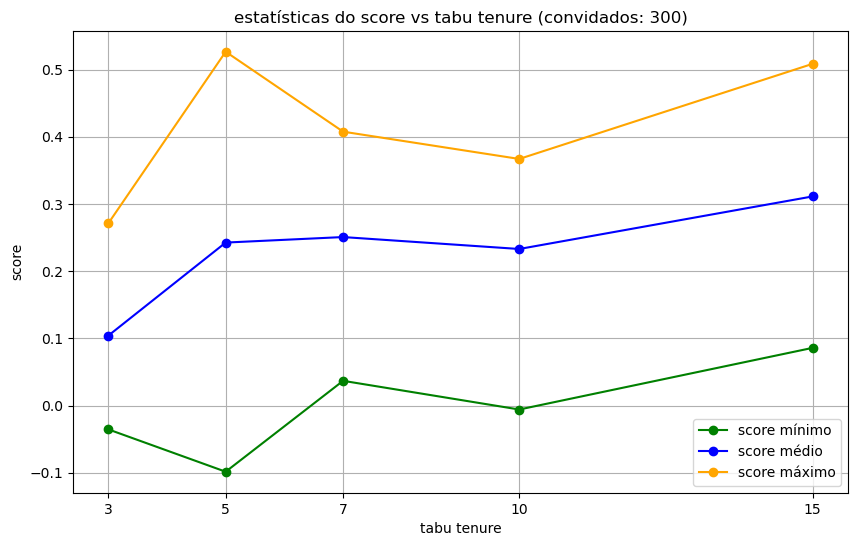

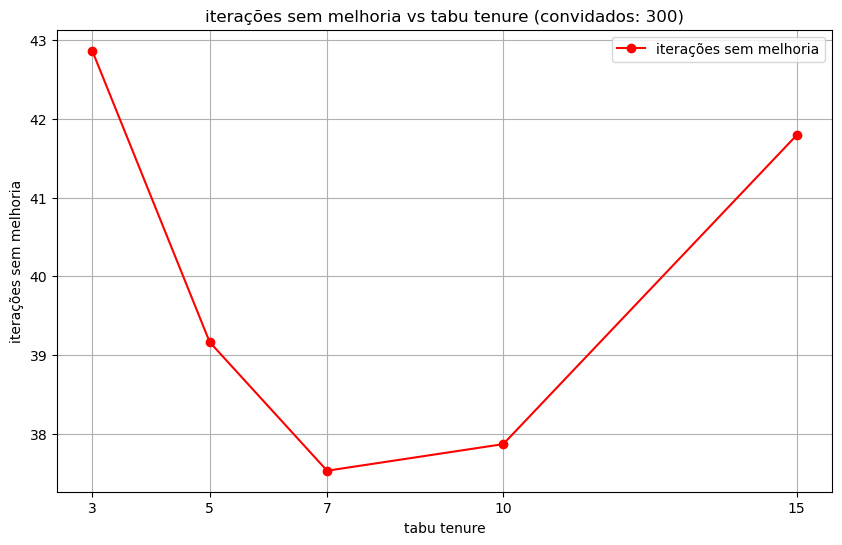

a correr para número de convidados: 100
[[15, 51, 26, 49, 84, 74, 25, 35, 21, 90], [30, 66, 59, 54, 96, 16, 43, 48, 44, 17], [34, 14, 24, 37, 92, 73, 8, 18, 88, 2], [39, 99, 87, 63, 55, 95, 79, 41, 72, 32], [58, 65, 80, 19, 5, 12, 69, 36, 82, 42], [89, 22, 29, 83, 0, 10, 38, 57, 67, 28], [13, 71, 61, 53, 4, 70, 31, 62, 94, 23], [20, 9, 93, 60, 6, 85, 27, 3, 75, 45], [7, 78, 1, 97, 11, 76, 86, 50, 68, 46], [47, 52, 56, 40, 98, 77, 81, 91, 33, 64]]
[[97, 66, 72, 39, 23, 26, 46, 88, 69, 58], [44, 85, 76, 56, 3, 73, 41, 35, 7, 25], [50, 42, 89, 31, 40, 92, 6, 98, 57, 87], [11, 67, 60, 8, 86, 70, 52, 28, 84, 65], [20, 12, 96, 61, 5, 49, 9, 90, 10, 1], [55, 77, 53, 14, 93, 29, 54, 99, 2, 95], [82, 21, 80, 30, 0, 4, 94, 36, 64, 16], [19, 51, 59, 63, 27, 79, 71, 33, 24, 48], [22, 62, 45, 37, 78, 17, 43, 83, 32, 38], [18, 75, 13, 74, 47, 68, 91, 34, 15, 81]]
[[49, 43, 41, 83, 15, 89, 23, 82, 21, 18], [71, 32, 20, 76, 14, 8, 50, 90, 7, 61], [1, 52, 77, 87, 9, 97, 56, 66, 69, 63], [29, 51, 99, 79

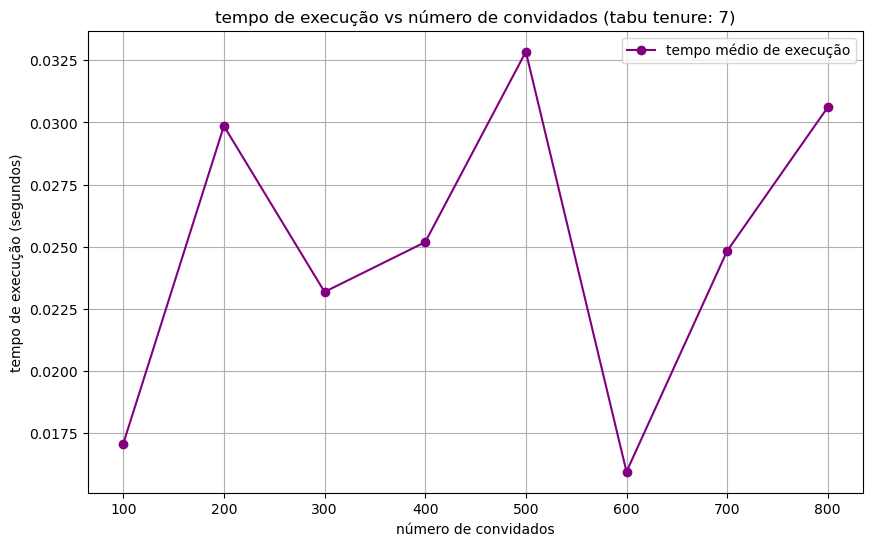

In [319]:
import time
import matplotlib.pyplot as plt
import random

# definir parâmetros iniciais
tabu_tenures = [3, 5, 7, 10, 15]  # diferentes tamanhos da tabu tenure
num_runs_per_tenure = 5  # número de execuções por tenure
seats_per_table = 10  # número de lugares por mesa
guests = [100, 200, 300, 400, 500, 600, 700, 800]  # diferentes números de convidados

# criar dicionário para guardar os resultados
results = {tenure: {'scores': [], 'times': [], 'avg_no_improve': []} for tenure in tabu_tenures}

# primeira análise: variar a tabu tenure
for tenure in tabu_tenures:
    print(f"a correr para tabu tenure: {tenure}")
    for run in range(num_runs_per_tenure):
        start_time = time.time()
        
        # chamar a função tabu_search_adv_adv (deves garantir que ela nunca devolve none)
        solution, final_score, avg_no_improve = tabu_search_adv(preferences_300, seats_per_table, max_iterations=10000, tabu_tenure=tenure)
        
        end_time = time.time()
        
        # guardar os resultados
        results[tenure]['scores'].append(final_score)
        results[tenure]['times'].append(end_time - start_time)
        results[tenure]['avg_no_improve'].append(avg_no_improve)

# calcular estatísticas
min_scores = [min(results[tenure]['scores']) for tenure in tabu_tenures]
max_scores = [max(results[tenure]['scores']) for tenure in tabu_tenures]
mean_scores = [sum(results[tenure]['scores']) / num_runs_per_tenure for tenure in tabu_tenures]
avg_no_improve = [
    sum(x for x in results[tenure]['avg_no_improve'] if x is not None) / num_runs_per_tenure
    for tenure in tabu_tenures
]
avg_exec_times = [sum(results[tenure]['times']) / num_runs_per_tenure for tenure in tabu_tenures]
# gráfico: estatísticas dos scores
plt.figure(figsize=(10, 6))
plt.plot(tabu_tenures, min_scores, marker='o', color='green', label='score mínimo')
plt.plot(tabu_tenures, mean_scores, marker='o', color='blue', label='score médio')
plt.plot(tabu_tenures, max_scores, marker='o', color='orange', label='score máximo')
plt.title("estatísticas do score vs tabu tenure (convidados: 300)")
plt.xlabel("tabu tenure")
plt.ylabel("score")
plt.legend()
plt.grid(True)

plt.xticks(tabu_tenures)

plt.show()
# gráfico: média de iterações sem melhoria
plt.figure(figsize=(10, 6))
plt.plot(tabu_tenures, avg_no_improve, marker='o', color='red', label='iterações sem melhoria')
plt.title("iterações sem melhoria vs tabu tenure (convidados: 300)")
plt.xlabel("tabu tenure")
plt.ylabel("iterações sem melhoria")
plt.legend()
plt.grid(True)
plt.xticks(tabu_tenures)  

plt.show()

# segunda análise: variar o número de convidados
tabu_tenure = 7  # fixar a tenure para esta parte
num_runs_per_guest = 3  # número de execuções por quantidade de convidados

# criar novo dicionário de resultados
results = {guest: {'times': []} for guest in guests}

for guest in guests:
    print(f"a correr para número de convidados: {guest}")
    for run in range(num_runs_per_guest):
        start_time = time.time()
        
        solution, final_score, avg_no_improve = tabu_search_adv(matrix_, seats_per_table, max_iterations=10000, tabu_tenure=tabu_tenure)
        
        end_time = time.time()
        
        results[guest]['times'].append(end_time - start_time)

# calcular tempos médios de execução
avg_exec_times = [sum(results[guest]['times']) / num_runs_per_guest for guest in guests]

# gráfico: tempo de execução vs número de convidados
plt.figure(figsize=(10, 6))
plt.plot(guests, avg_exec_times, marker='o', color='purple', label='tempo médio de execução')
plt.title(f"tempo de execução vs número de convidados (tabu tenure: {tabu_tenure})")
plt.xlabel("número de convidados")
plt.ylabel("tempo de execução (segundos)")
plt.legend()
plt.grid(True)
plt.show()



[[86, 77, 11, 98, 9, 94, 82, 37, 76, 48], [88, 79, 30, 1, 61, 24, 19, 56, 93, 40], [59, 97, 41, 73, 72, 85, 35, 44, 49, 46], [14, 45, 51, 12, 6, 50, 21, 5, 75, 91], [64, 99, 36, 32, 7, 34, 2, 16, 87, 69], [62, 96, 43, 81, 66, 4, 90, 27, 83, 26], [78, 22, 38, 84, 23, 68, 53, 13, 60, 54], [8, 3, 18, 20, 71, 67, 70, 39, 92, 29], [52, 10, 28, 55, 47, 42, 57, 63, 89, 58], [0, 31, 74, 17, 95, 15, 65, 25, 80, 33]]
[[50, 98, 55, 23, 74, 84, 16, 28, 27, 2], [3, 54, 24, 36, 99, 20, 33, 80, 69, 21], [94, 6, 1, 52, 25, 41, 95, 7, 60, 13], [18, 45, 78, 37, 92, 42, 91, 32, 90, 57], [22, 58, 82, 71, 34, 73, 97, 72, 29, 93], [11, 76, 14, 19, 96, 8, 61, 43, 26, 53], [9, 64, 68, 62, 70, 81, 48, 75, 85, 59], [10, 83, 46, 38, 17, 5, 31, 88, 66, 12], [40, 77, 47, 89, 0, 79, 87, 49, 63, 65], [4, 51, 86, 44, 56, 30, 15, 35, 67, 39]]
[[40, 92, 8, 13, 14, 76, 62, 29, 2, 25], [65, 99, 21, 50, 79, 9, 52, 43, 17, 74], [36, 10, 30, 69, 20, 57, 37, 46, 34, 67], [81, 53, 26, 58, 32, 98, 73, 91, 59, 55], [90, 38, 47,

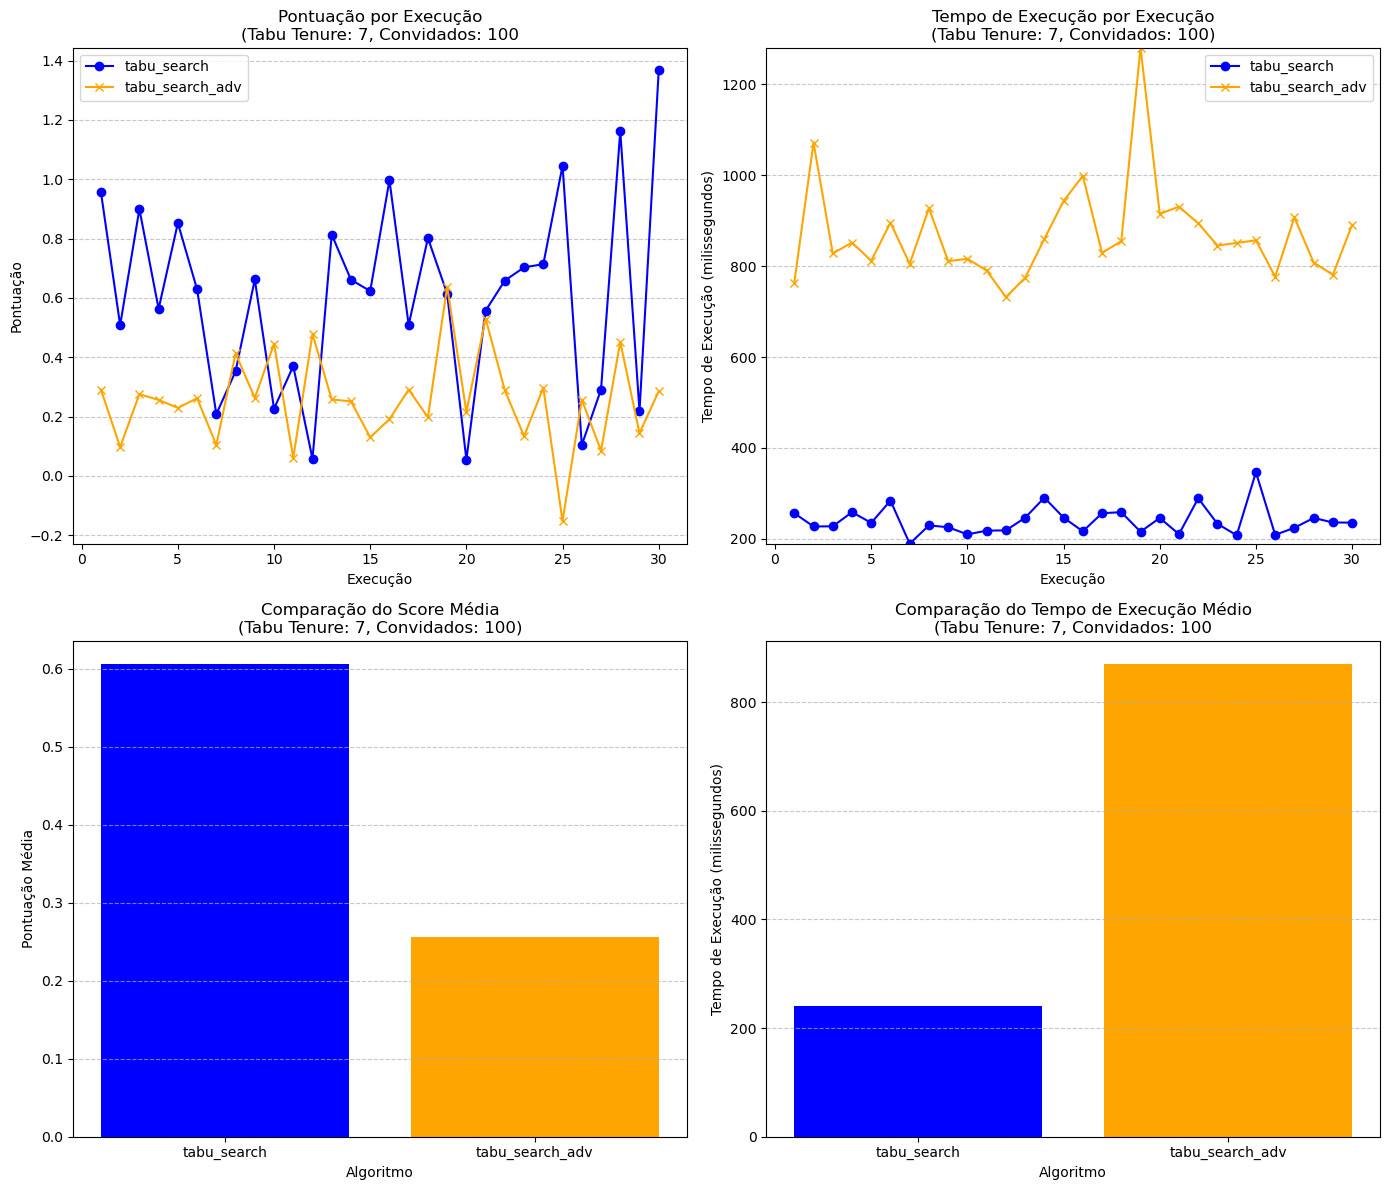

Tabu Search - Pontuação Média: 0.6060, Tempo de Execução Médio: 239.9693 ms
Tabu Search Adv - Pontuação Média: 0.2555, Tempo de Execução Médio: 870.0281 ms


In [317]:
import time
import matplotlib.pyplot as plt
import numpy as np

#experiência: com esta matriz de 100 guests, o advanced_get_neighbor não melhora -> hill climbing
# Parâmetros
seats_per_table = 10
tabu_tenure = 7  # Tenure fixo do tabu para a comparação
num_runs = 30  # Número aumentado de execuções para uma comparação mais robusta
max_iterations = 100000  # Número maior de iterações para aumentar o tempo total de execução

results_tabu_search = {'scores': [], 'times': []}
results_tabu_search_adv = {'scores': [], 'times': []}

for run in range(num_runs):
    start_time = time.time()
    
    for _ in range(10): 
        solution, final_score, avg_no_improve = tabu_search(matrix_, seats_per_table, max_iterations=max_iterations, tabu_tenure=tabu_tenure)
    
    end_time = time.time()
    results_tabu_search['scores'].append(final_score)
    results_tabu_search['times'].append((end_time - start_time) * 1000)  

    start_time = time.time()
    
    for _ in range(10): 
        solution, final_score, avg_no_improve = tabu_search_adv(preferences_300, seats_per_table, max_iterations=max_iterations, tabu_tenure=tabu_tenure)
    
    end_time = time.time()
    results_tabu_search_adv['scores'].append(final_score)
    results_tabu_search_adv['times'].append((end_time - start_time) * 1000)  # Tempo em milissegundos

avg_score_tabu_search = np.mean(results_tabu_search['scores'])
avg_time_tabu_search = np.mean(results_tabu_search['times'])
avg_score_tabu_search_adv = np.mean(results_tabu_search_adv['scores'])
avg_time_tabu_search_adv = np.mean(results_tabu_search_adv['times'])


fig, ax = plt.subplots(2, 2, figsize=(14, 12))

ax[0, 0].plot(range(1, num_runs+1), results_tabu_search['scores'], label='tabu_search', color='blue', marker='o')
ax[0, 0].plot(range(1, num_runs+1), results_tabu_search_adv['scores'], label='tabu_search_adv', color='orange', marker='x')
ax[0, 0].set_title(f"Pontuação por Execução\n(Tabu Tenure: {tabu_tenure}, Convidados: 100")
ax[0, 0].set_xlabel("Execução")
ax[0, 0].set_ylabel("Pontuação")
ax[0, 0].legend()
ax[0, 0].grid(True, axis='y', linestyle='--', alpha=0.7)

ax[0, 1].plot(range(1, num_runs+1), results_tabu_search['times'], label='tabu_search', color='blue', marker='o')
ax[0, 1].plot(range(1, num_runs+1), results_tabu_search_adv['times'], label='tabu_search_adv', color='orange', marker='x')
ax[0, 1].set_title(f"Tempo de Execução por Execução\n(Tabu Tenure: {tabu_tenure}, Convidados: 100)")
ax[0, 1].set_xlabel("Execução")
ax[0, 1].set_ylabel("Tempo de Execução (milissegundos)")
ax[0, 1].legend()
ax[0, 1].grid(True, axis='y', linestyle='--', alpha=0.7)

min_time = min(min(results_tabu_search['times']), min(results_tabu_search_adv['times']))
max_time = max(max(results_tabu_search['times']), max(results_tabu_search_adv['times']))
ax[0, 1].set_ylim([min_time - 0.001, max_time + 0.001]) 
ax[1, 0].bar(['tabu_search', 'tabu_search_adv'], [avg_score_tabu_search, avg_score_tabu_search_adv], color=['blue', 'orange'])
ax[1, 0].set_title(f"Comparação do Score Média\n(Tabu Tenure: {tabu_tenure}, Convidados: 100)")
ax[1, 0].set_ylabel("Pontuação Média")
ax[1, 0].set_xlabel("Algoritmo")
ax[1, 0].grid(True, axis='y', linestyle='--', alpha=0.7)

ax[1, 1].bar(['tabu_search', 'tabu_search_adv'], [avg_time_tabu_search, avg_time_tabu_search_adv], color=['blue', 'orange'])
ax[1, 1].set_title(f"Comparação do Tempo de Execução Médio\n(Tabu Tenure: {tabu_tenure}, Convidados: 100")
ax[1, 1].set_ylabel("Tempo de Execução (milissegundos)")
ax[1, 1].set_xlabel("Algoritmo")
ax[1, 1].grid(True, axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

print(f"Tabu Search - Pontuação Média: {avg_score_tabu_search:.4f}, Tempo de Execução Médio: {avg_time_tabu_search:.4f} ms")
print(f"Tabu Search Adv - Pontuação Média: {avg_score_tabu_search_adv:.4f}, Tempo de Execução Médio: {avg_time_tabu_search_adv:.4f} ms")


In [ ]:
tabu_search(test_preference_matrix, 3, max_iterations=1000, tabu_tenure=7, max_no_improve=100)

GENETIC ALGORITHM (NEW VERSION)

The use of the solution representation used so far made the implementation of the crossover function difficult. In the implemented algorithm, we selected tables randomly from each parent, but if a table contained a guest already assigned in the descendant, it was discarded, and the unallocated guests were randomly distributed across the remaining tables.

This could cause good solutions to get stuck, so we adopted a new approach where the solution is represented by a single list, where the indices correspond to the guests and the values indicate the tables to which they have been assigned. In this way, we can select parts from each parent, with an optimization function adjusting the guest assignments as needed.

Conversion to the previous solution representation to make it easier to visualize the guests at the tables.

In [ ]:
from collections import defaultdict

def solution_to_tables(solution):
    mesas = defaultdict(list)
    for convidado, mesa in enumerate(solution):
        mesas[mesa].append(convidado)
    return list(mesas.values())


m=solution_to_tables([0, 0, 0, 1, 1, 1, 2, 2]
)

for i in m:
    print(i)

In [ ]:
def evaluate_table_(table, matrix):
    score = 0
    for guest in table:
        for neighbor in table:
            if guest != neighbor:
                score += matrix[guest][neighbor]

    return score

def standard_deviation_(tables, preference_matrix):
    solution = solution_to_tables(tables)
    score_tables = []
    total_score=0
    for table in solution:
        current_score = evaluate_table_(table, preference_matrix)
        total_score += current_score
        score_tables.append(current_score)
    average = total_score/len(solution)

    std_sum=0
    for score in score_tables:
        std_sum += (score-average)**2
    
    std = math.sqrt(std_sum/len(solution))
    return std

def evaluate_solution_(solution, preference_matrix):
    average = average_tables_(solution, preference_matrix)  #not optimal
    std = standard_deviation_(solution, preference_matrix) + 1  # shift de 1 para nunca poder haver divisao por 0
    return (average/std)
    

def average_tables_(solution, matrix):
    tables = solution_to_tables(solution)
    score = 0
    for table in tables:
        score += evaluate_table_(table, matrix)
    average = score / len(tables)
    return average

In [ ]:
def generate_population_(pop_size, preference_matrix, seatsPerTable):
    num_guests = len(preference_matrix)
    num_tables = (num_guests + seatsPerTable - 1) // seatsPerTable
    population = []
    
    for _ in range(pop_size):
        guests = list(range(num_guests))
        random.shuffle(guests)
        individual = [0] * num_guests
        for i, guest in enumerate(guests):
            mesa = i // seatsPerTable
            individual[guest] = mesa
        population.append(individual)
    
    return population

In [ ]:
def get_neighbour_(curr_arrangement):
    neighbor = curr_arrangement[:]
    num_guests = len(neighbor)

    # Escolher dois convidados diferentes
    guest1 = random.randint(0, num_guests - 1)
    guest2 = random.randint(0, num_guests - 1)
    while guest1 == guest2 or neighbor[guest1] == neighbor[guest2]:
        guest2 = random.randint(0, num_guests - 1)

    # Trocar as mesas atribuídas entre os dois convidados
    neighbor[guest1], neighbor[guest2] = neighbor[guest2], neighbor[guest1]

    return neighbor

def advanced_get_neighbour_(curr_arrangement):
    percentage = 0.05   #adjustable
    totalSeats = len(curr_arrangement)
    #randomly chooses from 1 guest to 5% of total guest population to be swaped
    toBeChanged = random.choices(range(1, int(totalSeats*percentage)+2))
    
    neighbour_arrangement = curr_arrangement
    for nguests in range(toBeChanged[0]):
        neighbour_arrangement = get_neighbour_(neighbour_arrangement)
    return neighbour_arrangement

### Random Crossover and Optimization Functions

This block of code contains functions that implement a random crossover between two parents and optimize the resulting children based on a preference matrix.

1. **`random_crossover_`**: Performs a crossover between two parent solutions by selecting a random cut point and combining the two parents to generate two children. After the crossover, the children are optimized to ensure the tables are filled according to the seating constraints and guest preferences.

2. **`optimize_child`**: Optimizes a child solution by adjusting the guest assignments across tables. The function first checks for overfilled tables (with more guests than allowed) and underfilled tables (with space available). It moves guests with the least contribution from overfilled tables to underfilled tables to achieve a more balanced solution.

3. **`contribution_to_table`**: Calculates the contribution of a guest to a table, which is based on the sum of the preference scores between the guest and other guests at the same table. Guests who contribute more to the table are less likely to be moved during optimization.

These functions work together to generate and optimize new solutions by ensuring that the guests are distributed in a way that respects the seating constraints and maximizes the overall satisfaction based on the preference matrix.


In [ ]:
def random_crossover_(parent1, parent2, preference_matrix, seatsPerTable):
    num_guests = len(parent1)
    num_tables = (num_guests + seatsPerTable - 1) // seatsPerTable

    cut = random.randint(1, num_guests - 2)

    child1 = parent1[:cut] + parent2[cut:]
    child2 = parent2[:cut] + parent1[cut:]

    child1 = optimize_child(child1, num_tables, seatsPerTable, preference_matrix)
    child2 = optimize_child(child2, num_tables, seatsPerTable, preference_matrix)

    return child1, child2


def optimize_child(child, num_tables, seatsPerTable, preference_matrix):
    table_counts = Counter(child)

    # Mesas com mais do que o permitido
    overfilled = {mesa: count for mesa, count in table_counts.items() if count > seatsPerTable}
    # Mesas com espaço livre
    underfilled = {mesa: seatsPerTable - table_counts.get(mesa, 0) for mesa in range(num_tables) if table_counts.get(mesa, 0) < seatsPerTable}

    if not overfilled:
        return child 

    # Identificar os convidados a mover (os que menos contribuem)
    guest_to_move = []
    for mesa in overfilled:
        guests = [i for i, m in enumerate(child) if m == mesa]
        guests_sorted = sorted(guests, key=lambda g: contribution_to_table(g, child, preference_matrix), reverse=True)
        needed = overfilled[mesa] - seatsPerTable
        guest_to_move.extend(guests_sorted[-needed:])  # mover os que contribuem menos

    # Mover os convidados para mesas com espaço
    underfilled_list = list(underfilled.items())  # [(mesa, lugares)]
    idx = 0
    for guest in guest_to_move:
        while idx < len(underfilled_list) and underfilled_list[idx][1] == 0:
            idx += 1
        if idx >= len(underfilled_list):
            break
        mesa_destino = underfilled_list[idx][0]
        child[guest] = mesa_destino
        underfilled_list[idx] = (mesa_destino, underfilled_list[idx][1] - 1)

    return child


def contribution_to_table(guest, solution, matrix):
    mesa = solution[guest]
    same_table = [i for i in range(len(solution)) if i != guest and solution[i] == mesa]
    return sum(matrix[guest][other] + matrix[other][guest] for other in same_table)


In [ ]:
def tournament_select_(population, preference_matrix, tournament_size, exclude=None):
    filtered_population = [ind for ind in population if ind != exclude]

    if len(filtered_population) == 0:
        return exclude 
    tournament_size = min(tournament_size, len(filtered_population))

    selected = random.sample(filtered_population, tournament_size)
    best_solution = max(selected, key=lambda s: evaluate_solution_(s, preference_matrix))
    return best_solution


def roulette_select_(population, preference_matrix, exclude=None):
    filtered_population = [ind for ind in population if ind != exclude]
    fitness_values = np.array([evaluate_solution_(s, preference_matrix) for s in filtered_population])
    total_fitness = np.sum(fitness_values)
    rand_value = np.random.uniform(0, total_fitness)

    cumulative_sum = 0
    for i, fitness in enumerate(fitness_values):
        cumulative_sum += fitness
        if rand_value <= cumulative_sum:
            return filtered_population[i]

In [ ]:
def mutation_(parent, mutation_prob=0.1):
    if random.random() < mutation_prob:  
        return get_neighbour_(parent)
    return parent

In [ ]:
import matplotlib.pyplot as plt

def show_graph(best_scores, avg_scores):
    plt.plot(range(1, len(best_scores) + 1), best_scores, label='Best Individual Score')
    plt.plot(range(1, len(avg_scores) + 1), avg_scores, linestyle='--', color='red', label='Average Population Score')
    plt.xlabel('Iteration')
    plt.ylabel('Score')
    plt.title('Algorithm Performance')
    plt.legend()
    plt.show()

Runs a genetic algorithm to optimize seating arrangements over a given number of iterations, using selection, crossover, and mutation, while tracking and displaying performance statistics.

In [ ]:
def genetic_algorithm_2(num_iterations, population_size, preference_matrix, seatsPerTable):
    start_time = time.time()
        
    
    filled_preference_matrix = fill_matrix(seatsPerTable, preference_matrix)
    population = generate_population_(population_size, filled_preference_matrix, seatsPerTable)
    """print("population[0]: ")
    print(population[0])"""
    best_solution = population[0]
    best_score = evaluate_solution_(population[0], filled_preference_matrix)
    #num_iterations=500

    best_scores = []
    all_scores = []
    avg_scores = []

    for solution in population:
        all_scores.append(evaluate_solution_(solution, filled_preference_matrix))
    

    print(f"Initial solution: {best_solution}, score: {best_score}")

    while(num_iterations > 0):

        #parent1 = tournament_select_( population, filled_preference_matrix, 10)
        parent1 = roulette_select_(population, filled_preference_matrix)
        #parent2 = tournament_select_( population, filled_preference_matrix, 10, parent1)
        parent2 = roulette_select_(population, filled_preference_matrix, exclude=parent1)

        if parent2 is None:
            parent2 = parent1

        #estatisticas para grafico
        avg_score = np.mean(all_scores)
        avg_scores.append(avg_score)
        best_solution = max(population, key=lambda x: evaluate_solution_(x, filled_preference_matrix))
        best_scores.append(evaluate_solution_(best_solution, filled_preference_matrix))


        # Next generation Crossover and Mutation
        child1, child2 = random_crossover_(parent1, parent2, filled_preference_matrix, seatsPerTable)


        child1, child2 = mutation_(child1), mutation_(child2)
        
        population.append(child1)
        population.append(child2)
        all_scores.append(evaluate_solution_(child1, filled_preference_matrix))
        all_scores.append(evaluate_solution_(child2, filled_preference_matrix))
        population.sort(key=lambda sol: evaluate_solution_(sol, filled_preference_matrix), reverse=True)
        population = population[:population_size]

        num_iterations-=1
    
    best_solution= population[0]
    best_score=evaluate_solution_(best_solution, filled_preference_matrix)
    print(f"  Final solution: {best_solution}, score: {best_score}")

    final_solution = solution_to_tables(best_solution)
    num_guests = len(preference_matrix) 
    best_solution = [[guest for guest in table if guest < num_guests] for table in final_solution]


    end_time = time.time()
    print(f"Tempo de execução: {end_time - start_time:.6f} segundos")
    show_graph(best_scores, avg_scores)

    return best_solution

In [ ]:
# MATRIX USADA PRA GRAFICOS POWERPOINT

matrix_ = [[0, -74, 56, -86, 60, 71, 22, 99, 89, 62, -58, 9, -66, 91, 9, 86, -47, -28, -74, 13, -80, 34, 56, -57, 54, 46, 54, 56, -36, 1, -3, -97, -46, 47, 71, -68, 52, -80, -97, 14, -48, -81, 71, -25, 33, 36, 62, 98, 91, -68, 30, -22, 30, 31, -2, -32, 15, 3, -32, 66, -9, 13, -29, -43, 39, -98, -46, -67, -44, -63, 82, -4, -100, -88, 39, 25, -76, -33, -78, 56, 45, 63, 42, -94, -29, 60, -96, 63, 15, 22, -65, -62, 18, -58, 66, -7, 64, -67, 30, -100], [-74, 0, 99, 11, -38, 70, -87, -76, -34, 43, -24, 36, -11, 55, -25, -70, 55, 70, -93, 94, 57, -39, -29, -76, 85, 88, 17, -98, 64, -65, 31, -67, -8, -94, -2, 42, -73, 66, -96, -99, -6, -81, -67, -56, 5, -50, 49, -88, -46, -21, 57, 83, -8, -23, 26, -31, -52, -33, -8, 33, 61, -41, -88, -94, 77, -64, 64, 3, 37, -62, -68, -86, 65, 61, -16, 11, 57, -78, 32, -95, 83, 13, 31, 4, 24, 63, -73, 30, -92, -98, 99, -8, -34, -75, 24, -12, 22, 48, -55, 88], [56, 99, 0, -98, 63, 42, 26, -93, -42, -38, -9, 86, -93, -59, 75, -22, -35, -55, -76, -13, -42, 67, 72, -13, 8, 8, -12, -21, -81, 92, 32, -71, 60, 72, -52, 90, -69, 33, -18, -76, 19, -59, 62, 14, -87, -65, 5, 68, -94, 79, -68, -59, -48, -51, 17, -60, -56, 72, 55, -18, 42, 57, 71, 9, -95, -62, 58, 20, 47, 61, -25, -79, 64, -97, 96, 53, 10, 6, -40, -4, 80, 26, -96, -14, -35, 35, -48, 73, -36, -4, -3, 50, -9, 17, -24, 68, 65, -46, 72, 29], [-86, 11, -98, 0, 19, 54, 88, 13, -13, 87, -78, 27, 83, 6, 18, 39, -73, -39, 5, -44, -88, -78, 12, -74, 44, -84, 21, -53, -9, -59, 68, 38, 81, 58, 63, -79, 49, 90, -80, 28, -32, -41, -70, -68, -90, -69, -64, -29, 64, -95, -23, 14, 39, -30, -20, 23, 80, 33, 69, 59, -44, 90, -62, -95, 55, -52, 29, 82, -7, -49, 63, -67, -52, 47, 7, -53, -36, 8, 98, 29, -31, 97, -23, -47, 65, 76, 85, 47, -32, 91, -85, -34, -62, -36, -1, -32, -74, -71, 63, 37], [60, -38, 63, 19, 0, 83, 51, 24, 51, -64, -83, 58, 93, 88, 97, -72, -4, 19, -32, 4, -80, -51, -59, -68, -28, 9, 17, 79, 54, 78, 85, 66, 32, -34, 97, -93, -69, 10, -40, 57, -94, 39, -36, 56, -74, -63, 3, 83, 72, 94, 13, -40, -79, 6, -81, -48, -74, 57, -45, -98, 83, -37, -82, -9, 80, -37, -7, 24, 7, -67, 11, 59, 46, -57, -55, -56, -35, -23, -7, -88, 89, -66, -97, -96, 53, -79, -11, 82, -78, -74, 45, 98, 95, 4, 53, 21, -75, 0, -78, 32], [71, 70, 42, 54, 83, 0, -84, -19, -38, -25, 39, 36, -17, 37, 41, 83, 30, 91, 8, 61, 51, -51, -31, 73, 2, -82, -82, -77, -23, 55, -31, -39, -89, -27, -71, -34, 2, -90, 41, -84, -59, 10, -31, -99, -82, -78, 85, -10, 92, 28, -87, -70, -14, -63, -41, -17, 71, 26, 26, -4, -4, -97, 24, 11, 38, -89, 1, 61, -28, -67, -34, 51, -7, -50, 88, -58, 68, 54, -79, -4, 92, 56, 30, -12, 17, 20, 93, 99, -47, -91, -70, -40, 48, -69, -3, -71, 36, -52, 37, -78], [22, -87, 26, 88, 51, -84, 0, 20, 50, -57, -18, 89, 65, 6, -8, -81, -34, 0, -71, -2, 87, 9, 8, -34, 59, -97, -85, 39, 63, 55, -73, 94, -39, -21, -80, -73, -63, -69, -84, 94, -2, -1, 52, -70, -60, -14, -72, -37, 92, -46, -56, -18, -75, -29, 59, 92, -77, -96, 28, 76, -66, 54, -88, 47, -21, -96, -68, 24, 27, -32, -61, -91, 86, -20, 92, 20, -38, -59, 14, -92, 19, 8, 76, -13, -81, -16, -86, 94, 21, 35, 12, -13, 61, -86, 19, 36, -63, -74, -32, -2], [99, -76, -93, 13, 24, -19, 20, 0, 8, 66, 9, -98, -87, 51, -49, -56, 70, -21, 99, 29, -56, 12, -10, 61, 82, -11, -30, 28, 4, 56, -18, 83, -51, -2, 36, 76, -56, -16, 43, 64, -36, -27, 55, 88, 8, -2, -65, 47, 64, 45, 64, -17, 29, -100, -50, 63, -43, -8, -1, 26, -75, 96, -82, -58, 35, 30, -100, -91, -37, 32, -94, -76, -69, -48, -21, 75, -32, -24, 62, 15, 86, -37, -74, -85, -25, 20, -77, -61, -98, -100, 14, 71, 23, 94, 35, -88, -26, 71, -79, -12], [89, -34, -42, -13, 51, -38, 50, 8, 0, -2, -33, 72, 2, -32, 23, 22, -43, 59, 41, 31, -91, 59, 3, -58, 36, 56, -43, 54, -16, 96, 23, 40, 30, 75, 0, 56, -19, 71, 94, -59, 73, -21, -39, -100, -35, 67, -57, -13, -30, -74, 7, 91, 70, 15, 89, 22, -53, 28, -29, 44, -41, 48, -18, 54, -13, 30, -88, 29, -68, 7, 92, 38, -41, -54, 56, -30, -14, -81, 28, 39, -33, -3, 58, 70, 50, 55, -3, 35, 45, 69, 56, -36, -22, 54, -8, -46, 82, 50, 34, 56], [62, 43, -38, 87, -64, -25, -57, 66, -2, 0, 10, -44, 14, -28, -73, -66, 23, 10, -61, -64, -36, 97, -18, 50, -32, -83, -67, -71, -63, 78, -38, -72, -19, -92, -40, -56, 60, -54, -87, 35, 59, -78, 24, -81, -29, -6, -19, -15, -19, -41, -3, 19, 37, 39, 6, -59, 38, -7, -31, -11, 95, -46, 58, 11, -38, -56, 17, -60, 37, -96, -24, -54, 36, 11, -73, 99, 60, -93, -57, -81, 31, 98, -68, 72, -50, 44, 40, 23, -22, 94, 5, -47, 21, -69, -24, -44, 23, -41, 20, -33], [-58, -24, -9, -78, -83, 39, -18, 9, -33, 10, 0, 17, -7, -75, 31, -87, 48, -83, -59, -55, -17, -98, 96, -30, -5, 70, -91, 26, 47, 14, -41, -40, 89, -37, -5, -52, -76, 0, 84, -9, 15, -8, 8, 81, -20, -86, -59, -37, -66, 63, 93, -3, 71, -30, -9, 80, 57, 10, -49, -99, -10, 1, 90, 7, -91, -4, 87, -2, 69, 87, 5, 19, 53, 53, -62, 93, -64, 17, 97, -30, 83, -68, 71, -34, 23, -57, -23, 0, -91, -52, -7, -3, 58, -41, -47, 72, -94, 67, -95, 8], [9, 36, 86, 27, 58, 36, 89, -98, 72, -44, 17, 0, -39, 11, -61, -31, -89, -20, 67, -97, 78, -49, 27, 49, -60, -66, 44, -33, -25, 12, 38, 66, -64, -65, -12, 49, 3, 41, 1, 12, -22, -24, -53, 81, 41, -10, -37, 66, 12, 45, 86, 82, -92, -21, -38, 84, 10, 57, 62, -41, -20, 37, 38, -93, 32, -69, -16, -2, -27, -71, -23, 0, -27, 62, 6, -99, 99, -49, -2, 31, -9, -64, -29, 37, -39, -88, 97, 39, -39, 64, -95, -49, -53, 95, -15, -99, -76, -37, 82, -57], [-66, -11, -93, 83, 93, -17, 65, -87, 2, 14, -7, -39, 0, -46, -33, -55, -68, 57, 28, -94, -90, -69, -83, -82, 60, -36, -91, 12, 62, -65, 44, 30, 6, 26, 99, 0, -45, 79, -40, 76, -54, -26, -30, 36, -34, -89, 70, 7, 15, -4, 45, 58, -78, -32, 48, -55, 17, 30, 55, -49, -97, 44, -81, -99, 23, -4, 27, -47, -67, -68, -38, 89, -21, -36, 24, 8, -63, -28, 61, -32, 57, 89, -37, -69, -49, -58, 86, 48, -96, 60, -100, 28, -48, 72, -56, 46, -62, 6, -32, -92], [91, 55, -59, 6, 88, 37, 6, 51, -32, -28, -75, 11, -46, 0, -80, -72, -18, -95, -54, -57, 76, -3, 30, -77, 49, -5, 98, -74, 21, 33, -16, 25, -41, 50, 40, 65, 44, 78, 34, 45, 34, 89, 41, -9, 10, 88, 41, 51, -97, -46, 46, 93, -27, 85, 14, 29, -94, -17, -28, -17, -82, -78, -79, 93, 62, 89, -5, 94, -50, -39, -68, 39, 65, -14, -20, 42, -75, -19, 2, -67, -61, -87, 9, 62, 80, 55, -29, 71, 49, 0, 48, 64, -39, 23, 17, -8, -38, 37, -74, 60], [9, -25, 75, 18, 97, 41, -8, -49, 23, -73, 31, -61, -33, -80, 0, 8, -11, -44, -86, 17, -41, 36, 20, -89, 17, -72, 67, -35, 92, -11, 57, -82, -16, 31, 11, -86, 31, 3, 35, -70, 34, -19, -43, -2, -15, 46, -64, -20, -39, 78, 27, 79, 55, 71, 47, -43, 58, -15, -26, -37, -2, -100, -46, 42, -94, 86, -34, -60, -36, 86, 51, 88, -99, 71, -86, -19, 23, -93, 44, -81, 84, 21, 26, -42, 12, -98, 7, 51, -7, 66, 77, 87, 79, 31, 20, 89, 12, 27, -65, 45], [86, -70, -22, 39, -72, 83, -81, -56, 22, -66, -87, -31, -55, -72, 8, 0, -5, 86, 81, -67, 47, 47, 49, -41, -82, 21, -17, -74, -18, 40, 16, -47, -73, -64, -29, 12, -41, -30, -37, -60, 3, -65, -50, 36, 64, 49, -76, 94, 12, -65, -85, -99, 14, -66, -1, -47, 27, 20, -44, 41, -50, 8, 75, 19, 21, -36, 63, 69, -62, 36, 78, -25, -46, 46, -46, 4, -55, 74, -59, 86, -18, 30, 87, 63, 16, 77, -93, -4, -43, 93, -79, -42, 38, 0, 55, 6, -70, 19, -3, 83], [-47, 55, -35, -73, -4, 30, -34, 70, -43, 23, 48, -89, -68, -18, -11, -5, 0, -10, 12, 59, 73, -41, 50, -33, 72, 75, 40, 44, 85, 33, 79, -48, -61, 77, 36, 34, 23, -89, 18, 82, 7, -55, 47, -69, 81, -34, -42, -10, -3, 35, 95, 41, -71, -80, -96, 39, 33, 88, 60, 93, 31, -33, -25, -19, -58, -44, -56, -69, 5, 33, -96, -94, 12, -38, -28, -71, 65, -43, 93, 61, -52, 52, -12, -24, 76, 75, -38, -35, 91, 44, -45, 38, -36, 51, 61, -19, 17, 8, 95, 32], [-28, 70, -55, -39, 19, 91, 0, -21, 59, 10, -83, -20, 57, -95, -44, 86, -10, 0, -61, 45, 74, -34, 92, 91, -63, -91, 61, 68, -97, -94, -73, 48, 38, -25, 42, 36, 43, 75, 94, 55, -84, 67, -86, -64, -84, -23, 46, -2, 89, -87, 15, -20, -84, -67, -44, 4, 7, -95, 13, -76, 11, 78, -9, -19, -29, 84, -85, -65, 36, 23, -8, 90, -69, 10, 22, 72, -99, -93, 72, 57, -8, -8, -45, -21, 38, 39, -37, -48, 23, 16, -34, -71, -68, -58, 99, -78, 31, -56, 97, -73], [-74, -93, -76, 5, -32, 8, -71, 99, 41, -61, -59, 67, 28, -54, -86, 81, 12, -61, 0, 93, 12, -61, 76, 65, 41, -58, 64, -54, 14, 86, 90, 97, 74, -66, 67, 49, -16, 7, -24, -3, -86, -12, 34, 10, 81, 46, -58, -62, -10, -26, 77, -95, 98, -16, 99, 13, 3, -18, -92, 21, 84, 97, -79, -20, 70, -2, -94, 34, -72, -80, -85, -3, -67, -95, -75, 22, -61, -37, -85, -51, -90, 0, -46, -32, -33, -91, 7, 47, 81, -27, 0, -38, -87, -41, 36, -42, 16, -94, 89, -58], [13, 94, -13, -44, 4, 61, -2, 29, 31, -64, -55, -97, -94, -57, 17, -67, 59, 45, 93, 0, -91, -51, -5, 27, 99, -72, 65, 43, -13, 12, 51, 57, 66, -66, -24, 85, 5, -17, 16, -90, 88, 12, 21, 71, -83, 83, 12, -92, 33, 65, 1, 90, 86, 74, 77, 70, 6, 98, 82, 67, 0, 23, 52, 38, 39, -68, 49, -87, 21, 27, -90, -2, 90, -29, -13, -28, 45, -98, 63, 44, 33, -62, 21, -2, 10, 69, 57, -73, 71, 10, 87, 17, 21, -12, -79, 31, 86, -95, 87, -40], [-80, 57, -42, -88, -80, 51, 87, -56, -91, -36, -17, 78, -90, 76, -41, 47, 73, 74, 12, -91, 0, -92, 85, -6, 70, 25, -90, 96, -40, 55, 77, 47, 46, 61, 79, 79, 49, 59, -78, 2, -87, -52, -76, -91, 24, 12, -4, 59, -11, -46, -9, 95, 88, 58, 62, 81, 5, -70, -59, 12, 28, 13, 1, -70, 61, 93, -81, 42, 47, 16, 43, -43, -40, 99, 97, -1, 4, -17, -78, 17, 59, 99, -14, -61, -19, 4, -19, 98, 90, -61, 81, -63, -43, 69, -7, -30, -33, 96, -58, 60], [34, -39, 67, -78, -51, -51, 9, 12, 59, 97, -98, -49, -69, -3, 36, 47, -41, -34, -61, -51, -92, 0, -57, 45, 66, 24, 5, -61, -61, 35, -14, 6, 35, -53, 45, -74, -62, 42, -35, -70, 50, -82, -72, -79, 37, -6, -77, 46, -23, 99, -56, -33, 31, -33, -57, 19, 83, 50, 13, 67, -61, 37, 99, 57, -100, 80, -10, -68, -18, 23, -38, -21, -65, 20, -3, -7, 3, 7, 3, 89, -46, -10, 60, -87, -9, -67, -79, -49, 27, 36, -69, 12, -17, -39, -36, -18, -78, -93, -97, -25], [56, -29, 72, 12, -59, -31, 8, -10, 3, -18, 96, 27, -83, 30, 20, 49, 50, 92, 76, -5, 85, -57, 0, -50, 31, 25, -68, 70, 89, 28, -16, -63, 57, 30, -30, 56, -32, -76, 96, -54, 42, 26, -78, 19, -75, -50, -76, -23, 74, -63, -71, -62, 72, 63, -10, 38, -41, -73, 42, -65, -28, 52, -30, -85, 12, 64, 91, 40, 21, -49, 31, -58, -35, -16, 70, -79, -27, -19, 97, -9, -56, -8, 93, 2, 84, 14, -51, -45, 5, 60, -16, -23, 41, 38, 87, -40, 61, -78, 86, 91], [-57, -76, -13, -74, -68, 73, -34, 61, -58, 50, -30, 49, -82, -77, -89, -41, -33, 91, 65, 27, -6, 45, -50, 0, 58, -32, -34, -89, -74, -20, 24, 55, -80, -72, 80, 60, 18, -31, -30, -90, 62, -32, 49, 6, -66, 88, 35, -59, -7, -68, 21, 57, -86, 7, 54, -27, 82, 94, -3, -13, -66, 24, -84, 93, 55, 11, 46, -4, 5, -92, 43, 64, 21, -78, -59, -93, 57, -50, 7, 80, -75, 71, -85, 94, -4, 19, 80, -69, 44, -77, -51, 61, -7, -64, 19, 36, 62, -30, -31, 10], [54, 85, 8, 44, -28, 2, 59, 82, 36, -32, -5, -60, 60, 49, 17, -82, 72, -63, 41, 99, 70, 66, 31, 58, 0, 85, -51, 74, -21, -52, 70, 80, 8, -67, -42, 87, -78, 5, -100, 16, -34, 57, 65, -11, 88, 37, -85, -87, -20, -18, -2, 73, 37, -1, -33, -97, 91, 84, -97, 40, -51, -26, -23, -59, -97, -51, -56, -95, -8, -28, 93, -8, 69, -36, 71, -91, 1, -69, 62, -78, -2, 90, -47, 54, 91, 62, -64, -44, -37, 79, -30, 17, -51, -83, -13, -31, 46, -87, 68, 72], [46, 88, 8, -84, 9, -82, -97, -11, 56, -83, 70, -66, -36, -5, -72, 21, 75, -91, -58, -72, 25, 24, 25, -32, 85, 0, -87, 30, -79, -73, 60, -5, -35, -3, 24, 55, 43, -2, -17, -91, 80, 15, -3, -15, 76, -54, -79, 72, 60, -34, 61, 93, 51, 46, 73, 45, 97, -95, 42, -40, 96, 28, 43, 55, -66, 17, -81, 17, 29, -92, -99, 5, -89, 78, -82, -87, -37, 43, 7, 11, -61, -71, 65, -38, 80, -59, -38, 2, -63, 93, -6, -2, -32, 60, -51, 57, 47, -81, -44, -36], [54, 17, -12, 21, 17, -82, -85, -30, -43, -67, -91, 44, -91, 98, 67, -17, 40, 61, 64, 65, -90, 5, -68, -34, -51, -87, 0, -54, -13, 14, 88, 58, -52, 46, 92, 86, 73, 5, -93, 39, 37, 67, 22, 1, -22, 10, 62, -9, -51, 12, -98, -29, 78, -36, -86, 22, -28, 27, 55, -88, -11, -70, 63, -58, -12, -74, -10, 60, 88, 80, -73, -33, 0, 87, -46, -3, -82, -92, 68, -26, 99, -1, -62, -55, -50, -89, 23, -7, 19, -80, 75, -27, 22, -36, -18, 37, 78, -79, -32, -72], [56, -98, -21, -53, 79, -77, 39, 28, 54, -71, 26, -33, 12, -74, -35, -74, 44, 68, -54, 43, 96, -61, 70, -89, 74, 30, -54, 0, -37, 0, -6, -95, 66, -17, 32, 97, -95, -76, 79, -85, -75, -43, -23, 30, 74, -54, -47, 6, -68, -34, -28, 43, -97, -92, 80, 11, 53, -16, -87, 15, 11, 39, -49, -5, 36, -29, 24, 38, 38, -39, 29, -33, 88, -20, 53, -46, -50, 70, 82, 25, 30, -52, -31, 18, -52, 78, 78, 39, -99, 4, 7, 81, -54, -11, 23, -60, -92, -71, -49, -30], [-36, 64, -81, -9, 54, -23, 63, 4, -16, -63, 47, -25, 62, 21, 92, -18, 85, -97, 14, -13, -40, -61, 89, -74, -21, -79, -13, -37, 0, -55, 55, -49, 27, 65, -36, -52, 37, -5, 63, -71, 68, -61, 38, 83, 48, -69, 94, 78, 37, -28, 16, 13, 35, 73, 10, -40, 64, 64, -60, -11, -51, -91, -81, 49, 18, 91, 45, -31, 62, -66, -90, -2, 61, -94, 75, -90, -45, 15, -86, 19, 53, -43, -9, -72, -44, 14, 75, 68, -20, 71, -61, -64, 60, -1, -75, -54, -25, -78, -3, -19], [1, -65, 92, -59, 78, 55, 55, 56, 96, 78, 14, 12, -65, 33, -11, 40, 33, -94, 86, 12, 55, 35, 28, -20, -52, -73, 14, 0, -55, 0, 59, -60, 5, 58, -83, 27, 59, 93, 57, 50, -20, -94, -28, 52, 8, 40, 89, -31, -55, 66, 61, 65, 82, -83, -79, -27, -47, -94, 39, 59, -71, -63, 28, -59, -31, 70, 8, -48, -69, 64, -86, -84, 56, 19, -17, -81, 42, -81, -62, -19, 78, 11, -71, -74, 5, -55, -1, 48, 39, -15, 42, 38, 0, 14, -1, -29, -57, 46, -37, -19], [-3, 31, 32, 68, 85, -31, -73, -18, 23, -38, -41, 38, 44, -16, 57, 16, 79, -73, 90, 51, 77, -14, -16, 24, 70, 60, 88, -6, 55, 59, 0, -98, -31, -35, -89, -87, -48, -46, 2, 95, 9, -74, 91, -78, -71, 69, 56, 79, -61, 55, -72, -88, -6, -61, -51, -98, 65, 44, -29, 25, 46, -9, -27, -72, 54, 51, 96, -99, -61, 30, 48, -99, 14, -15, -72, 85, 29, -3, 68, -8, -29, 13, -87, 84, 58, 38, 72, -100, -68, -1, 78, -55, -99, -73, 39, -75, 51, -26, 98, -37], [-97, -67, -71, 38, 66, -39, 94, 83, 40, -72, -40, 66, 30, 25, -82, -47, -48, 48, 97, 57, 47, 6, -63, 55, 80, -5, 58, -95, -49, -60, -98, 0, -54, -38, -47, -51, 89, 18, -7, -64, 96, 0, -55, 6, -73, -70, -37, 18, 63, -13, 27, 21, -62, -92, 92, 34, 7, 48, -72, 12, 45, -86, -48, -36, 13, 18, -53, 31, -95, -36, 47, -36, -59, -42, 47, 38, 52, 5, 34, 96, -29, 31, 63, -54, -6, -9, -79, 81, 38, 77, 55, 9, -10, 27, 99, 35, 41, 92, -72, 54], [-46, -8, 60, 81, 32, -89, -39, -51, 30, -19, 89, -64, 6, -41, -16, -73, -61, 38, 74, 66, 46, 35, 57, -80, 8, -35, -52, 66, 27, 5, -31, -54, 0, 37, 43, 47, -1, 67, 87, -30, -16, 10, -68, -12, 81, 81, 23, 0, 83, 90, 61, 41, -4, -88, 22, 76, 41, 87, -99, -69, -53, 19, 30, -5, 51, -30, -9, -75, 54, 9, 43, -4, 44, -76, 36, 68, -36, -27, 23, 48, 76, -90, 53, 6, 40, 17, -27, 6, 54, -56, -67, -50, -70, 49, -13, 9, 73, 10, -21, 77], [47, -94, 72, 58, -34, -27, -21, -2, 75, -92, -37, -65, 26, 50, 31, -64, 77, -25, -66, -66, 61, -53, 30, -72, -67, -3, 46, -17, 65, 58, -35, -38, 37, 0, 84, -58, -8, -1, 35, -83, 57, 81, 51, -83, -51, -81, 54, 86, -10, -81, 94, 75, 97, 84, -49, -34, -51, -99, -54, 9, -78, -65, 55, 70, 41, -55, -26, -34, -1, 41, 48, 85, 98, 35, 15, -89, 35, -32, 27, 35, -29, 92, 1, 99, 4, 30, 52, 12, 94, 11, -72, 99, -99, -14, 23, 37, -62, 35, 90, 69], [71, -2, -52, 63, 97, -71, -80, 36, 0, -40, -5, -12, 99, 40, 11, -29, 36, 42, 67, -24, 79, 45, -30, 80, -42, 24, 92, 32, -36, -83, -89, -47, 43, 84, 0, 65, -48, 22, -89, -95, -32, 80, 49, 8, 20, 98, -69, 31, -17, -83, -6, 68, 98, 88, -91, -74, 22, -81, -73, -65, -62, 23, 27, -48, 62, -78, -38, -74, -80, -68, 43, 98, -82, 29, -6, 70, -82, -20, 33, -94, -27, -68, 41, -17, -3, 65, -24, -97, 0, 52, 30, 81, -19, -82, -32, -46, -66, 87, 84, 1], [-68, 42, 90, -79, -93, -34, -73, 76, 56, -56, -52, 49, 0, 65, -86, 12, 34, 36, 49, 85, 79, -74, 56, 60, 87, 55, 86, 97, -52, 27, -87, -51, 47, -58, 65, 0, -51, -16, -19, 54, 16, 7, 39, 89, 77, -23, 38, -59, 69, 69, -5, 41, -22, -21, 42, -27, -100, 98, -83, 58, 52, -1, -36, 37, 66, 6, 8, 23, 77, -6, 93, 96, 71, -88, -79, -93, -21, 18, -22, -37, -43, -75, -19, -3, 69, -4, 19, -62, -94, 80, -4, -24, 78, -37, -90, -45, 89, 93, 32, -74], [52, -73, -69, 49, -69, 2, -63, -56, -19, 60, -76, 3, -45, 44, 31, -41, 23, 43, -16, 5, 49, -62, -32, 18, -78, 43, 73, -95, 37, 59, -48, 89, -1, -8, -48, -51, 0, -68, 63, 97, -42, 15, 85, -29, 2, -27, -2, -27, 22, -94, -66, -62, -66, 22, 7, -67, 90, 85, 21, 75, -61, 44, -44, -94, -20, 3, 60, 3, -60, 28, -5, 85, -59, 13, 18, -65, 30, -66, -2, -1, 46, 45, -38, -94, -92, 17, 83, -71, -42, -67, -63, -29, 24, -86, -3, 18, -83, 62, 55, -49], [-80, 66, 33, 90, 10, -90, -69, -16, 71, -54, 0, 41, 79, 78, 3, -30, -89, 75, 7, -17, 59, 42, -76, -31, 5, -2, 5, -76, -5, 93, -46, 18, 67, -1, 22, -16, -68, 0, -87, -14, 0, 76, -36, -61, -55, 97, 59, -66, -23, -22, -62, -34, -91, 65, 34, 98, 91, 87, 1, -75, 89, 86, -30, 42, 95, 68, -17, 46, -93, 84, -76, 65, 97, 81, 18, -82, -22, -48, 13, 36, 35, -33, 88, -21, 66, -95, 92, 10, -61, -47, 83, -78, -94, -51, -12, 30, 86, 8, 81, -36], [-97, -96, -18, -80, -40, 41, -84, 43, 94, -87, 84, 1, -40, 34, 35, -37, 18, 94, -24, 16, -78, -35, 96, -30, -100, -17, -93, 79, 63, 57, 2, -7, 87, 35, -89, -19, 63, -87, 0, -11, -15, -82, -62, 16, 44, 69, 38, -11, 28, -67, 49, -99, 44, -68, -38, -39, 26, 65, 24, -81, 39, 24, 68, -70, -71, -8, 10, -85, -99, 2, -85, -54, -99, 73, -84, 89, 34, -13, 72, 24, -25, 41, 78, 10, -64, -8, -79, 94, -27, -1, 21, -41, -9, -40, -78, 65, 95, 9, -71, 95], [14, -99, -76, 28, 57, -84, 94, 64, -59, 35, -9, 12, 76, 45, -70, -60, 82, 55, -3, -90, 2, -70, -54, -90, 16, -91, 39, -85, -71, 50, 95, -64, -30, -83, -95, 54, 97, -14, -11, 0, -28, -71, 20, 19, 58, 11, 95, 4, -88, 30, -83, 66, -55, -56, -58, 26, 54, 84, -88, -48, 57, 99, 65, 91, -83, -11, -92, 65, -32, 37, -56, 63, 98, 13, -91, 97, -9, 27, -85, 77, -33, 53, 15, -28, 82, -94, 33, -6, 4, 7, -57, 45, 80, 54, 55, -39, 9, -63, -1, 36], [-48, -6, 19, -32, -94, -59, -2, -36, 73, 59, 15, -22, -54, 34, 34, 3, 7, -84, -86, 88, -87, 50, 42, 62, -34, 80, 37, -75, 68, -20, 9, 96, -16, 57, -32, 16, -42, 0, -15, -28, 0, -34, 74, -23, 8, -49, 17, 81, -33, 16, -85, 20, 26, -100, -69, -1, 26, 65, 14, -89, 81, 9, 1, 64, 18, -27, -70, 13, 95, 70, -16, 25, -88, -4, 85, 1, 43, 7, -65, -19, -34, 16, 45, 73, 63, -95, 14, 63, 37, -86, 31, -93, 29, 15, 8, -94, -50, -76, -90, 54], [-81, -81, -59, -41, 39, 10, -1, -27, -21, -78, -8, -24, -26, 89, -19, -65, -55, 67, -12, 12, -52, -82, 26, -32, 57, 15, 67, -43, -61, -94, -74, 0, 10, 81, 80, 7, 15, 76, -82, -71, -34, 0, -33, -13, -17, -33, -68, -57, 13, 30, 90, -9, -38, 77, 96, -68, 60, 35, -89, -21, 71, -12, 33, -52, -53, 85, 11, -81, -51, 53, 1, 96, -86, 61, 33, 6, 48, 11, 57, -72, -80, 66, 34, -87, 93, 26, -30, 64, 28, 40, 6, -42, 97, -9, 70, 19, -81, 18, -70, -72], [71, -67, 62, -70, -36, -31, 52, 55, -39, 24, 8, -53, -30, 41, -43, -50, 47, -86, 34, 21, -76, -72, -78, 49, 65, -3, 22, -23, 38, -28, 91, -55, -68, 51, 49, 39, 85, -36, -62, 20, 74, -33, 0, 12, 9, 99, 41, -9, -86, 0, -95, -80, 44, -22, -57, 27, 71, 1, 57, 6, 18, -16, -61, 51, -34, -69, -79, 60, -97, 74, 81, -5, -33, 1, -49, 88, -36, -34, 52, 55, -49, 14, 15, 35, -78, 92, 18, -15, 88, 80, 92, -51, -3, 32, -7, 38, -50, -98, -62, -48], [-25, -56, 14, -68, 56, -99, -70, 88, -100, -81, 81, 81, 36, -9, -2, 36, -69, -64, 10, 71, -91, -79, 19, 6, -11, -15, 1, 30, 83, 52, -78, 6, -12, -83, 8, 89, -29, -61, 16, 19, -23, -13, 12, 0, 89, 48, -56, -69, 66, -25, 19, -68, 90, -42, 71, 48, 35, -9, -99, 60, 97, -27, -22, -72, 53, -31, -87, 11, -62, 15, -77, -49, 51, 46, 29, -87, -1, 10, -50, 86, -68, -37, -56, 29, 73, 98, -12, -91, 22, 64, -35, 95, 26, 54, 12, -61, -90, 43, -28, 27], [33, 5, -87, -90, -74, -82, -60, 8, -35, -29, -20, 41, -34, 10, -15, 64, 81, -84, 81, -83, 24, 37, -75, -66, 88, 76, -22, 74, 48, 8, -71, -73, 81, -51, 20, 77, 2, -55, 44, 58, 8, -17, 9, 89, 0, -98, -39, -42, 58, 66, 37, 11, 99, -60, 83, 86, 34, 19, -1, 56, 57, -92, -11, 40, 64, -91, 51, 99, 97, -66, -7, -50, -93, 48, -31, 85, 99, 74, -100, -35, -84, 5, 98, -25, -100, -77, 60, -81, 1, 83, -44, -98, -77, -69, 34, -35, -20, -58, 83, 31], [36, -50, -65, -69, -63, -78, -14, -2, 67, -6, -86, -10, -89, 88, 46, 49, -34, -23, 46, 83, 12, -6, -50, 88, 37, -54, 10, -54, -69, 40, 69, -70, 81, -81, 98, -23, -27, 97, 69, 11, -49, -33, 99, 48, -98, 0, 8, 43, 89, -1, 85, -74, 16, 17, 1, 12, -78, 0, 33, 54, 27, -46, -39, 81, -96, -52, 86, 55, -29, -79, -86, -52, -97, 31, -66, 18, -95, 26, -76, 62, -64, -75, -9, -12, -79, -10, 60, -4, 45, 99, 75, -37, 97, 27, 28, 6, -4, 94, -10, 64], [62, 49, 5, -64, 3, 85, -72, -65, -57, -19, -59, -37, 70, 41, -64, -76, -42, 46, -58, 12, -4, -77, -76, 35, -85, -79, 62, -47, 94, 89, 56, -37, 23, 54, -69, 38, -2, 59, 38, 95, 17, -68, 41, -56, -39, 8, 0, -85, 49, 7, -67, 88, -29, -56, 37, 10, -65, -95, 80, 38, 66, 32, -96, -85, -62, -37, -98, 2, 9, 27, -73, -95, 0, -72, 82, -56, 22, 46, 44, 95, -25, 89, 45, -42, -47, -84, -57, 4, 88, 64, 71, 80, 26, -24, 8, -77, 88, 83, -58, 49], [98, -88, 68, -29, 83, -10, -37, 47, -13, -15, -37, 66, 7, 51, -20, 94, -10, -2, -62, -92, 59, 46, -23, -59, -87, 72, -9, 6, 78, -31, 79, 18, 0, 86, 31, -59, -27, -66, -11, 4, 81, -57, -9, -69, -42, 43, -85, 0, 13, -5, -70, -54, -97, -28, -7, 76, -73, 76, -8, -36, 56, 13, 50, 92, -85, 38, -16, 93, 0, -4, 30, -73, -15, 35, 54, 23, -24, 56, -6, 2, 52, -76, -86, -59, 59, 64, 50, -41, 68, 33, 93, 77, -93, -61, 58, -72, -17, -59, 77, -15], [91, -46, -94, 64, 72, 92, 92, 64, -30, -19, -66, 12, 15, -97, -39, 12, -3, 89, -10, 33, -11, -23, 74, -7, -20, 60, -51, -68, 37, -55, -61, 63, 83, -10, -17, 69, 22, -23, 28, -88, -33, 13, -86, 66, 58, 89, 49, 13, 0, -35, 48, -4, -38, 79, 31, 1, 14, -90, -77, 82, -94, 13, -44, -91, 60, -59, 14, 22, 58, -82, -37, -33, 40, 88, -20, 71, -74, 30, 99, -55, -1, -34, 66, 26, 73, -42, 88, 61, -84, -20, 87, -52, 60, 1, -23, 58, -36, -6, -5, -74], [-68, -21, 79, -95, 94, 28, -46, 45, -74, -41, 63, 45, -4, -46, 78, -65, 35, -87, -26, 65, -46, 99, -63, -68, -18, -34, 12, -34, -28, 66, 55, -13, 90, -81, -83, 69, -94, -22, -67, 30, 16, 30, 0, -25, 66, -1, 7, -5, -35, 0, 75, 69, -87, -31, 45, -51, 30, 95, -84, -31, -57, -50, 2, -63, -50, 88, -74, 97, -82, 74, -33, -10, -99, -83, 4, 33, -82, 21, 32, -64, -53, -56, 20, -78, 75, -90, 79, -73, -81, 44, -23, 69, -49, -53, -13, 54, 70, 62, -45, -14], [30, 57, -68, -23, 13, -87, -56, 64, 7, -3, 93, 86, 45, 46, 27, -85, 95, 15, 77, 1, -9, -56, -71, 21, -2, 61, -98, -28, 16, 61, -72, 27, 61, 94, -6, -5, -66, -62, 49, -83, -85, 90, -95, 19, 37, 85, -67, -70, 48, 75, 0, 81, -28, -30, -32, 48, -28, 6, 4, -55, 14, 21, -28, 43, -3, -39, 17, 25, -38, -34, -82, -42, -17, -14, -31, 44, 5, 17, -20, -18, -70, 57, 29, -62, -12, -19, 81, 91, 15, 44, 99, -11, 28, 59, 56, 38, -48, -80, -40, -40], [-22, 83, -59, 14, -40, -70, -18, -17, 91, 19, -3, 82, 58, 93, 79, -99, 41, -20, -95, 90, 95, -33, -62, 57, 73, 93, -29, 43, 13, 65, -88, 21, 41, 75, 68, 41, -62, -34, -99, 66, 20, -9, -80, -68, 11, -74, 88, -54, -4, 69, 81, 0, -44, 36, 79, 30, 61, -69, 28, 49, -22, -49, 60, -72, -53, 11, 22, 75, 12, -3, 77, 29, -26, -59, 15, 80, -82, -39, 88, 48, -60, 4, -93, 1, 21, 98, -24, 89, 34, -54, -44, 66, 61, -93, 39, 88, -56, 72, -41, 30], [30, -8, -48, 39, -79, -14, -75, 29, 70, 37, 71, -92, -78, -27, 55, 14, -71, -84, 98, 86, 88, 31, 72, -86, 37, 51, 78, -97, 35, 82, -6, -62, -4, 97, 98, -22, -66, -91, 44, -55, 26, -38, 44, 90, 99, 16, -29, -97, -38, -87, -28, -44, 0, -6, -81, 16, 6, -74, -82, 74, 42, -68, 69, 41, -85, 5, 99, -82, -87, 89, -8, 30, 41, 85, 1, -80, -1, -16, 70, 55, -70, -15, -18, -78, 85, 65, -31, -16, 92, 17, -15, -30, 91, -55, -79, -7, 95, -61, -6, 93], [31, -23, -51, -30, 6, -63, -29, -100, 15, 39, -30, -21, -32, 85, 71, -66, -80, -67, -16, 74, 58, -33, 63, 7, -1, 46, -36, -92, 73, -83, -61, -92, -88, 84, 88, -21, 22, 65, -68, -56, -100, 77, -22, -42, -60, 17, -56, -28, 79, -31, -30, 36, -6, 0, 43, -91, 86, -25, 30, 70, -53, -39, -7, 81, -60, 55, 56, 35, -28, -86, -96, -53, 67, -29, -31, 68, -6, 86, -70, 93, -95, 69, 29, -35, 96, -100, 69, -88, -90, 96, 87, 35, -40, -14, 4, -21, 80, 98, -80, -89], [-2, 26, 17, -20, -81, -41, 59, -50, 89, 6, -9, -38, 48, 14, 47, -1, -96, -44, 99, 77, 62, -57, -10, 54, -33, 73, -86, 80, 10, -79, -51, 92, 22, -49, -91, 42, 7, 34, -38, -58, -69, 96, -57, 71, 83, 1, 37, -7, 31, 45, -32, 79, -81, 43, 0, 31, 88, -38, -64, 97, 2, 60, 99, 7, 70, -55, -16, 96, -88, 7, -48, -12, -82, -27, -42, -23, 39, -85, 25, -47, -63, -64, 44, 80, 38, 94, -54, -22, 33, 72, 53, 59, -100, -27, 65, -90, 50, -24, 7, 89], [-32, -31, -60, 23, -48, -17, 92, 63, 22, -59, 80, 84, -55, 29, -43, -47, 39, 4, 13, 70, 81, 19, 38, -27, -97, 45, 22, 11, -40, -27, -98, 34, 76, -34, -74, -27, -67, 98, -39, 26, -1, -68, 27, 48, 86, 12, 10, 76, 1, -51, 48, 30, 16, -91, 31, 0, 72, -95, -74, 57, -73, 89, -46, -79, -54, 86, 76, -68, -98, 94, 43, -7, -74, 90, 23, 94, 78, 94, 38, 53, 50, -2, -86, 57, 5, -30, -46, 12, 87, -69, -20, -48, -48, 13, 57, -26, -51, -25, 14, -73], [15, -52, -56, 80, -74, 71, -77, -43, -53, 38, 57, 10, 17, -94, 58, 27, 33, 7, 3, 6, 5, 83, -41, 82, 91, 97, -28, 53, 64, -47, 65, 7, 41, -51, 22, -100, 90, 91, 26, 54, 26, 60, 71, 35, 34, -78, -65, -73, 14, 30, -28, 61, 6, 86, 88, 72, 0, -61, 86, -54, -30, -72, 14, 13, -44, 95, 33, -73, -3, 5, -37, 27, 39, 2, -98, 55, -2, -76, 11, -28, -6, 76, 94, -7, -98, 91, 21, -54, 66, 40, 80, 27, -37, 92, 95, 65, 60, 71, 1, 63], [3, -33, 72, 33, 57, 26, -96, -8, 28, -7, 10, 57, 30, -17, -15, 20, 88, -95, -18, 98, -70, 50, -73, 94, 84, -95, 27, -16, 64, -94, 44, 48, 87, -99, -81, 98, 85, 87, 65, 84, 65, 35, 1, -9, 19, 0, -95, 76, -90, 95, 6, -69, -74, -25, -38, -95, -61, 0, -22, 81, -22, 34, -35, -61, 95, 97, 87, 86, -92, -21, 53, -90, -45, -25, 42, 40, 31, -12, -36, 72, -50, -52, -21, -66, 97, -68, -50, 69, -7, -37, 13, 63, -6, 10, -73, 84, 80, 0, 57, -37], [-32, -8, 55, 69, -45, 26, 28, -1, -29, -31, -49, 62, 55, -28, -26, -44, 60, 13, -92, 82, -59, 13, 42, -3, -97, 42, 55, -87, -60, 39, -29, -72, -99, -54, -73, -83, 21, 1, 24, -88, 14, -89, 57, -99, -1, 33, 80, -8, -77, -84, 4, 28, -82, 30, -64, -74, 86, -22, 0, -1, 28, -15, -45, -90, 4, 34, 60, -62, 74, 30, 81, -61, 34, 27, 17, -35, 37, -16, 32, -1, 77, -45, 4, -10, -35, -27, -100, -84, -63, 47, 83, -82, -86, 1, -13, -37, 91, -80, 91, -36], [66, 33, -18, 59, -98, -4, 76, 26, 44, -11, -99, -41, -49, -17, -37, 41, 93, -76, 21, 67, 12, 67, -65, -13, 40, -40, -88, 15, -11, 59, 25, 12, -69, 9, -65, 58, 75, -75, -81, -48, -89, -21, 6, 60, 56, 54, 38, -36, 82, -31, -55, 49, 74, 70, 97, 57, -54, 81, -1, 0, 48, -35, 87, 2, -4, -8, -30, 25, 13, 77, -72, -13, 17, 51, 34, 30, 59, -63, -68, 59, -72, -75, -60, -2, -11, -28, -47, 11, 4, 74, -42, 61, 28, -83, -87, -94, 43, 13, 63, 29], [-9, 61, 42, -44, 83, -4, -66, -75, -41, 95, -10, -20, -97, -82, -2, -50, 31, 11, 84, 0, 28, -61, -28, -66, -51, 96, -11, 11, -51, -71, 46, 45, -53, -78, -62, 52, -61, 89, 39, 57, 81, 71, 18, 97, 57, 27, 66, 56, -94, -57, 14, -22, 42, -53, 2, -73, -30, -22, 28, 48, 0, -22, 39, 31, -6, -29, -40, -91, -54, -56, 91, -80, -74, -68, 81, -39, -29, -43, -98, -15, -100, -18, -82, 85, -68, 2, 66, -91, -55, 73, -3, -89, -1, 6, -19, 40, 85, 53, 69, -18], [13, -41, 57, 90, -37, -97, 54, 96, 48, -46, 1, 37, 44, -78, -100, 8, -33, 78, 97, 23, 13, 37, 52, 24, -26, 28, -70, 39, -91, -63, -9, -86, 19, -65, 23, -1, 44, 86, 24, 99, 9, -12, -16, -27, -92, -46, 32, 13, 13, -50, 21, -49, -68, -39, 60, 89, -72, 34, -15, -35, -22, 0, -62, -1, -79, 93, -17, -66, -98, -40, 12, 83, -61, 91, 45, -94, 39, -3, 72, -2, -89, -98, -38, 97, -87, -5, 0, 8, 88, -92, 4, 21, 9, 25, 46, -49, -64, -87, -18, 11], [-29, -88, 71, -62, -82, 24, -88, -82, -18, 58, 90, 38, -81, -79, -46, 75, -25, -9, -79, 52, 1, 99, -30, -84, -23, 43, 63, -49, -81, 28, -27, -48, 30, 55, 27, -36, -44, -30, 68, 65, 1, 33, -61, -22, -11, -39, -96, 50, -44, 2, -28, 60, 69, -7, 99, -46, 14, -35, -45, 87, 39, -62, 0, -80, 96, 29, 63, -88, 71, -24, 93, 68, 3, 16, -94, 46, 63, 95, -18, -21, 16, -76, -94, -100, 79, 1, 88, -27, 19, -57, 57, 27, 31, -82, -19, -27, -79, 71, -60, 82], [-43, -94, 9, -95, -9, 11, 47, -58, 54, 11, 7, -93, -99, 93, 42, 19, -19, -19, -20, 38, -70, 57, -85, 93, -59, 55, -58, -5, 49, -59, -72, -36, -5, 70, -48, 37, -94, 42, -70, 91, 64, -52, 51, -72, 40, 81, -85, 92, -91, -63, 43, -72, 41, 81, 7, -79, 13, -61, -90, 2, 31, -1, -80, 0, -81, -47, -86, 91, 36, 64, -36, 3, -67, 83, -93, -74, 61, 13, 63, 77, 41, -58, -49, -81, -63, 43, -50, 28, 82, -55, -98, -94, 55, 22, -79, 63, -27, 94, -67, 68], [39, 77, -95, 55, 80, 38, -21, 35, -13, -38, -91, 32, 23, 62, -94, 21, -58, -29, 70, 39, 61, -100, 12, 55, -97, -66, -12, 36, 18, -31, 54, 13, 51, 41, 62, 66, -20, 95, -71, -83, 18, -53, -34, 53, 64, -96, -62, -85, 60, -50, -3, -53, -85, -60, 70, -54, -44, 95, 4, -4, -6, -79, 96, -81, 0, 48, -32, 44, 61, -10, -47, -50, -56, 85, 17, 94, -45, 88, 99, 3, -86, 48, 81, 95, 66, 5, -42, 34, 84, -96, 82, 20, -82, 54, -99, -63, 40, 66, -40, 46], [-98, -64, -62, -52, -37, -89, -96, 30, 30, -56, -4, -69, -4, 89, 86, -36, -44, 84, -2, -68, 93, 80, 64, 11, -51, 17, -74, -29, 91, 70, 51, 18, -30, -55, -78, 6, 3, 68, -8, -11, -27, 85, -69, -31, -91, -52, -37, 38, -59, 88, -39, 11, 5, 55, -55, 86, 95, 97, 34, -8, -29, 93, 29, -47, 48, 0, -86, -44, 4, -72, 65, 89, 33, 75, 1, -57, 3, 9, -60, 24, -65, -59, 36, 23, 87, -82, 70, 46, -41, 79, -42, 83, -64, 8, 70, 55, -49, -79, 16, 32], [-46, 64, 58, 29, -7, 1, -68, -100, -88, 17, 87, -16, 27, -5, -34, 63, -56, -85, -94, 49, -81, -10, 91, 46, -56, -81, -10, 24, 45, 8, 96, -53, -9, -26, -38, 8, 60, -17, 10, -92, -70, 11, -79, -87, 51, 86, -98, -16, 14, -74, 17, 22, 99, 56, -16, 76, 33, 87, 60, -30, -40, -17, 63, -86, -32, -86, 0, 54, 27, -22, -92, -87, 72, -44, 78, -77, -53, -34, -91, 40, -35, 55, 8, 79, 32, 9, 17, 7, -5, -45, 48, -35, -39, 7, -46, 34, 14, 36, 25, -5], [-67, 3, 20, 82, 24, 61, 24, -91, 29, -60, -2, -2, -47, 94, -60, 69, -69, -65, 34, -87, 42, -68, 40, -4, -95, 17, 60, 38, -31, -48, -99, 31, -75, -34, -74, 23, 3, 46, -85, 65, 13, -81, 60, 11, 99, 55, 2, 93, 22, 97, 25, 75, -82, 35, 96, -68, -73, 86, -62, 25, -91, -66, -88, 91, 44, -44, 54, 0, 54, 85, 26, -23, 96, 15, -78, -17, -91, -34, 64, 51, -19, -97, -34, 75, 2, -23, 0, -37, 34, -25, -58, 66, -49, 57, 27, 43, 12, -72, 71, -74], [-44, 37, 47, -7, 7, -28, 27, -37, -68, 37, 69, -27, -67, -50, -36, -62, 5, 36, -72, 21, 47, -18, 21, 5, -8, 29, 88, 38, 62, -69, -61, -95, 54, -1, -80, 77, -60, -93, -99, -32, 95, -51, -97, -62, 97, -29, 9, 0, 58, -82, -38, 12, -87, -28, -88, -98, -3, -92, 74, 13, -54, -98, 71, 36, 61, 4, 27, 54, 0, 33, -78, -93, 74, 60, 24, -73, -78, -22, 57, -65, 89, -65, 81, -2, 45, 88, -62, 8, -4, -72, -12, 96, -69, -94, -33, -49, -89, -12, -77, 10], [-63, -62, 61, -49, -67, -67, -32, 32, 7, -96, 87, -71, -68, -39, 86, 36, 33, 23, -80, 27, 16, 23, -49, -92, -28, -92, 80, -39, -66, 64, 30, -36, 9, 41, -68, -6, 28, 84, 2, 37, 70, 53, 74, 15, -66, -79, 27, -4, -82, 74, -34, -3, 89, -86, 7, 94, 5, -21, 30, 77, -56, -40, -24, 64, -10, -72, -22, 85, 33, 0, 89, -8, 52, 46, -37, 20, -4, -83, -39, -41, 0, -83, -100, -2, -29, 71, 89, -5, 47, 65, -15, 11, -43, -96, -54, -12, -2, -17, -60, 9], [82, -68, -25, 63, 11, -34, -61, -94, 92, -24, 5, -23, -38, -68, 51, 78, -96, -8, -85, -90, 43, -38, 31, 43, 93, -99, -73, 29, -90, -86, 48, 47, 43, 48, 43, 93, -5, -76, -85, -56, -16, 1, 81, -77, -7, -86, -73, 30, -37, -33, -82, 77, -8, -96, -48, 43, -37, 53, 81, -72, 91, 12, 93, -36, -47, 65, -92, 26, -78, 89, 0, 54, -78, -6, -10, 52, 53, 26, -30, -25, -99, 22, 54, 13, -48, 13, 36, 49, 42, 68, 85, -62, 7, 29, -80, -87, -27, -21, 88, -52], [-4, -86, -79, -67, 59, 51, -91, -76, 38, -54, 19, 0, 89, 39, 88, -25, -94, 90, -3, -2, -43, -21, -58, 64, -8, 5, -33, -33, -2, -84, -99, -36, -4, 85, 98, 96, 85, 65, -54, 63, 25, 96, -5, -49, -50, -52, -95, -73, -33, -10, -42, 29, 30, -53, -12, -7, 27, -90, -61, -13, -80, 83, 68, 3, -50, 89, -87, -23, -93, -8, 54, 0, 43, -3, -88, -21, 95, 55, -27, 87, -90, -99, -1, 48, -78, -14, 86, -93, 54, -49, 22, 36, -5, 47, -3, 28, -49, 46, 35, -60], [-100, 65, 64, -52, 46, -7, 86, -69, -41, 36, 53, -27, -21, 65, -99, -46, 12, -69, -67, 90, -40, -65, -35, 21, 69, -89, 0, 88, 61, 56, 14, -59, 44, 98, -82, 71, -59, 97, -99, 98, -88, -86, -33, 51, -93, -97, 0, -15, 40, -99, -17, -26, 41, 67, -82, -74, 39, -45, 34, 17, -74, -61, 3, -67, -56, 33, 72, 96, 74, 52, -78, 43, 0, 32, 64, 1, -97, -10, 30, -74, -96, -53, -51, 3, 9, -57, -26, -53, -77, -72, 12, 38, 38, 77, -59, 83, 28, 61, -52, -20], [-88, 61, -97, 47, -57, -50, -20, -48, -54, 11, 53, 62, -36, -14, 71, 46, -38, 10, -95, -29, 99, 20, -16, -78, -36, 78, 87, -20, -94, 19, -15, -42, -76, 35, 29, -88, 13, 81, 73, 13, -4, 61, 1, 46, 48, 31, -72, 35, 88, -83, -14, -59, 85, -29, -27, 90, 2, -25, 27, 51, -68, 91, 16, 83, 85, 75, -44, 15, 60, 46, -6, -3, 32, 0, -1, -1, -53, -96, 12, 88, 67, 71, -20, -91, -65, 24, -32, 24, -77, -55, -76, 35, -60, -27, -43, 17, -84, 99, 36, -12], [39, -16, 96, 7, -55, 88, 92, -21, 56, -73, -62, 6, 24, -20, -86, -46, -28, 22, -75, -13, 97, -3, 70, -59, 71, -82, -46, 53, 75, -17, -72, 47, 36, 15, -6, -79, 18, 18, -84, -91, 85, 33, -49, 29, -31, -66, 82, 54, -20, 4, -31, 15, 1, -31, -42, 23, -98, 42, 17, 34, 81, 45, -94, -93, 17, 1, 78, -78, 24, -37, -10, -88, 64, -1, 0, 58, 38, 95, -66, 4, 65, 92, 1, 18, 39, -78, -67, -15, -13, -97, 16, -51, 98, -81, 8, 7, -59, -38, 1, 68], [25, 11, 53, -53, -56, -58, 20, 75, -30, 99, 93, -99, 8, 42, -19, 4, -71, 72, 22, -28, -1, -7, -79, -93, -91, -87, -3, -46, -90, -81, 85, 38, 68, -89, 70, -93, -65, -82, 89, 97, 1, 6, 88, -87, 85, 18, -56, 23, 71, 33, 44, 80, -80, 68, -23, 94, 55, 40, -35, 30, -39, -94, 46, -74, 94, -57, -77, -17, -73, 20, 52, -21, 1, -1, 58, 0, 53, 14, 95, 14, 4, -70, -77, 75, -32, 53, 28, 88, 32, 22, -33, 72, 26, -25, -2, 41, -26, 78, -97, 45], [-76, 57, 10, -36, -35, 68, -38, -32, -14, 60, -64, 99, -63, -75, 23, -55, 65, -99, -61, 45, 4, 3, -27, 57, 1, -37, -82, -50, -45, 42, 29, 52, -36, 35, -82, -21, 30, -22, 34, -9, 43, 48, -36, -1, 99, -95, 22, -24, -74, -82, 5, -82, -1, -6, 39, 78, -2, 31, 37, 59, -29, 39, 63, 61, -45, 3, -53, -91, -78, -4, 53, 95, -97, -53, 38, 53, 0, 73, 60, -17, -96, 99, 72, -81, -2, -85, -96, -98, 49, 29, -87, 1, 16, 89, -52, -32, 18, -24, 16, -56], [-33, -78, 6, 8, -23, 54, -59, -24, -81, -93, 17, -49, -28, -19, -93, 74, -43, -93, -37, -98, -17, 7, -19, -50, -69, 43, -92, 70, 15, -81, -3, 5, -27, -32, -20, 18, -66, -48, -13, 27, 7, 11, -34, 10, 74, 26, 46, 56, 30, 21, 17, -39, -16, 86, -85, 94, -76, -12, -16, -63, -43, -3, 95, 13, 88, 9, -34, -34, -22, -83, 26, 55, -10, -96, 95, 14, 73, 0, -89, 56, -15, 54, -30, -67, 2, 8, 27, -47, -36, 76, 73, -96, 94, -21, -53, -86, -29, -15, -22, 21], [-78, 32, -40, 98, -7, -79, 14, 62, 28, -57, 97, -2, 61, 2, 44, -59, 93, 72, -85, 63, -78, 3, 97, 7, 62, 7, 68, 82, -86, -62, 68, 34, 23, 27, 33, -22, -2, 13, 72, -85, -65, 57, 52, -50, -100, -76, 44, -6, 99, 32, -20, 88, 70, -70, 25, 38, 11, -36, 32, -68, -98, 72, -18, 63, 99, -60, -91, 64, 57, -39, -30, -27, 30, 12, -66, 95, 60, -89, 0, 35, 10, 84, 62, 50, 74, -23, -57, 57, -70, 70, 76, 83, -80, -30, 1, -45, 89, -76, 58, -55], [56, -95, -4, 29, -88, -4, -92, 15, 39, -81, -30, 31, -32, -67, -81, 86, 61, 57, -51, 44, 17, 89, -9, 80, -78, 11, -26, 25, 19, -19, -8, 96, 48, 35, -94, -37, -1, 36, 24, 77, -19, -72, 55, 86, -35, 62, 95, 2, -55, -64, -18, 48, 55, 93, -47, 53, -28, 72, -1, 59, -15, -2, -21, 77, 3, 24, 40, 51, -65, -41, -25, 87, -74, 88, 4, 14, -17, 56, 35, 0, -51, -40, 65, -81, 69, -40, -47, 27, 13, -33, 25, 23, -70, -47, 69, 38, -11, -18, -36, -56], [45, 83, 80, -31, 89, 92, 19, 86, -33, 31, 83, -9, 57, -61, 84, -18, -52, -8, -90, 33, 59, -46, -56, -75, -2, -61, 99, 30, 53, 78, -29, -29, 76, -29, -27, -43, 46, 35, -25, -33, -34, -80, -49, -68, -84, -64, -25, 52, -1, -53, -70, -60, -70, -95, -63, 50, -6, -50, 77, -72, -100, -89, 16, 41, -86, -65, -35, -19, 89, 0, -99, -90, -96, 67, 65, 4, -96, -15, 10, -51, 0, -4, -25, 46, -40, -15, 94, -54, 84, -99, -67, -87, -32, 87, -26, 64, -33, 57, 52, -45], [63, 13, 26, 97, -66, 56, 8, -37, -3, 98, -68, -64, 89, -87, 21, 30, 52, -8, 0, -62, 99, -10, -8, 71, 90, -71, -1, -52, -43, 11, 13, 31, -90, 92, -68, -75, 45, -33, 41, 53, 16, 66, 14, -37, 5, -75, 89, -76, -34, -56, 57, 4, -15, 69, -64, -2, 76, -52, -45, -75, -18, -98, -76, -58, 48, -59, 55, -97, -65, -83, 22, -99, -53, 71, 92, -70, 99, 54, 84, -40, -4, 0, -41, 59, 73, -77, -57, -34, -96, -27, 15, 97, 92, -29, -70, 91, 0, 9, 46, 11], [42, 31, -96, -23, -97, 30, 76, -74, 58, -68, 71, -29, -37, 9, 26, 87, -12, -45, -46, 21, -14, 60, 93, -85, -47, 65, -62, -31, -9, -71, -87, 63, 53, 1, 41, -19, -38, 88, 78, 15, 45, 34, 15, -56, 98, -9, 45, -86, 66, 20, 29, -93, -18, 29, 44, -86, 94, -21, 4, -60, -82, -38, -94, -49, 81, 36, 8, -34, 81, -100, 54, -1, -51, -20, 1, -77, 72, -30, 62, 65, -25, -41, 0, 93, -55, -70, 29, 88, -33, 95, -68, 33, -82, -15, 44, 33, 86, -36, 85, -31], [-94, 4, -14, -47, -96, -12, -13, -85, 70, 72, -34, 37, -69, 62, -42, 63, -24, -21, -32, -2, -61, -87, 2, 94, 54, -38, -55, 18, -72, -74, 84, -54, 6, 99, -17, -3, -94, -21, 10, -28, 73, -87, 35, 29, -25, -12, -42, -59, 26, -78, -62, 1, -78, -35, 80, 57, -7, -66, -10, -2, 85, 97, -100, -81, 95, 23, 79, 75, -2, -2, 13, 48, 3, -91, 18, 75, -81, -67, 50, -81, 46, 59, 93, 0, 73, -89, -70, 73, -98, 52, -61, -63, 40, -24, 61, -93, -69, 89, -88, -87], [-29, 24, -35, 65, 53, 17, -81, -25, 50, -50, 23, -39, -49, 80, 12, 16, 76, 38, -33, 10, -19, -9, 84, -4, 91, 80, -50, -52, -44, 5, 58, -6, 40, 4, -3, 69, -92, 66, -64, 82, 63, 93, -78, 73, -100, -79, -47, 59, 73, 75, -12, 21, 85, 96, 38, 5, -98, 97, -35, -11, -68, -87, 79, -63, 66, 87, 32, 2, 45, -29, -48, -78, 9, -65, 39, -32, -2, 2, 74, 69, -40, 73, -55, 73, 0, -25, -10, 64, 64, 48, 6, 57, -18, 45, -97, -52, 69, -30, 37, 76], [60, 63, 35, 76, -79, 20, -16, 20, 55, 44, -57, -88, -58, 55, -98, 77, 75, 39, -91, 69, 4, -67, 14, 19, 62, -59, -89, 78, 14, -55, 38, -9, 17, 30, 65, -4, 17, -95, -8, -94, -95, 26, 92, 98, -77, -10, -84, 64, -42, -90, -19, 98, 65, -100, 94, -30, 91, -68, -27, -28, 2, -5, 1, 43, 5, -82, 9, -23, 88, 71, 13, -14, -57, 24, -78, 53, -85, 8, -23, -40, -15, -77, -70, -89, -25, 0, -64, -26, 44, -16, 67, -63, 80, 90, 10, -50, -59, -33, -93, 0], [-96, -73, -48, 85, -11, 93, -86, -77, -3, 40, -23, 97, 86, -29, 7, -93, -38, -37, 7, 57, -19, -79, -51, 80, -64, -38, 23, 78, 75, -1, 72, -79, -27, 52, -24, 19, 83, 92, -79, 33, 14, -30, 18, -12, 60, 60, -57, 50, 88, 79, 81, -24, -31, 69, -54, -46, 21, -50, -100, -47, 66, 0, 88, -50, -42, 70, 17, 0, -62, 89, 36, 86, -26, -32, -67, 28, -96, 27, -57, -47, 94, -57, 29, -70, -10, -64, 0, -60, 16, 37, 14, 67, -99, -88, -12, 20, -49, -85, 94, -13], [63, 30, 73, 47, 82, 99, 94, -61, 35, 23, 0, 39, 48, 71, 51, -4, -35, -48, 47, -73, 98, -49, -45, -69, -44, 2, -7, 39, 68, 48, -100, 81, 6, 12, -97, -62, -71, 10, 94, -6, 63, 64, -15, -91, -81, -4, 4, -41, 61, -73, 91, 89, -16, -88, -22, 12, -54, 69, -84, 11, -91, 8, -27, 28, 34, 46, 7, -37, 8, -5, 49, -93, -53, 24, -15, 88, -98, -47, 57, 27, -54, -34, 88, 73, 64, -26, -60, 0, -98, -81, -79, -44, -78, 11, -85, -11, 69, 28, 91, 47], [15, -92, -36, -32, -78, -47, 21, -98, 45, -22, -91, -39, -96, 49, -7, -43, 91, 23, 81, 71, 90, 27, 5, 44, -37, -63, 19, -99, -20, 39, -68, 38, 54, 94, 0, -94, -42, -61, -27, 4, 37, 28, 88, 22, 1, 45, 88, 68, -84, -81, 15, 34, 92, -90, 33, 87, 66, -7, -63, 4, -55, 88, 19, 82, 84, -41, -5, 34, -4, 47, 42, 54, -77, -77, -13, 32, 49, -36, -70, 13, 84, -96, -33, -98, 64, 44, 16, -98, 0, 63, -34, 36, -76, 89, -35, 1, -20, 52, 43, -24], [22, -98, -4, 91, -74, -91, 35, -100, 69, 94, -52, 64, 60, 0, 66, 93, 44, 16, -27, 10, -61, 36, 60, -77, 79, 93, -80, 4, 71, -15, -1, 77, -56, 11, 52, 80, -67, -47, -1, 7, -86, 40, 80, 64, 83, 99, 64, 33, -20, 44, 44, -54, 17, 96, 72, -69, 40, -37, 47, 74, 73, -92, -57, -55, -96, 79, -45, -25, -72, 65, 68, -49, -72, -55, -97, 22, 29, 76, 70, -33, -99, -27, 95, 52, 48, -16, 37, -81, 63, 0, 43, 68, -54, 56, 74, 46, 24, -62, -31, 94], [-65, 99, -3, -85, 45, -70, 12, 14, 56, 5, -7, -95, -100, 48, 77, -79, -45, -34, 0, 87, 81, -69, -16, -51, -30, -6, 75, 7, -61, 42, 78, 55, -67, -72, 30, -4, -63, 83, 21, -57, 31, 6, 92, -35, -44, 75, 71, 93, 87, -23, 99, -44, -15, 87, 53, -20, 80, 13, 83, -42, -3, 4, 57, -98, 82, -42, 48, -58, -12, -15, 85, 22, 12, -76, 16, -33, -87, 73, 76, 25, -67, 15, -68, -61, 6, 67, 14, -79, -34, 43, 0, -57, 79, -31, -60, -87, 98, 20, 94, 54], [-62, -8, 50, -34, 98, -40, -13, 71, -36, -47, -3, -49, 28, 64, 87, -42, 38, -71, -38, 17, -63, 12, -23, 61, 17, -2, -27, 81, -64, 38, -55, 9, -50, 99, 81, -24, -29, -78, -41, 45, -93, -42, -51, 95, -98, -37, 80, 77, -52, 69, -11, 66, -30, 35, 59, -48, 27, 63, -82, 61, -89, 21, 27, -94, 20, 83, -35, 66, 96, 11, -62, 36, 38, 35, -51, 72, 1, -96, 83, 23, -87, 97, 33, -63, 57, -63, 67, -44, 36, 68, -57, 0, -11, 96, -42, 85, 96, -68, -21, 72], [18, -34, -9, -62, 95, 48, 61, 23, -22, 21, 58, -53, -48, -39, 79, 38, -36, -68, -87, 21, -43, -17, 41, -7, -51, -32, 22, -54, 60, 0, -99, -10, -70, -99, -19, 78, 24, -94, -9, 80, 29, 97, -3, 26, -77, 97, 26, -93, 60, -49, 28, 61, 91, -40, -100, -48, -37, -6, -86, 28, -1, 9, 31, 55, -82, -64, -39, -49, -69, -43, 7, -5, 38, -60, 98, 26, 16, 94, -80, -70, -32, 92, -82, 40, -18, 80, -99, -78, -76, -54, 79, -11, 0, -19, 55, 71, 56, -56, -78, 66], [-58, -75, 17, -36, 4, -69, -86, 94, 54, -69, -41, 95, 72, 23, 31, 0, 51, -58, -41, -12, 69, -39, 38, -64, -83, 60, -36, -11, -1, 14, -73, 27, 49, -14, -82, -37, -86, -51, -40, 54, 15, -9, 32, 54, -69, 27, -24, -61, 1, -53, 59, -93, -55, -14, -27, 13, 92, 10, 1, -83, 6, 25, -82, 22, 54, 8, 7, 57, -94, -96, 29, 47, 77, -27, -81, -25, 89, -21, -30, -47, 87, -29, -15, -24, 45, 90, -88, 11, 89, 56, -31, 96, -19, 0, 74, -63, 97, 5, 2, 60], [66, 24, -24, -1, 53, -3, 19, 35, -8, -24, -47, -15, -56, 17, 20, 55, 61, 99, 36, -79, -7, -36, 87, 19, -13, -51, -18, 23, -75, -1, 39, 99, -13, 23, -32, -90, -3, -12, -78, 55, 8, 70, -7, 12, 34, 28, 8, 58, -23, -13, 56, 39, -79, 4, 65, 57, 95, -73, -13, -87, -19, 46, -19, -79, -99, 70, -46, 27, -33, -54, -80, -3, -59, -43, 8, -2, -52, -53, 1, 69, -26, -70, 44, 61, -97, 10, -12, -85, -35, 74, -60, -42, 55, 74, 0, 7, -9, 56, 59, -86], [-7, -12, 68, -32, 21, -71, 36, -88, -46, -44, 72, -99, 46, -8, 89, 6, -19, -78, -42, 31, -30, -18, -40, 36, -31, 57, 37, -60, -54, -29, -75, 35, 9, 37, -46, -45, 18, 30, 65, -39, -94, 19, 38, -61, -35, 6, -77, -72, 58, 54, 38, 88, -7, -21, -90, -26, 65, 84, -37, -94, 40, -49, -27, 63, -63, 55, 34, 43, -49, -12, -87, 28, 83, 17, 7, 41, -32, -86, -45, 38, 64, 91, 33, -93, -52, -50, 20, -11, 1, 46, -87, 85, 71, -63, 7, 0, 84, 14, -11, -2], [64, 22, 65, -74, -75, 36, -63, -26, 82, 23, -94, -76, -62, -38, 12, -70, 17, 31, 16, 86, -33, -78, 61, 62, 46, 47, 78, -92, -25, -57, 51, 41, 73, -62, -66, 89, -83, 86, 95, 9, -50, -81, -50, -90, -20, -4, 88, -17, -36, 70, -48, -56, 95, 80, 50, -51, 60, 80, 91, 43, 85, -64, -79, -27, 40, -49, 14, 12, -89, -2, -27, -49, 28, -84, -59, -26, 18, -29, 89, -11, -33, 0, 86, -69, 69, -59, -49, 69, -20, 24, 98, 96, 56, 97, -9, 84, 0, 84, 53, -70], [-67, 48, -46, -71, 0, -52, -74, 71, 50, -41, 67, -37, 6, 37, 27, 19, 8, -56, -94, -95, 96, -93, -78, -30, -87, -81, -79, -71, -78, 46, -26, 92, 10, 35, 87, 93, 62, 8, 9, -63, -76, 18, -98, 43, -58, 94, 83, -59, -6, 62, -80, 72, -61, 98, -24, -25, 71, 0, -80, 13, 53, -87, 71, 94, 66, -79, 36, -72, -12, -17, -21, 46, 61, 99, -38, 78, -24, -15, -76, -18, 57, 9, -36, 89, -30, -33, -85, 28, 52, -62, 20, -68, -56, 5, 56, 14, 84, 0, -97, -80], [30, -55, 72, 63, -78, 37, -32, -79, 34, 20, -95, 82, -32, -74, -65, -3, 95, 97, 89, 87, -58, -97, 86, -31, 68, -44, -32, -49, -3, -37, 98, -72, -21, 90, 84, 32, 55, 81, -71, -1, -90, -70, -62, -28, 83, -10, -58, 77, -5, -45, -40, -41, -6, -80, 7, 14, 1, 57, 91, 63, 69, -18, -60, -67, -40, 16, 25, 71, -77, -60, 88, 35, -52, 36, 1, -97, 16, -22, 58, -36, 52, 46, 85, -88, 37, -93, 94, 91, 43, -31, 94, -21, -78, 2, 59, -11, 53, -97, 0, -38], [-100, 88, 29, 37, 32, -78, -2, -12, 56, -33, 8, -57, -92, 60, 45, 83, 32, -73, -58, -40, 60, -25, 91, 10, 72, -36, -72, -30, -19, -19, -37, 54, 77, 69, 1, -74, -49, -36, 95, 36, 54, -72, -48, 27, 31, 64, 49, -15, -74, -14, -40, 30, 93, -89, 89, -73, 63, -37, -36, 29, -18, 11, 82, 68, 46, 32, -5, -74, 10, 9, -52, -60, -20, -12, 68, 45, -56, 21, -55, -56, -45, 11, -31, -87, 76, 0, -13, 47, -24, 94, 54, 72, 66, 60, -86, -2, -70, -80, -38, 0]]
print(len(matrix_))

100
